<a href="https://colab.research.google.com/github/CMC2002/110-2_Project/blob/main/PCAM_with_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pytorch
!pip install torchvision==0.12.0
!pip install h5py

  ERROR: Failed building wheel for pytorch
  Running setup.py clean for pytorch
Failed to build pytorch
    Running setup.py install for pytorch ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-8mkxj9xu/pytorch_443cfee1142b423e8ad4eecc6126dee2/setup.py'"'"'; __file__='"'"'/tmp/pip-install-8mkxj9xu/pytorch_443cfee1142b423e8ad4eecc6126dee2/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-hyh3uehh/install-record.txt --single-version-externally-managed --compile --install-headers /usr/local/include/python3.7/pytorch Check the logs for full command output.


In [3]:
!cp -r /content/drive/MyDrive/pcam /content
!mkdir ./model
!cp -r /content/drive/MyDrive/checkpoint.ckpt /content/model
!cp -r /content/drive/MyDrive/output.csv /content/model

In [4]:
!gunzip /content/pcam/camelyonpatch_level_2_split_train_x.h5.gz

In [5]:
!gunzip /content/pcam/camelyonpatch_level_2_split_train_y.h5.gz
!gunzip /content/pcam/camelyonpatch_level_2_split_valid_x.h5.gz
!gunzip /content/pcam/camelyonpatch_level_2_split_valid_y.h5.gz

In [6]:
import torch
import torchvision
import torchvision.transforms as transforms
device = "cuda"
trans = transforms.Compose([transforms.ToTensor(),
              transforms.RandomVerticalFlip(),
              transforms.RandomHorizontalFlip(),
              transforms.Grayscale(num_output_channels=3),
              transforms.RandomRotation(30, expand=False, center=(48, 48))],)
trainset = torchvision.datasets.PCAM(root="/content", split = 'train', download= True, transform= trans)
validset = torchvision.datasets.PCAM(root="/content", split = 'val', download= True, transform= trans)

batch_size = 32
train_loader = torch.utils.data.DataLoader(dataset = trainset, batch_size = batch_size, shuffle = False)
valid_loader = torch.utils.data.DataLoader(dataset = validset, batch_size = batch_size, shuffle = False)

for data, target in valid_loader:
  data= transforms.Normalize(0.5, 1)
for data, target in train_loader:
  data= transforms.Normalize(0.5, 1)

y_valid= []
y_valid_loader = torch.utils.data.DataLoader(dataset = validset, batch_size = 1, shuffle = False)
for data, target in y_valid_loader:
  y_valid.append(target.numpy())

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchsummary import summary
from torchvision import datasets, models, transforms

class resNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.resnet = torchvision.models.resnet34(pretrained = True)
    self.fine_tune = nn.Linear(1000, 2)

  def forward(self, x, fixed=False):
    x = self.resnet(x)
    if fixed:
      x= x.detach()
    x = self.fine_tune(x)
    return x


In [8]:
gmodel = resNet()
gmodel= gmodel.to(device)
loss_f = nn.CrossEntropyLoss()
optimizer = optim.AdamW(gmodel.parameters(), lr = 0.00001)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [9]:
trainaccu = []
validaccu = []
trainloss = []
validloss = []

In [10]:
import numpy as np
import csv
import pandas as pd
Data = pd.read_csv('./model/output.csv', delimiter= ',', encoding= 'utf-8', header= None)
data = Data.to_numpy()
for i in range(0, np.size(data, axis= 1)):
  trainloss.append(data[0][i])
  validloss.append(data[1][i])
for i in range(0, np.size(data, axis= 1)):
  trainaccu.append(data[2][i])
  validaccu.append(data[3][i])


In [11]:
from tqdm import  tqdm
def train(epoch, model):
    if epoch == 0:
      checkpoint=torch.load("./model/checkpoint.ckpt",map_location=device)
      model_state, optimizer_state = checkpoint["model"], checkpoint["optimizer"]
      model.load_state_dict(model_state)
      optimizer.load_state_dict(optimizer_state)
    model.train()
    correct = 0
    train_loss = 0
    # for batch_idx, (data, target) in enumerate(train_loader):
    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
        # data, target = Variable(data), Variable(target)
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_f(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        correct += (output.argmax(dim=1)==target).sum().item()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx *len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    train_loss /= len(train_loader.dataset)
    print('\nTraining  set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        train_loss, correct, len(train_loader.dataset),
        100. * correct / len(train_loader.dataset)))
    train_loss /= len(train_loader.dataset)
    trainloss.append(train_loss)
    trainaccu.append(correct / len(train_loader.dataset))

In [12]:
valid_output = []
def valid(model):
    model.eval()
    valid_loss = 0
    correct = 0
    loss = []
    global valid_output
    valid_output = []
    for data, target in tqdm(valid_loader):
        # data, target = Variable(data, volatile = True), Variable(target)
        data, target = data.to(device), target.to(device)
        output = model(data)
        valid_output.append(output.detach().cpu().numpy())
        # Sum up vatch loss
        valid_loss += loss_f(output, target).data.item()
        correct += (output.argmax(dim=1)==target).sum().item()
    valid_loss /= len(valid_loader.dataset)
    print('Validation  set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        valid_loss, correct, len(valid_loader.dataset),
        100. * correct / len(valid_loader.dataset)))
    validloss.append(valid_loss)
    validaccu.append(correct / len(valid_loader.dataset))
    valid_output = np.concatenate(valid_output)

In [13]:
import numpy as np
num_iter= 5
for epoch in range(0, num_iter):
    train(epoch, gmodel)
    valid(gmodel)
torch.save({"model": gmodel.state_dict(), "optimizer": optimizer.state_dict()}, "./model/checkpoint.ckpt")

  0%|          | 2/8192 [00:01<1:01:12,  2.23it/s]

Train Epoch: 0 [0/262144 (0%)]	Loss: 0.252463


  0%|          | 12/8192 [00:02<20:19,  6.71it/s]

Train Epoch: 0 [320/262144 (0%)]	Loss: 0.434887


  0%|          | 22/8192 [00:03<18:38,  7.30it/s]

Train Epoch: 0 [640/262144 (0%)]	Loss: 0.110017


  0%|          | 32/8192 [00:05<18:38,  7.30it/s]

Train Epoch: 0 [960/262144 (0%)]	Loss: 0.209901


  1%|          | 42/8192 [00:06<18:26,  7.36it/s]

Train Epoch: 0 [1280/262144 (0%)]	Loss: 0.165568


  1%|          | 52/8192 [00:07<18:20,  7.40it/s]

Train Epoch: 0 [1600/262144 (1%)]	Loss: 0.003901


  1%|          | 62/8192 [00:09<18:21,  7.38it/s]

Train Epoch: 0 [1920/262144 (1%)]	Loss: 0.023819


  1%|          | 72/8192 [00:10<18:24,  7.35it/s]

Train Epoch: 0 [2240/262144 (1%)]	Loss: 0.000969


  1%|          | 82/8192 [00:12<18:19,  7.38it/s]

Train Epoch: 0 [2560/262144 (1%)]	Loss: 0.123384


  1%|          | 92/8192 [00:13<18:29,  7.30it/s]

Train Epoch: 0 [2880/262144 (1%)]	Loss: 0.158266


  1%|          | 102/8192 [00:14<18:14,  7.39it/s]

Train Epoch: 0 [3200/262144 (1%)]	Loss: 0.174367


  1%|▏         | 112/8192 [00:16<17:57,  7.50it/s]

Train Epoch: 0 [3520/262144 (1%)]	Loss: 0.225239


  1%|▏         | 122/8192 [00:17<18:19,  7.34it/s]

Train Epoch: 0 [3840/262144 (1%)]	Loss: 0.271114


  2%|▏         | 132/8192 [00:18<18:39,  7.20it/s]

Train Epoch: 0 [4160/262144 (2%)]	Loss: 0.083205


  2%|▏         | 142/8192 [00:20<18:21,  7.31it/s]

Train Epoch: 0 [4480/262144 (2%)]	Loss: 0.001169


  2%|▏         | 152/8192 [00:21<18:18,  7.32it/s]

Train Epoch: 0 [4800/262144 (2%)]	Loss: 0.134329


  2%|▏         | 162/8192 [00:22<18:39,  7.17it/s]

Train Epoch: 0 [5120/262144 (2%)]	Loss: 0.143437


  2%|▏         | 172/8192 [00:24<18:21,  7.28it/s]

Train Epoch: 0 [5440/262144 (2%)]	Loss: 0.149528


  2%|▏         | 182/8192 [00:25<18:16,  7.30it/s]

Train Epoch: 0 [5760/262144 (2%)]	Loss: 0.063368


  2%|▏         | 192/8192 [00:27<18:25,  7.23it/s]

Train Epoch: 0 [6080/262144 (2%)]	Loss: 0.008632


  2%|▏         | 202/8192 [00:28<18:27,  7.21it/s]

Train Epoch: 0 [6400/262144 (2%)]	Loss: 0.076610


  3%|▎         | 212/8192 [00:29<18:03,  7.37it/s]

Train Epoch: 0 [6720/262144 (3%)]	Loss: 0.017163


  3%|▎         | 222/8192 [00:31<17:53,  7.42it/s]

Train Epoch: 0 [7040/262144 (3%)]	Loss: 0.025080


  3%|▎         | 232/8192 [00:32<18:03,  7.34it/s]

Train Epoch: 0 [7360/262144 (3%)]	Loss: 0.257966


  3%|▎         | 242/8192 [00:33<18:18,  7.24it/s]

Train Epoch: 0 [7680/262144 (3%)]	Loss: 0.299021


  3%|▎         | 252/8192 [00:35<17:55,  7.38it/s]

Train Epoch: 0 [8000/262144 (3%)]	Loss: 0.055457


  3%|▎         | 262/8192 [00:36<18:02,  7.32it/s]

Train Epoch: 0 [8320/262144 (3%)]	Loss: 0.001133


  3%|▎         | 272/8192 [00:38<17:51,  7.39it/s]

Train Epoch: 0 [8640/262144 (3%)]	Loss: 0.028344


  3%|▎         | 282/8192 [00:39<17:59,  7.33it/s]

Train Epoch: 0 [8960/262144 (3%)]	Loss: 0.003486


  4%|▎         | 292/8192 [00:40<18:25,  7.15it/s]

Train Epoch: 0 [9280/262144 (4%)]	Loss: 0.042336


  4%|▎         | 302/8192 [00:42<17:51,  7.36it/s]

Train Epoch: 0 [9600/262144 (4%)]	Loss: 0.016159


  4%|▍         | 312/8192 [00:43<18:07,  7.25it/s]

Train Epoch: 0 [9920/262144 (4%)]	Loss: 0.095924


  4%|▍         | 322/8192 [00:44<17:48,  7.36it/s]

Train Epoch: 0 [10240/262144 (4%)]	Loss: 0.019558


  4%|▍         | 332/8192 [00:46<17:51,  7.33it/s]

Train Epoch: 0 [10560/262144 (4%)]	Loss: 0.098713


  4%|▍         | 342/8192 [00:47<17:21,  7.54it/s]

Train Epoch: 0 [10880/262144 (4%)]	Loss: 0.200051


  4%|▍         | 352/8192 [00:48<17:23,  7.51it/s]

Train Epoch: 0 [11200/262144 (4%)]	Loss: 0.139733


  4%|▍         | 362/8192 [00:50<17:29,  7.46it/s]

Train Epoch: 0 [11520/262144 (4%)]	Loss: 0.181552


  5%|▍         | 372/8192 [00:51<17:48,  7.32it/s]

Train Epoch: 0 [11840/262144 (5%)]	Loss: 0.001481


  5%|▍         | 382/8192 [00:52<17:32,  7.42it/s]

Train Epoch: 0 [12160/262144 (5%)]	Loss: 0.019927


  5%|▍         | 392/8192 [00:54<17:42,  7.34it/s]

Train Epoch: 0 [12480/262144 (5%)]	Loss: 0.010300


  5%|▍         | 402/8192 [00:55<17:55,  7.24it/s]

Train Epoch: 0 [12800/262144 (5%)]	Loss: 0.054687


  5%|▌         | 412/8192 [00:57<17:41,  7.33it/s]

Train Epoch: 0 [13120/262144 (5%)]	Loss: 0.366775


  5%|▌         | 422/8192 [00:58<18:00,  7.19it/s]

Train Epoch: 0 [13440/262144 (5%)]	Loss: 0.053513


  5%|▌         | 432/8192 [00:59<17:31,  7.38it/s]

Train Epoch: 0 [13760/262144 (5%)]	Loss: 0.006317


  5%|▌         | 442/8192 [01:01<18:01,  7.17it/s]

Train Epoch: 0 [14080/262144 (5%)]	Loss: 0.139707


  6%|▌         | 452/8192 [01:02<17:34,  7.34it/s]

Train Epoch: 0 [14400/262144 (5%)]	Loss: 0.181622


  6%|▌         | 462/8192 [01:03<18:04,  7.13it/s]

Train Epoch: 0 [14720/262144 (6%)]	Loss: 0.197939


  6%|▌         | 472/8192 [01:05<17:41,  7.28it/s]

Train Epoch: 0 [15040/262144 (6%)]	Loss: 0.104084


  6%|▌         | 482/8192 [01:06<17:27,  7.36it/s]

Train Epoch: 0 [15360/262144 (6%)]	Loss: 0.452939


  6%|▌         | 492/8192 [01:08<17:52,  7.18it/s]

Train Epoch: 0 [15680/262144 (6%)]	Loss: 0.174661


  6%|▌         | 502/8192 [01:09<17:29,  7.32it/s]

Train Epoch: 0 [16000/262144 (6%)]	Loss: 0.007722


  6%|▋         | 512/8192 [01:10<17:37,  7.26it/s]

Train Epoch: 0 [16320/262144 (6%)]	Loss: 0.165288


  6%|▋         | 522/8192 [01:12<17:24,  7.34it/s]

Train Epoch: 0 [16640/262144 (6%)]	Loss: 0.003981


  6%|▋         | 532/8192 [01:13<17:43,  7.20it/s]

Train Epoch: 0 [16960/262144 (6%)]	Loss: 0.103662


  7%|▋         | 542/8192 [01:14<17:28,  7.30it/s]

Train Epoch: 0 [17280/262144 (7%)]	Loss: 0.024588


  7%|▋         | 552/8192 [01:16<17:18,  7.36it/s]

Train Epoch: 0 [17600/262144 (7%)]	Loss: 0.494852


  7%|▋         | 562/8192 [01:17<17:24,  7.30it/s]

Train Epoch: 0 [17920/262144 (7%)]	Loss: 0.051809


  7%|▋         | 572/8192 [01:18<17:28,  7.27it/s]

Train Epoch: 0 [18240/262144 (7%)]	Loss: 0.200872


  7%|▋         | 582/8192 [01:20<17:35,  7.21it/s]

Train Epoch: 0 [18560/262144 (7%)]	Loss: 0.203050


  7%|▋         | 592/8192 [01:21<17:27,  7.26it/s]

Train Epoch: 0 [18880/262144 (7%)]	Loss: 0.206210


  7%|▋         | 602/8192 [01:23<17:00,  7.43it/s]

Train Epoch: 0 [19200/262144 (7%)]	Loss: 0.064149


  7%|▋         | 612/8192 [01:24<17:30,  7.22it/s]

Train Epoch: 0 [19520/262144 (7%)]	Loss: 0.000836


  8%|▊         | 622/8192 [01:25<17:20,  7.28it/s]

Train Epoch: 0 [19840/262144 (8%)]	Loss: 0.021264


  8%|▊         | 632/8192 [01:27<17:28,  7.21it/s]

Train Epoch: 0 [20160/262144 (8%)]	Loss: 0.003189


  8%|▊         | 642/8192 [01:28<17:15,  7.29it/s]

Train Epoch: 0 [20480/262144 (8%)]	Loss: 0.046357


  8%|▊         | 652/8192 [01:29<17:01,  7.38it/s]

Train Epoch: 0 [20800/262144 (8%)]	Loss: 0.059468


  8%|▊         | 662/8192 [01:31<17:12,  7.29it/s]

Train Epoch: 0 [21120/262144 (8%)]	Loss: 0.135213


  8%|▊         | 672/8192 [01:32<17:01,  7.36it/s]

Train Epoch: 0 [21440/262144 (8%)]	Loss: 0.140589


  8%|▊         | 682/8192 [01:34<17:09,  7.29it/s]

Train Epoch: 0 [21760/262144 (8%)]	Loss: 0.127208


  8%|▊         | 692/8192 [01:35<17:16,  7.24it/s]

Train Epoch: 0 [22080/262144 (8%)]	Loss: 0.077482


  9%|▊         | 702/8192 [01:36<16:55,  7.37it/s]

Train Epoch: 0 [22400/262144 (9%)]	Loss: 0.001166


  9%|▊         | 712/8192 [01:38<17:19,  7.20it/s]

Train Epoch: 0 [22720/262144 (9%)]	Loss: 0.094026


  9%|▉         | 722/8192 [01:39<16:49,  7.40it/s]

Train Epoch: 0 [23040/262144 (9%)]	Loss: 0.008668


  9%|▉         | 732/8192 [01:40<17:25,  7.14it/s]

Train Epoch: 0 [23360/262144 (9%)]	Loss: 0.080252


  9%|▉         | 742/8192 [01:42<16:44,  7.42it/s]

Train Epoch: 0 [23680/262144 (9%)]	Loss: 0.006717


  9%|▉         | 752/8192 [01:43<16:35,  7.48it/s]

Train Epoch: 0 [24000/262144 (9%)]	Loss: 0.132557


  9%|▉         | 762/8192 [01:44<16:57,  7.30it/s]

Train Epoch: 0 [24320/262144 (9%)]	Loss: 0.274427


  9%|▉         | 772/8192 [01:46<16:45,  7.38it/s]

Train Epoch: 0 [24640/262144 (9%)]	Loss: 0.086893


 10%|▉         | 782/8192 [01:47<16:28,  7.50it/s]

Train Epoch: 0 [24960/262144 (10%)]	Loss: 0.274056


 10%|▉         | 792/8192 [01:49<16:38,  7.41it/s]

Train Epoch: 0 [25280/262144 (10%)]	Loss: 0.001563


 10%|▉         | 802/8192 [01:50<16:53,  7.29it/s]

Train Epoch: 0 [25600/262144 (10%)]	Loss: 0.219252


 10%|▉         | 812/8192 [01:51<16:53,  7.28it/s]

Train Epoch: 0 [25920/262144 (10%)]	Loss: 0.150455


 10%|█         | 822/8192 [01:53<17:04,  7.19it/s]

Train Epoch: 0 [26240/262144 (10%)]	Loss: 0.182814


 10%|█         | 832/8192 [01:54<17:01,  7.21it/s]

Train Epoch: 0 [26560/262144 (10%)]	Loss: 0.000796


 10%|█         | 842/8192 [01:55<16:44,  7.32it/s]

Train Epoch: 0 [26880/262144 (10%)]	Loss: 0.117003


 10%|█         | 852/8192 [01:57<16:55,  7.23it/s]

Train Epoch: 0 [27200/262144 (10%)]	Loss: 0.259057


 11%|█         | 862/8192 [01:58<16:46,  7.28it/s]

Train Epoch: 0 [27520/262144 (10%)]	Loss: 0.123847


 11%|█         | 872/8192 [01:59<16:34,  7.36it/s]

Train Epoch: 0 [27840/262144 (11%)]	Loss: 0.096649


 11%|█         | 882/8192 [02:01<16:50,  7.23it/s]

Train Epoch: 0 [28160/262144 (11%)]	Loss: 0.058490


 11%|█         | 892/8192 [02:02<16:47,  7.25it/s]

Train Epoch: 0 [28480/262144 (11%)]	Loss: 0.006203


 11%|█         | 902/8192 [02:04<16:29,  7.37it/s]

Train Epoch: 0 [28800/262144 (11%)]	Loss: 0.002043


 11%|█         | 912/8192 [02:05<16:33,  7.33it/s]

Train Epoch: 0 [29120/262144 (11%)]	Loss: 0.063541


 11%|█▏        | 922/8192 [02:06<16:21,  7.41it/s]

Train Epoch: 0 [29440/262144 (11%)]	Loss: 0.002298


 11%|█▏        | 932/8192 [02:08<16:14,  7.45it/s]

Train Epoch: 0 [29760/262144 (11%)]	Loss: 0.022666


 11%|█▏        | 942/8192 [02:09<16:26,  7.35it/s]

Train Epoch: 0 [30080/262144 (11%)]	Loss: 0.001992


 12%|█▏        | 952/8192 [02:10<16:35,  7.27it/s]

Train Epoch: 0 [30400/262144 (12%)]	Loss: 0.055061


 12%|█▏        | 962/8192 [02:12<16:14,  7.42it/s]

Train Epoch: 0 [30720/262144 (12%)]	Loss: 0.197982


 12%|█▏        | 972/8192 [02:13<16:52,  7.13it/s]

Train Epoch: 0 [31040/262144 (12%)]	Loss: 0.255384


 12%|█▏        | 982/8192 [02:14<16:11,  7.42it/s]

Train Epoch: 0 [31360/262144 (12%)]	Loss: 0.248302


 12%|█▏        | 992/8192 [02:16<16:19,  7.35it/s]

Train Epoch: 0 [31680/262144 (12%)]	Loss: 0.005433


 12%|█▏        | 1002/8192 [02:17<16:32,  7.24it/s]

Train Epoch: 0 [32000/262144 (12%)]	Loss: 0.016752


 12%|█▏        | 1012/8192 [02:19<16:18,  7.34it/s]

Train Epoch: 0 [32320/262144 (12%)]	Loss: 0.003243


 12%|█▏        | 1022/8192 [02:20<16:07,  7.41it/s]

Train Epoch: 0 [32640/262144 (12%)]	Loss: 0.066378


 13%|█▎        | 1032/8192 [02:21<16:41,  7.15it/s]

Train Epoch: 0 [32960/262144 (13%)]	Loss: 0.199125


 13%|█▎        | 1042/8192 [02:23<16:13,  7.35it/s]

Train Epoch: 0 [33280/262144 (13%)]	Loss: 0.160536


 13%|█▎        | 1052/8192 [02:24<16:10,  7.36it/s]

Train Epoch: 0 [33600/262144 (13%)]	Loss: 0.393151


 13%|█▎        | 1062/8192 [02:25<16:33,  7.18it/s]

Train Epoch: 0 [33920/262144 (13%)]	Loss: 0.270404


 13%|█▎        | 1072/8192 [02:27<16:27,  7.21it/s]

Train Epoch: 0 [34240/262144 (13%)]	Loss: 0.239987


 13%|█▎        | 1082/8192 [02:28<15:58,  7.42it/s]

Train Epoch: 0 [34560/262144 (13%)]	Loss: 0.000537


 13%|█▎        | 1092/8192 [02:29<16:08,  7.33it/s]

Train Epoch: 0 [34880/262144 (13%)]	Loss: 0.025155


 13%|█▎        | 1102/8192 [02:31<15:51,  7.45it/s]

Train Epoch: 0 [35200/262144 (13%)]	Loss: 0.047276


 14%|█▎        | 1112/8192 [02:32<16:08,  7.31it/s]

Train Epoch: 0 [35520/262144 (14%)]	Loss: 0.017397


 14%|█▎        | 1122/8192 [02:34<16:09,  7.29it/s]

Train Epoch: 0 [35840/262144 (14%)]	Loss: 0.105465


 14%|█▍        | 1132/8192 [02:35<16:15,  7.23it/s]

Train Epoch: 0 [36160/262144 (14%)]	Loss: 0.185895


 14%|█▍        | 1142/8192 [02:36<16:01,  7.33it/s]

Train Epoch: 0 [36480/262144 (14%)]	Loss: 0.146641


 14%|█▍        | 1152/8192 [02:38<16:11,  7.25it/s]

Train Epoch: 0 [36800/262144 (14%)]	Loss: 0.134325


 14%|█▍        | 1162/8192 [02:39<15:59,  7.32it/s]

Train Epoch: 0 [37120/262144 (14%)]	Loss: 0.078750


 14%|█▍        | 1172/8192 [02:40<16:20,  7.16it/s]

Train Epoch: 0 [37440/262144 (14%)]	Loss: 0.002416


 14%|█▍        | 1182/8192 [02:42<16:01,  7.29it/s]

Train Epoch: 0 [37760/262144 (14%)]	Loss: 0.132870


 15%|█▍        | 1192/8192 [02:43<16:16,  7.17it/s]

Train Epoch: 0 [38080/262144 (15%)]	Loss: 0.003220


 15%|█▍        | 1202/8192 [02:45<16:04,  7.24it/s]

Train Epoch: 0 [38400/262144 (15%)]	Loss: 0.025946


 15%|█▍        | 1212/8192 [02:46<15:50,  7.34it/s]

Train Epoch: 0 [38720/262144 (15%)]	Loss: 0.001260


 15%|█▍        | 1222/8192 [02:47<16:00,  7.26it/s]

Train Epoch: 0 [39040/262144 (15%)]	Loss: 0.036002


 15%|█▌        | 1232/8192 [02:49<15:32,  7.47it/s]

Train Epoch: 0 [39360/262144 (15%)]	Loss: 0.002253


 15%|█▌        | 1242/8192 [02:50<15:45,  7.35it/s]

Train Epoch: 0 [39680/262144 (15%)]	Loss: 0.053301


 15%|█▌        | 1252/8192 [02:51<15:44,  7.35it/s]

Train Epoch: 0 [40000/262144 (15%)]	Loss: 0.110912


 15%|█▌        | 1262/8192 [02:53<15:29,  7.45it/s]

Train Epoch: 0 [40320/262144 (15%)]	Loss: 0.061152


 16%|█▌        | 1272/8192 [02:54<15:46,  7.31it/s]

Train Epoch: 0 [40640/262144 (16%)]	Loss: 0.248273


 16%|█▌        | 1282/8192 [02:55<15:58,  7.21it/s]

Train Epoch: 0 [40960/262144 (16%)]	Loss: 0.068227


 16%|█▌        | 1292/8192 [02:57<15:42,  7.32it/s]

Train Epoch: 0 [41280/262144 (16%)]	Loss: 0.068134


 16%|█▌        | 1302/8192 [02:58<15:25,  7.44it/s]

Train Epoch: 0 [41600/262144 (16%)]	Loss: 0.164113


 16%|█▌        | 1312/8192 [03:00<15:45,  7.28it/s]

Train Epoch: 0 [41920/262144 (16%)]	Loss: 0.117253


 16%|█▌        | 1322/8192 [03:01<15:27,  7.41it/s]

Train Epoch: 0 [42240/262144 (16%)]	Loss: 0.366196


 16%|█▋        | 1332/8192 [03:02<15:28,  7.39it/s]

Train Epoch: 0 [42560/262144 (16%)]	Loss: 0.173430


 16%|█▋        | 1342/8192 [03:04<15:24,  7.41it/s]

Train Epoch: 0 [42880/262144 (16%)]	Loss: 0.004689


 17%|█▋        | 1352/8192 [03:05<15:22,  7.42it/s]

Train Epoch: 0 [43200/262144 (16%)]	Loss: 0.007013


 17%|█▋        | 1362/8192 [03:06<15:27,  7.37it/s]

Train Epoch: 0 [43520/262144 (17%)]	Loss: 0.003359


 17%|█▋        | 1372/8192 [03:08<15:19,  7.41it/s]

Train Epoch: 0 [43840/262144 (17%)]	Loss: 0.049670


 17%|█▋        | 1382/8192 [03:09<15:16,  7.43it/s]

Train Epoch: 0 [44160/262144 (17%)]	Loss: 0.003220


 17%|█▋        | 1392/8192 [03:10<15:52,  7.14it/s]

Train Epoch: 0 [44480/262144 (17%)]	Loss: 0.054914


 17%|█▋        | 1402/8192 [03:12<15:16,  7.41it/s]

Train Epoch: 0 [44800/262144 (17%)]	Loss: 0.003133


 17%|█▋        | 1412/8192 [03:13<15:32,  7.27it/s]

Train Epoch: 0 [45120/262144 (17%)]	Loss: 0.007236


 17%|█▋        | 1422/8192 [03:14<15:23,  7.33it/s]

Train Epoch: 0 [45440/262144 (17%)]	Loss: 0.000968


 17%|█▋        | 1432/8192 [03:16<15:33,  7.24it/s]

Train Epoch: 0 [45760/262144 (17%)]	Loss: 0.055037


 18%|█▊        | 1442/8192 [03:17<15:15,  7.37it/s]

Train Epoch: 0 [46080/262144 (18%)]	Loss: 0.002860


 18%|█▊        | 1452/8192 [03:19<15:22,  7.31it/s]

Train Epoch: 0 [46400/262144 (18%)]	Loss: 0.049158


 18%|█▊        | 1462/8192 [03:20<15:19,  7.32it/s]

Train Epoch: 0 [46720/262144 (18%)]	Loss: 0.234760


 18%|█▊        | 1472/8192 [03:21<15:05,  7.42it/s]

Train Epoch: 0 [47040/262144 (18%)]	Loss: 0.104438


 18%|█▊        | 1482/8192 [03:23<15:19,  7.30it/s]

Train Epoch: 0 [47360/262144 (18%)]	Loss: 0.142200


 18%|█▊        | 1492/8192 [03:24<15:19,  7.29it/s]

Train Epoch: 0 [47680/262144 (18%)]	Loss: 0.004319


 18%|█▊        | 1502/8192 [03:25<15:20,  7.27it/s]

Train Epoch: 0 [48000/262144 (18%)]	Loss: 0.052012


 18%|█▊        | 1512/8192 [03:27<15:28,  7.19it/s]

Train Epoch: 0 [48320/262144 (18%)]	Loss: 0.001190


 19%|█▊        | 1522/8192 [03:28<15:04,  7.37it/s]

Train Epoch: 0 [48640/262144 (19%)]	Loss: 0.017868


 19%|█▊        | 1532/8192 [03:30<15:26,  7.19it/s]

Train Epoch: 0 [48960/262144 (19%)]	Loss: 0.115956


 19%|█▉        | 1542/8192 [03:31<15:04,  7.35it/s]

Train Epoch: 0 [49280/262144 (19%)]	Loss: 0.286650


 19%|█▉        | 1552/8192 [03:32<15:18,  7.23it/s]

Train Epoch: 0 [49600/262144 (19%)]	Loss: 0.065910


 19%|█▉        | 1562/8192 [03:34<14:59,  7.37it/s]

Train Epoch: 0 [49920/262144 (19%)]	Loss: 0.142403


 19%|█▉        | 1572/8192 [03:35<14:59,  7.36it/s]

Train Epoch: 0 [50240/262144 (19%)]	Loss: 0.236952


 19%|█▉        | 1582/8192 [03:36<14:58,  7.36it/s]

Train Epoch: 0 [50560/262144 (19%)]	Loss: 0.002501


 19%|█▉        | 1592/8192 [03:38<15:17,  7.19it/s]

Train Epoch: 0 [50880/262144 (19%)]	Loss: 0.091853


 20%|█▉        | 1602/8192 [03:39<14:54,  7.37it/s]

Train Epoch: 0 [51200/262144 (20%)]	Loss: 0.001680


 20%|█▉        | 1612/8192 [03:41<15:33,  7.05it/s]

Train Epoch: 0 [51520/262144 (20%)]	Loss: 0.022120


 20%|█▉        | 1622/8192 [03:42<15:00,  7.29it/s]

Train Epoch: 0 [51840/262144 (20%)]	Loss: 0.002431


 20%|█▉        | 1632/8192 [03:43<14:55,  7.32it/s]

Train Epoch: 0 [52160/262144 (20%)]	Loss: 0.008007


 20%|██        | 1642/8192 [03:45<14:51,  7.35it/s]

Train Epoch: 0 [52480/262144 (20%)]	Loss: 0.001400


 20%|██        | 1652/8192 [03:46<14:51,  7.34it/s]

Train Epoch: 0 [52800/262144 (20%)]	Loss: 0.096902


 20%|██        | 1662/8192 [03:47<14:46,  7.37it/s]

Train Epoch: 0 [53120/262144 (20%)]	Loss: 0.174729


 20%|██        | 1672/8192 [03:50<22:24,  4.85it/s]

Train Epoch: 0 [53440/262144 (20%)]	Loss: 0.292793


 21%|██        | 1682/8192 [03:51<15:36,  6.95it/s]

Train Epoch: 0 [53760/262144 (21%)]	Loss: 0.183414


 21%|██        | 1692/8192 [03:52<14:45,  7.34it/s]

Train Epoch: 0 [54080/262144 (21%)]	Loss: 0.002666


 21%|██        | 1702/8192 [03:54<14:53,  7.27it/s]

Train Epoch: 0 [54400/262144 (21%)]	Loss: 0.028221


 21%|██        | 1712/8192 [03:55<14:55,  7.23it/s]

Train Epoch: 0 [54720/262144 (21%)]	Loss: 0.073624


 21%|██        | 1722/8192 [03:56<14:43,  7.32it/s]

Train Epoch: 0 [55040/262144 (21%)]	Loss: 0.289598


 21%|██        | 1732/8192 [03:58<14:34,  7.39it/s]

Train Epoch: 0 [55360/262144 (21%)]	Loss: 0.148024


 21%|██▏       | 1742/8192 [03:59<14:47,  7.27it/s]

Train Epoch: 0 [55680/262144 (21%)]	Loss: 0.010293


 21%|██▏       | 1752/8192 [04:01<14:39,  7.32it/s]

Train Epoch: 0 [56000/262144 (21%)]	Loss: 0.059398


 22%|██▏       | 1762/8192 [04:02<14:39,  7.31it/s]

Train Epoch: 0 [56320/262144 (21%)]	Loss: 0.221510


 22%|██▏       | 1772/8192 [04:03<14:40,  7.29it/s]

Train Epoch: 0 [56640/262144 (22%)]	Loss: 0.032253


 22%|██▏       | 1782/8192 [04:05<14:36,  7.32it/s]

Train Epoch: 0 [56960/262144 (22%)]	Loss: 0.001266


 22%|██▏       | 1792/8192 [04:06<14:22,  7.42it/s]

Train Epoch: 0 [57280/262144 (22%)]	Loss: 0.008222


 22%|██▏       | 1802/8192 [04:07<14:38,  7.27it/s]

Train Epoch: 0 [57600/262144 (22%)]	Loss: 0.109355


 22%|██▏       | 1812/8192 [04:09<14:30,  7.33it/s]

Train Epoch: 0 [57920/262144 (22%)]	Loss: 0.026796


 22%|██▏       | 1822/8192 [04:10<14:23,  7.38it/s]

Train Epoch: 0 [58240/262144 (22%)]	Loss: 0.573445


 22%|██▏       | 1832/8192 [04:12<14:17,  7.42it/s]

Train Epoch: 0 [58560/262144 (22%)]	Loss: 0.021579


 22%|██▏       | 1842/8192 [04:13<14:29,  7.30it/s]

Train Epoch: 0 [58880/262144 (22%)]	Loss: 0.149823


 23%|██▎       | 1852/8192 [04:14<14:20,  7.37it/s]

Train Epoch: 0 [59200/262144 (23%)]	Loss: 0.215168


 23%|██▎       | 1862/8192 [04:16<14:12,  7.43it/s]

Train Epoch: 0 [59520/262144 (23%)]	Loss: 0.169574


 23%|██▎       | 1872/8192 [04:17<14:30,  7.26it/s]

Train Epoch: 0 [59840/262144 (23%)]	Loss: 0.009396


 23%|██▎       | 1882/8192 [04:18<14:12,  7.40it/s]

Train Epoch: 0 [60160/262144 (23%)]	Loss: 0.245490


 23%|██▎       | 1892/8192 [04:20<14:09,  7.42it/s]

Train Epoch: 0 [60480/262144 (23%)]	Loss: 0.351316


 23%|██▎       | 1902/8192 [04:21<14:23,  7.28it/s]

Train Epoch: 0 [60800/262144 (23%)]	Loss: 0.028992


 23%|██▎       | 1912/8192 [04:22<14:59,  6.98it/s]

Train Epoch: 0 [61120/262144 (23%)]	Loss: 0.001049


 23%|██▎       | 1922/8192 [04:24<14:26,  7.23it/s]

Train Epoch: 0 [61440/262144 (23%)]	Loss: 0.093174


 24%|██▎       | 1932/8192 [04:25<14:24,  7.24it/s]

Train Epoch: 0 [61760/262144 (24%)]	Loss: 0.197151


 24%|██▎       | 1942/8192 [04:27<14:28,  7.20it/s]

Train Epoch: 0 [62080/262144 (24%)]	Loss: 0.228289


 24%|██▍       | 1952/8192 [04:28<14:09,  7.35it/s]

Train Epoch: 0 [62400/262144 (24%)]	Loss: 0.149758


 24%|██▍       | 1962/8192 [04:29<14:16,  7.27it/s]

Train Epoch: 0 [62720/262144 (24%)]	Loss: 0.014142


 24%|██▍       | 1972/8192 [04:31<14:25,  7.19it/s]

Train Epoch: 0 [63040/262144 (24%)]	Loss: 0.162041


 24%|██▍       | 1982/8192 [04:32<14:09,  7.31it/s]

Train Epoch: 0 [63360/262144 (24%)]	Loss: 0.003269


 24%|██▍       | 1992/8192 [04:34<14:23,  7.18it/s]

Train Epoch: 0 [63680/262144 (24%)]	Loss: 0.074175


 24%|██▍       | 2002/8192 [04:35<14:12,  7.26it/s]

Train Epoch: 0 [64000/262144 (24%)]	Loss: 0.058708


 25%|██▍       | 2012/8192 [04:36<14:08,  7.28it/s]

Train Epoch: 0 [64320/262144 (25%)]	Loss: 0.180738


 25%|██▍       | 2022/8192 [04:38<13:58,  7.36it/s]

Train Epoch: 0 [64640/262144 (25%)]	Loss: 0.143268


 25%|██▍       | 2032/8192 [04:39<14:11,  7.24it/s]

Train Epoch: 0 [64960/262144 (25%)]	Loss: 0.003833


 25%|██▍       | 2042/8192 [04:40<14:13,  7.21it/s]

Train Epoch: 0 [65280/262144 (25%)]	Loss: 0.067460


 25%|██▌       | 2052/8192 [04:42<14:00,  7.31it/s]

Train Epoch: 0 [65600/262144 (25%)]	Loss: 0.071979


 25%|██▌       | 2062/8192 [04:43<14:06,  7.24it/s]

Train Epoch: 0 [65920/262144 (25%)]	Loss: 0.034373


 25%|██▌       | 2072/8192 [04:45<13:53,  7.34it/s]

Train Epoch: 0 [66240/262144 (25%)]	Loss: 0.003103


 25%|██▌       | 2082/8192 [04:46<13:48,  7.37it/s]

Train Epoch: 0 [66560/262144 (25%)]	Loss: 0.016747


 26%|██▌       | 2092/8192 [04:47<13:45,  7.39it/s]

Train Epoch: 0 [66880/262144 (26%)]	Loss: 0.044537


 26%|██▌       | 2102/8192 [04:49<13:48,  7.35it/s]

Train Epoch: 0 [67200/262144 (26%)]	Loss: 0.083130


 26%|██▌       | 2112/8192 [04:50<13:57,  7.26it/s]

Train Epoch: 0 [67520/262144 (26%)]	Loss: 0.277128


 26%|██▌       | 2122/8192 [04:51<13:51,  7.30it/s]

Train Epoch: 0 [67840/262144 (26%)]	Loss: 0.192687


 26%|██▌       | 2132/8192 [04:53<13:41,  7.38it/s]

Train Epoch: 0 [68160/262144 (26%)]	Loss: 0.061928


 26%|██▌       | 2142/8192 [04:54<13:42,  7.36it/s]

Train Epoch: 0 [68480/262144 (26%)]	Loss: 0.390980


 26%|██▋       | 2152/8192 [04:56<14:01,  7.18it/s]

Train Epoch: 0 [68800/262144 (26%)]	Loss: 0.116664


 26%|██▋       | 2162/8192 [04:57<13:33,  7.42it/s]

Train Epoch: 0 [69120/262144 (26%)]	Loss: 0.001233


 27%|██▋       | 2172/8192 [04:58<14:01,  7.16it/s]

Train Epoch: 0 [69440/262144 (26%)]	Loss: 0.047719


 27%|██▋       | 2182/8192 [05:00<13:41,  7.32it/s]

Train Epoch: 0 [69760/262144 (27%)]	Loss: 0.002345


 27%|██▋       | 2192/8192 [05:01<13:43,  7.28it/s]

Train Epoch: 0 [70080/262144 (27%)]	Loss: 0.067242


 27%|██▋       | 2202/8192 [05:02<13:43,  7.28it/s]

Train Epoch: 0 [70400/262144 (27%)]	Loss: 0.288240


 27%|██▋       | 2212/8192 [05:04<13:43,  7.26it/s]

Train Epoch: 0 [70720/262144 (27%)]	Loss: 0.190070


 27%|██▋       | 2222/8192 [05:05<13:36,  7.31it/s]

Train Epoch: 0 [71040/262144 (27%)]	Loss: 0.411033


 27%|██▋       | 2232/8192 [05:07<13:22,  7.43it/s]

Train Epoch: 0 [71360/262144 (27%)]	Loss: 0.004162


 27%|██▋       | 2242/8192 [05:08<13:24,  7.40it/s]

Train Epoch: 0 [71680/262144 (27%)]	Loss: 0.119435


 27%|██▋       | 2252/8192 [05:09<13:23,  7.39it/s]

Train Epoch: 0 [72000/262144 (27%)]	Loss: 0.028941


 28%|██▊       | 2262/8192 [05:11<13:37,  7.26it/s]

Train Epoch: 0 [72320/262144 (28%)]	Loss: 0.050811


 28%|██▊       | 2272/8192 [05:12<13:32,  7.28it/s]

Train Epoch: 0 [72640/262144 (28%)]	Loss: 0.012827


 28%|██▊       | 2282/8192 [05:13<13:09,  7.49it/s]

Train Epoch: 0 [72960/262144 (28%)]	Loss: 0.183241


 28%|██▊       | 2292/8192 [05:15<13:33,  7.26it/s]

Train Epoch: 0 [73280/262144 (28%)]	Loss: 0.187750


 28%|██▊       | 2302/8192 [05:16<13:31,  7.26it/s]

Train Epoch: 0 [73600/262144 (28%)]	Loss: 0.268382


 28%|██▊       | 2312/8192 [05:17<13:23,  7.32it/s]

Train Epoch: 0 [73920/262144 (28%)]	Loss: 0.331011


 28%|██▊       | 2322/8192 [05:19<13:24,  7.30it/s]

Train Epoch: 0 [74240/262144 (28%)]	Loss: 0.005027


 28%|██▊       | 2332/8192 [05:20<13:40,  7.14it/s]

Train Epoch: 0 [74560/262144 (28%)]	Loss: 0.018943


 29%|██▊       | 2342/8192 [05:22<13:21,  7.30it/s]

Train Epoch: 0 [74880/262144 (29%)]	Loss: 0.004174


 29%|██▊       | 2352/8192 [05:23<13:24,  7.26it/s]

Train Epoch: 0 [75200/262144 (29%)]	Loss: 0.022282


 29%|██▉       | 2362/8192 [05:24<13:14,  7.34it/s]

Train Epoch: 0 [75520/262144 (29%)]	Loss: 0.026152


 29%|██▉       | 2372/8192 [05:26<13:06,  7.40it/s]

Train Epoch: 0 [75840/262144 (29%)]	Loss: 0.043550


 29%|██▉       | 2382/8192 [05:27<13:12,  7.33it/s]

Train Epoch: 0 [76160/262144 (29%)]	Loss: 0.173736


 29%|██▉       | 2392/8192 [05:28<13:17,  7.27it/s]

Train Epoch: 0 [76480/262144 (29%)]	Loss: 0.189657


 29%|██▉       | 2402/8192 [05:30<13:11,  7.32it/s]

Train Epoch: 0 [76800/262144 (29%)]	Loss: 0.178522


 29%|██▉       | 2412/8192 [05:31<13:59,  6.88it/s]

Train Epoch: 0 [77120/262144 (29%)]	Loss: 0.001192


 30%|██▉       | 2422/8192 [05:33<13:13,  7.27it/s]

Train Epoch: 0 [77440/262144 (30%)]	Loss: 0.015383


 30%|██▉       | 2432/8192 [05:34<13:06,  7.33it/s]

Train Epoch: 0 [77760/262144 (30%)]	Loss: 0.006178


 30%|██▉       | 2442/8192 [05:35<13:12,  7.26it/s]

Train Epoch: 0 [78080/262144 (30%)]	Loss: 0.030414


 30%|██▉       | 2452/8192 [05:37<13:15,  7.22it/s]

Train Epoch: 0 [78400/262144 (30%)]	Loss: 0.019284


 30%|███       | 2462/8192 [05:38<12:57,  7.37it/s]

Train Epoch: 0 [78720/262144 (30%)]	Loss: 0.007586


 30%|███       | 2472/8192 [05:39<13:03,  7.30it/s]

Train Epoch: 0 [79040/262144 (30%)]	Loss: 0.098385


 30%|███       | 2482/8192 [05:41<13:01,  7.31it/s]

Train Epoch: 0 [79360/262144 (30%)]	Loss: 0.124894


 30%|███       | 2492/8192 [05:42<13:02,  7.28it/s]

Train Epoch: 0 [79680/262144 (30%)]	Loss: 0.199409


 31%|███       | 2502/8192 [05:43<13:02,  7.27it/s]

Train Epoch: 0 [80000/262144 (31%)]	Loss: 0.188132


 31%|███       | 2512/8192 [05:45<13:00,  7.28it/s]

Train Epoch: 0 [80320/262144 (31%)]	Loss: 0.192720


 31%|███       | 2522/8192 [05:46<12:56,  7.30it/s]

Train Epoch: 0 [80640/262144 (31%)]	Loss: 0.154757


 31%|███       | 2532/8192 [05:48<12:48,  7.37it/s]

Train Epoch: 0 [80960/262144 (31%)]	Loss: 0.081504


 31%|███       | 2542/8192 [05:49<12:50,  7.33it/s]

Train Epoch: 0 [81280/262144 (31%)]	Loss: 0.004708


 31%|███       | 2552/8192 [05:50<12:44,  7.38it/s]

Train Epoch: 0 [81600/262144 (31%)]	Loss: 0.026383


 31%|███▏      | 2562/8192 [05:52<12:44,  7.37it/s]

Train Epoch: 0 [81920/262144 (31%)]	Loss: 0.002018


 31%|███▏      | 2572/8192 [05:53<12:43,  7.37it/s]

Train Epoch: 0 [82240/262144 (31%)]	Loss: 0.044476


 32%|███▏      | 2582/8192 [05:54<12:52,  7.26it/s]

Train Epoch: 0 [82560/262144 (31%)]	Loss: 0.001941


 32%|███▏      | 2592/8192 [05:56<12:48,  7.29it/s]

Train Epoch: 0 [82880/262144 (32%)]	Loss: 0.162898


 32%|███▏      | 2602/8192 [05:57<12:50,  7.26it/s]

Train Epoch: 0 [83200/262144 (32%)]	Loss: 0.001406


 32%|███▏      | 2612/8192 [05:59<12:50,  7.25it/s]

Train Epoch: 0 [83520/262144 (32%)]	Loss: 0.089341


 32%|███▏      | 2622/8192 [06:00<12:48,  7.25it/s]

Train Epoch: 0 [83840/262144 (32%)]	Loss: 0.094152


 32%|███▏      | 2632/8192 [06:01<12:41,  7.30it/s]

Train Epoch: 0 [84160/262144 (32%)]	Loss: 0.473506


 32%|███▏      | 2642/8192 [06:03<12:54,  7.17it/s]

Train Epoch: 0 [84480/262144 (32%)]	Loss: 0.098460


 32%|███▏      | 2652/8192 [06:04<12:40,  7.29it/s]

Train Epoch: 0 [84800/262144 (32%)]	Loss: 0.003604


 32%|███▏      | 2662/8192 [06:05<12:28,  7.39it/s]

Train Epoch: 0 [85120/262144 (32%)]	Loss: 0.151675


 33%|███▎      | 2672/8192 [06:07<12:30,  7.36it/s]

Train Epoch: 0 [85440/262144 (33%)]	Loss: 0.132836


 33%|███▎      | 2682/8192 [06:08<12:32,  7.32it/s]

Train Epoch: 0 [85760/262144 (33%)]	Loss: 0.269072


 33%|███▎      | 2692/8192 [06:10<12:27,  7.36it/s]

Train Epoch: 0 [86080/262144 (33%)]	Loss: 0.360769


 33%|███▎      | 2702/8192 [06:11<12:23,  7.38it/s]

Train Epoch: 0 [86400/262144 (33%)]	Loss: 0.028925


 33%|███▎      | 2712/8192 [06:12<12:36,  7.25it/s]

Train Epoch: 0 [86720/262144 (33%)]	Loss: 0.042104


 33%|███▎      | 2722/8192 [06:14<12:19,  7.40it/s]

Train Epoch: 0 [87040/262144 (33%)]	Loss: 0.002633


 33%|███▎      | 2732/8192 [06:15<12:32,  7.26it/s]

Train Epoch: 0 [87360/262144 (33%)]	Loss: 0.014999


 33%|███▎      | 2742/8192 [06:16<12:24,  7.32it/s]

Train Epoch: 0 [87680/262144 (33%)]	Loss: 0.001767


 34%|███▎      | 2752/8192 [06:18<12:29,  7.26it/s]

Train Epoch: 0 [88000/262144 (34%)]	Loss: 0.021539


 34%|███▎      | 2762/8192 [06:19<12:33,  7.21it/s]

Train Epoch: 0 [88320/262144 (34%)]	Loss: 0.007365


 34%|███▍      | 2772/8192 [06:20<12:12,  7.39it/s]

Train Epoch: 0 [88640/262144 (34%)]	Loss: 0.098569


 34%|███▍      | 2782/8192 [06:22<12:15,  7.36it/s]

Train Epoch: 0 [88960/262144 (34%)]	Loss: 0.069583


 34%|███▍      | 2792/8192 [06:23<12:29,  7.21it/s]

Train Epoch: 0 [89280/262144 (34%)]	Loss: 0.068904


 34%|███▍      | 2802/8192 [06:25<12:09,  7.38it/s]

Train Epoch: 0 [89600/262144 (34%)]	Loss: 0.129102


 34%|███▍      | 2812/8192 [06:26<12:28,  7.19it/s]

Train Epoch: 0 [89920/262144 (34%)]	Loss: 0.005077


 34%|███▍      | 2822/8192 [06:27<12:26,  7.20it/s]

Train Epoch: 0 [90240/262144 (34%)]	Loss: 0.052981


 35%|███▍      | 2832/8192 [06:29<12:09,  7.35it/s]

Train Epoch: 0 [90560/262144 (35%)]	Loss: 0.004048


 35%|███▍      | 2842/8192 [06:30<12:12,  7.30it/s]

Train Epoch: 0 [90880/262144 (35%)]	Loss: 0.149776


 35%|███▍      | 2852/8192 [06:31<12:22,  7.20it/s]

Train Epoch: 0 [91200/262144 (35%)]	Loss: 0.105072


 35%|███▍      | 2862/8192 [06:33<12:26,  7.14it/s]

Train Epoch: 0 [91520/262144 (35%)]	Loss: 0.224245


 35%|███▌      | 2872/8192 [06:34<12:12,  7.26it/s]

Train Epoch: 0 [91840/262144 (35%)]	Loss: 0.387920


 35%|███▌      | 2882/8192 [06:36<12:09,  7.28it/s]

Train Epoch: 0 [92160/262144 (35%)]	Loss: 0.217222


 35%|███▌      | 2892/8192 [06:37<12:05,  7.31it/s]

Train Epoch: 0 [92480/262144 (35%)]	Loss: 0.135963


 35%|███▌      | 2902/8192 [06:38<12:05,  7.30it/s]

Train Epoch: 0 [92800/262144 (35%)]	Loss: 0.091279


 36%|███▌      | 2912/8192 [06:40<12:07,  7.26it/s]

Train Epoch: 0 [93120/262144 (36%)]	Loss: 0.167308


 36%|███▌      | 2922/8192 [06:41<12:05,  7.26it/s]

Train Epoch: 0 [93440/262144 (36%)]	Loss: 0.016845


 36%|███▌      | 2932/8192 [06:43<12:02,  7.28it/s]

Train Epoch: 0 [93760/262144 (36%)]	Loss: 0.119846


 36%|███▌      | 2942/8192 [06:44<12:03,  7.26it/s]

Train Epoch: 0 [94080/262144 (36%)]	Loss: 0.267313


 36%|███▌      | 2952/8192 [06:45<12:13,  7.15it/s]

Train Epoch: 0 [94400/262144 (36%)]	Loss: 0.262524


 36%|███▌      | 2962/8192 [06:47<11:59,  7.27it/s]

Train Epoch: 0 [94720/262144 (36%)]	Loss: 0.230177


 36%|███▋      | 2972/8192 [06:48<11:50,  7.34it/s]

Train Epoch: 0 [95040/262144 (36%)]	Loss: 0.001533


 36%|███▋      | 2982/8192 [06:49<12:07,  7.16it/s]

Train Epoch: 0 [95360/262144 (36%)]	Loss: 0.041276


 37%|███▋      | 2992/8192 [06:51<12:11,  7.11it/s]

Train Epoch: 0 [95680/262144 (36%)]	Loss: 0.002455


 37%|███▋      | 3002/8192 [06:52<11:57,  7.23it/s]

Train Epoch: 0 [96000/262144 (37%)]	Loss: 0.012342


 37%|███▋      | 3012/8192 [06:54<11:59,  7.20it/s]

Train Epoch: 0 [96320/262144 (37%)]	Loss: 0.004181


 37%|███▋      | 3022/8192 [06:55<11:57,  7.20it/s]

Train Epoch: 0 [96640/262144 (37%)]	Loss: 0.148656


 37%|███▋      | 3032/8192 [06:56<11:51,  7.26it/s]

Train Epoch: 0 [96960/262144 (37%)]	Loss: 0.414261


 37%|███▋      | 3042/8192 [06:58<11:51,  7.24it/s]

Train Epoch: 0 [97280/262144 (37%)]	Loss: 0.142483


 37%|███▋      | 3052/8192 [06:59<11:39,  7.34it/s]

Train Epoch: 0 [97600/262144 (37%)]	Loss: 0.085352


 37%|███▋      | 3062/8192 [07:01<11:51,  7.21it/s]

Train Epoch: 0 [97920/262144 (37%)]	Loss: 0.022895


 38%|███▊      | 3072/8192 [07:02<11:34,  7.37it/s]

Train Epoch: 0 [98240/262144 (37%)]	Loss: 0.056251


 38%|███▊      | 3082/8192 [07:03<12:06,  7.03it/s]

Train Epoch: 0 [98560/262144 (38%)]	Loss: 0.000596


 38%|███▊      | 3092/8192 [07:05<11:44,  7.23it/s]

Train Epoch: 0 [98880/262144 (38%)]	Loss: 0.015462


 38%|███▊      | 3102/8192 [07:06<11:43,  7.24it/s]

Train Epoch: 0 [99200/262144 (38%)]	Loss: 0.002274


 38%|███▊      | 3112/8192 [07:07<11:34,  7.32it/s]

Train Epoch: 0 [99520/262144 (38%)]	Loss: 0.022126


 38%|███▊      | 3122/8192 [07:09<11:35,  7.29it/s]

Train Epoch: 0 [99840/262144 (38%)]	Loss: 0.002565


 38%|███▊      | 3132/8192 [07:10<11:35,  7.28it/s]

Train Epoch: 0 [100160/262144 (38%)]	Loss: 0.085420


 38%|███▊      | 3142/8192 [07:12<11:26,  7.35it/s]

Train Epoch: 0 [100480/262144 (38%)]	Loss: 0.001115


 38%|███▊      | 3152/8192 [07:13<11:50,  7.09it/s]

Train Epoch: 0 [100800/262144 (38%)]	Loss: 0.149218


 39%|███▊      | 3162/8192 [07:14<11:20,  7.39it/s]

Train Epoch: 0 [101120/262144 (39%)]	Loss: 0.411051


 39%|███▊      | 3172/8192 [07:16<11:31,  7.26it/s]

Train Epoch: 0 [101440/262144 (39%)]	Loss: 0.196709


 39%|███▉      | 3182/8192 [07:17<11:28,  7.28it/s]

Train Epoch: 0 [101760/262144 (39%)]	Loss: 0.350717


 39%|███▉      | 3192/8192 [07:18<11:23,  7.31it/s]

Train Epoch: 0 [102080/262144 (39%)]	Loss: 0.214113


 39%|███▉      | 3202/8192 [07:20<11:10,  7.44it/s]

Train Epoch: 0 [102400/262144 (39%)]	Loss: 0.132647


 39%|███▉      | 3212/8192 [07:21<11:26,  7.25it/s]

Train Epoch: 0 [102720/262144 (39%)]	Loss: 0.002547


 39%|███▉      | 3222/8192 [07:23<11:26,  7.24it/s]

Train Epoch: 0 [103040/262144 (39%)]	Loss: 0.086983


 39%|███▉      | 3232/8192 [07:24<11:23,  7.26it/s]

Train Epoch: 0 [103360/262144 (39%)]	Loss: 0.160220


 40%|███▉      | 3242/8192 [07:25<11:27,  7.20it/s]

Train Epoch: 0 [103680/262144 (40%)]	Loss: 0.214224


 40%|███▉      | 3252/8192 [07:27<11:25,  7.21it/s]

Train Epoch: 0 [104000/262144 (40%)]	Loss: 0.124093


 40%|███▉      | 3262/8192 [07:28<11:10,  7.35it/s]

Train Epoch: 0 [104320/262144 (40%)]	Loss: 0.140134


 40%|███▉      | 3272/8192 [07:29<11:18,  7.25it/s]

Train Epoch: 0 [104640/262144 (40%)]	Loss: 0.078396


 40%|████      | 3282/8192 [07:31<11:16,  7.26it/s]

Train Epoch: 0 [104960/262144 (40%)]	Loss: 0.011365


 40%|████      | 3292/8192 [07:32<11:14,  7.26it/s]

Train Epoch: 0 [105280/262144 (40%)]	Loss: 0.018103


 40%|████      | 3302/8192 [07:34<11:27,  7.11it/s]

Train Epoch: 0 [105600/262144 (40%)]	Loss: 0.001315


 40%|████      | 3312/8192 [07:35<11:02,  7.36it/s]

Train Epoch: 0 [105920/262144 (40%)]	Loss: 0.109955


 41%|████      | 3322/8192 [07:36<11:22,  7.13it/s]

Train Epoch: 0 [106240/262144 (41%)]	Loss: 0.234159


 41%|████      | 3332/8192 [07:38<11:06,  7.29it/s]

Train Epoch: 0 [106560/262144 (41%)]	Loss: 0.109285


 41%|████      | 3342/8192 [07:39<11:11,  7.22it/s]

Train Epoch: 0 [106880/262144 (41%)]	Loss: 0.057634


 41%|████      | 3352/8192 [07:41<11:33,  6.98it/s]

Train Epoch: 0 [107200/262144 (41%)]	Loss: 0.042689


 41%|████      | 3362/8192 [07:42<11:10,  7.20it/s]

Train Epoch: 0 [107520/262144 (41%)]	Loss: 0.172780


 41%|████      | 3372/8192 [07:43<11:00,  7.30it/s]

Train Epoch: 0 [107840/262144 (41%)]	Loss: 0.103966


 41%|████▏     | 3382/8192 [07:45<11:12,  7.15it/s]

Train Epoch: 0 [108160/262144 (41%)]	Loss: 0.134088


 41%|████▏     | 3392/8192 [07:46<10:54,  7.33it/s]

Train Epoch: 0 [108480/262144 (41%)]	Loss: 0.004034


 42%|████▏     | 3402/8192 [07:47<11:01,  7.25it/s]

Train Epoch: 0 [108800/262144 (42%)]	Loss: 0.057176


 42%|████▏     | 3412/8192 [07:49<10:56,  7.28it/s]

Train Epoch: 0 [109120/262144 (42%)]	Loss: 0.088123


 42%|████▏     | 3422/8192 [07:50<10:50,  7.34it/s]

Train Epoch: 0 [109440/262144 (42%)]	Loss: 0.075516


 42%|████▏     | 3432/8192 [07:52<10:49,  7.33it/s]

Train Epoch: 0 [109760/262144 (42%)]	Loss: 0.186700


 42%|████▏     | 3442/8192 [07:53<10:55,  7.24it/s]

Train Epoch: 0 [110080/262144 (42%)]	Loss: 0.255854


 42%|████▏     | 3452/8192 [07:54<11:00,  7.18it/s]

Train Epoch: 0 [110400/262144 (42%)]	Loss: 0.349576


 42%|████▏     | 3462/8192 [07:56<10:51,  7.26it/s]

Train Epoch: 0 [110720/262144 (42%)]	Loss: 0.277352


 42%|████▏     | 3472/8192 [07:57<10:52,  7.24it/s]

Train Epoch: 0 [111040/262144 (42%)]	Loss: 0.136520


 43%|████▎     | 3482/8192 [07:58<10:39,  7.36it/s]

Train Epoch: 0 [111360/262144 (42%)]	Loss: 0.003302


 43%|████▎     | 3492/8192 [08:00<10:48,  7.25it/s]

Train Epoch: 0 [111680/262144 (43%)]	Loss: 0.074069


 43%|████▎     | 3502/8192 [08:01<10:36,  7.36it/s]

Train Epoch: 0 [112000/262144 (43%)]	Loss: 0.002902


 43%|████▎     | 3512/8192 [08:03<10:49,  7.20it/s]

Train Epoch: 0 [112320/262144 (43%)]	Loss: 0.042223


 43%|████▎     | 3522/8192 [08:04<10:42,  7.27it/s]

Train Epoch: 0 [112640/262144 (43%)]	Loss: 0.005642


 43%|████▎     | 3532/8192 [08:05<10:51,  7.15it/s]

Train Epoch: 0 [112960/262144 (43%)]	Loss: 0.082267


 43%|████▎     | 3542/8192 [08:07<10:32,  7.36it/s]

Train Epoch: 0 [113280/262144 (43%)]	Loss: 0.001176


 43%|████▎     | 3552/8192 [08:08<10:42,  7.22it/s]

Train Epoch: 0 [113600/262144 (43%)]	Loss: 0.074939


 43%|████▎     | 3562/8192 [08:09<10:33,  7.31it/s]

Train Epoch: 0 [113920/262144 (43%)]	Loss: 0.349311


 44%|████▎     | 3572/8192 [08:11<10:39,  7.22it/s]

Train Epoch: 0 [114240/262144 (44%)]	Loss: 0.111529


 44%|████▎     | 3582/8192 [08:12<10:33,  7.27it/s]

Train Epoch: 0 [114560/262144 (44%)]	Loss: 0.251234


 44%|████▍     | 3592/8192 [08:14<10:30,  7.30it/s]

Train Epoch: 0 [114880/262144 (44%)]	Loss: 0.274440


 44%|████▍     | 3602/8192 [08:15<10:29,  7.29it/s]

Train Epoch: 0 [115200/262144 (44%)]	Loss: 0.068795


 44%|████▍     | 3612/8192 [08:16<10:26,  7.32it/s]

Train Epoch: 0 [115520/262144 (44%)]	Loss: 0.040054


 44%|████▍     | 3622/8192 [08:18<10:27,  7.29it/s]

Train Epoch: 0 [115840/262144 (44%)]	Loss: 0.047541


 44%|████▍     | 3632/8192 [08:19<10:15,  7.41it/s]

Train Epoch: 0 [116160/262144 (44%)]	Loss: 0.010314


 44%|████▍     | 3642/8192 [08:20<10:12,  7.42it/s]

Train Epoch: 0 [116480/262144 (44%)]	Loss: 0.103440


 45%|████▍     | 3652/8192 [08:22<10:28,  7.22it/s]

Train Epoch: 0 [116800/262144 (45%)]	Loss: 0.002522


 45%|████▍     | 3662/8192 [08:23<10:27,  7.21it/s]

Train Epoch: 0 [117120/262144 (45%)]	Loss: 0.149638


 45%|████▍     | 3672/8192 [08:25<10:15,  7.34it/s]

Train Epoch: 0 [117440/262144 (45%)]	Loss: 0.026541


 45%|████▍     | 3682/8192 [08:26<10:33,  7.12it/s]

Train Epoch: 0 [117760/262144 (45%)]	Loss: 0.174710


 45%|████▌     | 3692/8192 [08:27<10:20,  7.25it/s]

Train Epoch: 0 [118080/262144 (45%)]	Loss: 0.003043


 45%|████▌     | 3702/8192 [08:29<10:16,  7.28it/s]

Train Epoch: 0 [118400/262144 (45%)]	Loss: 0.073062


 45%|████▌     | 3712/8192 [08:30<10:16,  7.27it/s]

Train Epoch: 0 [118720/262144 (45%)]	Loss: 0.003253


 45%|████▌     | 3722/8192 [08:31<10:15,  7.26it/s]

Train Epoch: 0 [119040/262144 (45%)]	Loss: 0.039488


 46%|████▌     | 3732/8192 [08:33<10:12,  7.28it/s]

Train Epoch: 0 [119360/262144 (46%)]	Loss: 0.218998


 46%|████▌     | 3742/8192 [08:34<10:12,  7.26it/s]

Train Epoch: 0 [119680/262144 (46%)]	Loss: 0.333141


 46%|████▌     | 3752/8192 [08:36<10:28,  7.07it/s]

Train Epoch: 0 [120000/262144 (46%)]	Loss: 0.058076


 46%|████▌     | 3762/8192 [08:37<10:07,  7.29it/s]

Train Epoch: 0 [120320/262144 (46%)]	Loss: 0.000726


 46%|████▌     | 3772/8192 [08:38<10:07,  7.28it/s]

Train Epoch: 0 [120640/262144 (46%)]	Loss: 0.280489


 46%|████▌     | 3782/8192 [08:40<10:12,  7.20it/s]

Train Epoch: 0 [120960/262144 (46%)]	Loss: 0.008113


 46%|████▋     | 3792/8192 [08:41<10:10,  7.21it/s]

Train Epoch: 0 [121280/262144 (46%)]	Loss: 0.196091


 46%|████▋     | 3802/8192 [08:43<10:24,  7.03it/s]

Train Epoch: 0 [121600/262144 (46%)]	Loss: 0.013318


 47%|████▋     | 3812/8192 [08:44<10:01,  7.28it/s]

Train Epoch: 0 [121920/262144 (47%)]	Loss: 0.300402


 47%|████▋     | 3822/8192 [08:45<10:02,  7.26it/s]

Train Epoch: 0 [122240/262144 (47%)]	Loss: 0.359426


 47%|████▋     | 3832/8192 [08:47<10:05,  7.20it/s]

Train Epoch: 0 [122560/262144 (47%)]	Loss: 0.206574


 47%|████▋     | 3842/8192 [08:48<09:56,  7.29it/s]

Train Epoch: 0 [122880/262144 (47%)]	Loss: 0.134203


 47%|████▋     | 3852/8192 [08:50<09:49,  7.36it/s]

Train Epoch: 0 [123200/262144 (47%)]	Loss: 0.105752


 47%|████▋     | 3862/8192 [08:51<09:58,  7.23it/s]

Train Epoch: 0 [123520/262144 (47%)]	Loss: 0.028397


 47%|████▋     | 3872/8192 [08:52<09:54,  7.26it/s]

Train Epoch: 0 [123840/262144 (47%)]	Loss: 0.100822


 47%|████▋     | 3882/8192 [08:54<09:52,  7.27it/s]

Train Epoch: 0 [124160/262144 (47%)]	Loss: 0.324771


 48%|████▊     | 3892/8192 [08:55<09:52,  7.26it/s]

Train Epoch: 0 [124480/262144 (47%)]	Loss: 0.147123


 48%|████▊     | 3902/8192 [08:56<09:44,  7.34it/s]

Train Epoch: 0 [124800/262144 (48%)]	Loss: 0.089327


 48%|████▊     | 3912/8192 [08:58<09:49,  7.27it/s]

Train Epoch: 0 [125120/262144 (48%)]	Loss: 0.149323


 48%|████▊     | 3922/8192 [08:59<09:45,  7.29it/s]

Train Epoch: 0 [125440/262144 (48%)]	Loss: 0.031005


 48%|████▊     | 3932/8192 [09:01<09:47,  7.26it/s]

Train Epoch: 0 [125760/262144 (48%)]	Loss: 0.005841


 48%|████▊     | 3942/8192 [09:02<09:43,  7.28it/s]

Train Epoch: 0 [126080/262144 (48%)]	Loss: 0.024324


 48%|████▊     | 3952/8192 [09:03<09:42,  7.27it/s]

Train Epoch: 0 [126400/262144 (48%)]	Loss: 0.022967


 48%|████▊     | 3962/8192 [09:05<09:45,  7.22it/s]

Train Epoch: 0 [126720/262144 (48%)]	Loss: 0.002981


 48%|████▊     | 3972/8192 [09:06<09:43,  7.23it/s]

Train Epoch: 0 [127040/262144 (48%)]	Loss: 0.101831


 49%|████▊     | 3982/8192 [09:07<09:38,  7.27it/s]

Train Epoch: 0 [127360/262144 (49%)]	Loss: 0.225448


 49%|████▊     | 3992/8192 [09:09<09:37,  7.27it/s]

Train Epoch: 0 [127680/262144 (49%)]	Loss: 0.001135


 49%|████▉     | 4002/8192 [09:10<09:50,  7.10it/s]

Train Epoch: 0 [128000/262144 (49%)]	Loss: 0.185312


 49%|████▉     | 4012/8192 [09:12<09:27,  7.37it/s]

Train Epoch: 0 [128320/262144 (49%)]	Loss: 0.004510


 49%|████▉     | 4022/8192 [09:13<09:36,  7.23it/s]

Train Epoch: 0 [128640/262144 (49%)]	Loss: 0.022091


 49%|████▉     | 4032/8192 [09:14<09:40,  7.17it/s]

Train Epoch: 0 [128960/262144 (49%)]	Loss: 0.001301


 49%|████▉     | 4042/8192 [09:16<09:33,  7.23it/s]

Train Epoch: 0 [129280/262144 (49%)]	Loss: 0.029501


 49%|████▉     | 4052/8192 [09:17<09:25,  7.32it/s]

Train Epoch: 0 [129600/262144 (49%)]	Loss: 0.028887


 50%|████▉     | 4062/8192 [09:18<09:24,  7.32it/s]

Train Epoch: 0 [129920/262144 (50%)]	Loss: 0.024738


 50%|████▉     | 4072/8192 [09:20<09:39,  7.12it/s]

Train Epoch: 0 [130240/262144 (50%)]	Loss: 0.241273


 50%|████▉     | 4082/8192 [09:21<09:27,  7.24it/s]

Train Epoch: 0 [130560/262144 (50%)]	Loss: 0.280215


 50%|████▉     | 4092/8192 [09:23<09:28,  7.21it/s]

Train Epoch: 0 [130880/262144 (50%)]	Loss: 0.388689


 50%|█████     | 4102/8192 [09:24<09:24,  7.24it/s]

Train Epoch: 0 [131200/262144 (50%)]	Loss: 0.001976


 50%|█████     | 4112/8192 [09:25<09:21,  7.26it/s]

Train Epoch: 0 [131520/262144 (50%)]	Loss: 0.060932


 50%|█████     | 4122/8192 [09:27<09:20,  7.26it/s]

Train Epoch: 0 [131840/262144 (50%)]	Loss: 0.137518


 50%|█████     | 4132/8192 [09:28<09:13,  7.34it/s]

Train Epoch: 0 [132160/262144 (50%)]	Loss: 0.207139


 51%|█████     | 4142/8192 [09:30<09:20,  7.23it/s]

Train Epoch: 0 [132480/262144 (51%)]	Loss: 0.042648


 51%|█████     | 4152/8192 [09:31<09:24,  7.15it/s]

Train Epoch: 0 [132800/262144 (51%)]	Loss: 0.003817


 51%|█████     | 4162/8192 [09:32<09:16,  7.24it/s]

Train Epoch: 0 [133120/262144 (51%)]	Loss: 0.239623


 51%|█████     | 4172/8192 [09:34<09:19,  7.18it/s]

Train Epoch: 0 [133440/262144 (51%)]	Loss: 0.000681


 51%|█████     | 4182/8192 [09:35<09:12,  7.26it/s]

Train Epoch: 0 [133760/262144 (51%)]	Loss: 0.126665


 51%|█████     | 4192/8192 [09:36<09:21,  7.12it/s]

Train Epoch: 0 [134080/262144 (51%)]	Loss: 0.001694


 51%|█████▏    | 4202/8192 [09:38<09:05,  7.31it/s]

Train Epoch: 0 [134400/262144 (51%)]	Loss: 0.044780


 51%|█████▏    | 4212/8192 [09:39<09:03,  7.32it/s]

Train Epoch: 0 [134720/262144 (51%)]	Loss: 0.002219


 52%|█████▏    | 4222/8192 [09:41<08:55,  7.42it/s]

Train Epoch: 0 [135040/262144 (52%)]	Loss: 0.086404


 52%|█████▏    | 4232/8192 [09:42<09:09,  7.21it/s]

Train Epoch: 0 [135360/262144 (52%)]	Loss: 0.002837


 52%|█████▏    | 4242/8192 [09:43<08:59,  7.32it/s]

Train Epoch: 0 [135680/262144 (52%)]	Loss: 0.015891


 52%|█████▏    | 4252/8192 [09:45<08:54,  7.36it/s]

Train Epoch: 0 [136000/262144 (52%)]	Loss: 0.000728


 52%|█████▏    | 4262/8192 [09:46<09:02,  7.24it/s]

Train Epoch: 0 [136320/262144 (52%)]	Loss: 0.096629


 52%|█████▏    | 4272/8192 [09:47<08:55,  7.32it/s]

Train Epoch: 0 [136640/262144 (52%)]	Loss: 0.195724


 52%|█████▏    | 4282/8192 [09:49<08:57,  7.28it/s]

Train Epoch: 0 [136960/262144 (52%)]	Loss: 0.349945


 52%|█████▏    | 4292/8192 [09:50<08:55,  7.28it/s]

Train Epoch: 0 [137280/262144 (52%)]	Loss: 0.208758


 53%|█████▎    | 4302/8192 [09:52<08:46,  7.39it/s]

Train Epoch: 0 [137600/262144 (52%)]	Loss: 0.002743


 53%|█████▎    | 4312/8192 [09:53<08:53,  7.27it/s]

Train Epoch: 0 [137920/262144 (53%)]	Loss: 0.132646


 53%|█████▎    | 4322/8192 [09:54<08:49,  7.32it/s]

Train Epoch: 0 [138240/262144 (53%)]	Loss: 0.210922


 53%|█████▎    | 4332/8192 [09:56<08:53,  7.24it/s]

Train Epoch: 0 [138560/262144 (53%)]	Loss: 0.043987


 53%|█████▎    | 4342/8192 [09:57<09:00,  7.12it/s]

Train Epoch: 0 [138880/262144 (53%)]	Loss: 0.142639


 53%|█████▎    | 4352/8192 [09:58<08:51,  7.22it/s]

Train Epoch: 0 [139200/262144 (53%)]	Loss: 0.171712


 53%|█████▎    | 4362/8192 [10:00<08:48,  7.25it/s]

Train Epoch: 0 [139520/262144 (53%)]	Loss: 0.264399


 53%|█████▎    | 4372/8192 [10:01<08:57,  7.11it/s]

Train Epoch: 0 [139840/262144 (53%)]	Loss: 0.031154


 53%|█████▎    | 4382/8192 [10:03<08:42,  7.30it/s]

Train Epoch: 0 [140160/262144 (53%)]	Loss: 0.121164


 54%|█████▎    | 4392/8192 [10:04<08:45,  7.23it/s]

Train Epoch: 0 [140480/262144 (54%)]	Loss: 0.000595


 54%|█████▎    | 4402/8192 [10:05<08:43,  7.25it/s]

Train Epoch: 0 [140800/262144 (54%)]	Loss: 0.013514


 54%|█████▍    | 4412/8192 [10:07<08:51,  7.11it/s]

Train Epoch: 0 [141120/262144 (54%)]	Loss: 0.001296


 54%|█████▍    | 4422/8192 [10:08<08:31,  7.38it/s]

Train Epoch: 0 [141440/262144 (54%)]	Loss: 0.165144


 54%|█████▍    | 4432/8192 [10:10<08:30,  7.36it/s]

Train Epoch: 0 [141760/262144 (54%)]	Loss: 0.190862


 54%|█████▍    | 4442/8192 [10:11<08:39,  7.22it/s]

Train Epoch: 0 [142080/262144 (54%)]	Loss: 0.133039


 54%|█████▍    | 4452/8192 [10:12<08:32,  7.30it/s]

Train Epoch: 0 [142400/262144 (54%)]	Loss: 0.355074


 54%|█████▍    | 4462/8192 [10:14<08:39,  7.18it/s]

Train Epoch: 0 [142720/262144 (54%)]	Loss: 0.002139


 55%|█████▍    | 4472/8192 [10:15<08:29,  7.31it/s]

Train Epoch: 0 [143040/262144 (55%)]	Loss: 0.018198


 55%|█████▍    | 4482/8192 [10:16<08:38,  7.16it/s]

Train Epoch: 0 [143360/262144 (55%)]	Loss: 0.001317


 55%|█████▍    | 4492/8192 [10:18<08:35,  7.17it/s]

Train Epoch: 0 [143680/262144 (55%)]	Loss: 0.101445


 55%|█████▍    | 4502/8192 [10:19<08:34,  7.18it/s]

Train Epoch: 0 [144000/262144 (55%)]	Loss: 0.145019


 55%|█████▌    | 4512/8192 [10:21<08:34,  7.15it/s]

Train Epoch: 0 [144320/262144 (55%)]	Loss: 0.050886


 55%|█████▌    | 4522/8192 [10:22<08:28,  7.22it/s]

Train Epoch: 0 [144640/262144 (55%)]	Loss: 0.124797


 55%|█████▌    | 4532/8192 [10:23<08:20,  7.32it/s]

Train Epoch: 0 [144960/262144 (55%)]	Loss: 0.007264


 55%|█████▌    | 4542/8192 [10:25<08:26,  7.20it/s]

Train Epoch: 0 [145280/262144 (55%)]	Loss: 0.026192


 56%|█████▌    | 4552/8192 [10:26<08:12,  7.39it/s]

Train Epoch: 0 [145600/262144 (56%)]	Loss: 0.000455


 56%|█████▌    | 4562/8192 [10:28<08:09,  7.41it/s]

Train Epoch: 0 [145920/262144 (56%)]	Loss: 0.037364


 56%|█████▌    | 4572/8192 [10:29<08:20,  7.24it/s]

Train Epoch: 0 [146240/262144 (56%)]	Loss: 0.000974


 56%|█████▌    | 4582/8192 [10:30<08:13,  7.31it/s]

Train Epoch: 0 [146560/262144 (56%)]	Loss: 0.174414


 56%|█████▌    | 4592/8192 [10:32<08:12,  7.31it/s]

Train Epoch: 0 [146880/262144 (56%)]	Loss: 0.020354


 56%|█████▌    | 4602/8192 [10:33<08:11,  7.31it/s]

Train Epoch: 0 [147200/262144 (56%)]	Loss: 0.113353


 56%|█████▋    | 4612/8192 [10:34<08:10,  7.31it/s]

Train Epoch: 0 [147520/262144 (56%)]	Loss: 0.261720


 56%|█████▋    | 4622/8192 [10:36<07:57,  7.47it/s]

Train Epoch: 0 [147840/262144 (56%)]	Loss: 0.196320


 57%|█████▋    | 4632/8192 [10:37<08:04,  7.34it/s]

Train Epoch: 0 [148160/262144 (57%)]	Loss: 0.006926


 57%|█████▋    | 4642/8192 [10:38<08:08,  7.26it/s]

Train Epoch: 0 [148480/262144 (57%)]	Loss: 0.019916


 57%|█████▋    | 4652/8192 [10:40<08:03,  7.32it/s]

Train Epoch: 0 [148800/262144 (57%)]	Loss: 0.015733


 57%|█████▋    | 4662/8192 [10:41<08:14,  7.14it/s]

Train Epoch: 0 [149120/262144 (57%)]	Loss: 0.001744


 57%|█████▋    | 4672/8192 [10:43<08:01,  7.32it/s]

Train Epoch: 0 [149440/262144 (57%)]	Loss: 0.053427


 57%|█████▋    | 4682/8192 [10:44<08:03,  7.26it/s]

Train Epoch: 0 [149760/262144 (57%)]	Loss: 0.001277


 57%|█████▋    | 4692/8192 [10:45<08:05,  7.21it/s]

Train Epoch: 0 [150080/262144 (57%)]	Loss: 0.046964


 57%|█████▋    | 4702/8192 [10:47<07:54,  7.35it/s]

Train Epoch: 0 [150400/262144 (57%)]	Loss: 0.335403


 58%|█████▊    | 4712/8192 [10:48<08:08,  7.12it/s]

Train Epoch: 0 [150720/262144 (57%)]	Loss: 0.223717


 58%|█████▊    | 4722/8192 [10:49<07:51,  7.35it/s]

Train Epoch: 0 [151040/262144 (58%)]	Loss: 0.137673


 58%|█████▊    | 4732/8192 [10:51<07:59,  7.21it/s]

Train Epoch: 0 [151360/262144 (58%)]	Loss: 0.093079


 58%|█████▊    | 4742/8192 [10:52<07:56,  7.24it/s]

Train Epoch: 0 [151680/262144 (58%)]	Loss: 0.190696


 58%|█████▊    | 4752/8192 [10:54<07:50,  7.31it/s]

Train Epoch: 0 [152000/262144 (58%)]	Loss: 0.001402


 58%|█████▊    | 4762/8192 [10:55<07:45,  7.38it/s]

Train Epoch: 0 [152320/262144 (58%)]	Loss: 0.103775


 58%|█████▊    | 4772/8192 [10:56<07:47,  7.32it/s]

Train Epoch: 0 [152640/262144 (58%)]	Loss: 0.165034


 58%|█████▊    | 4782/8192 [10:58<07:37,  7.46it/s]

Train Epoch: 0 [152960/262144 (58%)]	Loss: 0.094532


 58%|█████▊    | 4792/8192 [10:59<07:38,  7.41it/s]

Train Epoch: 0 [153280/262144 (58%)]	Loss: 0.461885


 59%|█████▊    | 4802/8192 [11:00<08:05,  6.98it/s]

Train Epoch: 0 [153600/262144 (59%)]	Loss: 0.362647


 59%|█████▊    | 4812/8192 [11:02<07:41,  7.33it/s]

Train Epoch: 0 [153920/262144 (59%)]	Loss: 0.054577


 59%|█████▉    | 4822/8192 [11:03<07:39,  7.33it/s]

Train Epoch: 0 [154240/262144 (59%)]	Loss: 0.093252


 59%|█████▉    | 4832/8192 [11:04<07:45,  7.21it/s]

Train Epoch: 0 [154560/262144 (59%)]	Loss: 0.035222


 59%|█████▉    | 4842/8192 [11:06<07:28,  7.46it/s]

Train Epoch: 0 [154880/262144 (59%)]	Loss: 0.002955


 59%|█████▉    | 4852/8192 [11:07<07:31,  7.39it/s]

Train Epoch: 0 [155200/262144 (59%)]	Loss: 0.224224


 59%|█████▉    | 4862/8192 [11:09<07:37,  7.28it/s]

Train Epoch: 0 [155520/262144 (59%)]	Loss: 0.002329


 59%|█████▉    | 4872/8192 [11:10<07:31,  7.36it/s]

Train Epoch: 0 [155840/262144 (59%)]	Loss: 0.107483


 60%|█████▉    | 4882/8192 [11:11<07:24,  7.45it/s]

Train Epoch: 0 [156160/262144 (60%)]	Loss: 0.109061


 60%|█████▉    | 4892/8192 [11:13<07:24,  7.42it/s]

Train Epoch: 0 [156480/262144 (60%)]	Loss: 0.113958


 60%|█████▉    | 4902/8192 [11:14<07:28,  7.33it/s]

Train Epoch: 0 [156800/262144 (60%)]	Loss: 0.158803


 60%|█████▉    | 4912/8192 [11:15<07:28,  7.32it/s]

Train Epoch: 0 [157120/262144 (60%)]	Loss: 0.172324


 60%|██████    | 4922/8192 [11:17<07:26,  7.33it/s]

Train Epoch: 0 [157440/262144 (60%)]	Loss: 0.132723


 60%|██████    | 4932/8192 [11:18<07:34,  7.18it/s]

Train Epoch: 0 [157760/262144 (60%)]	Loss: 0.000862


 60%|██████    | 4942/8192 [11:20<07:31,  7.20it/s]

Train Epoch: 0 [158080/262144 (60%)]	Loss: 0.038278


 60%|██████    | 4952/8192 [11:21<07:30,  7.20it/s]

Train Epoch: 0 [158400/262144 (60%)]	Loss: 0.034008


 61%|██████    | 4962/8192 [11:22<07:29,  7.19it/s]

Train Epoch: 0 [158720/262144 (61%)]	Loss: 0.161567


 61%|██████    | 4972/8192 [11:24<07:25,  7.23it/s]

Train Epoch: 0 [159040/262144 (61%)]	Loss: 0.453490


 61%|██████    | 4982/8192 [11:25<07:29,  7.14it/s]

Train Epoch: 0 [159360/262144 (61%)]	Loss: 0.197082


 61%|██████    | 4992/8192 [11:26<07:16,  7.33it/s]

Train Epoch: 0 [159680/262144 (61%)]	Loss: 0.195600


 61%|██████    | 5002/8192 [11:28<07:22,  7.21it/s]

Train Epoch: 0 [160000/262144 (61%)]	Loss: 0.239278


 61%|██████    | 5012/8192 [11:29<07:16,  7.29it/s]

Train Epoch: 0 [160320/262144 (61%)]	Loss: 0.052295


 61%|██████▏   | 5022/8192 [11:31<07:28,  7.06it/s]

Train Epoch: 0 [160640/262144 (61%)]	Loss: 0.182031


 61%|██████▏   | 5032/8192 [11:32<07:27,  7.06it/s]

Train Epoch: 0 [160960/262144 (61%)]	Loss: 0.002875


 62%|██████▏   | 5042/8192 [11:33<07:27,  7.04it/s]

Train Epoch: 0 [161280/262144 (62%)]	Loss: 0.437290


 62%|██████▏   | 5052/8192 [11:35<07:11,  7.27it/s]

Train Epoch: 0 [161600/262144 (62%)]	Loss: 0.002655


 62%|██████▏   | 5062/8192 [11:36<07:10,  7.27it/s]

Train Epoch: 0 [161920/262144 (62%)]	Loss: 0.122270


 62%|██████▏   | 5072/8192 [11:38<07:16,  7.14it/s]

Train Epoch: 0 [162240/262144 (62%)]	Loss: 0.076049


 62%|██████▏   | 5082/8192 [11:39<07:27,  6.96it/s]

Train Epoch: 0 [162560/262144 (62%)]	Loss: 0.139580


 62%|██████▏   | 5092/8192 [11:40<07:20,  7.04it/s]

Train Epoch: 0 [162880/262144 (62%)]	Loss: 0.169220


 62%|██████▏   | 5102/8192 [11:42<07:10,  7.17it/s]

Train Epoch: 0 [163200/262144 (62%)]	Loss: 0.185509


 62%|██████▏   | 5112/8192 [11:43<07:15,  7.07it/s]

Train Epoch: 0 [163520/262144 (62%)]	Loss: 0.120969


 63%|██████▎   | 5122/8192 [11:45<07:03,  7.24it/s]

Train Epoch: 0 [163840/262144 (62%)]	Loss: 0.006854


 63%|██████▎   | 5132/8192 [11:46<07:03,  7.23it/s]

Train Epoch: 0 [164160/262144 (63%)]	Loss: 0.221955


 63%|██████▎   | 5142/8192 [11:47<06:59,  7.27it/s]

Train Epoch: 0 [164480/262144 (63%)]	Loss: 0.000328


 63%|██████▎   | 5152/8192 [11:49<07:07,  7.12it/s]

Train Epoch: 0 [164800/262144 (63%)]	Loss: 0.005669


 63%|██████▎   | 5162/8192 [11:50<06:56,  7.27it/s]

Train Epoch: 0 [165120/262144 (63%)]	Loss: 0.001405


 63%|██████▎   | 5172/8192 [11:52<06:53,  7.31it/s]

Train Epoch: 0 [165440/262144 (63%)]	Loss: 0.029563


 63%|██████▎   | 5182/8192 [11:53<06:56,  7.23it/s]

Train Epoch: 0 [165760/262144 (63%)]	Loss: 0.089028


 63%|██████▎   | 5192/8192 [11:54<06:51,  7.29it/s]

Train Epoch: 0 [166080/262144 (63%)]	Loss: 0.262399


 64%|██████▎   | 5202/8192 [11:56<06:49,  7.30it/s]

Train Epoch: 0 [166400/262144 (63%)]	Loss: 0.121594


 64%|██████▎   | 5212/8192 [11:57<06:51,  7.24it/s]

Train Epoch: 0 [166720/262144 (64%)]	Loss: 0.117757


 64%|██████▎   | 5222/8192 [11:58<06:47,  7.28it/s]

Train Epoch: 0 [167040/262144 (64%)]	Loss: 0.022136


 64%|██████▍   | 5232/8192 [12:00<06:55,  7.13it/s]

Train Epoch: 0 [167360/262144 (64%)]	Loss: 0.002751


 64%|██████▍   | 5242/8192 [12:01<06:45,  7.27it/s]

Train Epoch: 0 [167680/262144 (64%)]	Loss: 0.023847


 64%|██████▍   | 5252/8192 [12:03<06:41,  7.32it/s]

Train Epoch: 0 [168000/262144 (64%)]	Loss: 0.151836


 64%|██████▍   | 5262/8192 [12:04<06:56,  7.03it/s]

Train Epoch: 0 [168320/262144 (64%)]	Loss: 0.143200


 64%|██████▍   | 5272/8192 [12:05<06:44,  7.21it/s]

Train Epoch: 0 [168640/262144 (64%)]	Loss: 0.119626


 64%|██████▍   | 5282/8192 [12:07<06:49,  7.10it/s]

Train Epoch: 0 [168960/262144 (64%)]	Loss: 0.001565


 65%|██████▍   | 5292/8192 [12:08<06:39,  7.26it/s]

Train Epoch: 0 [169280/262144 (65%)]	Loss: 0.067167


 65%|██████▍   | 5302/8192 [12:10<06:44,  7.14it/s]

Train Epoch: 0 [169600/262144 (65%)]	Loss: 0.004592


 65%|██████▍   | 5312/8192 [12:11<06:47,  7.07it/s]

Train Epoch: 0 [169920/262144 (65%)]	Loss: 0.143655


 65%|██████▍   | 5322/8192 [12:12<06:36,  7.24it/s]

Train Epoch: 0 [170240/262144 (65%)]	Loss: 0.062350


 65%|██████▌   | 5332/8192 [12:14<06:41,  7.12it/s]

Train Epoch: 0 [170560/262144 (65%)]	Loss: 0.002597


 65%|██████▌   | 5342/8192 [12:15<06:31,  7.28it/s]

Train Epoch: 0 [170880/262144 (65%)]	Loss: 0.154952


 65%|██████▌   | 5352/8192 [12:17<06:28,  7.32it/s]

Train Epoch: 0 [171200/262144 (65%)]	Loss: 0.001486


 65%|██████▌   | 5362/8192 [12:18<06:33,  7.19it/s]

Train Epoch: 0 [171520/262144 (65%)]	Loss: 0.145181


 66%|██████▌   | 5372/8192 [12:19<06:33,  7.16it/s]

Train Epoch: 0 [171840/262144 (66%)]	Loss: 0.002595


 66%|██████▌   | 5382/8192 [12:21<06:28,  7.23it/s]

Train Epoch: 0 [172160/262144 (66%)]	Loss: 0.037751


 66%|██████▌   | 5392/8192 [12:22<06:29,  7.19it/s]

Train Epoch: 0 [172480/262144 (66%)]	Loss: 0.149982


 66%|██████▌   | 5402/8192 [12:23<06:24,  7.26it/s]

Train Epoch: 0 [172800/262144 (66%)]	Loss: 0.157359


 66%|██████▌   | 5412/8192 [12:25<06:27,  7.17it/s]

Train Epoch: 0 [173120/262144 (66%)]	Loss: 0.239651


 66%|██████▌   | 5422/8192 [12:26<06:38,  6.94it/s]

Train Epoch: 0 [173440/262144 (66%)]	Loss: 0.001701


 66%|██████▋   | 5432/8192 [12:28<06:21,  7.23it/s]

Train Epoch: 0 [173760/262144 (66%)]	Loss: 0.012642


 66%|██████▋   | 5442/8192 [12:29<06:22,  7.18it/s]

Train Epoch: 0 [174080/262144 (66%)]	Loss: 0.199313


 67%|██████▋   | 5452/8192 [12:30<06:20,  7.19it/s]

Train Epoch: 0 [174400/262144 (67%)]	Loss: 0.075398


 67%|██████▋   | 5462/8192 [12:32<06:12,  7.33it/s]

Train Epoch: 0 [174720/262144 (67%)]	Loss: 0.017443


 67%|██████▋   | 5472/8192 [12:33<06:16,  7.23it/s]

Train Epoch: 0 [175040/262144 (67%)]	Loss: 0.205053


 67%|██████▋   | 5482/8192 [12:35<06:11,  7.30it/s]

Train Epoch: 0 [175360/262144 (67%)]	Loss: 0.111156


 67%|██████▋   | 5492/8192 [12:36<06:12,  7.25it/s]

Train Epoch: 0 [175680/262144 (67%)]	Loss: 0.232017


 67%|██████▋   | 5502/8192 [12:37<06:14,  7.18it/s]

Train Epoch: 0 [176000/262144 (67%)]	Loss: 0.159473


 67%|██████▋   | 5512/8192 [12:39<06:12,  7.20it/s]

Train Epoch: 0 [176320/262144 (67%)]	Loss: 0.181959


 67%|██████▋   | 5522/8192 [12:40<06:19,  7.03it/s]

Train Epoch: 0 [176640/262144 (67%)]	Loss: 0.083892


 68%|██████▊   | 5532/8192 [12:42<06:16,  7.07it/s]

Train Epoch: 0 [176960/262144 (68%)]	Loss: 0.001407


 68%|██████▊   | 5542/8192 [12:43<06:10,  7.14it/s]

Train Epoch: 0 [177280/262144 (68%)]	Loss: 0.133635


 68%|██████▊   | 5552/8192 [12:44<06:05,  7.21it/s]

Train Epoch: 0 [177600/262144 (68%)]	Loss: 0.001791


 68%|██████▊   | 5562/8192 [12:46<06:06,  7.17it/s]

Train Epoch: 0 [177920/262144 (68%)]	Loss: 0.162013


 68%|██████▊   | 5572/8192 [12:47<06:02,  7.22it/s]

Train Epoch: 0 [178240/262144 (68%)]	Loss: 0.241926


 68%|██████▊   | 5582/8192 [12:49<05:59,  7.26it/s]

Train Epoch: 0 [178560/262144 (68%)]	Loss: 0.231054


 68%|██████▊   | 5592/8192 [12:50<05:57,  7.27it/s]

Train Epoch: 0 [178880/262144 (68%)]	Loss: 0.182669


 68%|██████▊   | 5602/8192 [12:51<05:55,  7.28it/s]

Train Epoch: 0 [179200/262144 (68%)]	Loss: 0.093681


 69%|██████▊   | 5612/8192 [12:53<06:00,  7.15it/s]

Train Epoch: 0 [179520/262144 (68%)]	Loss: 0.149760


 69%|██████▊   | 5622/8192 [12:54<05:58,  7.16it/s]

Train Epoch: 0 [179840/262144 (69%)]	Loss: 0.030827


 69%|██████▉   | 5632/8192 [12:55<05:49,  7.33it/s]

Train Epoch: 0 [180160/262144 (69%)]	Loss: 0.065239


 69%|██████▉   | 5642/8192 [12:57<05:55,  7.17it/s]

Train Epoch: 0 [180480/262144 (69%)]	Loss: 0.002174


 69%|██████▉   | 5652/8192 [12:58<05:47,  7.31it/s]

Train Epoch: 0 [180800/262144 (69%)]	Loss: 0.103414


 69%|██████▉   | 5662/8192 [13:00<05:57,  7.08it/s]

Train Epoch: 0 [181120/262144 (69%)]	Loss: 0.004581


 69%|██████▉   | 5672/8192 [13:01<05:46,  7.26it/s]

Train Epoch: 0 [181440/262144 (69%)]	Loss: 0.020469


 69%|██████▉   | 5682/8192 [13:02<05:46,  7.24it/s]

Train Epoch: 0 [181760/262144 (69%)]	Loss: 0.008604


 69%|██████▉   | 5692/8192 [13:04<05:54,  7.05it/s]

Train Epoch: 0 [182080/262144 (69%)]	Loss: 0.062835


 70%|██████▉   | 5702/8192 [13:05<05:44,  7.22it/s]

Train Epoch: 0 [182400/262144 (70%)]	Loss: 0.004846


 70%|██████▉   | 5712/8192 [13:07<05:37,  7.35it/s]

Train Epoch: 0 [182720/262144 (70%)]	Loss: 0.124433


 70%|██████▉   | 5722/8192 [13:08<05:41,  7.22it/s]

Train Epoch: 0 [183040/262144 (70%)]	Loss: 0.187313


 70%|██████▉   | 5732/8192 [13:09<05:40,  7.23it/s]

Train Epoch: 0 [183360/262144 (70%)]	Loss: 0.237957


 70%|███████   | 5742/8192 [13:11<05:44,  7.11it/s]

Train Epoch: 0 [183680/262144 (70%)]	Loss: 0.102480


 70%|███████   | 5752/8192 [13:12<05:33,  7.32it/s]

Train Epoch: 0 [184000/262144 (70%)]	Loss: 0.000541


 70%|███████   | 5762/8192 [13:14<05:36,  7.23it/s]

Train Epoch: 0 [184320/262144 (70%)]	Loss: 0.018539


 70%|███████   | 5772/8192 [13:15<05:32,  7.29it/s]

Train Epoch: 0 [184640/262144 (70%)]	Loss: 0.001687


 71%|███████   | 5782/8192 [13:16<05:35,  7.18it/s]

Train Epoch: 0 [184960/262144 (71%)]	Loss: 0.161571


 71%|███████   | 5792/8192 [13:18<05:30,  7.25it/s]

Train Epoch: 0 [185280/262144 (71%)]	Loss: 0.001657


 71%|███████   | 5802/8192 [13:19<05:32,  7.18it/s]

Train Epoch: 0 [185600/262144 (71%)]	Loss: 0.133244


 71%|███████   | 5812/8192 [13:20<05:28,  7.25it/s]

Train Epoch: 0 [185920/262144 (71%)]	Loss: 0.004152


 71%|███████   | 5822/8192 [13:22<05:28,  7.21it/s]

Train Epoch: 0 [186240/262144 (71%)]	Loss: 0.011094


 71%|███████   | 5832/8192 [13:23<05:32,  7.10it/s]

Train Epoch: 0 [186560/262144 (71%)]	Loss: 0.002032


 71%|███████▏  | 5842/8192 [13:25<05:24,  7.25it/s]

Train Epoch: 0 [186880/262144 (71%)]	Loss: 0.021381


 71%|███████▏  | 5852/8192 [13:26<05:25,  7.18it/s]

Train Epoch: 0 [187200/262144 (71%)]	Loss: 0.001426


 72%|███████▏  | 5862/8192 [13:27<05:22,  7.23it/s]

Train Epoch: 0 [187520/262144 (72%)]	Loss: 0.171727


 72%|███████▏  | 5872/8192 [13:29<05:19,  7.26it/s]

Train Epoch: 0 [187840/262144 (72%)]	Loss: 0.078155


 72%|███████▏  | 5882/8192 [13:30<05:18,  7.25it/s]

Train Epoch: 0 [188160/262144 (72%)]	Loss: 0.002877


 72%|███████▏  | 5892/8192 [13:32<05:17,  7.25it/s]

Train Epoch: 0 [188480/262144 (72%)]	Loss: 0.065711


 72%|███████▏  | 5902/8192 [13:33<05:16,  7.23it/s]

Train Epoch: 0 [188800/262144 (72%)]	Loss: 0.004695


 72%|███████▏  | 5912/8192 [13:34<05:22,  7.07it/s]

Train Epoch: 0 [189120/262144 (72%)]	Loss: 0.039579


 72%|███████▏  | 5922/8192 [13:36<05:17,  7.15it/s]

Train Epoch: 0 [189440/262144 (72%)]	Loss: 0.001930


 72%|███████▏  | 5932/8192 [13:37<05:12,  7.23it/s]

Train Epoch: 0 [189760/262144 (72%)]	Loss: 0.101026


 73%|███████▎  | 5942/8192 [13:39<05:12,  7.21it/s]

Train Epoch: 0 [190080/262144 (73%)]	Loss: 0.007320


 73%|███████▎  | 5952/8192 [13:40<05:10,  7.21it/s]

Train Epoch: 0 [190400/262144 (73%)]	Loss: 0.076662


 73%|███████▎  | 5962/8192 [13:41<05:14,  7.08it/s]

Train Epoch: 0 [190720/262144 (73%)]	Loss: 0.008437


 73%|███████▎  | 5972/8192 [13:43<05:08,  7.19it/s]

Train Epoch: 0 [191040/262144 (73%)]	Loss: 0.309645


 73%|███████▎  | 5982/8192 [13:44<05:07,  7.20it/s]

Train Epoch: 0 [191360/262144 (73%)]	Loss: 0.229964


 73%|███████▎  | 5992/8192 [13:46<05:08,  7.14it/s]

Train Epoch: 0 [191680/262144 (73%)]	Loss: 0.071281


 73%|███████▎  | 6002/8192 [13:47<05:02,  7.23it/s]

Train Epoch: 0 [192000/262144 (73%)]	Loss: 0.122903


 73%|███████▎  | 6012/8192 [13:48<05:03,  7.19it/s]

Train Epoch: 0 [192320/262144 (73%)]	Loss: 0.209707


 74%|███████▎  | 6022/8192 [13:50<04:58,  7.26it/s]

Train Epoch: 0 [192640/262144 (73%)]	Loss: 0.273808


 74%|███████▎  | 6032/8192 [13:51<05:01,  7.15it/s]

Train Epoch: 0 [192960/262144 (74%)]	Loss: 0.045661


 74%|███████▍  | 6042/8192 [13:53<04:59,  7.17it/s]

Train Epoch: 0 [193280/262144 (74%)]	Loss: 0.229306


 74%|███████▍  | 6052/8192 [13:54<04:58,  7.18it/s]

Train Epoch: 0 [193600/262144 (74%)]	Loss: 0.001652


 74%|███████▍  | 6062/8192 [13:55<04:54,  7.22it/s]

Train Epoch: 0 [193920/262144 (74%)]	Loss: 0.032046


 74%|███████▍  | 6072/8192 [13:57<04:50,  7.29it/s]

Train Epoch: 0 [194240/262144 (74%)]	Loss: 0.003949


 74%|███████▍  | 6082/8192 [13:58<04:49,  7.30it/s]

Train Epoch: 0 [194560/262144 (74%)]	Loss: 0.169134


 74%|███████▍  | 6092/8192 [13:59<04:50,  7.23it/s]

Train Epoch: 0 [194880/262144 (74%)]	Loss: 0.251579


 74%|███████▍  | 6102/8192 [14:01<04:48,  7.24it/s]

Train Epoch: 0 [195200/262144 (74%)]	Loss: 0.255535


 75%|███████▍  | 6112/8192 [14:02<04:53,  7.09it/s]

Train Epoch: 0 [195520/262144 (75%)]	Loss: 0.241901


 75%|███████▍  | 6122/8192 [14:04<04:48,  7.19it/s]

Train Epoch: 0 [195840/262144 (75%)]	Loss: 0.224568


 75%|███████▍  | 6132/8192 [14:05<04:47,  7.17it/s]

Train Epoch: 0 [196160/262144 (75%)]	Loss: 0.180022


 75%|███████▍  | 6142/8192 [14:06<04:46,  7.15it/s]

Train Epoch: 0 [196480/262144 (75%)]	Loss: 0.000468


 75%|███████▌  | 6152/8192 [14:08<04:40,  7.26it/s]

Train Epoch: 0 [196800/262144 (75%)]	Loss: 0.108919


 75%|███████▌  | 6162/8192 [14:09<04:45,  7.11it/s]

Train Epoch: 0 [197120/262144 (75%)]	Loss: 0.000783


 75%|███████▌  | 6172/8192 [14:11<04:39,  7.22it/s]

Train Epoch: 0 [197440/262144 (75%)]	Loss: 0.030398


 75%|███████▌  | 6182/8192 [14:12<04:35,  7.31it/s]

Train Epoch: 0 [197760/262144 (75%)]	Loss: 0.002261


 76%|███████▌  | 6192/8192 [14:13<04:36,  7.23it/s]

Train Epoch: 0 [198080/262144 (76%)]	Loss: 0.022212


 76%|███████▌  | 6202/8192 [14:15<04:37,  7.18it/s]

Train Epoch: 0 [198400/262144 (76%)]	Loss: 0.000715


 76%|███████▌  | 6212/8192 [14:16<04:33,  7.24it/s]

Train Epoch: 0 [198720/262144 (76%)]	Loss: 0.114113


 76%|███████▌  | 6222/8192 [14:18<04:33,  7.20it/s]

Train Epoch: 0 [199040/262144 (76%)]	Loss: 0.288727


 76%|███████▌  | 6232/8192 [14:19<04:35,  7.12it/s]

Train Epoch: 0 [199360/262144 (76%)]	Loss: 0.399038


 76%|███████▌  | 6242/8192 [14:20<04:35,  7.07it/s]

Train Epoch: 0 [199680/262144 (76%)]	Loss: 0.255724


 76%|███████▋  | 6252/8192 [14:22<04:29,  7.19it/s]

Train Epoch: 0 [200000/262144 (76%)]	Loss: 0.318346


 76%|███████▋  | 6262/8192 [14:23<04:25,  7.26it/s]

Train Epoch: 0 [200320/262144 (76%)]	Loss: 0.146770


 77%|███████▋  | 6272/8192 [14:25<04:32,  7.05it/s]

Train Epoch: 0 [200640/262144 (77%)]	Loss: 0.300319


 77%|███████▋  | 6282/8192 [14:26<04:23,  7.24it/s]

Train Epoch: 0 [200960/262144 (77%)]	Loss: 0.156286


 77%|███████▋  | 6292/8192 [14:27<04:29,  7.06it/s]

Train Epoch: 0 [201280/262144 (77%)]	Loss: 0.013333


 77%|███████▋  | 6302/8192 [14:29<04:20,  7.25it/s]

Train Epoch: 0 [201600/262144 (77%)]	Loss: 0.095419


 77%|███████▋  | 6312/8192 [14:30<04:21,  7.20it/s]

Train Epoch: 0 [201920/262144 (77%)]	Loss: 0.024238


 77%|███████▋  | 6322/8192 [14:32<04:21,  7.15it/s]

Train Epoch: 0 [202240/262144 (77%)]	Loss: 0.004184


 77%|███████▋  | 6332/8192 [14:33<04:21,  7.11it/s]

Train Epoch: 0 [202560/262144 (77%)]	Loss: 0.007884


 77%|███████▋  | 6342/8192 [14:34<04:13,  7.29it/s]

Train Epoch: 0 [202880/262144 (77%)]	Loss: 0.070668


 78%|███████▊  | 6352/8192 [14:36<04:08,  7.39it/s]

Train Epoch: 0 [203200/262144 (78%)]	Loss: 0.149837


 78%|███████▊  | 6362/8192 [14:37<04:12,  7.25it/s]

Train Epoch: 0 [203520/262144 (78%)]	Loss: 0.023736


 78%|███████▊  | 6372/8192 [14:38<04:11,  7.25it/s]

Train Epoch: 0 [203840/262144 (78%)]	Loss: 0.102472


 78%|███████▊  | 6382/8192 [14:40<04:09,  7.24it/s]

Train Epoch: 0 [204160/262144 (78%)]	Loss: 0.076341


 78%|███████▊  | 6392/8192 [14:41<04:10,  7.18it/s]

Train Epoch: 0 [204480/262144 (78%)]	Loss: 0.059377


 78%|███████▊  | 6402/8192 [14:43<04:06,  7.27it/s]

Train Epoch: 0 [204800/262144 (78%)]	Loss: 0.003648


 78%|███████▊  | 6412/8192 [14:44<04:09,  7.14it/s]

Train Epoch: 0 [205120/262144 (78%)]	Loss: 0.308072


 78%|███████▊  | 6422/8192 [14:45<04:12,  7.02it/s]

Train Epoch: 0 [205440/262144 (78%)]	Loss: 0.001999


 79%|███████▊  | 6432/8192 [14:47<04:09,  7.07it/s]

Train Epoch: 0 [205760/262144 (78%)]	Loss: 0.021077


 79%|███████▊  | 6442/8192 [14:48<04:02,  7.23it/s]

Train Epoch: 0 [206080/262144 (79%)]	Loss: 0.009900


 79%|███████▉  | 6452/8192 [14:50<03:59,  7.27it/s]

Train Epoch: 0 [206400/262144 (79%)]	Loss: 0.003065


 79%|███████▉  | 6462/8192 [14:51<04:00,  7.19it/s]

Train Epoch: 0 [206720/262144 (79%)]	Loss: 0.002459


 79%|███████▉  | 6472/8192 [14:52<03:56,  7.29it/s]

Train Epoch: 0 [207040/262144 (79%)]	Loss: 0.007060


 79%|███████▉  | 6482/8192 [14:54<03:55,  7.26it/s]

Train Epoch: 0 [207360/262144 (79%)]	Loss: 0.005061


 79%|███████▉  | 6492/8192 [14:55<03:59,  7.08it/s]

Train Epoch: 0 [207680/262144 (79%)]	Loss: 0.004153


 79%|███████▉  | 6502/8192 [14:57<03:55,  7.18it/s]

Train Epoch: 0 [208000/262144 (79%)]	Loss: 0.222148


 79%|███████▉  | 6512/8192 [14:58<03:52,  7.22it/s]

Train Epoch: 0 [208320/262144 (79%)]	Loss: 0.193474


 80%|███████▉  | 6522/8192 [14:59<03:52,  7.18it/s]

Train Epoch: 0 [208640/262144 (80%)]	Loss: 0.078997


 80%|███████▉  | 6532/8192 [15:01<03:53,  7.10it/s]

Train Epoch: 0 [208960/262144 (80%)]	Loss: 0.278182


 80%|███████▉  | 6542/8192 [15:02<03:51,  7.14it/s]

Train Epoch: 0 [209280/262144 (80%)]	Loss: 0.210382


 80%|███████▉  | 6552/8192 [15:04<03:49,  7.15it/s]

Train Epoch: 0 [209600/262144 (80%)]	Loss: 0.001883


 80%|████████  | 6562/8192 [15:05<03:48,  7.14it/s]

Train Epoch: 0 [209920/262144 (80%)]	Loss: 0.026334


 80%|████████  | 6572/8192 [15:06<03:45,  7.17it/s]

Train Epoch: 0 [210240/262144 (80%)]	Loss: 0.001782


 80%|████████  | 6582/8192 [15:08<03:43,  7.19it/s]

Train Epoch: 0 [210560/262144 (80%)]	Loss: 0.081449


 80%|████████  | 6592/8192 [15:09<03:44,  7.11it/s]

Train Epoch: 0 [210880/262144 (80%)]	Loss: 0.197111


 81%|████████  | 6602/8192 [15:11<03:42,  7.14it/s]

Train Epoch: 0 [211200/262144 (81%)]	Loss: 0.264250


 81%|████████  | 6612/8192 [15:12<03:39,  7.19it/s]

Train Epoch: 0 [211520/262144 (81%)]	Loss: 0.049040


 81%|████████  | 6622/8192 [15:13<03:40,  7.12it/s]

Train Epoch: 0 [211840/262144 (81%)]	Loss: 0.016838


 81%|████████  | 6632/8192 [15:15<03:38,  7.15it/s]

Train Epoch: 0 [212160/262144 (81%)]	Loss: 0.015361


 81%|████████  | 6642/8192 [15:16<03:39,  7.07it/s]

Train Epoch: 0 [212480/262144 (81%)]	Loss: 0.003199


 81%|████████  | 6652/8192 [15:18<03:36,  7.11it/s]

Train Epoch: 0 [212800/262144 (81%)]	Loss: 0.011997


 81%|████████▏ | 6662/8192 [15:19<03:36,  7.08it/s]

Train Epoch: 0 [213120/262144 (81%)]	Loss: 0.001008


 81%|████████▏ | 6672/8192 [15:20<03:32,  7.16it/s]

Train Epoch: 0 [213440/262144 (81%)]	Loss: 0.059408


 82%|████████▏ | 6682/8192 [15:22<03:29,  7.19it/s]

Train Epoch: 0 [213760/262144 (82%)]	Loss: 0.128678


 82%|████████▏ | 6692/8192 [15:23<03:26,  7.26it/s]

Train Epoch: 0 [214080/262144 (82%)]	Loss: 0.005356


 82%|████████▏ | 6702/8192 [15:25<03:27,  7.17it/s]

Train Epoch: 0 [214400/262144 (82%)]	Loss: 0.158542


 82%|████████▏ | 6712/8192 [15:26<03:23,  7.27it/s]

Train Epoch: 0 [214720/262144 (82%)]	Loss: 0.071148


 82%|████████▏ | 6722/8192 [15:27<03:21,  7.28it/s]

Train Epoch: 0 [215040/262144 (82%)]	Loss: 0.144259


 82%|████████▏ | 6732/8192 [15:29<03:21,  7.24it/s]

Train Epoch: 0 [215360/262144 (82%)]	Loss: 0.281057


 82%|████████▏ | 6742/8192 [15:30<03:20,  7.22it/s]

Train Epoch: 0 [215680/262144 (82%)]	Loss: 0.111462


 82%|████████▏ | 6752/8192 [15:31<03:18,  7.27it/s]

Train Epoch: 0 [216000/262144 (82%)]	Loss: 0.215238


 83%|████████▎ | 6762/8192 [15:33<03:18,  7.19it/s]

Train Epoch: 0 [216320/262144 (83%)]	Loss: 0.004384


 83%|████████▎ | 6772/8192 [15:34<03:15,  7.26it/s]

Train Epoch: 0 [216640/262144 (83%)]	Loss: 0.026340


 83%|████████▎ | 6782/8192 [15:36<03:13,  7.29it/s]

Train Epoch: 0 [216960/262144 (83%)]	Loss: 0.006286


 83%|████████▎ | 6792/8192 [15:37<03:15,  7.16it/s]

Train Epoch: 0 [217280/262144 (83%)]	Loss: 0.081704


 83%|████████▎ | 6802/8192 [15:38<03:09,  7.33it/s]

Train Epoch: 0 [217600/262144 (83%)]	Loss: 0.001895


 83%|████████▎ | 6812/8192 [15:40<03:12,  7.17it/s]

Train Epoch: 0 [217920/262144 (83%)]	Loss: 0.118728


 83%|████████▎ | 6822/8192 [15:41<03:06,  7.33it/s]

Train Epoch: 0 [218240/262144 (83%)]	Loss: 0.063968


 83%|████████▎ | 6832/8192 [15:43<03:06,  7.31it/s]

Train Epoch: 0 [218560/262144 (83%)]	Loss: 0.150141


 84%|████████▎ | 6842/8192 [15:44<03:10,  7.09it/s]

Train Epoch: 0 [218880/262144 (83%)]	Loss: 0.172163


 84%|████████▎ | 6852/8192 [15:45<03:04,  7.25it/s]

Train Epoch: 0 [219200/262144 (84%)]	Loss: 0.001381


 84%|████████▍ | 6862/8192 [15:47<03:08,  7.04it/s]

Train Epoch: 0 [219520/262144 (84%)]	Loss: 0.003441


 84%|████████▍ | 6872/8192 [15:48<03:04,  7.16it/s]

Train Epoch: 0 [219840/262144 (84%)]	Loss: 0.003425


 84%|████████▍ | 6882/8192 [15:50<03:00,  7.27it/s]

Train Epoch: 0 [220160/262144 (84%)]	Loss: 0.055706


 84%|████████▍ | 6892/8192 [15:51<03:00,  7.21it/s]

Train Epoch: 0 [220480/262144 (84%)]	Loss: 0.189036


 84%|████████▍ | 6902/8192 [15:52<03:00,  7.16it/s]

Train Epoch: 0 [220800/262144 (84%)]	Loss: 0.144173


 84%|████████▍ | 6912/8192 [15:54<02:56,  7.25it/s]

Train Epoch: 0 [221120/262144 (84%)]	Loss: 0.101310


 84%|████████▍ | 6922/8192 [15:55<02:59,  7.07it/s]

Train Epoch: 0 [221440/262144 (84%)]	Loss: 0.107489


 85%|████████▍ | 6932/8192 [15:57<02:56,  7.14it/s]

Train Epoch: 0 [221760/262144 (85%)]	Loss: 0.049050


 85%|████████▍ | 6942/8192 [15:58<02:55,  7.13it/s]

Train Epoch: 0 [222080/262144 (85%)]	Loss: 0.185618


 85%|████████▍ | 6952/8192 [15:59<02:55,  7.08it/s]

Train Epoch: 0 [222400/262144 (85%)]	Loss: 0.115092


 85%|████████▍ | 6962/8192 [16:01<02:51,  7.17it/s]

Train Epoch: 0 [222720/262144 (85%)]	Loss: 0.106286


 85%|████████▌ | 6972/8192 [16:02<02:48,  7.23it/s]

Train Epoch: 0 [223040/262144 (85%)]	Loss: 0.175074


 85%|████████▌ | 6982/8192 [16:04<02:47,  7.24it/s]

Train Epoch: 0 [223360/262144 (85%)]	Loss: 0.031315


 85%|████████▌ | 6992/8192 [16:05<02:47,  7.16it/s]

Train Epoch: 0 [223680/262144 (85%)]	Loss: 0.027133


 85%|████████▌ | 7002/8192 [16:06<02:47,  7.11it/s]

Train Epoch: 0 [224000/262144 (85%)]	Loss: 0.001476


 86%|████████▌ | 7012/8192 [16:08<02:45,  7.15it/s]

Train Epoch: 0 [224320/262144 (86%)]	Loss: 0.044025


 86%|████████▌ | 7022/8192 [16:09<02:42,  7.22it/s]

Train Epoch: 0 [224640/262144 (86%)]	Loss: 0.001771


 86%|████████▌ | 7032/8192 [16:11<02:41,  7.17it/s]

Train Epoch: 0 [224960/262144 (86%)]	Loss: 0.047150


 86%|████████▌ | 7042/8192 [16:12<02:40,  7.18it/s]

Train Epoch: 0 [225280/262144 (86%)]	Loss: 0.002214


 86%|████████▌ | 7052/8192 [16:13<02:36,  7.27it/s]

Train Epoch: 0 [225600/262144 (86%)]	Loss: 0.068831


 86%|████████▌ | 7062/8192 [16:15<02:36,  7.23it/s]

Train Epoch: 0 [225920/262144 (86%)]	Loss: 0.127430


 86%|████████▋ | 7072/8192 [16:16<02:36,  7.16it/s]

Train Epoch: 0 [226240/262144 (86%)]	Loss: 0.162080


 86%|████████▋ | 7082/8192 [16:18<02:37,  7.05it/s]

Train Epoch: 0 [226560/262144 (86%)]	Loss: 0.187053


 87%|████████▋ | 7092/8192 [16:19<02:30,  7.32it/s]

Train Epoch: 0 [226880/262144 (87%)]	Loss: 0.132845


 87%|████████▋ | 7102/8192 [16:20<02:29,  7.30it/s]

Train Epoch: 0 [227200/262144 (87%)]	Loss: 0.196218


 87%|████████▋ | 7112/8192 [16:22<02:28,  7.27it/s]

Train Epoch: 0 [227520/262144 (87%)]	Loss: 0.001929


 87%|████████▋ | 7122/8192 [16:23<02:29,  7.18it/s]

Train Epoch: 0 [227840/262144 (87%)]	Loss: 0.180241


 87%|████████▋ | 7132/8192 [16:24<02:26,  7.22it/s]

Train Epoch: 0 [228160/262144 (87%)]	Loss: 0.065160


 87%|████████▋ | 7142/8192 [16:26<02:28,  7.05it/s]

Train Epoch: 0 [228480/262144 (87%)]	Loss: 0.173580


 87%|████████▋ | 7152/8192 [16:27<02:25,  7.15it/s]

Train Epoch: 0 [228800/262144 (87%)]	Loss: 0.089307


 87%|████████▋ | 7162/8192 [16:29<02:23,  7.20it/s]

Train Epoch: 0 [229120/262144 (87%)]	Loss: 0.055151


 88%|████████▊ | 7172/8192 [16:30<02:22,  7.17it/s]

Train Epoch: 0 [229440/262144 (88%)]	Loss: 0.127581


 88%|████████▊ | 7182/8192 [16:32<02:20,  7.20it/s]

Train Epoch: 0 [229760/262144 (88%)]	Loss: 0.357099


 88%|████████▊ | 7192/8192 [16:33<02:19,  7.15it/s]

Train Epoch: 0 [230080/262144 (88%)]	Loss: 0.164714


 88%|████████▊ | 7202/8192 [16:34<02:16,  7.24it/s]

Train Epoch: 0 [230400/262144 (88%)]	Loss: 0.001547


 88%|████████▊ | 7212/8192 [16:36<02:15,  7.21it/s]

Train Epoch: 0 [230720/262144 (88%)]	Loss: 0.148530


 88%|████████▊ | 7222/8192 [16:37<02:14,  7.21it/s]

Train Epoch: 0 [231040/262144 (88%)]	Loss: 0.002308


 88%|████████▊ | 7232/8192 [16:38<02:13,  7.21it/s]

Train Epoch: 0 [231360/262144 (88%)]	Loss: 0.012277


 88%|████████▊ | 7242/8192 [16:40<02:13,  7.14it/s]

Train Epoch: 0 [231680/262144 (88%)]	Loss: 0.010784


 89%|████████▊ | 7252/8192 [16:41<02:11,  7.13it/s]

Train Epoch: 0 [232000/262144 (89%)]	Loss: 0.015305


 89%|████████▊ | 7262/8192 [16:43<02:09,  7.18it/s]

Train Epoch: 0 [232320/262144 (89%)]	Loss: 0.001144


 89%|████████▉ | 7272/8192 [16:44<02:10,  7.07it/s]

Train Epoch: 0 [232640/262144 (89%)]	Loss: 0.010260


 89%|████████▉ | 7282/8192 [16:46<02:07,  7.11it/s]

Train Epoch: 0 [232960/262144 (89%)]	Loss: 0.170525


 89%|████████▉ | 7292/8192 [16:47<02:04,  7.21it/s]

Train Epoch: 0 [233280/262144 (89%)]	Loss: 0.155511


 89%|████████▉ | 7302/8192 [16:48<02:06,  7.06it/s]

Train Epoch: 0 [233600/262144 (89%)]	Loss: 0.087125


 89%|████████▉ | 7312/8192 [16:50<02:03,  7.12it/s]

Train Epoch: 0 [233920/262144 (89%)]	Loss: 0.107985


 89%|████████▉ | 7322/8192 [16:51<02:02,  7.09it/s]

Train Epoch: 0 [234240/262144 (89%)]	Loss: 0.188566


 90%|████████▉ | 7332/8192 [16:53<02:00,  7.16it/s]

Train Epoch: 0 [234560/262144 (89%)]	Loss: 0.228699


 90%|████████▉ | 7342/8192 [16:54<01:57,  7.22it/s]

Train Epoch: 0 [234880/262144 (90%)]	Loss: 0.170835


 90%|████████▉ | 7352/8192 [16:55<01:59,  7.04it/s]

Train Epoch: 0 [235200/262144 (90%)]	Loss: 0.022826


 90%|████████▉ | 7362/8192 [16:57<01:57,  7.08it/s]

Train Epoch: 0 [235520/262144 (90%)]	Loss: 0.030978


 90%|████████▉ | 7372/8192 [16:58<01:53,  7.22it/s]

Train Epoch: 0 [235840/262144 (90%)]	Loss: 0.017702


 90%|█████████ | 7382/8192 [16:59<01:53,  7.16it/s]

Train Epoch: 0 [236160/262144 (90%)]	Loss: 0.012778


 90%|█████████ | 7392/8192 [17:01<01:51,  7.20it/s]

Train Epoch: 0 [236480/262144 (90%)]	Loss: 0.002138


 90%|█████████ | 7402/8192 [17:02<01:50,  7.12it/s]

Train Epoch: 0 [236800/262144 (90%)]	Loss: 0.005891


 90%|█████████ | 7412/8192 [17:04<01:48,  7.20it/s]

Train Epoch: 0 [237120/262144 (90%)]	Loss: 0.000862


 91%|█████████ | 7422/8192 [17:05<01:47,  7.14it/s]

Train Epoch: 0 [237440/262144 (91%)]	Loss: 0.066097


 91%|█████████ | 7432/8192 [17:06<01:45,  7.20it/s]

Train Epoch: 0 [237760/262144 (91%)]	Loss: 0.002467


 91%|█████████ | 7442/8192 [17:08<01:44,  7.21it/s]

Train Epoch: 0 [238080/262144 (91%)]	Loss: 0.008543


 91%|█████████ | 7452/8192 [17:09<01:42,  7.23it/s]

Train Epoch: 0 [238400/262144 (91%)]	Loss: 0.001677


 91%|█████████ | 7462/8192 [17:11<01:44,  7.01it/s]

Train Epoch: 0 [238720/262144 (91%)]	Loss: 0.052223


 91%|█████████ | 7472/8192 [17:12<01:39,  7.20it/s]

Train Epoch: 0 [239040/262144 (91%)]	Loss: 0.001470


 91%|█████████▏| 7482/8192 [17:13<01:40,  7.08it/s]

Train Epoch: 0 [239360/262144 (91%)]	Loss: 0.140868


 91%|█████████▏| 7492/8192 [17:15<01:37,  7.16it/s]

Train Epoch: 0 [239680/262144 (91%)]	Loss: 0.004492


 92%|█████████▏| 7502/8192 [17:16<01:35,  7.23it/s]

Train Epoch: 0 [240000/262144 (92%)]	Loss: 0.049844


 92%|█████████▏| 7512/8192 [17:18<01:35,  7.15it/s]

Train Epoch: 0 [240320/262144 (92%)]	Loss: 0.329063


 92%|█████████▏| 7522/8192 [17:19<01:35,  6.99it/s]

Train Epoch: 0 [240640/262144 (92%)]	Loss: 0.080415


 92%|█████████▏| 7532/8192 [17:20<01:32,  7.15it/s]

Train Epoch: 0 [240960/262144 (92%)]	Loss: 0.055119


 92%|█████████▏| 7542/8192 [17:22<01:30,  7.22it/s]

Train Epoch: 0 [241280/262144 (92%)]	Loss: 0.004402


 92%|█████████▏| 7552/8192 [17:23<01:29,  7.17it/s]

Train Epoch: 0 [241600/262144 (92%)]	Loss: 0.205535


 92%|█████████▏| 7562/8192 [17:25<01:27,  7.20it/s]

Train Epoch: 0 [241920/262144 (92%)]	Loss: 0.001154


 92%|█████████▏| 7572/8192 [17:26<01:26,  7.17it/s]

Train Epoch: 0 [242240/262144 (92%)]	Loss: 0.006105


 93%|█████████▎| 7582/8192 [17:27<01:24,  7.23it/s]

Train Epoch: 0 [242560/262144 (93%)]	Loss: 0.001888


 93%|█████████▎| 7592/8192 [17:29<01:23,  7.21it/s]

Train Epoch: 0 [242880/262144 (93%)]	Loss: 0.010672


 93%|█████████▎| 7602/8192 [17:30<01:22,  7.18it/s]

Train Epoch: 0 [243200/262144 (93%)]	Loss: 0.009640


 93%|█████████▎| 7612/8192 [17:32<01:20,  7.20it/s]

Train Epoch: 0 [243520/262144 (93%)]	Loss: 0.086285


 93%|█████████▎| 7622/8192 [17:33<01:20,  7.08it/s]

Train Epoch: 0 [243840/262144 (93%)]	Loss: 0.026360


 93%|█████████▎| 7632/8192 [17:34<01:17,  7.20it/s]

Train Epoch: 0 [244160/262144 (93%)]	Loss: 0.239623


 93%|█████████▎| 7642/8192 [17:36<01:16,  7.19it/s]

Train Epoch: 0 [244480/262144 (93%)]	Loss: 0.111567


 93%|█████████▎| 7652/8192 [17:37<01:14,  7.21it/s]

Train Epoch: 0 [244800/262144 (93%)]	Loss: 0.267239


 94%|█████████▎| 7662/8192 [17:39<01:14,  7.12it/s]

Train Epoch: 0 [245120/262144 (94%)]	Loss: 0.163941


 94%|█████████▎| 7672/8192 [17:40<01:11,  7.22it/s]

Train Epoch: 0 [245440/262144 (94%)]	Loss: 0.001750


 94%|█████████▍| 7682/8192 [17:41<01:10,  7.19it/s]

Train Epoch: 0 [245760/262144 (94%)]	Loss: 0.127783


 94%|█████████▍| 7692/8192 [17:43<01:10,  7.08it/s]

Train Epoch: 0 [246080/262144 (94%)]	Loss: 0.000715


 94%|█████████▍| 7702/8192 [17:44<01:08,  7.18it/s]

Train Epoch: 0 [246400/262144 (94%)]	Loss: 0.031485


 94%|█████████▍| 7712/8192 [17:46<01:07,  7.12it/s]

Train Epoch: 0 [246720/262144 (94%)]	Loss: 0.142639


 94%|█████████▍| 7722/8192 [17:47<01:05,  7.18it/s]

Train Epoch: 0 [247040/262144 (94%)]	Loss: 0.094904


 94%|█████████▍| 7732/8192 [17:48<01:04,  7.15it/s]

Train Epoch: 0 [247360/262144 (94%)]	Loss: 0.275248


 95%|█████████▍| 7742/8192 [17:50<01:04,  7.01it/s]

Train Epoch: 0 [247680/262144 (94%)]	Loss: 0.205195


 95%|█████████▍| 7752/8192 [17:51<01:01,  7.17it/s]

Train Epoch: 0 [248000/262144 (95%)]	Loss: 0.162933


 95%|█████████▍| 7762/8192 [17:53<00:59,  7.23it/s]

Train Epoch: 0 [248320/262144 (95%)]	Loss: 0.012179


 95%|█████████▍| 7772/8192 [17:54<00:58,  7.17it/s]

Train Epoch: 0 [248640/262144 (95%)]	Loss: 0.044253


 95%|█████████▍| 7782/8192 [17:56<00:58,  6.97it/s]

Train Epoch: 0 [248960/262144 (95%)]	Loss: 0.001305


 95%|█████████▌| 7792/8192 [17:57<00:55,  7.20it/s]

Train Epoch: 0 [249280/262144 (95%)]	Loss: 0.056672


 95%|█████████▌| 7802/8192 [17:58<00:53,  7.23it/s]

Train Epoch: 0 [249600/262144 (95%)]	Loss: 0.003221


 95%|█████████▌| 7812/8192 [18:00<00:53,  7.12it/s]

Train Epoch: 0 [249920/262144 (95%)]	Loss: 0.006231


 95%|█████████▌| 7822/8192 [18:01<00:51,  7.23it/s]

Train Epoch: 0 [250240/262144 (95%)]	Loss: 0.000839


 96%|█████████▌| 7832/8192 [18:02<00:49,  7.22it/s]

Train Epoch: 0 [250560/262144 (96%)]	Loss: 0.140740


 96%|█████████▌| 7842/8192 [18:04<00:48,  7.16it/s]

Train Epoch: 0 [250880/262144 (96%)]	Loss: 0.114549


 96%|█████████▌| 7852/8192 [18:05<00:46,  7.26it/s]

Train Epoch: 0 [251200/262144 (96%)]	Loss: 0.200554


 96%|█████████▌| 7862/8192 [18:07<00:46,  7.06it/s]

Train Epoch: 0 [251520/262144 (96%)]	Loss: 0.381984


 96%|█████████▌| 7872/8192 [18:08<00:44,  7.14it/s]

Train Epoch: 0 [251840/262144 (96%)]	Loss: 0.001004


 96%|█████████▌| 7882/8192 [18:10<00:43,  7.13it/s]

Train Epoch: 0 [252160/262144 (96%)]	Loss: 0.092613


 96%|█████████▋| 7892/8192 [18:11<00:42,  7.08it/s]

Train Epoch: 0 [252480/262144 (96%)]	Loss: 0.001078


 96%|█████████▋| 7902/8192 [18:12<00:40,  7.22it/s]

Train Epoch: 0 [252800/262144 (96%)]	Loss: 0.156129


 97%|█████████▋| 7912/8192 [18:14<00:38,  7.25it/s]

Train Epoch: 0 [253120/262144 (97%)]	Loss: 0.177727


 97%|█████████▋| 7922/8192 [18:15<00:37,  7.23it/s]

Train Epoch: 0 [253440/262144 (97%)]	Loss: 0.020820


 97%|█████████▋| 7932/8192 [18:16<00:35,  7.26it/s]

Train Epoch: 0 [253760/262144 (97%)]	Loss: 0.120055


 97%|█████████▋| 7942/8192 [18:18<00:34,  7.23it/s]

Train Epoch: 0 [254080/262144 (97%)]	Loss: 0.002353


 97%|█████████▋| 7952/8192 [18:19<00:33,  7.08it/s]

Train Epoch: 0 [254400/262144 (97%)]	Loss: 0.069084


 97%|█████████▋| 7962/8192 [18:21<00:32,  7.11it/s]

Train Epoch: 0 [254720/262144 (97%)]	Loss: 0.131198


 97%|█████████▋| 7972/8192 [18:22<00:31,  7.07it/s]

Train Epoch: 0 [255040/262144 (97%)]	Loss: 0.116441


 97%|█████████▋| 7982/8192 [18:23<00:29,  7.18it/s]

Train Epoch: 0 [255360/262144 (97%)]	Loss: 0.147332


 98%|█████████▊| 7992/8192 [18:25<00:27,  7.25it/s]

Train Epoch: 0 [255680/262144 (98%)]	Loss: 0.091252


 98%|█████████▊| 8002/8192 [18:26<00:26,  7.10it/s]

Train Epoch: 0 [256000/262144 (98%)]	Loss: 0.050859


 98%|█████████▊| 8012/8192 [18:28<00:25,  6.97it/s]

Train Epoch: 0 [256320/262144 (98%)]	Loss: 0.032170


 98%|█████████▊| 8022/8192 [18:29<00:23,  7.11it/s]

Train Epoch: 0 [256640/262144 (98%)]	Loss: 0.066572


 98%|█████████▊| 8032/8192 [18:30<00:22,  7.16it/s]

Train Epoch: 0 [256960/262144 (98%)]	Loss: 0.006701


 98%|█████████▊| 8042/8192 [18:32<00:20,  7.20it/s]

Train Epoch: 0 [257280/262144 (98%)]	Loss: 0.088995


 98%|█████████▊| 8052/8192 [18:33<00:19,  7.22it/s]

Train Epoch: 0 [257600/262144 (98%)]	Loss: 0.003493


 98%|█████████▊| 8062/8192 [18:35<00:18,  7.15it/s]

Train Epoch: 0 [257920/262144 (98%)]	Loss: 0.015625


 99%|█████████▊| 8072/8192 [18:36<00:16,  7.25it/s]

Train Epoch: 0 [258240/262144 (99%)]	Loss: 0.027713


 99%|█████████▊| 8082/8192 [18:37<00:15,  7.17it/s]

Train Epoch: 0 [258560/262144 (99%)]	Loss: 0.009304


 99%|█████████▉| 8092/8192 [18:39<00:13,  7.27it/s]

Train Epoch: 0 [258880/262144 (99%)]	Loss: 0.001588


 99%|█████████▉| 8102/8192 [18:40<00:12,  7.07it/s]

Train Epoch: 0 [259200/262144 (99%)]	Loss: 0.020547


 99%|█████████▉| 8112/8192 [18:42<00:11,  7.19it/s]

Train Epoch: 0 [259520/262144 (99%)]	Loss: 0.003375


 99%|█████████▉| 8122/8192 [18:43<00:09,  7.11it/s]

Train Epoch: 0 [259840/262144 (99%)]	Loss: 0.047764


 99%|█████████▉| 8132/8192 [18:44<00:08,  7.17it/s]

Train Epoch: 0 [260160/262144 (99%)]	Loss: 0.003038


 99%|█████████▉| 8142/8192 [18:46<00:06,  7.24it/s]

Train Epoch: 0 [260480/262144 (99%)]	Loss: 0.133044


100%|█████████▉| 8152/8192 [18:47<00:05,  7.07it/s]

Train Epoch: 0 [260800/262144 (99%)]	Loss: 0.190716


100%|█████████▉| 8162/8192 [18:49<00:04,  7.19it/s]

Train Epoch: 0 [261120/262144 (100%)]	Loss: 0.212180


100%|█████████▉| 8172/8192 [18:50<00:02,  7.16it/s]

Train Epoch: 0 [261440/262144 (100%)]	Loss: 0.506320


100%|█████████▉| 8182/8192 [18:51<00:01,  7.20it/s]

Train Epoch: 0 [261760/262144 (100%)]	Loss: 0.427697


100%|██████████| 8192/8192 [18:53<00:00,  7.23it/s]


Train Epoch: 0 [262080/262144 (100%)]	Loss: 0.239379

Training  set: Average loss: 0.0033, Accuracy: 251589/262144 (96%)


100%|██████████| 1024/1024 [01:51<00:00,  9.19it/s]


Validation  set: Average loss: 0.0155, Accuracy: 26748/32768 (82%)



  0%|          | 1/8192 [00:00<25:03,  5.45it/s]

Train Epoch: 1 [0/262144 (0%)]	Loss: 0.362554


  0%|          | 12/8192 [00:01<20:12,  6.74it/s]

Train Epoch: 1 [320/262144 (0%)]	Loss: 0.290551


  0%|          | 22/8192 [00:03<19:12,  7.09it/s]

Train Epoch: 1 [640/262144 (0%)]	Loss: 0.098501


  0%|          | 32/8192 [00:04<19:20,  7.03it/s]

Train Epoch: 1 [960/262144 (0%)]	Loss: 0.112276


  1%|          | 42/8192 [00:06<18:52,  7.20it/s]

Train Epoch: 1 [1280/262144 (0%)]	Loss: 0.149908


  1%|          | 52/8192 [00:07<18:59,  7.14it/s]

Train Epoch: 1 [1600/262144 (1%)]	Loss: 0.004320


  1%|          | 62/8192 [00:08<19:43,  6.87it/s]

Train Epoch: 1 [1920/262144 (1%)]	Loss: 0.077437


  1%|          | 72/8192 [00:10<18:56,  7.15it/s]

Train Epoch: 1 [2240/262144 (1%)]	Loss: 0.002851


  1%|          | 82/8192 [00:11<18:53,  7.15it/s]

Train Epoch: 1 [2560/262144 (1%)]	Loss: 0.220578


  1%|          | 92/8192 [00:13<19:01,  7.10it/s]

Train Epoch: 1 [2880/262144 (1%)]	Loss: 0.112295


  1%|          | 102/8192 [00:14<18:56,  7.12it/s]

Train Epoch: 1 [3200/262144 (1%)]	Loss: 0.197104


  1%|▏         | 112/8192 [00:15<19:05,  7.05it/s]

Train Epoch: 1 [3520/262144 (1%)]	Loss: 0.248524


  1%|▏         | 122/8192 [00:17<18:54,  7.11it/s]

Train Epoch: 1 [3840/262144 (1%)]	Loss: 0.188492


  2%|▏         | 132/8192 [00:18<18:39,  7.20it/s]

Train Epoch: 1 [4160/262144 (2%)]	Loss: 0.121847


  2%|▏         | 142/8192 [00:20<18:45,  7.15it/s]

Train Epoch: 1 [4480/262144 (2%)]	Loss: 0.001011


  2%|▏         | 152/8192 [00:21<18:42,  7.16it/s]

Train Epoch: 1 [4800/262144 (2%)]	Loss: 0.203644


  2%|▏         | 162/8192 [00:23<18:43,  7.15it/s]

Train Epoch: 1 [5120/262144 (2%)]	Loss: 0.133670


  2%|▏         | 172/8192 [00:24<18:49,  7.10it/s]

Train Epoch: 1 [5440/262144 (2%)]	Loss: 0.131321


  2%|▏         | 182/8192 [00:25<18:33,  7.19it/s]

Train Epoch: 1 [5760/262144 (2%)]	Loss: 0.065626


  2%|▏         | 192/8192 [00:27<18:54,  7.05it/s]

Train Epoch: 1 [6080/262144 (2%)]	Loss: 0.038522


  2%|▏         | 202/8192 [00:28<18:38,  7.14it/s]

Train Epoch: 1 [6400/262144 (2%)]	Loss: 0.079378


  3%|▎         | 212/8192 [00:30<18:36,  7.15it/s]

Train Epoch: 1 [6720/262144 (3%)]	Loss: 0.002256


  3%|▎         | 222/8192 [00:31<18:37,  7.13it/s]

Train Epoch: 1 [7040/262144 (3%)]	Loss: 0.028515


  3%|▎         | 232/8192 [00:32<18:42,  7.09it/s]

Train Epoch: 1 [7360/262144 (3%)]	Loss: 0.074339


  3%|▎         | 242/8192 [00:34<18:14,  7.26it/s]

Train Epoch: 1 [7680/262144 (3%)]	Loss: 0.240159


  3%|▎         | 252/8192 [00:35<18:31,  7.14it/s]

Train Epoch: 1 [8000/262144 (3%)]	Loss: 0.115047


  3%|▎         | 262/8192 [00:37<18:13,  7.25it/s]

Train Epoch: 1 [8320/262144 (3%)]	Loss: 0.000580


  3%|▎         | 272/8192 [00:38<18:31,  7.12it/s]

Train Epoch: 1 [8640/262144 (3%)]	Loss: 0.031307


  3%|▎         | 282/8192 [00:39<18:52,  6.98it/s]

Train Epoch: 1 [8960/262144 (3%)]	Loss: 0.001821


  4%|▎         | 292/8192 [00:41<18:10,  7.24it/s]

Train Epoch: 1 [9280/262144 (4%)]	Loss: 0.081440


  4%|▎         | 302/8192 [00:42<18:34,  7.08it/s]

Train Epoch: 1 [9600/262144 (4%)]	Loss: 0.004964


  4%|▍         | 312/8192 [00:44<18:18,  7.17it/s]

Train Epoch: 1 [9920/262144 (4%)]	Loss: 0.123416


  4%|▍         | 322/8192 [00:45<18:21,  7.15it/s]

Train Epoch: 1 [10240/262144 (4%)]	Loss: 0.017712


  4%|▍         | 332/8192 [00:46<18:16,  7.17it/s]

Train Epoch: 1 [10560/262144 (4%)]	Loss: 0.111561


  4%|▍         | 342/8192 [00:48<18:17,  7.15it/s]

Train Epoch: 1 [10880/262144 (4%)]	Loss: 0.245103


  4%|▍         | 352/8192 [00:49<18:33,  7.04it/s]

Train Epoch: 1 [11200/262144 (4%)]	Loss: 0.131910


  4%|▍         | 362/8192 [00:51<18:13,  7.16it/s]

Train Epoch: 1 [11520/262144 (4%)]	Loss: 0.179654


  5%|▍         | 372/8192 [00:52<18:11,  7.16it/s]

Train Epoch: 1 [11840/262144 (5%)]	Loss: 0.002959


  5%|▍         | 382/8192 [00:53<18:18,  7.11it/s]

Train Epoch: 1 [12160/262144 (5%)]	Loss: 0.014890


  5%|▍         | 392/8192 [00:55<18:11,  7.15it/s]

Train Epoch: 1 [12480/262144 (5%)]	Loss: 0.025376


  5%|▍         | 402/8192 [00:56<17:51,  7.27it/s]

Train Epoch: 1 [12800/262144 (5%)]	Loss: 0.044188


  5%|▌         | 412/8192 [00:58<18:24,  7.05it/s]

Train Epoch: 1 [13120/262144 (5%)]	Loss: 0.256377


  5%|▌         | 422/8192 [00:59<18:03,  7.17it/s]

Train Epoch: 1 [13440/262144 (5%)]	Loss: 0.039492


  5%|▌         | 432/8192 [01:00<18:23,  7.03it/s]

Train Epoch: 1 [13760/262144 (5%)]	Loss: 0.003322


  5%|▌         | 442/8192 [01:02<18:21,  7.04it/s]

Train Epoch: 1 [14080/262144 (5%)]	Loss: 0.155214


  6%|▌         | 452/8192 [01:03<18:02,  7.15it/s]

Train Epoch: 1 [14400/262144 (5%)]	Loss: 0.185678


  6%|▌         | 462/8192 [01:05<18:04,  7.13it/s]

Train Epoch: 1 [14720/262144 (6%)]	Loss: 0.118412


  6%|▌         | 472/8192 [01:06<17:50,  7.21it/s]

Train Epoch: 1 [15040/262144 (6%)]	Loss: 0.194833


  6%|▌         | 482/8192 [01:07<17:51,  7.19it/s]

Train Epoch: 1 [15360/262144 (6%)]	Loss: 0.244588


  6%|▌         | 492/8192 [01:09<18:05,  7.10it/s]

Train Epoch: 1 [15680/262144 (6%)]	Loss: 0.182608


  6%|▌         | 502/8192 [01:10<18:22,  6.97it/s]

Train Epoch: 1 [16000/262144 (6%)]	Loss: 0.012351


  6%|▋         | 512/8192 [01:12<18:07,  7.06it/s]

Train Epoch: 1 [16320/262144 (6%)]	Loss: 0.181962


  6%|▋         | 522/8192 [01:13<17:52,  7.15it/s]

Train Epoch: 1 [16640/262144 (6%)]	Loss: 0.007547


  6%|▋         | 532/8192 [01:14<17:32,  7.28it/s]

Train Epoch: 1 [16960/262144 (6%)]	Loss: 0.093943


  7%|▋         | 542/8192 [01:16<18:06,  7.04it/s]

Train Epoch: 1 [17280/262144 (7%)]	Loss: 0.024713


  7%|▋         | 552/8192 [01:17<18:29,  6.88it/s]

Train Epoch: 1 [17600/262144 (7%)]	Loss: 0.379253


  7%|▋         | 562/8192 [01:19<17:45,  7.16it/s]

Train Epoch: 1 [17920/262144 (7%)]	Loss: 0.050072


  7%|▋         | 572/8192 [01:20<17:59,  7.06it/s]

Train Epoch: 1 [18240/262144 (7%)]	Loss: 0.137778


  7%|▋         | 582/8192 [01:22<17:42,  7.16it/s]

Train Epoch: 1 [18560/262144 (7%)]	Loss: 0.151483


  7%|▋         | 592/8192 [01:23<17:49,  7.10it/s]

Train Epoch: 1 [18880/262144 (7%)]	Loss: 0.106848


  7%|▋         | 602/8192 [01:24<17:44,  7.13it/s]

Train Epoch: 1 [19200/262144 (7%)]	Loss: 0.169225


  7%|▋         | 612/8192 [01:26<17:42,  7.13it/s]

Train Epoch: 1 [19520/262144 (7%)]	Loss: 0.000879


  8%|▊         | 622/8192 [01:27<17:45,  7.10it/s]

Train Epoch: 1 [19840/262144 (8%)]	Loss: 0.038695


  8%|▊         | 632/8192 [01:29<17:22,  7.25it/s]

Train Epoch: 1 [20160/262144 (8%)]	Loss: 0.001696


  8%|▊         | 642/8192 [01:30<17:41,  7.12it/s]

Train Epoch: 1 [20480/262144 (8%)]	Loss: 0.088496


  8%|▊         | 652/8192 [01:31<17:44,  7.09it/s]

Train Epoch: 1 [20800/262144 (8%)]	Loss: 0.075039


  8%|▊         | 662/8192 [01:33<17:34,  7.14it/s]

Train Epoch: 1 [21120/262144 (8%)]	Loss: 0.113703


  8%|▊         | 672/8192 [01:34<17:28,  7.17it/s]

Train Epoch: 1 [21440/262144 (8%)]	Loss: 0.107774


  8%|▊         | 682/8192 [01:36<17:24,  7.19it/s]

Train Epoch: 1 [21760/262144 (8%)]	Loss: 0.072242


  8%|▊         | 692/8192 [01:37<17:27,  7.16it/s]

Train Epoch: 1 [22080/262144 (8%)]	Loss: 0.040597


  9%|▊         | 702/8192 [01:38<17:37,  7.08it/s]

Train Epoch: 1 [22400/262144 (9%)]	Loss: 0.001769


  9%|▊         | 712/8192 [01:40<17:37,  7.07it/s]

Train Epoch: 1 [22720/262144 (9%)]	Loss: 0.105686


  9%|▉         | 722/8192 [01:41<18:13,  6.83it/s]

Train Epoch: 1 [23040/262144 (9%)]	Loss: 0.014130


  9%|▉         | 732/8192 [01:43<17:18,  7.18it/s]

Train Epoch: 1 [23360/262144 (9%)]	Loss: 0.076489


  9%|▉         | 742/8192 [01:44<17:20,  7.16it/s]

Train Epoch: 1 [23680/262144 (9%)]	Loss: 0.004955


  9%|▉         | 752/8192 [01:45<17:21,  7.15it/s]

Train Epoch: 1 [24000/262144 (9%)]	Loss: 0.188384


  9%|▉         | 762/8192 [01:47<17:24,  7.12it/s]

Train Epoch: 1 [24320/262144 (9%)]	Loss: 0.301534


  9%|▉         | 772/8192 [01:48<17:14,  7.18it/s]

Train Epoch: 1 [24640/262144 (9%)]	Loss: 0.109296


 10%|▉         | 782/8192 [01:50<17:35,  7.02it/s]

Train Epoch: 1 [24960/262144 (10%)]	Loss: 0.227784


 10%|▉         | 792/8192 [01:51<17:24,  7.08it/s]

Train Epoch: 1 [25280/262144 (10%)]	Loss: 0.001429


 10%|▉         | 802/8192 [01:52<17:15,  7.14it/s]

Train Epoch: 1 [25600/262144 (10%)]	Loss: 0.175896


 10%|▉         | 812/8192 [01:54<16:58,  7.25it/s]

Train Epoch: 1 [25920/262144 (10%)]	Loss: 0.098168


 10%|█         | 822/8192 [01:55<16:51,  7.28it/s]

Train Epoch: 1 [26240/262144 (10%)]	Loss: 0.130735


 10%|█         | 832/8192 [01:57<17:16,  7.10it/s]

Train Epoch: 1 [26560/262144 (10%)]	Loss: 0.001270


 10%|█         | 842/8192 [01:58<17:15,  7.10it/s]

Train Epoch: 1 [26880/262144 (10%)]	Loss: 0.061009


 10%|█         | 852/8192 [01:59<16:58,  7.21it/s]

Train Epoch: 1 [27200/262144 (10%)]	Loss: 0.227340


 11%|█         | 862/8192 [02:01<16:54,  7.22it/s]

Train Epoch: 1 [27520/262144 (10%)]	Loss: 0.211450


 11%|█         | 872/8192 [02:02<17:00,  7.17it/s]

Train Epoch: 1 [27840/262144 (11%)]	Loss: 0.077508


 11%|█         | 882/8192 [02:04<17:03,  7.14it/s]

Train Epoch: 1 [28160/262144 (11%)]	Loss: 0.026141


 11%|█         | 892/8192 [02:05<17:03,  7.13it/s]

Train Epoch: 1 [28480/262144 (11%)]	Loss: 0.007363


 11%|█         | 902/8192 [02:07<17:09,  7.08it/s]

Train Epoch: 1 [28800/262144 (11%)]	Loss: 0.007793


 11%|█         | 912/8192 [02:08<16:55,  7.17it/s]

Train Epoch: 1 [29120/262144 (11%)]	Loss: 0.052115


 11%|█▏        | 922/8192 [02:09<16:56,  7.15it/s]

Train Epoch: 1 [29440/262144 (11%)]	Loss: 0.012465


 11%|█▏        | 932/8192 [02:11<16:53,  7.16it/s]

Train Epoch: 1 [29760/262144 (11%)]	Loss: 0.030716


 11%|█▏        | 942/8192 [02:12<16:59,  7.11it/s]

Train Epoch: 1 [30080/262144 (11%)]	Loss: 0.000827


 12%|█▏        | 952/8192 [02:14<16:50,  7.17it/s]

Train Epoch: 1 [30400/262144 (12%)]	Loss: 0.091763


 12%|█▏        | 962/8192 [02:15<17:11,  7.01it/s]

Train Epoch: 1 [30720/262144 (12%)]	Loss: 0.353295


 12%|█▏        | 972/8192 [02:16<16:54,  7.12it/s]

Train Epoch: 1 [31040/262144 (12%)]	Loss: 0.134866


 12%|█▏        | 982/8192 [02:18<16:35,  7.24it/s]

Train Epoch: 1 [31360/262144 (12%)]	Loss: 0.252244


 12%|█▏        | 992/8192 [02:19<16:59,  7.06it/s]

Train Epoch: 1 [31680/262144 (12%)]	Loss: 0.007382


 12%|█▏        | 1002/8192 [02:21<16:46,  7.15it/s]

Train Epoch: 1 [32000/262144 (12%)]	Loss: 0.021522


 12%|█▏        | 1012/8192 [02:22<16:54,  7.08it/s]

Train Epoch: 1 [32320/262144 (12%)]	Loss: 0.006679


 12%|█▏        | 1022/8192 [02:23<16:29,  7.25it/s]

Train Epoch: 1 [32640/262144 (12%)]	Loss: 0.025039


 13%|█▎        | 1032/8192 [02:25<16:32,  7.22it/s]

Train Epoch: 1 [32960/262144 (13%)]	Loss: 0.099997


 13%|█▎        | 1042/8192 [02:26<16:46,  7.11it/s]

Train Epoch: 1 [33280/262144 (13%)]	Loss: 0.177393


 13%|█▎        | 1052/8192 [02:28<16:39,  7.14it/s]

Train Epoch: 1 [33600/262144 (13%)]	Loss: 0.215209


 13%|█▎        | 1062/8192 [02:29<16:45,  7.09it/s]

Train Epoch: 1 [33920/262144 (13%)]	Loss: 0.277877


 13%|█▎        | 1072/8192 [02:30<16:40,  7.12it/s]

Train Epoch: 1 [34240/262144 (13%)]	Loss: 0.142841


 13%|█▎        | 1082/8192 [02:32<16:34,  7.15it/s]

Train Epoch: 1 [34560/262144 (13%)]	Loss: 0.000459


 13%|█▎        | 1092/8192 [02:33<16:23,  7.22it/s]

Train Epoch: 1 [34880/262144 (13%)]	Loss: 0.021653


 13%|█▎        | 1102/8192 [02:35<16:21,  7.22it/s]

Train Epoch: 1 [35200/262144 (13%)]	Loss: 0.049063


 14%|█▎        | 1112/8192 [02:36<16:24,  7.19it/s]

Train Epoch: 1 [35520/262144 (14%)]	Loss: 0.006121


 14%|█▎        | 1122/8192 [02:37<16:54,  6.97it/s]

Train Epoch: 1 [35840/262144 (14%)]	Loss: 0.154446


 14%|█▍        | 1132/8192 [02:39<16:55,  6.95it/s]

Train Epoch: 1 [36160/262144 (14%)]	Loss: 0.248411


 14%|█▍        | 1142/8192 [02:40<16:33,  7.10it/s]

Train Epoch: 1 [36480/262144 (14%)]	Loss: 0.138408


 14%|█▍        | 1152/8192 [02:42<17:17,  6.79it/s]

Train Epoch: 1 [36800/262144 (14%)]	Loss: 0.085746


 14%|█▍        | 1162/8192 [02:43<16:30,  7.10it/s]

Train Epoch: 1 [37120/262144 (14%)]	Loss: 0.054073


 14%|█▍        | 1172/8192 [02:45<16:22,  7.15it/s]

Train Epoch: 1 [37440/262144 (14%)]	Loss: 0.001884


 14%|█▍        | 1182/8192 [02:46<16:35,  7.04it/s]

Train Epoch: 1 [37760/262144 (14%)]	Loss: 0.186834


 15%|█▍        | 1192/8192 [02:47<16:22,  7.12it/s]

Train Epoch: 1 [38080/262144 (15%)]	Loss: 0.004104


 15%|█▍        | 1202/8192 [02:49<16:09,  7.21it/s]

Train Epoch: 1 [38400/262144 (15%)]	Loss: 0.211547


 15%|█▍        | 1212/8192 [02:50<16:20,  7.12it/s]

Train Epoch: 1 [38720/262144 (15%)]	Loss: 0.000977


 15%|█▍        | 1222/8192 [02:52<16:06,  7.21it/s]

Train Epoch: 1 [39040/262144 (15%)]	Loss: 0.026144


 15%|█▌        | 1232/8192 [02:53<16:16,  7.13it/s]

Train Epoch: 1 [39360/262144 (15%)]	Loss: 0.001056


 15%|█▌        | 1242/8192 [02:54<16:03,  7.22it/s]

Train Epoch: 1 [39680/262144 (15%)]	Loss: 0.124740


 15%|█▌        | 1252/8192 [02:56<16:24,  7.05it/s]

Train Epoch: 1 [40000/262144 (15%)]	Loss: 0.410177


 15%|█▌        | 1262/8192 [02:57<16:08,  7.16it/s]

Train Epoch: 1 [40320/262144 (15%)]	Loss: 0.064168


 16%|█▌        | 1272/8192 [02:59<16:16,  7.09it/s]

Train Epoch: 1 [40640/262144 (16%)]	Loss: 0.207315


 16%|█▌        | 1282/8192 [03:00<16:04,  7.16it/s]

Train Epoch: 1 [40960/262144 (16%)]	Loss: 0.075788


 16%|█▌        | 1292/8192 [03:01<16:14,  7.08it/s]

Train Epoch: 1 [41280/262144 (16%)]	Loss: 0.054933


 16%|█▌        | 1302/8192 [03:03<16:04,  7.14it/s]

Train Epoch: 1 [41600/262144 (16%)]	Loss: 0.124496


 16%|█▌        | 1312/8192 [03:04<16:02,  7.15it/s]

Train Epoch: 1 [41920/262144 (16%)]	Loss: 0.215455


 16%|█▌        | 1322/8192 [03:06<15:50,  7.23it/s]

Train Epoch: 1 [42240/262144 (16%)]	Loss: 0.019586


 16%|█▋        | 1332/8192 [03:07<15:53,  7.19it/s]

Train Epoch: 1 [42560/262144 (16%)]	Loss: 0.083746


 16%|█▋        | 1342/8192 [03:08<16:07,  7.08it/s]

Train Epoch: 1 [42880/262144 (16%)]	Loss: 0.003358


 17%|█▋        | 1352/8192 [03:10<15:49,  7.20it/s]

Train Epoch: 1 [43200/262144 (16%)]	Loss: 0.011958


 17%|█▋        | 1362/8192 [03:11<16:10,  7.03it/s]

Train Epoch: 1 [43520/262144 (17%)]	Loss: 0.004555


 17%|█▋        | 1372/8192 [03:13<15:58,  7.12it/s]

Train Epoch: 1 [43840/262144 (17%)]	Loss: 0.053751


 17%|█▋        | 1382/8192 [03:14<15:54,  7.13it/s]

Train Epoch: 1 [44160/262144 (17%)]	Loss: 0.002062


 17%|█▋        | 1392/8192 [03:15<15:55,  7.12it/s]

Train Epoch: 1 [44480/262144 (17%)]	Loss: 0.040265


 17%|█▋        | 1402/8192 [03:17<15:36,  7.25it/s]

Train Epoch: 1 [44800/262144 (17%)]	Loss: 0.002435


 17%|█▋        | 1412/8192 [03:18<16:04,  7.03it/s]

Train Epoch: 1 [45120/262144 (17%)]	Loss: 0.006939


 17%|█▋        | 1422/8192 [03:20<16:34,  6.81it/s]

Train Epoch: 1 [45440/262144 (17%)]	Loss: 0.001333


 17%|█▋        | 1432/8192 [03:21<15:53,  7.09it/s]

Train Epoch: 1 [45760/262144 (17%)]	Loss: 0.042658


 18%|█▊        | 1442/8192 [03:23<15:47,  7.13it/s]

Train Epoch: 1 [46080/262144 (18%)]	Loss: 0.002886


 18%|█▊        | 1452/8192 [03:24<15:39,  7.17it/s]

Train Epoch: 1 [46400/262144 (18%)]	Loss: 0.071740


 18%|█▊        | 1462/8192 [03:25<15:42,  7.14it/s]

Train Epoch: 1 [46720/262144 (18%)]	Loss: 0.175605


 18%|█▊        | 1472/8192 [03:27<15:43,  7.12it/s]

Train Epoch: 1 [47040/262144 (18%)]	Loss: 0.122143


 18%|█▊        | 1482/8192 [03:28<15:38,  7.15it/s]

Train Epoch: 1 [47360/262144 (18%)]	Loss: 0.099158


 18%|█▊        | 1492/8192 [03:30<15:37,  7.14it/s]

Train Epoch: 1 [47680/262144 (18%)]	Loss: 0.000851


 18%|█▊        | 1502/8192 [03:31<15:32,  7.17it/s]

Train Epoch: 1 [48000/262144 (18%)]	Loss: 0.067474


 18%|█▊        | 1512/8192 [03:32<15:24,  7.23it/s]

Train Epoch: 1 [48320/262144 (18%)]	Loss: 0.001677


 19%|█▊        | 1522/8192 [03:34<15:37,  7.12it/s]

Train Epoch: 1 [48640/262144 (19%)]	Loss: 0.014213


 19%|█▊        | 1532/8192 [03:35<15:21,  7.23it/s]

Train Epoch: 1 [48960/262144 (19%)]	Loss: 0.231586


 19%|█▉        | 1542/8192 [03:37<15:24,  7.19it/s]

Train Epoch: 1 [49280/262144 (19%)]	Loss: 0.208415


 19%|█▉        | 1552/8192 [03:38<15:23,  7.19it/s]

Train Epoch: 1 [49600/262144 (19%)]	Loss: 0.064737


 19%|█▉        | 1562/8192 [03:39<15:19,  7.21it/s]

Train Epoch: 1 [49920/262144 (19%)]	Loss: 0.182055


 19%|█▉        | 1572/8192 [03:41<15:29,  7.12it/s]

Train Epoch: 1 [50240/262144 (19%)]	Loss: 0.305009


 19%|█▉        | 1582/8192 [03:42<15:22,  7.17it/s]

Train Epoch: 1 [50560/262144 (19%)]	Loss: 0.002665


 19%|█▉        | 1592/8192 [03:44<15:23,  7.14it/s]

Train Epoch: 1 [50880/262144 (19%)]	Loss: 0.043390


 20%|█▉        | 1602/8192 [03:45<15:15,  7.20it/s]

Train Epoch: 1 [51200/262144 (20%)]	Loss: 0.001298


 20%|█▉        | 1612/8192 [03:46<15:26,  7.10it/s]

Train Epoch: 1 [51520/262144 (20%)]	Loss: 0.011409


 20%|█▉        | 1622/8192 [03:48<15:35,  7.02it/s]

Train Epoch: 1 [51840/262144 (20%)]	Loss: 0.001344


 20%|█▉        | 1632/8192 [03:49<15:41,  6.97it/s]

Train Epoch: 1 [52160/262144 (20%)]	Loss: 0.007827


 20%|██        | 1642/8192 [03:51<15:31,  7.03it/s]

Train Epoch: 1 [52480/262144 (20%)]	Loss: 0.001354


 20%|██        | 1652/8192 [03:52<15:31,  7.02it/s]

Train Epoch: 1 [52800/262144 (20%)]	Loss: 0.067015


 20%|██        | 1662/8192 [03:53<15:07,  7.20it/s]

Train Epoch: 1 [53120/262144 (20%)]	Loss: 0.145454


 20%|██        | 1672/8192 [03:55<15:24,  7.05it/s]

Train Epoch: 1 [53440/262144 (20%)]	Loss: 0.353950


 21%|██        | 1682/8192 [03:56<15:33,  6.97it/s]

Train Epoch: 1 [53760/262144 (21%)]	Loss: 0.102527


 21%|██        | 1692/8192 [03:58<15:50,  6.84it/s]

Train Epoch: 1 [54080/262144 (21%)]	Loss: 0.004074


 21%|██        | 1702/8192 [03:59<15:20,  7.05it/s]

Train Epoch: 1 [54400/262144 (21%)]	Loss: 0.059907


 21%|██        | 1712/8192 [04:01<15:16,  7.07it/s]

Train Epoch: 1 [54720/262144 (21%)]	Loss: 0.025213


 21%|██        | 1722/8192 [04:02<15:15,  7.07it/s]

Train Epoch: 1 [55040/262144 (21%)]	Loss: 0.267558


 21%|██        | 1732/8192 [04:03<15:05,  7.14it/s]

Train Epoch: 1 [55360/262144 (21%)]	Loss: 0.202442


 21%|██▏       | 1742/8192 [04:05<15:12,  7.07it/s]

Train Epoch: 1 [55680/262144 (21%)]	Loss: 0.004754


 21%|██▏       | 1752/8192 [04:06<15:06,  7.10it/s]

Train Epoch: 1 [56000/262144 (21%)]	Loss: 0.123373


 22%|██▏       | 1762/8192 [04:08<15:05,  7.10it/s]

Train Epoch: 1 [56320/262144 (21%)]	Loss: 0.024985


 22%|██▏       | 1772/8192 [04:09<15:03,  7.11it/s]

Train Epoch: 1 [56640/262144 (22%)]	Loss: 0.030533


 22%|██▏       | 1782/8192 [04:11<15:25,  6.93it/s]

Train Epoch: 1 [56960/262144 (22%)]	Loss: 0.033124


 22%|██▏       | 1792/8192 [04:12<14:56,  7.14it/s]

Train Epoch: 1 [57280/262144 (22%)]	Loss: 0.005590


 22%|██▏       | 1802/8192 [04:13<14:56,  7.13it/s]

Train Epoch: 1 [57600/262144 (22%)]	Loss: 0.089607


 22%|██▏       | 1812/8192 [04:15<14:49,  7.17it/s]

Train Epoch: 1 [57920/262144 (22%)]	Loss: 0.054117


 22%|██▏       | 1822/8192 [04:16<15:13,  6.97it/s]

Train Epoch: 1 [58240/262144 (22%)]	Loss: 0.356341


 22%|██▏       | 1832/8192 [04:18<14:57,  7.09it/s]

Train Epoch: 1 [58560/262144 (22%)]	Loss: 0.039374


 22%|██▏       | 1842/8192 [04:19<14:56,  7.08it/s]

Train Epoch: 1 [58880/262144 (22%)]	Loss: 0.179450


 23%|██▎       | 1852/8192 [04:20<14:42,  7.18it/s]

Train Epoch: 1 [59200/262144 (23%)]	Loss: 0.199240


 23%|██▎       | 1862/8192 [04:22<14:42,  7.17it/s]

Train Epoch: 1 [59520/262144 (23%)]	Loss: 0.117698


 23%|██▎       | 1872/8192 [04:23<14:56,  7.05it/s]

Train Epoch: 1 [59840/262144 (23%)]	Loss: 0.002136


 23%|██▎       | 1882/8192 [04:25<14:40,  7.17it/s]

Train Epoch: 1 [60160/262144 (23%)]	Loss: 0.149374


 23%|██▎       | 1892/8192 [04:26<14:55,  7.04it/s]

Train Epoch: 1 [60480/262144 (23%)]	Loss: 0.117993


 23%|██▎       | 1902/8192 [04:27<14:34,  7.19it/s]

Train Epoch: 1 [60800/262144 (23%)]	Loss: 0.036387


 23%|██▎       | 1912/8192 [04:29<14:48,  7.07it/s]

Train Epoch: 1 [61120/262144 (23%)]	Loss: 0.000523


 23%|██▎       | 1922/8192 [04:30<14:43,  7.09it/s]

Train Epoch: 1 [61440/262144 (23%)]	Loss: 0.126976


 24%|██▎       | 1932/8192 [04:32<14:27,  7.21it/s]

Train Epoch: 1 [61760/262144 (24%)]	Loss: 0.147523


 24%|██▎       | 1942/8192 [04:33<14:52,  7.00it/s]

Train Epoch: 1 [62080/262144 (24%)]	Loss: 0.146205


 24%|██▍       | 1952/8192 [04:34<14:37,  7.11it/s]

Train Epoch: 1 [62400/262144 (24%)]	Loss: 0.158649


 24%|██▍       | 1962/8192 [04:36<14:50,  6.99it/s]

Train Epoch: 1 [62720/262144 (24%)]	Loss: 0.012334


 24%|██▍       | 1972/8192 [04:37<14:29,  7.15it/s]

Train Epoch: 1 [63040/262144 (24%)]	Loss: 0.073920


 24%|██▍       | 1982/8192 [04:39<14:31,  7.12it/s]

Train Epoch: 1 [63360/262144 (24%)]	Loss: 0.003508


 24%|██▍       | 1992/8192 [04:40<14:28,  7.14it/s]

Train Epoch: 1 [63680/262144 (24%)]	Loss: 0.072917


 24%|██▍       | 2002/8192 [04:42<14:31,  7.10it/s]

Train Epoch: 1 [64000/262144 (24%)]	Loss: 0.039310


 25%|██▍       | 2012/8192 [04:43<14:28,  7.11it/s]

Train Epoch: 1 [64320/262144 (25%)]	Loss: 0.267477


 25%|██▍       | 2022/8192 [04:44<14:23,  7.14it/s]

Train Epoch: 1 [64640/262144 (25%)]	Loss: 0.096794


 25%|██▍       | 2032/8192 [04:46<14:23,  7.14it/s]

Train Epoch: 1 [64960/262144 (25%)]	Loss: 0.004513


 25%|██▍       | 2042/8192 [04:47<14:43,  6.96it/s]

Train Epoch: 1 [65280/262144 (25%)]	Loss: 0.089008


 25%|██▌       | 2052/8192 [04:49<14:22,  7.12it/s]

Train Epoch: 1 [65600/262144 (25%)]	Loss: 0.009607


 25%|██▌       | 2062/8192 [04:50<14:25,  7.08it/s]

Train Epoch: 1 [65920/262144 (25%)]	Loss: 0.016189


 25%|██▌       | 2072/8192 [04:51<14:13,  7.17it/s]

Train Epoch: 1 [66240/262144 (25%)]	Loss: 0.001365


 25%|██▌       | 2082/8192 [04:53<14:16,  7.13it/s]

Train Epoch: 1 [66560/262144 (25%)]	Loss: 0.005868


 26%|██▌       | 2092/8192 [04:54<14:44,  6.90it/s]

Train Epoch: 1 [66880/262144 (26%)]	Loss: 0.059956


 26%|██▌       | 2102/8192 [04:56<14:19,  7.09it/s]

Train Epoch: 1 [67200/262144 (26%)]	Loss: 0.031758


 26%|██▌       | 2112/8192 [04:57<14:08,  7.17it/s]

Train Epoch: 1 [67520/262144 (26%)]	Loss: 0.259524


 26%|██▌       | 2122/8192 [04:58<14:32,  6.96it/s]

Train Epoch: 1 [67840/262144 (26%)]	Loss: 0.217076


 26%|██▌       | 2132/8192 [05:00<13:54,  7.26it/s]

Train Epoch: 1 [68160/262144 (26%)]	Loss: 0.050218


 26%|██▌       | 2142/8192 [05:01<14:09,  7.12it/s]

Train Epoch: 1 [68480/262144 (26%)]	Loss: 0.374230


 26%|██▋       | 2152/8192 [05:03<14:02,  7.17it/s]

Train Epoch: 1 [68800/262144 (26%)]	Loss: 0.123098


 26%|██▋       | 2162/8192 [05:04<14:08,  7.11it/s]

Train Epoch: 1 [69120/262144 (26%)]	Loss: 0.000771


 27%|██▋       | 2172/8192 [05:06<14:18,  7.01it/s]

Train Epoch: 1 [69440/262144 (26%)]	Loss: 0.057418


 27%|██▋       | 2182/8192 [05:07<14:20,  6.98it/s]

Train Epoch: 1 [69760/262144 (27%)]	Loss: 0.000626


 27%|██▋       | 2192/8192 [05:08<14:18,  6.99it/s]

Train Epoch: 1 [70080/262144 (27%)]	Loss: 0.050149


 27%|██▋       | 2202/8192 [05:10<14:03,  7.10it/s]

Train Epoch: 1 [70400/262144 (27%)]	Loss: 0.080495


 27%|██▋       | 2212/8192 [05:11<13:56,  7.15it/s]

Train Epoch: 1 [70720/262144 (27%)]	Loss: 0.268584


 27%|██▋       | 2222/8192 [05:13<14:12,  7.00it/s]

Train Epoch: 1 [71040/262144 (27%)]	Loss: 0.333660


 27%|██▋       | 2232/8192 [05:14<13:55,  7.13it/s]

Train Epoch: 1 [71360/262144 (27%)]	Loss: 0.007403


 27%|██▋       | 2242/8192 [05:15<13:51,  7.16it/s]

Train Epoch: 1 [71680/262144 (27%)]	Loss: 0.161958


 27%|██▋       | 2252/8192 [05:17<14:06,  7.02it/s]

Train Epoch: 1 [72000/262144 (27%)]	Loss: 0.036654


 28%|██▊       | 2262/8192 [05:18<13:51,  7.13it/s]

Train Epoch: 1 [72320/262144 (28%)]	Loss: 0.037688


 28%|██▊       | 2272/8192 [05:20<14:04,  7.01it/s]

Train Epoch: 1 [72640/262144 (28%)]	Loss: 0.041864


 28%|██▊       | 2282/8192 [05:21<13:56,  7.06it/s]

Train Epoch: 1 [72960/262144 (28%)]	Loss: 0.109518


 28%|██▊       | 2292/8192 [05:23<13:54,  7.07it/s]

Train Epoch: 1 [73280/262144 (28%)]	Loss: 0.181090


 28%|██▊       | 2302/8192 [05:24<13:49,  7.10it/s]

Train Epoch: 1 [73600/262144 (28%)]	Loss: 0.259728


 28%|██▊       | 2312/8192 [05:25<14:03,  6.97it/s]

Train Epoch: 1 [73920/262144 (28%)]	Loss: 0.242447


 28%|██▊       | 2322/8192 [05:27<13:49,  7.08it/s]

Train Epoch: 1 [74240/262144 (28%)]	Loss: 0.005261


 28%|██▊       | 2332/8192 [05:28<13:56,  7.01it/s]

Train Epoch: 1 [74560/262144 (28%)]	Loss: 0.009043


 29%|██▊       | 2342/8192 [05:30<13:53,  7.02it/s]

Train Epoch: 1 [74880/262144 (29%)]	Loss: 0.005466


 29%|██▊       | 2352/8192 [05:31<13:45,  7.07it/s]

Train Epoch: 1 [75200/262144 (29%)]	Loss: 0.010370


 29%|██▉       | 2362/8192 [05:32<13:48,  7.03it/s]

Train Epoch: 1 [75520/262144 (29%)]	Loss: 0.031923


 29%|██▉       | 2372/8192 [05:34<13:38,  7.11it/s]

Train Epoch: 1 [75840/262144 (29%)]	Loss: 0.028381


 29%|██▉       | 2382/8192 [05:35<13:56,  6.95it/s]

Train Epoch: 1 [76160/262144 (29%)]	Loss: 0.129785


 29%|██▉       | 2392/8192 [05:37<13:30,  7.16it/s]

Train Epoch: 1 [76480/262144 (29%)]	Loss: 0.202920


 29%|██▉       | 2402/8192 [05:38<13:52,  6.96it/s]

Train Epoch: 1 [76800/262144 (29%)]	Loss: 0.154701


 29%|██▉       | 2412/8192 [05:40<13:40,  7.05it/s]

Train Epoch: 1 [77120/262144 (29%)]	Loss: 0.002059


 30%|██▉       | 2422/8192 [05:41<13:22,  7.19it/s]

Train Epoch: 1 [77440/262144 (30%)]	Loss: 0.015241


 30%|██▉       | 2432/8192 [05:42<13:32,  7.09it/s]

Train Epoch: 1 [77760/262144 (30%)]	Loss: 0.002456


 30%|██▉       | 2442/8192 [05:44<13:27,  7.12it/s]

Train Epoch: 1 [78080/262144 (30%)]	Loss: 0.038530


 30%|██▉       | 2452/8192 [05:45<13:17,  7.20it/s]

Train Epoch: 1 [78400/262144 (30%)]	Loss: 0.046122


 30%|███       | 2462/8192 [05:47<13:24,  7.12it/s]

Train Epoch: 1 [78720/262144 (30%)]	Loss: 0.004549


 30%|███       | 2472/8192 [05:48<13:53,  6.86it/s]

Train Epoch: 1 [79040/262144 (30%)]	Loss: 0.147370


 30%|███       | 2482/8192 [05:49<13:15,  7.18it/s]

Train Epoch: 1 [79360/262144 (30%)]	Loss: 0.109265


 30%|███       | 2492/8192 [05:51<13:14,  7.17it/s]

Train Epoch: 1 [79680/262144 (30%)]	Loss: 0.175471


 31%|███       | 2502/8192 [05:52<13:18,  7.12it/s]

Train Epoch: 1 [80000/262144 (31%)]	Loss: 0.296670


 31%|███       | 2512/8192 [05:54<13:14,  7.14it/s]

Train Epoch: 1 [80320/262144 (31%)]	Loss: 0.209232


 31%|███       | 2522/8192 [05:55<13:18,  7.10it/s]

Train Epoch: 1 [80640/262144 (31%)]	Loss: 0.084974


 31%|███       | 2532/8192 [05:57<13:16,  7.10it/s]

Train Epoch: 1 [80960/262144 (31%)]	Loss: 0.078675


 31%|███       | 2542/8192 [05:58<13:33,  6.95it/s]

Train Epoch: 1 [81280/262144 (31%)]	Loss: 0.000860


 31%|███       | 2552/8192 [05:59<13:18,  7.06it/s]

Train Epoch: 1 [81600/262144 (31%)]	Loss: 0.022827


 31%|███▏      | 2562/8192 [06:01<13:35,  6.90it/s]

Train Epoch: 1 [81920/262144 (31%)]	Loss: 0.000875


 31%|███▏      | 2572/8192 [06:02<13:02,  7.18it/s]

Train Epoch: 1 [82240/262144 (31%)]	Loss: 0.154996


 32%|███▏      | 2582/8192 [06:04<13:03,  7.16it/s]

Train Epoch: 1 [82560/262144 (31%)]	Loss: 0.001370


 32%|███▏      | 2592/8192 [06:05<12:53,  7.24it/s]

Train Epoch: 1 [82880/262144 (32%)]	Loss: 0.206410


 32%|███▏      | 2602/8192 [06:06<12:59,  7.18it/s]

Train Epoch: 1 [83200/262144 (32%)]	Loss: 0.001098


 32%|███▏      | 2612/8192 [06:08<13:19,  6.98it/s]

Train Epoch: 1 [83520/262144 (32%)]	Loss: 0.129368


 32%|███▏      | 2622/8192 [06:09<13:03,  7.11it/s]

Train Epoch: 1 [83840/262144 (32%)]	Loss: 0.083603


 32%|███▏      | 2632/8192 [06:11<13:01,  7.12it/s]

Train Epoch: 1 [84160/262144 (32%)]	Loss: 0.285697


 32%|███▏      | 2642/8192 [06:12<13:05,  7.07it/s]

Train Epoch: 1 [84480/262144 (32%)]	Loss: 0.161744


 32%|███▏      | 2652/8192 [06:13<12:55,  7.14it/s]

Train Epoch: 1 [84800/262144 (32%)]	Loss: 0.014374


 32%|███▏      | 2662/8192 [06:15<12:50,  7.18it/s]

Train Epoch: 1 [85120/262144 (32%)]	Loss: 0.120322


 33%|███▎      | 2672/8192 [06:16<12:55,  7.11it/s]

Train Epoch: 1 [85440/262144 (33%)]	Loss: 0.157535


 33%|███▎      | 2682/8192 [06:18<12:54,  7.11it/s]

Train Epoch: 1 [85760/262144 (33%)]	Loss: 0.325162


 33%|███▎      | 2692/8192 [06:19<13:49,  6.63it/s]

Train Epoch: 1 [86080/262144 (33%)]	Loss: 0.334071


 33%|███▎      | 2702/8192 [06:21<12:57,  7.06it/s]

Train Epoch: 1 [86400/262144 (33%)]	Loss: 0.026440


 33%|███▎      | 2712/8192 [06:22<12:46,  7.15it/s]

Train Epoch: 1 [86720/262144 (33%)]	Loss: 0.045269


 33%|███▎      | 2722/8192 [06:23<12:42,  7.18it/s]

Train Epoch: 1 [87040/262144 (33%)]	Loss: 0.001219


 33%|███▎      | 2732/8192 [06:25<12:45,  7.13it/s]

Train Epoch: 1 [87360/262144 (33%)]	Loss: 0.034852


 33%|███▎      | 2742/8192 [06:26<12:47,  7.10it/s]

Train Epoch: 1 [87680/262144 (33%)]	Loss: 0.001089


 34%|███▎      | 2752/8192 [06:28<12:52,  7.04it/s]

Train Epoch: 1 [88000/262144 (34%)]	Loss: 0.011432


 34%|███▎      | 2762/8192 [06:29<12:38,  7.16it/s]

Train Epoch: 1 [88320/262144 (34%)]	Loss: 0.010127


 34%|███▍      | 2772/8192 [06:30<12:35,  7.18it/s]

Train Epoch: 1 [88640/262144 (34%)]	Loss: 0.098237


 34%|███▍      | 2782/8192 [06:32<12:37,  7.14it/s]

Train Epoch: 1 [88960/262144 (34%)]	Loss: 0.124916


 34%|███▍      | 2792/8192 [06:33<12:45,  7.05it/s]

Train Epoch: 1 [89280/262144 (34%)]	Loss: 0.150198


 34%|███▍      | 2802/8192 [06:35<12:35,  7.13it/s]

Train Epoch: 1 [89600/262144 (34%)]	Loss: 0.235116


 34%|███▍      | 2812/8192 [06:36<12:39,  7.08it/s]

Train Epoch: 1 [89920/262144 (34%)]	Loss: 0.003861


 34%|███▍      | 2822/8192 [06:37<12:38,  7.08it/s]

Train Epoch: 1 [90240/262144 (34%)]	Loss: 0.038150


 35%|███▍      | 2832/8192 [06:39<12:30,  7.14it/s]

Train Epoch: 1 [90560/262144 (35%)]	Loss: 0.009678


 35%|███▍      | 2842/8192 [06:40<12:40,  7.04it/s]

Train Epoch: 1 [90880/262144 (35%)]	Loss: 0.132449


 35%|███▍      | 2852/8192 [06:42<12:37,  7.05it/s]

Train Epoch: 1 [91200/262144 (35%)]	Loss: 0.106617


 35%|███▍      | 2862/8192 [06:43<12:39,  7.02it/s]

Train Epoch: 1 [91520/262144 (35%)]	Loss: 0.084815


 35%|███▌      | 2872/8192 [06:45<12:44,  6.96it/s]

Train Epoch: 1 [91840/262144 (35%)]	Loss: 0.240068


 35%|███▌      | 2882/8192 [06:46<12:39,  6.99it/s]

Train Epoch: 1 [92160/262144 (35%)]	Loss: 0.316187


 35%|███▌      | 2892/8192 [06:47<12:31,  7.05it/s]

Train Epoch: 1 [92480/262144 (35%)]	Loss: 0.182032


 35%|███▌      | 2902/8192 [06:49<12:48,  6.89it/s]

Train Epoch: 1 [92800/262144 (35%)]	Loss: 0.046445


 36%|███▌      | 2912/8192 [06:50<12:28,  7.05it/s]

Train Epoch: 1 [93120/262144 (36%)]	Loss: 0.235258


 36%|███▌      | 2922/8192 [06:52<12:24,  7.08it/s]

Train Epoch: 1 [93440/262144 (36%)]	Loss: 0.003037


 36%|███▌      | 2932/8192 [06:53<12:21,  7.09it/s]

Train Epoch: 1 [93760/262144 (36%)]	Loss: 0.067802


 36%|███▌      | 2942/8192 [06:55<12:14,  7.15it/s]

Train Epoch: 1 [94080/262144 (36%)]	Loss: 0.220121


 36%|███▌      | 2952/8192 [06:56<12:19,  7.09it/s]

Train Epoch: 1 [94400/262144 (36%)]	Loss: 0.251245


 36%|███▌      | 2962/8192 [06:57<12:26,  7.00it/s]

Train Epoch: 1 [94720/262144 (36%)]	Loss: 0.136885


 36%|███▋      | 2972/8192 [06:59<12:14,  7.10it/s]

Train Epoch: 1 [95040/262144 (36%)]	Loss: 0.001163


 36%|███▋      | 2982/8192 [07:00<12:22,  7.01it/s]

Train Epoch: 1 [95360/262144 (36%)]	Loss: 0.083786


 37%|███▋      | 2992/8192 [07:02<12:05,  7.17it/s]

Train Epoch: 1 [95680/262144 (36%)]	Loss: 0.001306


 37%|███▋      | 3002/8192 [07:03<12:15,  7.05it/s]

Train Epoch: 1 [96000/262144 (37%)]	Loss: 0.006482


 37%|███▋      | 3012/8192 [07:04<12:13,  7.06it/s]

Train Epoch: 1 [96320/262144 (37%)]	Loss: 0.002373


 37%|███▋      | 3022/8192 [07:06<12:05,  7.13it/s]

Train Epoch: 1 [96640/262144 (37%)]	Loss: 0.152175


 37%|███▋      | 3032/8192 [07:07<12:10,  7.06it/s]

Train Epoch: 1 [96960/262144 (37%)]	Loss: 0.470181


 37%|███▋      | 3042/8192 [07:09<12:02,  7.12it/s]

Train Epoch: 1 [97280/262144 (37%)]	Loss: 0.075584


 37%|███▋      | 3052/8192 [07:10<11:58,  7.15it/s]

Train Epoch: 1 [97600/262144 (37%)]	Loss: 0.056694


 37%|███▋      | 3062/8192 [07:12<12:03,  7.09it/s]

Train Epoch: 1 [97920/262144 (37%)]	Loss: 0.022387


 38%|███▊      | 3072/8192 [07:13<12:00,  7.11it/s]

Train Epoch: 1 [98240/262144 (37%)]	Loss: 0.045908


 38%|███▊      | 3082/8192 [07:14<11:56,  7.13it/s]

Train Epoch: 1 [98560/262144 (38%)]	Loss: 0.000905


 38%|███▊      | 3092/8192 [07:16<11:59,  7.09it/s]

Train Epoch: 1 [98880/262144 (38%)]	Loss: 0.032660


 38%|███▊      | 3102/8192 [07:17<11:53,  7.13it/s]

Train Epoch: 1 [99200/262144 (38%)]	Loss: 0.001730


 38%|███▊      | 3112/8192 [07:19<11:48,  7.17it/s]

Train Epoch: 1 [99520/262144 (38%)]	Loss: 0.034888


 38%|███▊      | 3122/8192 [07:20<11:47,  7.17it/s]

Train Epoch: 1 [99840/262144 (38%)]	Loss: 0.002278


 38%|███▊      | 3132/8192 [07:21<12:15,  6.88it/s]

Train Epoch: 1 [100160/262144 (38%)]	Loss: 0.047008


 38%|███▊      | 3142/8192 [07:23<11:52,  7.09it/s]

Train Epoch: 1 [100480/262144 (38%)]	Loss: 0.000933


 38%|███▊      | 3152/8192 [07:24<11:56,  7.04it/s]

Train Epoch: 1 [100800/262144 (38%)]	Loss: 0.057561


 39%|███▊      | 3162/8192 [07:26<11:46,  7.12it/s]

Train Epoch: 1 [101120/262144 (39%)]	Loss: 0.534253


 39%|███▊      | 3172/8192 [07:27<11:42,  7.14it/s]

Train Epoch: 1 [101440/262144 (39%)]	Loss: 0.159916


 39%|███▉      | 3182/8192 [07:28<12:04,  6.92it/s]

Train Epoch: 1 [101760/262144 (39%)]	Loss: 0.188217


 39%|███▉      | 3192/8192 [07:30<11:32,  7.22it/s]

Train Epoch: 1 [102080/262144 (39%)]	Loss: 0.069064


 39%|███▉      | 3202/8192 [07:31<11:36,  7.17it/s]

Train Epoch: 1 [102400/262144 (39%)]	Loss: 0.083494


 39%|███▉      | 3212/8192 [07:33<11:43,  7.08it/s]

Train Epoch: 1 [102720/262144 (39%)]	Loss: 0.011055


 39%|███▉      | 3222/8192 [07:34<11:34,  7.16it/s]

Train Epoch: 1 [103040/262144 (39%)]	Loss: 0.029199


 39%|███▉      | 3232/8192 [07:36<11:41,  7.07it/s]

Train Epoch: 1 [103360/262144 (39%)]	Loss: 0.106526


 40%|███▉      | 3242/8192 [07:37<11:37,  7.10it/s]

Train Epoch: 1 [103680/262144 (40%)]	Loss: 0.120150


 40%|███▉      | 3252/8192 [07:38<11:39,  7.06it/s]

Train Epoch: 1 [104000/262144 (40%)]	Loss: 0.094486


 40%|███▉      | 3262/8192 [07:40<11:31,  7.13it/s]

Train Epoch: 1 [104320/262144 (40%)]	Loss: 0.111774


 40%|███▉      | 3272/8192 [07:41<11:31,  7.11it/s]

Train Epoch: 1 [104640/262144 (40%)]	Loss: 0.072737


 40%|████      | 3282/8192 [07:43<11:25,  7.16it/s]

Train Epoch: 1 [104960/262144 (40%)]	Loss: 0.005968


 40%|████      | 3292/8192 [07:44<11:34,  7.05it/s]

Train Epoch: 1 [105280/262144 (40%)]	Loss: 0.023340


 40%|████      | 3302/8192 [07:45<11:30,  7.08it/s]

Train Epoch: 1 [105600/262144 (40%)]	Loss: 0.001537


 40%|████      | 3312/8192 [07:47<11:24,  7.13it/s]

Train Epoch: 1 [105920/262144 (40%)]	Loss: 0.088685


 41%|████      | 3322/8192 [07:48<11:41,  6.94it/s]

Train Epoch: 1 [106240/262144 (41%)]	Loss: 0.154362


 41%|████      | 3332/8192 [07:50<11:25,  7.09it/s]

Train Epoch: 1 [106560/262144 (41%)]	Loss: 0.037447


 41%|████      | 3342/8192 [07:51<11:53,  6.80it/s]

Train Epoch: 1 [106880/262144 (41%)]	Loss: 0.099502


 41%|████      | 3352/8192 [07:53<11:18,  7.13it/s]

Train Epoch: 1 [107200/262144 (41%)]	Loss: 0.045881


 41%|████      | 3362/8192 [07:54<11:22,  7.08it/s]

Train Epoch: 1 [107520/262144 (41%)]	Loss: 0.224191


 41%|████      | 3372/8192 [07:55<11:44,  6.85it/s]

Train Epoch: 1 [107840/262144 (41%)]	Loss: 0.103013


 41%|████▏     | 3382/8192 [07:57<11:25,  7.01it/s]

Train Epoch: 1 [108160/262144 (41%)]	Loss: 0.126776


 41%|████▏     | 3392/8192 [07:58<11:36,  6.89it/s]

Train Epoch: 1 [108480/262144 (41%)]	Loss: 0.004111


 42%|████▏     | 3402/8192 [08:00<11:11,  7.13it/s]

Train Epoch: 1 [108800/262144 (42%)]	Loss: 0.037097


 42%|████▏     | 3412/8192 [08:01<11:20,  7.02it/s]

Train Epoch: 1 [109120/262144 (42%)]	Loss: 0.026206


 42%|████▏     | 3422/8192 [08:03<11:15,  7.06it/s]

Train Epoch: 1 [109440/262144 (42%)]	Loss: 0.067412


 42%|████▏     | 3432/8192 [08:04<11:09,  7.11it/s]

Train Epoch: 1 [109760/262144 (42%)]	Loss: 0.239324


 42%|████▏     | 3442/8192 [08:05<11:10,  7.09it/s]

Train Epoch: 1 [110080/262144 (42%)]	Loss: 0.151176


 42%|████▏     | 3452/8192 [08:07<11:10,  7.07it/s]

Train Epoch: 1 [110400/262144 (42%)]	Loss: 0.307825


 42%|████▏     | 3462/8192 [08:08<11:11,  7.04it/s]

Train Epoch: 1 [110720/262144 (42%)]	Loss: 0.310835


 42%|████▏     | 3472/8192 [08:10<11:10,  7.04it/s]

Train Epoch: 1 [111040/262144 (42%)]	Loss: 0.162689


 43%|████▎     | 3482/8192 [08:11<11:03,  7.10it/s]

Train Epoch: 1 [111360/262144 (42%)]	Loss: 0.002683


 43%|████▎     | 3492/8192 [08:12<11:08,  7.03it/s]

Train Epoch: 1 [111680/262144 (43%)]	Loss: 0.107225


 43%|████▎     | 3502/8192 [08:14<10:54,  7.16it/s]

Train Epoch: 1 [112000/262144 (43%)]	Loss: 0.000890


 43%|████▎     | 3512/8192 [08:15<11:00,  7.08it/s]

Train Epoch: 1 [112320/262144 (43%)]	Loss: 0.025406


 43%|████▎     | 3522/8192 [08:17<11:02,  7.05it/s]

Train Epoch: 1 [112640/262144 (43%)]	Loss: 0.001985


 43%|████▎     | 3532/8192 [08:18<10:51,  7.16it/s]

Train Epoch: 1 [112960/262144 (43%)]	Loss: 0.072933


 43%|████▎     | 3542/8192 [08:20<11:01,  7.03it/s]

Train Epoch: 1 [113280/262144 (43%)]	Loss: 0.000555


 43%|████▎     | 3552/8192 [08:21<10:50,  7.14it/s]

Train Epoch: 1 [113600/262144 (43%)]	Loss: 0.019695


 43%|████▎     | 3562/8192 [08:22<10:57,  7.05it/s]

Train Epoch: 1 [113920/262144 (43%)]	Loss: 0.365991


 44%|████▎     | 3572/8192 [08:24<10:52,  7.08it/s]

Train Epoch: 1 [114240/262144 (44%)]	Loss: 0.116187


 44%|████▎     | 3582/8192 [08:25<10:44,  7.15it/s]

Train Epoch: 1 [114560/262144 (44%)]	Loss: 0.269721


 44%|████▍     | 3592/8192 [08:27<10:52,  7.05it/s]

Train Epoch: 1 [114880/262144 (44%)]	Loss: 0.322202


 44%|████▍     | 3602/8192 [08:28<10:49,  7.06it/s]

Train Epoch: 1 [115200/262144 (44%)]	Loss: 0.057329


 44%|████▍     | 3612/8192 [08:29<10:48,  7.06it/s]

Train Epoch: 1 [115520/262144 (44%)]	Loss: 0.048322


 44%|████▍     | 3622/8192 [08:31<10:47,  7.05it/s]

Train Epoch: 1 [115840/262144 (44%)]	Loss: 0.075452


 44%|████▍     | 3632/8192 [08:32<10:42,  7.09it/s]

Train Epoch: 1 [116160/262144 (44%)]	Loss: 0.007964


 44%|████▍     | 3642/8192 [08:34<10:41,  7.10it/s]

Train Epoch: 1 [116480/262144 (44%)]	Loss: 0.019329


 45%|████▍     | 3652/8192 [08:35<10:43,  7.06it/s]

Train Epoch: 1 [116800/262144 (45%)]	Loss: 0.002274


 45%|████▍     | 3662/8192 [08:37<10:39,  7.09it/s]

Train Epoch: 1 [117120/262144 (45%)]	Loss: 0.101149


 45%|████▍     | 3672/8192 [08:38<10:29,  7.18it/s]

Train Epoch: 1 [117440/262144 (45%)]	Loss: 0.002055


 45%|████▍     | 3682/8192 [08:39<10:31,  7.14it/s]

Train Epoch: 1 [117760/262144 (45%)]	Loss: 0.118646


 45%|████▌     | 3692/8192 [08:41<10:36,  7.07it/s]

Train Epoch: 1 [118080/262144 (45%)]	Loss: 0.002471


 45%|████▌     | 3702/8192 [08:42<10:35,  7.07it/s]

Train Epoch: 1 [118400/262144 (45%)]	Loss: 0.049028


 45%|████▌     | 3712/8192 [08:44<10:19,  7.23it/s]

Train Epoch: 1 [118720/262144 (45%)]	Loss: 0.014757


 45%|████▌     | 3722/8192 [08:45<10:26,  7.14it/s]

Train Epoch: 1 [119040/262144 (45%)]	Loss: 0.012328


 46%|████▌     | 3732/8192 [08:46<10:26,  7.11it/s]

Train Epoch: 1 [119360/262144 (46%)]	Loss: 0.305957


 46%|████▌     | 3742/8192 [08:48<10:22,  7.15it/s]

Train Epoch: 1 [119680/262144 (46%)]	Loss: 0.287461


 46%|████▌     | 3752/8192 [08:49<10:29,  7.05it/s]

Train Epoch: 1 [120000/262144 (46%)]	Loss: 0.054660


 46%|████▌     | 3762/8192 [08:51<10:27,  7.06it/s]

Train Epoch: 1 [120320/262144 (46%)]	Loss: 0.001046


 46%|████▌     | 3772/8192 [08:52<10:37,  6.94it/s]

Train Epoch: 1 [120640/262144 (46%)]	Loss: 0.152855


 46%|████▌     | 3782/8192 [08:54<10:23,  7.07it/s]

Train Epoch: 1 [120960/262144 (46%)]	Loss: 0.002144


 46%|████▋     | 3792/8192 [08:55<10:13,  7.18it/s]

Train Epoch: 1 [121280/262144 (46%)]	Loss: 0.247721


 46%|████▋     | 3802/8192 [08:56<10:11,  7.18it/s]

Train Epoch: 1 [121600/262144 (46%)]	Loss: 0.003730


 47%|████▋     | 3812/8192 [08:58<10:25,  7.00it/s]

Train Epoch: 1 [121920/262144 (47%)]	Loss: 0.204186


 47%|████▋     | 3822/8192 [08:59<10:18,  7.06it/s]

Train Epoch: 1 [122240/262144 (47%)]	Loss: 0.120198


 47%|████▋     | 3832/8192 [09:01<10:13,  7.11it/s]

Train Epoch: 1 [122560/262144 (47%)]	Loss: 0.264234


 47%|████▋     | 3842/8192 [09:02<10:12,  7.10it/s]

Train Epoch: 1 [122880/262144 (47%)]	Loss: 0.169962


 47%|████▋     | 3852/8192 [09:04<10:15,  7.05it/s]

Train Epoch: 1 [123200/262144 (47%)]	Loss: 0.103437


 47%|████▋     | 3862/8192 [09:05<10:05,  7.15it/s]

Train Epoch: 1 [123520/262144 (47%)]	Loss: 0.046550


 47%|████▋     | 3872/8192 [09:06<10:04,  7.15it/s]

Train Epoch: 1 [123840/262144 (47%)]	Loss: 0.175997


 47%|████▋     | 3882/8192 [09:08<10:00,  7.18it/s]

Train Epoch: 1 [124160/262144 (47%)]	Loss: 0.241574


 48%|████▊     | 3892/8192 [09:09<10:07,  7.08it/s]

Train Epoch: 1 [124480/262144 (47%)]	Loss: 0.210750


 48%|████▊     | 3902/8192 [09:11<10:08,  7.05it/s]

Train Epoch: 1 [124800/262144 (48%)]	Loss: 0.057160


 48%|████▊     | 3912/8192 [09:12<10:08,  7.04it/s]

Train Epoch: 1 [125120/262144 (48%)]	Loss: 0.158308


 48%|████▊     | 3922/8192 [09:13<09:56,  7.15it/s]

Train Epoch: 1 [125440/262144 (48%)]	Loss: 0.003821


 48%|████▊     | 3932/8192 [09:15<10:06,  7.02it/s]

Train Epoch: 1 [125760/262144 (48%)]	Loss: 0.004589


 48%|████▊     | 3942/8192 [09:16<10:05,  7.02it/s]

Train Epoch: 1 [126080/262144 (48%)]	Loss: 0.033491


 48%|████▊     | 3952/8192 [09:18<10:01,  7.05it/s]

Train Epoch: 1 [126400/262144 (48%)]	Loss: 0.015297


 48%|████▊     | 3962/8192 [09:19<10:01,  7.04it/s]

Train Epoch: 1 [126720/262144 (48%)]	Loss: 0.001113


 48%|████▊     | 3972/8192 [09:21<09:56,  7.07it/s]

Train Epoch: 1 [127040/262144 (48%)]	Loss: 0.124077


 49%|████▊     | 3982/8192 [09:22<10:00,  7.01it/s]

Train Epoch: 1 [127360/262144 (49%)]	Loss: 0.169701


 49%|████▊     | 3992/8192 [09:23<10:06,  6.93it/s]

Train Epoch: 1 [127680/262144 (49%)]	Loss: 0.000773


 49%|████▉     | 4002/8192 [09:25<09:51,  7.09it/s]

Train Epoch: 1 [128000/262144 (49%)]	Loss: 0.228068


 49%|████▉     | 4012/8192 [09:26<09:59,  6.98it/s]

Train Epoch: 1 [128320/262144 (49%)]	Loss: 0.005079


 49%|████▉     | 4022/8192 [09:28<09:50,  7.06it/s]

Train Epoch: 1 [128640/262144 (49%)]	Loss: 0.040916


 49%|████▉     | 4032/8192 [09:29<09:52,  7.02it/s]

Train Epoch: 1 [128960/262144 (49%)]	Loss: 0.000563


 49%|████▉     | 4042/8192 [09:31<09:45,  7.09it/s]

Train Epoch: 1 [129280/262144 (49%)]	Loss: 0.023983


 49%|████▉     | 4052/8192 [09:32<09:37,  7.17it/s]

Train Epoch: 1 [129600/262144 (49%)]	Loss: 0.004628


 50%|████▉     | 4062/8192 [09:33<09:43,  7.08it/s]

Train Epoch: 1 [129920/262144 (50%)]	Loss: 0.025131


 50%|████▉     | 4072/8192 [09:35<09:39,  7.11it/s]

Train Epoch: 1 [130240/262144 (50%)]	Loss: 0.151655


 50%|████▉     | 4082/8192 [09:36<09:48,  6.98it/s]

Train Epoch: 1 [130560/262144 (50%)]	Loss: 0.309029


 50%|████▉     | 4092/8192 [09:38<09:36,  7.11it/s]

Train Epoch: 1 [130880/262144 (50%)]	Loss: 0.207638


 50%|█████     | 4102/8192 [09:39<09:32,  7.14it/s]

Train Epoch: 1 [131200/262144 (50%)]	Loss: 0.000980


 50%|█████     | 4112/8192 [09:40<09:41,  7.01it/s]

Train Epoch: 1 [131520/262144 (50%)]	Loss: 0.105491


 50%|█████     | 4122/8192 [09:42<09:34,  7.08it/s]

Train Epoch: 1 [131840/262144 (50%)]	Loss: 0.030309


 50%|█████     | 4132/8192 [09:43<09:28,  7.15it/s]

Train Epoch: 1 [132160/262144 (50%)]	Loss: 0.114976


 51%|█████     | 4142/8192 [09:45<09:42,  6.95it/s]

Train Epoch: 1 [132480/262144 (51%)]	Loss: 0.098041


 51%|█████     | 4152/8192 [09:46<09:27,  7.12it/s]

Train Epoch: 1 [132800/262144 (51%)]	Loss: 0.003216


 51%|█████     | 4162/8192 [09:48<09:27,  7.11it/s]

Train Epoch: 1 [133120/262144 (51%)]	Loss: 0.144924


 51%|█████     | 4172/8192 [09:49<09:26,  7.09it/s]

Train Epoch: 1 [133440/262144 (51%)]	Loss: 0.000715


 51%|█████     | 4182/8192 [09:50<09:25,  7.09it/s]

Train Epoch: 1 [133760/262144 (51%)]	Loss: 0.101571


 51%|█████     | 4192/8192 [09:52<09:27,  7.05it/s]

Train Epoch: 1 [134080/262144 (51%)]	Loss: 0.000764


 51%|█████▏    | 4202/8192 [09:53<09:28,  7.02it/s]

Train Epoch: 1 [134400/262144 (51%)]	Loss: 0.031548


 51%|█████▏    | 4212/8192 [09:55<09:39,  6.87it/s]

Train Epoch: 1 [134720/262144 (51%)]	Loss: 0.001614


 52%|█████▏    | 4222/8192 [09:56<09:30,  6.95it/s]

Train Epoch: 1 [135040/262144 (52%)]	Loss: 0.043961


 52%|█████▏    | 4232/8192 [09:58<09:25,  7.00it/s]

Train Epoch: 1 [135360/262144 (52%)]	Loss: 0.001951


 52%|█████▏    | 4242/8192 [09:59<09:29,  6.94it/s]

Train Epoch: 1 [135680/262144 (52%)]	Loss: 0.017116


 52%|█████▏    | 4252/8192 [10:00<09:15,  7.09it/s]

Train Epoch: 1 [136000/262144 (52%)]	Loss: 0.000547


 52%|█████▏    | 4262/8192 [10:02<09:30,  6.89it/s]

Train Epoch: 1 [136320/262144 (52%)]	Loss: 0.042807


 52%|█████▏    | 4272/8192 [10:03<09:15,  7.05it/s]

Train Epoch: 1 [136640/262144 (52%)]	Loss: 0.203941


 52%|█████▏    | 4282/8192 [10:05<09:10,  7.11it/s]

Train Epoch: 1 [136960/262144 (52%)]	Loss: 0.272424


 52%|█████▏    | 4292/8192 [10:06<09:15,  7.02it/s]

Train Epoch: 1 [137280/262144 (52%)]	Loss: 0.206851


 53%|█████▎    | 4302/8192 [10:08<09:21,  6.92it/s]

Train Epoch: 1 [137600/262144 (52%)]	Loss: 0.002417


 53%|█████▎    | 4312/8192 [10:09<09:07,  7.08it/s]

Train Epoch: 1 [137920/262144 (53%)]	Loss: 0.087496


 53%|█████▎    | 4322/8192 [10:10<09:12,  7.01it/s]

Train Epoch: 1 [138240/262144 (53%)]	Loss: 0.250547


 53%|█████▎    | 4332/8192 [10:12<09:00,  7.15it/s]

Train Epoch: 1 [138560/262144 (53%)]	Loss: 0.070285


 53%|█████▎    | 4342/8192 [10:13<09:08,  7.02it/s]

Train Epoch: 1 [138880/262144 (53%)]	Loss: 0.058540


 53%|█████▎    | 4352/8192 [10:15<09:01,  7.09it/s]

Train Epoch: 1 [139200/262144 (53%)]	Loss: 0.177546


 53%|█████▎    | 4362/8192 [10:16<09:07,  7.00it/s]

Train Epoch: 1 [139520/262144 (53%)]	Loss: 0.408686


 53%|█████▎    | 4372/8192 [10:18<09:10,  6.94it/s]

Train Epoch: 1 [139840/262144 (53%)]	Loss: 0.002351


 53%|█████▎    | 4382/8192 [10:19<09:02,  7.03it/s]

Train Epoch: 1 [140160/262144 (53%)]	Loss: 0.162517


 54%|█████▎    | 4392/8192 [10:20<09:05,  6.96it/s]

Train Epoch: 1 [140480/262144 (54%)]	Loss: 0.000834


 54%|█████▎    | 4402/8192 [10:22<08:56,  7.06it/s]

Train Epoch: 1 [140800/262144 (54%)]	Loss: 0.036567


 54%|█████▍    | 4412/8192 [10:23<09:07,  6.90it/s]

Train Epoch: 1 [141120/262144 (54%)]	Loss: 0.000803


 54%|█████▍    | 4422/8192 [10:25<09:00,  6.97it/s]

Train Epoch: 1 [141440/262144 (54%)]	Loss: 0.227175


 54%|█████▍    | 4432/8192 [10:26<08:54,  7.03it/s]

Train Epoch: 1 [141760/262144 (54%)]	Loss: 0.203458


 54%|█████▍    | 4442/8192 [10:28<08:54,  7.02it/s]

Train Epoch: 1 [142080/262144 (54%)]	Loss: 0.117373


 54%|█████▍    | 4452/8192 [10:29<08:54,  7.00it/s]

Train Epoch: 1 [142400/262144 (54%)]	Loss: 0.351297


 54%|█████▍    | 4462/8192 [10:30<08:50,  7.04it/s]

Train Epoch: 1 [142720/262144 (54%)]	Loss: 0.003059


 55%|█████▍    | 4472/8192 [10:32<08:54,  6.96it/s]

Train Epoch: 1 [143040/262144 (55%)]	Loss: 0.033969


 55%|█████▍    | 4482/8192 [10:33<08:44,  7.08it/s]

Train Epoch: 1 [143360/262144 (55%)]	Loss: 0.006475


 55%|█████▍    | 4492/8192 [10:35<08:52,  6.95it/s]

Train Epoch: 1 [143680/262144 (55%)]	Loss: 0.077587


 55%|█████▍    | 4502/8192 [10:36<08:43,  7.05it/s]

Train Epoch: 1 [144000/262144 (55%)]	Loss: 0.149711


 55%|█████▌    | 4512/8192 [10:38<08:54,  6.88it/s]

Train Epoch: 1 [144320/262144 (55%)]	Loss: 0.025407


 55%|█████▌    | 4522/8192 [10:39<08:48,  6.94it/s]

Train Epoch: 1 [144640/262144 (55%)]	Loss: 0.112681


 55%|█████▌    | 4532/8192 [10:41<08:47,  6.94it/s]

Train Epoch: 1 [144960/262144 (55%)]	Loss: 0.005270


 55%|█████▌    | 4542/8192 [10:42<08:52,  6.86it/s]

Train Epoch: 1 [145280/262144 (55%)]	Loss: 0.014072


 56%|█████▌    | 4552/8192 [10:43<08:36,  7.04it/s]

Train Epoch: 1 [145600/262144 (56%)]	Loss: 0.000530


 56%|█████▌    | 4562/8192 [10:45<09:03,  6.68it/s]

Train Epoch: 1 [145920/262144 (56%)]	Loss: 0.027914


 56%|█████▌    | 4572/8192 [10:46<08:38,  6.98it/s]

Train Epoch: 1 [146240/262144 (56%)]	Loss: 0.000680


 56%|█████▌    | 4582/8192 [10:48<08:51,  6.79it/s]

Train Epoch: 1 [146560/262144 (56%)]	Loss: 0.206797


 56%|█████▌    | 4592/8192 [10:49<08:39,  6.93it/s]

Train Epoch: 1 [146880/262144 (56%)]	Loss: 0.005509


 56%|█████▌    | 4602/8192 [10:51<08:27,  7.07it/s]

Train Epoch: 1 [147200/262144 (56%)]	Loss: 0.087275


 56%|█████▋    | 4612/8192 [10:52<08:31,  7.00it/s]

Train Epoch: 1 [147520/262144 (56%)]	Loss: 0.510479


 56%|█████▋    | 4622/8192 [10:54<08:20,  7.13it/s]

Train Epoch: 1 [147840/262144 (56%)]	Loss: 0.148919


 57%|█████▋    | 4632/8192 [10:55<08:42,  6.81it/s]

Train Epoch: 1 [148160/262144 (57%)]	Loss: 0.004323


 57%|█████▋    | 4642/8192 [10:56<08:26,  7.02it/s]

Train Epoch: 1 [148480/262144 (57%)]	Loss: 0.025044


 57%|█████▋    | 4652/8192 [10:58<08:27,  6.97it/s]

Train Epoch: 1 [148800/262144 (57%)]	Loss: 0.035758


 57%|█████▋    | 4662/8192 [10:59<08:30,  6.91it/s]

Train Epoch: 1 [149120/262144 (57%)]	Loss: 0.001518


 57%|█████▋    | 4672/8192 [11:01<08:20,  7.03it/s]

Train Epoch: 1 [149440/262144 (57%)]	Loss: 0.064653


 57%|█████▋    | 4682/8192 [11:02<08:21,  6.99it/s]

Train Epoch: 1 [149760/262144 (57%)]	Loss: 0.003746


 57%|█████▋    | 4692/8192 [11:04<08:17,  7.04it/s]

Train Epoch: 1 [150080/262144 (57%)]	Loss: 0.042365


 57%|█████▋    | 4702/8192 [11:05<08:20,  6.97it/s]

Train Epoch: 1 [150400/262144 (57%)]	Loss: 0.244450


 58%|█████▊    | 4712/8192 [11:07<08:22,  6.92it/s]

Train Epoch: 1 [150720/262144 (57%)]	Loss: 0.128957


 58%|█████▊    | 4722/8192 [11:08<08:12,  7.05it/s]

Train Epoch: 1 [151040/262144 (58%)]	Loss: 0.247088


 58%|█████▊    | 4732/8192 [11:09<08:15,  6.99it/s]

Train Epoch: 1 [151360/262144 (58%)]	Loss: 0.136419


 58%|█████▊    | 4742/8192 [11:11<08:03,  7.14it/s]

Train Epoch: 1 [151680/262144 (58%)]	Loss: 0.169367


 58%|█████▊    | 4752/8192 [11:12<08:18,  6.91it/s]

Train Epoch: 1 [152000/262144 (58%)]	Loss: 0.002326


 58%|█████▊    | 4762/8192 [11:14<08:11,  6.98it/s]

Train Epoch: 1 [152320/262144 (58%)]	Loss: 0.084210


 58%|█████▊    | 4772/8192 [11:15<08:08,  7.00it/s]

Train Epoch: 1 [152640/262144 (58%)]	Loss: 0.178541


 58%|█████▊    | 4782/8192 [11:17<08:05,  7.02it/s]

Train Epoch: 1 [152960/262144 (58%)]	Loss: 0.110872


 58%|█████▊    | 4792/8192 [11:18<08:01,  7.06it/s]

Train Epoch: 1 [153280/262144 (58%)]	Loss: 0.405585


 59%|█████▊    | 4802/8192 [11:19<08:09,  6.93it/s]

Train Epoch: 1 [153600/262144 (59%)]	Loss: 0.400469


 59%|█████▊    | 4812/8192 [11:21<07:58,  7.06it/s]

Train Epoch: 1 [153920/262144 (59%)]	Loss: 0.086770


 59%|█████▉    | 4822/8192 [11:22<07:56,  7.07it/s]

Train Epoch: 1 [154240/262144 (59%)]	Loss: 0.056159


 59%|█████▉    | 4832/8192 [11:24<07:53,  7.10it/s]

Train Epoch: 1 [154560/262144 (59%)]	Loss: 0.061769


 59%|█████▉    | 4842/8192 [11:25<08:07,  6.87it/s]

Train Epoch: 1 [154880/262144 (59%)]	Loss: 0.000523


 59%|█████▉    | 4852/8192 [11:27<08:01,  6.94it/s]

Train Epoch: 1 [155200/262144 (59%)]	Loss: 0.094010


 59%|█████▉    | 4862/8192 [11:28<07:51,  7.06it/s]

Train Epoch: 1 [155520/262144 (59%)]	Loss: 0.018435


 59%|█████▉    | 4872/8192 [11:29<07:56,  6.97it/s]

Train Epoch: 1 [155840/262144 (59%)]	Loss: 0.044266


 60%|█████▉    | 4882/8192 [11:31<07:55,  6.96it/s]

Train Epoch: 1 [156160/262144 (60%)]	Loss: 0.154941


 60%|█████▉    | 4892/8192 [11:32<07:50,  7.02it/s]

Train Epoch: 1 [156480/262144 (60%)]	Loss: 0.090457


 60%|█████▉    | 4902/8192 [11:34<07:52,  6.96it/s]

Train Epoch: 1 [156800/262144 (60%)]	Loss: 0.055803


 60%|█████▉    | 4912/8192 [11:35<07:50,  6.98it/s]

Train Epoch: 1 [157120/262144 (60%)]	Loss: 0.072831


 60%|██████    | 4922/8192 [11:37<07:44,  7.04it/s]

Train Epoch: 1 [157440/262144 (60%)]	Loss: 0.126967


 60%|██████    | 4932/8192 [11:38<07:46,  6.99it/s]

Train Epoch: 1 [157760/262144 (60%)]	Loss: 0.000869


 60%|██████    | 4942/8192 [11:40<07:47,  6.96it/s]

Train Epoch: 1 [158080/262144 (60%)]	Loss: 0.060109


 60%|██████    | 4952/8192 [11:41<07:43,  6.99it/s]

Train Epoch: 1 [158400/262144 (60%)]	Loss: 0.041346


 61%|██████    | 4962/8192 [11:42<07:42,  6.98it/s]

Train Epoch: 1 [158720/262144 (61%)]	Loss: 0.148960


 61%|██████    | 4972/8192 [11:44<07:42,  6.96it/s]

Train Epoch: 1 [159040/262144 (61%)]	Loss: 0.382195


 61%|██████    | 4982/8192 [11:45<07:38,  7.00it/s]

Train Epoch: 1 [159360/262144 (61%)]	Loss: 0.305715


 61%|██████    | 4992/8192 [11:47<07:36,  7.01it/s]

Train Epoch: 1 [159680/262144 (61%)]	Loss: 0.199779


 61%|██████    | 5002/8192 [11:48<07:37,  6.98it/s]

Train Epoch: 1 [160000/262144 (61%)]	Loss: 0.134050


 61%|██████    | 5012/8192 [11:50<07:38,  6.93it/s]

Train Epoch: 1 [160320/262144 (61%)]	Loss: 0.067208


 61%|██████▏   | 5022/8192 [11:51<07:40,  6.89it/s]

Train Epoch: 1 [160640/262144 (61%)]	Loss: 0.221903


 61%|██████▏   | 5032/8192 [11:52<07:29,  7.03it/s]

Train Epoch: 1 [160960/262144 (61%)]	Loss: 0.000748


 62%|██████▏   | 5042/8192 [11:54<07:26,  7.05it/s]

Train Epoch: 1 [161280/262144 (62%)]	Loss: 0.292701


 62%|██████▏   | 5052/8192 [11:55<07:41,  6.81it/s]

Train Epoch: 1 [161600/262144 (62%)]	Loss: 0.001147


 62%|██████▏   | 5062/8192 [11:57<07:29,  6.97it/s]

Train Epoch: 1 [161920/262144 (62%)]	Loss: 0.102966


 62%|██████▏   | 5072/8192 [11:58<07:28,  6.95it/s]

Train Epoch: 1 [162240/262144 (62%)]	Loss: 0.115614


 62%|██████▏   | 5082/8192 [12:00<07:21,  7.05it/s]

Train Epoch: 1 [162560/262144 (62%)]	Loss: 0.188331


 62%|██████▏   | 5092/8192 [12:01<07:21,  7.02it/s]

Train Epoch: 1 [162880/262144 (62%)]	Loss: 0.170090


 62%|██████▏   | 5102/8192 [12:03<07:27,  6.91it/s]

Train Epoch: 1 [163200/262144 (62%)]	Loss: 0.259636


 62%|██████▏   | 5112/8192 [12:04<07:24,  6.93it/s]

Train Epoch: 1 [163520/262144 (62%)]	Loss: 0.150649


 63%|██████▎   | 5122/8192 [12:06<07:25,  6.90it/s]

Train Epoch: 1 [163840/262144 (62%)]	Loss: 0.021773


 63%|██████▎   | 5132/8192 [12:07<07:19,  6.97it/s]

Train Epoch: 1 [164160/262144 (63%)]	Loss: 0.199348


 63%|██████▎   | 5142/8192 [12:08<07:27,  6.81it/s]

Train Epoch: 1 [164480/262144 (63%)]	Loss: 0.000328


 63%|██████▎   | 5152/8192 [12:10<07:15,  6.98it/s]

Train Epoch: 1 [164800/262144 (63%)]	Loss: 0.043311


 63%|██████▎   | 5162/8192 [12:11<07:32,  6.70it/s]

Train Epoch: 1 [165120/262144 (63%)]	Loss: 0.002306


 63%|██████▎   | 5172/8192 [12:13<07:24,  6.80it/s]

Train Epoch: 1 [165440/262144 (63%)]	Loss: 0.053510


 63%|██████▎   | 5182/8192 [12:14<07:20,  6.84it/s]

Train Epoch: 1 [165760/262144 (63%)]	Loss: 0.146506


 63%|██████▎   | 5192/8192 [12:16<07:13,  6.92it/s]

Train Epoch: 1 [166080/262144 (63%)]	Loss: 0.191809


 64%|██████▎   | 5202/8192 [12:17<07:15,  6.86it/s]

Train Epoch: 1 [166400/262144 (63%)]	Loss: 0.199615


 64%|██████▎   | 5212/8192 [12:19<07:08,  6.96it/s]

Train Epoch: 1 [166720/262144 (64%)]	Loss: 0.078202


 64%|██████▎   | 5222/8192 [12:20<07:04,  7.00it/s]

Train Epoch: 1 [167040/262144 (64%)]	Loss: 0.010309


 64%|██████▍   | 5232/8192 [12:22<07:13,  6.83it/s]

Train Epoch: 1 [167360/262144 (64%)]	Loss: 0.001561


 64%|██████▍   | 5242/8192 [12:23<07:20,  6.69it/s]

Train Epoch: 1 [167680/262144 (64%)]	Loss: 0.066820


 64%|██████▍   | 5252/8192 [12:25<07:04,  6.92it/s]

Train Epoch: 1 [168000/262144 (64%)]	Loss: 0.135748


 64%|██████▍   | 5262/8192 [12:26<06:58,  7.01it/s]

Train Epoch: 1 [168320/262144 (64%)]	Loss: 0.090719


 64%|██████▍   | 5272/8192 [12:28<06:58,  6.98it/s]

Train Epoch: 1 [168640/262144 (64%)]	Loss: 0.073839


 64%|██████▍   | 5282/8192 [12:29<07:02,  6.88it/s]

Train Epoch: 1 [168960/262144 (64%)]	Loss: 0.001715


 65%|██████▍   | 5292/8192 [12:30<07:06,  6.80it/s]

Train Epoch: 1 [169280/262144 (65%)]	Loss: 0.027357


 65%|██████▍   | 5302/8192 [12:32<07:18,  6.58it/s]

Train Epoch: 1 [169600/262144 (65%)]	Loss: 0.003032


 65%|██████▍   | 5312/8192 [12:34<07:41,  6.25it/s]

Train Epoch: 1 [169920/262144 (65%)]	Loss: 0.171947


 65%|██████▍   | 5322/8192 [12:35<07:08,  6.70it/s]

Train Epoch: 1 [170240/262144 (65%)]	Loss: 0.039522


 65%|██████▌   | 5332/8192 [12:37<06:59,  6.82it/s]

Train Epoch: 1 [170560/262144 (65%)]	Loss: 0.003306


 65%|██████▌   | 5342/8192 [12:38<06:51,  6.92it/s]

Train Epoch: 1 [170880/262144 (65%)]	Loss: 0.085486


 65%|██████▌   | 5352/8192 [12:39<06:50,  6.92it/s]

Train Epoch: 1 [171200/262144 (65%)]	Loss: 0.001151


 65%|██████▌   | 5362/8192 [12:41<06:59,  6.74it/s]

Train Epoch: 1 [171520/262144 (65%)]	Loss: 0.117003


 66%|██████▌   | 5372/8192 [12:42<07:03,  6.66it/s]

Train Epoch: 1 [171840/262144 (66%)]	Loss: 0.003069


 66%|██████▌   | 5382/8192 [12:44<07:03,  6.64it/s]

Train Epoch: 1 [172160/262144 (66%)]	Loss: 0.048292


 66%|██████▌   | 5392/8192 [12:46<07:05,  6.58it/s]

Train Epoch: 1 [172480/262144 (66%)]	Loss: 0.118303


 66%|██████▌   | 5402/8192 [12:47<06:44,  6.90it/s]

Train Epoch: 1 [172800/262144 (66%)]	Loss: 0.153597


 66%|██████▌   | 5412/8192 [12:48<06:50,  6.78it/s]

Train Epoch: 1 [173120/262144 (66%)]	Loss: 0.166849


 66%|██████▌   | 5422/8192 [12:50<06:48,  6.78it/s]

Train Epoch: 1 [173440/262144 (66%)]	Loss: 0.002136


 66%|██████▋   | 5432/8192 [12:51<06:56,  6.63it/s]

Train Epoch: 1 [173760/262144 (66%)]	Loss: 0.031940


 66%|██████▋   | 5442/8192 [12:53<06:52,  6.67it/s]

Train Epoch: 1 [174080/262144 (66%)]	Loss: 0.109860


 67%|██████▋   | 5452/8192 [12:54<06:45,  6.75it/s]

Train Epoch: 1 [174400/262144 (67%)]	Loss: 0.056157


 67%|██████▋   | 5462/8192 [12:56<06:54,  6.59it/s]

Train Epoch: 1 [174720/262144 (67%)]	Loss: 0.006839


 67%|██████▋   | 5472/8192 [12:57<06:57,  6.52it/s]

Train Epoch: 1 [175040/262144 (67%)]	Loss: 0.125846


 67%|██████▋   | 5482/8192 [12:59<06:37,  6.82it/s]

Train Epoch: 1 [175360/262144 (67%)]	Loss: 0.092138


 67%|██████▋   | 5492/8192 [13:00<06:48,  6.62it/s]

Train Epoch: 1 [175680/262144 (67%)]	Loss: 0.164686


 67%|██████▋   | 5502/8192 [13:02<06:47,  6.61it/s]

Train Epoch: 1 [176000/262144 (67%)]	Loss: 0.156051


 67%|██████▋   | 5512/8192 [13:04<06:44,  6.63it/s]

Train Epoch: 1 [176320/262144 (67%)]	Loss: 0.159830


 67%|██████▋   | 5522/8192 [13:05<06:35,  6.75it/s]

Train Epoch: 1 [176640/262144 (67%)]	Loss: 0.061333


 68%|██████▊   | 5532/8192 [13:07<06:43,  6.60it/s]

Train Epoch: 1 [176960/262144 (68%)]	Loss: 0.000829


 68%|██████▊   | 5542/8192 [13:08<06:34,  6.71it/s]

Train Epoch: 1 [177280/262144 (68%)]	Loss: 0.078218


 68%|██████▊   | 5552/8192 [13:10<06:35,  6.68it/s]

Train Epoch: 1 [177600/262144 (68%)]	Loss: 0.001689


 68%|██████▊   | 5562/8192 [13:11<06:37,  6.62it/s]

Train Epoch: 1 [177920/262144 (68%)]	Loss: 0.166397


 68%|██████▊   | 5572/8192 [13:13<06:25,  6.79it/s]

Train Epoch: 1 [178240/262144 (68%)]	Loss: 0.153750


 68%|██████▊   | 5582/8192 [13:14<06:16,  6.93it/s]

Train Epoch: 1 [178560/262144 (68%)]	Loss: 0.124375


 68%|██████▊   | 5592/8192 [13:15<06:16,  6.90it/s]

Train Epoch: 1 [178880/262144 (68%)]	Loss: 0.102850


 68%|██████▊   | 5602/8192 [13:17<06:26,  6.71it/s]

Train Epoch: 1 [179200/262144 (68%)]	Loss: 0.034162


 69%|██████▊   | 5612/8192 [13:18<06:20,  6.79it/s]

Train Epoch: 1 [179520/262144 (68%)]	Loss: 0.160870


 69%|██████▊   | 5622/8192 [13:20<06:15,  6.85it/s]

Train Epoch: 1 [179840/262144 (69%)]	Loss: 0.014922


 69%|██████▉   | 5632/8192 [13:21<06:13,  6.86it/s]

Train Epoch: 1 [180160/262144 (69%)]	Loss: 0.119213


 69%|██████▉   | 5642/8192 [13:23<06:12,  6.85it/s]

Train Epoch: 1 [180480/262144 (69%)]	Loss: 0.002815


 69%|██████▉   | 5652/8192 [13:24<06:13,  6.81it/s]

Train Epoch: 1 [180800/262144 (69%)]	Loss: 0.115361


 69%|██████▉   | 5662/8192 [13:26<06:10,  6.83it/s]

Train Epoch: 1 [181120/262144 (69%)]	Loss: 0.001384


 69%|██████▉   | 5672/8192 [13:27<06:14,  6.72it/s]

Train Epoch: 1 [181440/262144 (69%)]	Loss: 0.025205


 69%|██████▉   | 5682/8192 [13:29<06:10,  6.77it/s]

Train Epoch: 1 [181760/262144 (69%)]	Loss: 0.003014


 69%|██████▉   | 5692/8192 [13:30<06:03,  6.89it/s]

Train Epoch: 1 [182080/262144 (69%)]	Loss: 0.060530


 70%|██████▉   | 5702/8192 [13:32<05:54,  7.02it/s]

Train Epoch: 1 [182400/262144 (70%)]	Loss: 0.001620


 70%|██████▉   | 5712/8192 [13:33<06:04,  6.81it/s]

Train Epoch: 1 [182720/262144 (70%)]	Loss: 0.089229


 70%|██████▉   | 5722/8192 [13:35<06:03,  6.79it/s]

Train Epoch: 1 [183040/262144 (70%)]	Loss: 0.251650


 70%|██████▉   | 5732/8192 [13:36<05:58,  6.86it/s]

Train Epoch: 1 [183360/262144 (70%)]	Loss: 0.135443


 70%|███████   | 5742/8192 [13:38<05:57,  6.85it/s]

Train Epoch: 1 [183680/262144 (70%)]	Loss: 0.084618


 70%|███████   | 5752/8192 [13:39<05:55,  6.86it/s]

Train Epoch: 1 [184000/262144 (70%)]	Loss: 0.000962


 70%|███████   | 5762/8192 [13:40<05:50,  6.94it/s]

Train Epoch: 1 [184320/262144 (70%)]	Loss: 0.024201


 70%|███████   | 5772/8192 [13:42<05:44,  7.02it/s]

Train Epoch: 1 [184640/262144 (70%)]	Loss: 0.003007


 71%|███████   | 5782/8192 [13:43<05:50,  6.87it/s]

Train Epoch: 1 [184960/262144 (71%)]	Loss: 0.158254


 71%|███████   | 5792/8192 [13:45<05:51,  6.83it/s]

Train Epoch: 1 [185280/262144 (71%)]	Loss: 0.016876


 71%|███████   | 5802/8192 [13:46<05:50,  6.82it/s]

Train Epoch: 1 [185600/262144 (71%)]	Loss: 0.137652


 71%|███████   | 5812/8192 [13:48<05:50,  6.79it/s]

Train Epoch: 1 [185920/262144 (71%)]	Loss: 0.004646


 71%|███████   | 5822/8192 [13:49<05:50,  6.77it/s]

Train Epoch: 1 [186240/262144 (71%)]	Loss: 0.006750


 71%|███████   | 5832/8192 [13:51<05:49,  6.76it/s]

Train Epoch: 1 [186560/262144 (71%)]	Loss: 0.003134


 71%|███████▏  | 5842/8192 [13:52<05:43,  6.85it/s]

Train Epoch: 1 [186880/262144 (71%)]	Loss: 0.016585


 71%|███████▏  | 5852/8192 [13:54<05:41,  6.85it/s]

Train Epoch: 1 [187200/262144 (71%)]	Loss: 0.002988


 72%|███████▏  | 5862/8192 [13:55<05:45,  6.75it/s]

Train Epoch: 1 [187520/262144 (72%)]	Loss: 0.122858


 72%|███████▏  | 5872/8192 [13:57<05:36,  6.89it/s]

Train Epoch: 1 [187840/262144 (72%)]	Loss: 0.048790


 72%|███████▏  | 5882/8192 [13:58<05:47,  6.66it/s]

Train Epoch: 1 [188160/262144 (72%)]	Loss: 0.002906


 72%|███████▏  | 5892/8192 [14:00<05:36,  6.83it/s]

Train Epoch: 1 [188480/262144 (72%)]	Loss: 0.068939


 72%|███████▏  | 5902/8192 [14:01<05:37,  6.79it/s]

Train Epoch: 1 [188800/262144 (72%)]	Loss: 0.010454


 72%|███████▏  | 5912/8192 [14:03<05:33,  6.83it/s]

Train Epoch: 1 [189120/262144 (72%)]	Loss: 0.077770


 72%|███████▏  | 5922/8192 [14:04<05:30,  6.86it/s]

Train Epoch: 1 [189440/262144 (72%)]	Loss: 0.002549


 72%|███████▏  | 5932/8192 [14:05<05:34,  6.76it/s]

Train Epoch: 1 [189760/262144 (72%)]	Loss: 0.108342


 73%|███████▎  | 5942/8192 [14:07<05:27,  6.87it/s]

Train Epoch: 1 [190080/262144 (73%)]	Loss: 0.002189


 73%|███████▎  | 5952/8192 [14:08<05:28,  6.82it/s]

Train Epoch: 1 [190400/262144 (73%)]	Loss: 0.057090


 73%|███████▎  | 5962/8192 [14:10<05:24,  6.87it/s]

Train Epoch: 1 [190720/262144 (73%)]	Loss: 0.002336


 73%|███████▎  | 5972/8192 [14:11<05:30,  6.71it/s]

Train Epoch: 1 [191040/262144 (73%)]	Loss: 0.286497


 73%|███████▎  | 5982/8192 [14:13<05:16,  6.97it/s]

Train Epoch: 1 [191360/262144 (73%)]	Loss: 0.285351


 73%|███████▎  | 5992/8192 [14:14<05:17,  6.92it/s]

Train Epoch: 1 [191680/262144 (73%)]	Loss: 0.035491


 73%|███████▎  | 6002/8192 [14:16<05:19,  6.85it/s]

Train Epoch: 1 [192000/262144 (73%)]	Loss: 0.139950


 73%|███████▎  | 6012/8192 [14:17<05:14,  6.93it/s]

Train Epoch: 1 [192320/262144 (73%)]	Loss: 0.241320


 74%|███████▎  | 6022/8192 [14:19<05:15,  6.89it/s]

Train Epoch: 1 [192640/262144 (73%)]	Loss: 0.240219


 74%|███████▎  | 6032/8192 [14:20<05:12,  6.90it/s]

Train Epoch: 1 [192960/262144 (74%)]	Loss: 0.035054


 74%|███████▍  | 6042/8192 [14:22<05:17,  6.77it/s]

Train Epoch: 1 [193280/262144 (74%)]	Loss: 0.192936


 74%|███████▍  | 6052/8192 [14:23<05:08,  6.93it/s]

Train Epoch: 1 [193600/262144 (74%)]	Loss: 0.001463


 74%|███████▍  | 6062/8192 [14:25<05:07,  6.93it/s]

Train Epoch: 1 [193920/262144 (74%)]	Loss: 0.058885


 74%|███████▍  | 6072/8192 [14:26<05:14,  6.75it/s]

Train Epoch: 1 [194240/262144 (74%)]	Loss: 0.002712


 74%|███████▍  | 6082/8192 [14:27<05:04,  6.93it/s]

Train Epoch: 1 [194560/262144 (74%)]	Loss: 0.138144


 74%|███████▍  | 6092/8192 [14:29<05:01,  6.97it/s]

Train Epoch: 1 [194880/262144 (74%)]	Loss: 0.281112


 74%|███████▍  | 6102/8192 [14:30<05:02,  6.91it/s]

Train Epoch: 1 [195200/262144 (74%)]	Loss: 0.290876


 75%|███████▍  | 6112/8192 [14:32<05:11,  6.69it/s]

Train Epoch: 1 [195520/262144 (75%)]	Loss: 0.220491


 75%|███████▍  | 6122/8192 [14:33<05:02,  6.83it/s]

Train Epoch: 1 [195840/262144 (75%)]	Loss: 0.200334


 75%|███████▍  | 6132/8192 [14:35<04:59,  6.88it/s]

Train Epoch: 1 [196160/262144 (75%)]	Loss: 0.121030


 75%|███████▍  | 6142/8192 [14:36<04:59,  6.85it/s]

Train Epoch: 1 [196480/262144 (75%)]	Loss: 0.000612


 75%|███████▌  | 6152/8192 [14:38<04:57,  6.87it/s]

Train Epoch: 1 [196800/262144 (75%)]	Loss: 0.095684


 75%|███████▌  | 6162/8192 [14:39<04:59,  6.77it/s]

Train Epoch: 1 [197120/262144 (75%)]	Loss: 0.001195


 75%|███████▌  | 6172/8192 [14:41<04:52,  6.91it/s]

Train Epoch: 1 [197440/262144 (75%)]	Loss: 0.052893


 75%|███████▌  | 6182/8192 [14:42<04:54,  6.83it/s]

Train Epoch: 1 [197760/262144 (75%)]	Loss: 0.002054


 76%|███████▌  | 6192/8192 [14:44<04:52,  6.85it/s]

Train Epoch: 1 [198080/262144 (76%)]	Loss: 0.027684


 76%|███████▌  | 6202/8192 [14:45<04:51,  6.84it/s]

Train Epoch: 1 [198400/262144 (76%)]	Loss: 0.000595


 76%|███████▌  | 6212/8192 [14:47<04:54,  6.72it/s]

Train Epoch: 1 [198720/262144 (76%)]	Loss: 0.083776


 76%|███████▌  | 6222/8192 [14:48<04:51,  6.77it/s]

Train Epoch: 1 [199040/262144 (76%)]	Loss: 0.242347


 76%|███████▌  | 6232/8192 [14:49<04:43,  6.90it/s]

Train Epoch: 1 [199360/262144 (76%)]	Loss: 0.378971


 76%|███████▌  | 6242/8192 [14:51<04:46,  6.82it/s]

Train Epoch: 1 [199680/262144 (76%)]	Loss: 0.283121


 76%|███████▋  | 6252/8192 [14:52<04:42,  6.87it/s]

Train Epoch: 1 [200000/262144 (76%)]	Loss: 0.351955


 76%|███████▋  | 6262/8192 [14:54<04:37,  6.94it/s]

Train Epoch: 1 [200320/262144 (76%)]	Loss: 0.067230


 77%|███████▋  | 6272/8192 [14:55<04:47,  6.69it/s]

Train Epoch: 1 [200640/262144 (77%)]	Loss: 0.137973


 77%|███████▋  | 6282/8192 [14:57<04:43,  6.75it/s]

Train Epoch: 1 [200960/262144 (77%)]	Loss: 0.076144


 77%|███████▋  | 6292/8192 [14:58<04:40,  6.76it/s]

Train Epoch: 1 [201280/262144 (77%)]	Loss: 0.064375


 77%|███████▋  | 6302/8192 [15:00<04:44,  6.64it/s]

Train Epoch: 1 [201600/262144 (77%)]	Loss: 0.065462


 77%|███████▋  | 6312/8192 [15:01<04:35,  6.83it/s]

Train Epoch: 1 [201920/262144 (77%)]	Loss: 0.014063


 77%|███████▋  | 6322/8192 [15:03<04:39,  6.70it/s]

Train Epoch: 1 [202240/262144 (77%)]	Loss: 0.047821


 77%|███████▋  | 6332/8192 [15:04<04:40,  6.62it/s]

Train Epoch: 1 [202560/262144 (77%)]	Loss: 0.004373


 77%|███████▋  | 6342/8192 [15:06<04:30,  6.84it/s]

Train Epoch: 1 [202880/262144 (77%)]	Loss: 0.102359


 78%|███████▊  | 6352/8192 [15:07<04:27,  6.88it/s]

Train Epoch: 1 [203200/262144 (78%)]	Loss: 0.137584


 78%|███████▊  | 6362/8192 [15:09<04:30,  6.77it/s]

Train Epoch: 1 [203520/262144 (78%)]	Loss: 0.028324


 78%|███████▊  | 6372/8192 [15:10<04:25,  6.85it/s]

Train Epoch: 1 [203840/262144 (78%)]	Loss: 0.111739


 78%|███████▊  | 6382/8192 [15:12<04:22,  6.90it/s]

Train Epoch: 1 [204160/262144 (78%)]	Loss: 0.060092


 78%|███████▊  | 6392/8192 [15:13<04:29,  6.67it/s]

Train Epoch: 1 [204480/262144 (78%)]	Loss: 0.185423


 78%|███████▊  | 6402/8192 [15:15<04:17,  6.96it/s]

Train Epoch: 1 [204800/262144 (78%)]	Loss: 0.001794


 78%|███████▊  | 6412/8192 [15:16<04:22,  6.77it/s]

Train Epoch: 1 [205120/262144 (78%)]	Loss: 0.273778


 78%|███████▊  | 6422/8192 [15:18<04:19,  6.83it/s]

Train Epoch: 1 [205440/262144 (78%)]	Loss: 0.006177


 79%|███████▊  | 6432/8192 [15:19<04:19,  6.79it/s]

Train Epoch: 1 [205760/262144 (78%)]	Loss: 0.057806


 79%|███████▊  | 6442/8192 [15:20<04:16,  6.82it/s]

Train Epoch: 1 [206080/262144 (79%)]	Loss: 0.001723


 79%|███████▉  | 6452/8192 [15:22<04:09,  6.97it/s]

Train Epoch: 1 [206400/262144 (79%)]	Loss: 0.003414


 79%|███████▉  | 6462/8192 [15:23<04:06,  7.01it/s]

Train Epoch: 1 [206720/262144 (79%)]	Loss: 0.003144


 79%|███████▉  | 6472/8192 [15:25<04:07,  6.94it/s]

Train Epoch: 1 [207040/262144 (79%)]	Loss: 0.005633


 79%|███████▉  | 6482/8192 [15:26<04:07,  6.90it/s]

Train Epoch: 1 [207360/262144 (79%)]	Loss: 0.003235


 79%|███████▉  | 6492/8192 [15:28<04:07,  6.88it/s]

Train Epoch: 1 [207680/262144 (79%)]	Loss: 0.005238


 79%|███████▉  | 6502/8192 [15:29<04:09,  6.78it/s]

Train Epoch: 1 [208000/262144 (79%)]	Loss: 0.090807


 79%|███████▉  | 6512/8192 [15:31<04:06,  6.83it/s]

Train Epoch: 1 [208320/262144 (79%)]	Loss: 0.221545


 80%|███████▉  | 6522/8192 [15:32<04:05,  6.81it/s]

Train Epoch: 1 [208640/262144 (80%)]	Loss: 0.063017


 80%|███████▉  | 6532/8192 [15:34<04:01,  6.87it/s]

Train Epoch: 1 [208960/262144 (80%)]	Loss: 0.257680


 80%|███████▉  | 6542/8192 [15:35<03:57,  6.96it/s]

Train Epoch: 1 [209280/262144 (80%)]	Loss: 0.199669


 80%|███████▉  | 6552/8192 [15:37<04:01,  6.78it/s]

Train Epoch: 1 [209600/262144 (80%)]	Loss: 0.003532


 80%|████████  | 6562/8192 [15:38<03:57,  6.87it/s]

Train Epoch: 1 [209920/262144 (80%)]	Loss: 0.046396


 80%|████████  | 6572/8192 [15:39<03:51,  6.98it/s]

Train Epoch: 1 [210240/262144 (80%)]	Loss: 0.001646


 80%|████████  | 6582/8192 [15:41<03:50,  6.98it/s]

Train Epoch: 1 [210560/262144 (80%)]	Loss: 0.130775


 80%|████████  | 6592/8192 [15:42<03:54,  6.83it/s]

Train Epoch: 1 [210880/262144 (80%)]	Loss: 0.303202


 81%|████████  | 6602/8192 [15:44<03:59,  6.65it/s]

Train Epoch: 1 [211200/262144 (81%)]	Loss: 0.170989


 81%|████████  | 6612/8192 [15:45<03:54,  6.73it/s]

Train Epoch: 1 [211520/262144 (81%)]	Loss: 0.047835


 81%|████████  | 6622/8192 [15:47<04:03,  6.46it/s]

Train Epoch: 1 [211840/262144 (81%)]	Loss: 0.032548


 81%|████████  | 6632/8192 [15:49<04:04,  6.38it/s]

Train Epoch: 1 [212160/262144 (81%)]	Loss: 0.021374


 81%|████████  | 6642/8192 [15:50<03:56,  6.56it/s]

Train Epoch: 1 [212480/262144 (81%)]	Loss: 0.003845


 81%|████████  | 6652/8192 [15:52<03:51,  6.64it/s]

Train Epoch: 1 [212800/262144 (81%)]	Loss: 0.044733


 81%|████████▏ | 6662/8192 [15:53<03:52,  6.57it/s]

Train Epoch: 1 [213120/262144 (81%)]	Loss: 0.001196


 81%|████████▏ | 6672/8192 [15:55<03:50,  6.59it/s]

Train Epoch: 1 [213440/262144 (81%)]	Loss: 0.051531


 82%|████████▏ | 6682/8192 [15:56<03:49,  6.59it/s]

Train Epoch: 1 [213760/262144 (82%)]	Loss: 0.094210


 82%|████████▏ | 6692/8192 [15:58<03:37,  6.89it/s]

Train Epoch: 1 [214080/262144 (82%)]	Loss: 0.002343


 82%|████████▏ | 6702/8192 [15:59<03:44,  6.64it/s]

Train Epoch: 1 [214400/262144 (82%)]	Loss: 0.088558


 82%|████████▏ | 6712/8192 [16:01<03:43,  6.63it/s]

Train Epoch: 1 [214720/262144 (82%)]	Loss: 0.033149


 82%|████████▏ | 6722/8192 [16:02<03:41,  6.64it/s]

Train Epoch: 1 [215040/262144 (82%)]	Loss: 0.071304


 82%|████████▏ | 6732/8192 [16:04<03:32,  6.87it/s]

Train Epoch: 1 [215360/262144 (82%)]	Loss: 0.137300


 82%|████████▏ | 6742/8192 [16:05<03:35,  6.74it/s]

Train Epoch: 1 [215680/262144 (82%)]	Loss: 0.065873


 82%|████████▏ | 6752/8192 [16:07<03:28,  6.91it/s]

Train Epoch: 1 [216000/262144 (82%)]	Loss: 0.188802


 83%|████████▎ | 6762/8192 [16:08<03:31,  6.77it/s]

Train Epoch: 1 [216320/262144 (83%)]	Loss: 0.003383


 83%|████████▎ | 6772/8192 [16:10<03:29,  6.76it/s]

Train Epoch: 1 [216640/262144 (83%)]	Loss: 0.069191


 83%|████████▎ | 6782/8192 [16:11<03:23,  6.92it/s]

Train Epoch: 1 [216960/262144 (83%)]	Loss: 0.002288


 83%|████████▎ | 6792/8192 [16:12<03:24,  6.84it/s]

Train Epoch: 1 [217280/262144 (83%)]	Loss: 0.014664


 83%|████████▎ | 6802/8192 [16:14<03:20,  6.93it/s]

Train Epoch: 1 [217600/262144 (83%)]	Loss: 0.001328


 83%|████████▎ | 6812/8192 [16:15<03:22,  6.82it/s]

Train Epoch: 1 [217920/262144 (83%)]	Loss: 0.111678


 83%|████████▎ | 6822/8192 [16:17<03:17,  6.95it/s]

Train Epoch: 1 [218240/262144 (83%)]	Loss: 0.079958


 83%|████████▎ | 6832/8192 [16:18<03:15,  6.95it/s]

Train Epoch: 1 [218560/262144 (83%)]	Loss: 0.172504


 84%|████████▎ | 6842/8192 [16:20<03:16,  6.86it/s]

Train Epoch: 1 [218880/262144 (83%)]	Loss: 0.110269


 84%|████████▎ | 6852/8192 [16:21<03:14,  6.89it/s]

Train Epoch: 1 [219200/262144 (84%)]	Loss: 0.001442


 84%|████████▍ | 6862/8192 [16:23<03:12,  6.91it/s]

Train Epoch: 1 [219520/262144 (84%)]	Loss: 0.002747


 84%|████████▍ | 6872/8192 [16:24<03:12,  6.85it/s]

Train Epoch: 1 [219840/262144 (84%)]	Loss: 0.003488


 84%|████████▍ | 6882/8192 [16:26<03:12,  6.80it/s]

Train Epoch: 1 [220160/262144 (84%)]	Loss: 0.098412


 84%|████████▍ | 6892/8192 [16:27<03:10,  6.81it/s]

Train Epoch: 1 [220480/262144 (84%)]	Loss: 0.064707


 84%|████████▍ | 6902/8192 [16:29<03:12,  6.69it/s]

Train Epoch: 1 [220800/262144 (84%)]	Loss: 0.094280


 84%|████████▍ | 6912/8192 [16:30<03:07,  6.83it/s]

Train Epoch: 1 [221120/262144 (84%)]	Loss: 0.110068


 84%|████████▍ | 6922/8192 [16:31<03:03,  6.92it/s]

Train Epoch: 1 [221440/262144 (84%)]	Loss: 0.080095


 85%|████████▍ | 6932/8192 [16:33<03:02,  6.89it/s]

Train Epoch: 1 [221760/262144 (85%)]	Loss: 0.077304


 85%|████████▍ | 6942/8192 [16:34<03:05,  6.73it/s]

Train Epoch: 1 [222080/262144 (85%)]	Loss: 0.425952


 85%|████████▍ | 6952/8192 [16:36<03:01,  6.82it/s]

Train Epoch: 1 [222400/262144 (85%)]	Loss: 0.049993


 85%|████████▍ | 6962/8192 [16:37<02:58,  6.89it/s]

Train Epoch: 1 [222720/262144 (85%)]	Loss: 0.061271


 85%|████████▌ | 6972/8192 [16:39<03:00,  6.76it/s]

Train Epoch: 1 [223040/262144 (85%)]	Loss: 0.277262


 85%|████████▌ | 6982/8192 [16:40<02:55,  6.88it/s]

Train Epoch: 1 [223360/262144 (85%)]	Loss: 0.004027


 85%|████████▌ | 6992/8192 [16:42<02:55,  6.83it/s]

Train Epoch: 1 [223680/262144 (85%)]	Loss: 0.017221


 85%|████████▌ | 7002/8192 [16:43<02:51,  6.94it/s]

Train Epoch: 1 [224000/262144 (85%)]	Loss: 0.000864


 86%|████████▌ | 7012/8192 [16:45<02:50,  6.92it/s]

Train Epoch: 1 [224320/262144 (86%)]	Loss: 0.087271


 86%|████████▌ | 7022/8192 [16:46<02:50,  6.86it/s]

Train Epoch: 1 [224640/262144 (86%)]	Loss: 0.001378


 86%|████████▌ | 7032/8192 [16:48<02:47,  6.91it/s]

Train Epoch: 1 [224960/262144 (86%)]	Loss: 0.048173


 86%|████████▌ | 7042/8192 [16:49<02:48,  6.84it/s]

Train Epoch: 1 [225280/262144 (86%)]	Loss: 0.013721


 86%|████████▌ | 7052/8192 [16:51<02:48,  6.77it/s]

Train Epoch: 1 [225600/262144 (86%)]	Loss: 0.084766


 86%|████████▌ | 7062/8192 [16:52<02:42,  6.94it/s]

Train Epoch: 1 [225920/262144 (86%)]	Loss: 0.069189


 86%|████████▋ | 7072/8192 [16:53<02:43,  6.83it/s]

Train Epoch: 1 [226240/262144 (86%)]	Loss: 0.148418


 86%|████████▋ | 7082/8192 [16:55<02:41,  6.88it/s]

Train Epoch: 1 [226560/262144 (86%)]	Loss: 0.089192


 87%|████████▋ | 7092/8192 [16:56<02:40,  6.85it/s]

Train Epoch: 1 [226880/262144 (87%)]	Loss: 0.190815


 87%|████████▋ | 7102/8192 [16:58<02:38,  6.88it/s]

Train Epoch: 1 [227200/262144 (87%)]	Loss: 0.134819


 87%|████████▋ | 7112/8192 [16:59<02:42,  6.64it/s]

Train Epoch: 1 [227520/262144 (87%)]	Loss: 0.002345


 87%|████████▋ | 7122/8192 [17:01<02:35,  6.87it/s]

Train Epoch: 1 [227840/262144 (87%)]	Loss: 0.091188


 87%|████████▋ | 7132/8192 [17:02<02:33,  6.89it/s]

Train Epoch: 1 [228160/262144 (87%)]	Loss: 0.113156


 87%|████████▋ | 7142/8192 [17:04<02:32,  6.90it/s]

Train Epoch: 1 [228480/262144 (87%)]	Loss: 0.136569


 87%|████████▋ | 7152/8192 [17:05<02:33,  6.75it/s]

Train Epoch: 1 [228800/262144 (87%)]	Loss: 0.083380


 87%|████████▋ | 7162/8192 [17:07<02:31,  6.78it/s]

Train Epoch: 1 [229120/262144 (87%)]	Loss: 0.076897


 88%|████████▊ | 7172/8192 [17:08<02:28,  6.86it/s]

Train Epoch: 1 [229440/262144 (88%)]	Loss: 0.100446


 88%|████████▊ | 7182/8192 [17:10<02:27,  6.83it/s]

Train Epoch: 1 [229760/262144 (88%)]	Loss: 0.185181


 88%|████████▊ | 7192/8192 [17:11<02:23,  6.98it/s]

Train Epoch: 1 [230080/262144 (88%)]	Loss: 0.192712


 88%|████████▊ | 7202/8192 [17:12<02:23,  6.89it/s]

Train Epoch: 1 [230400/262144 (88%)]	Loss: 0.002190


 88%|████████▊ | 7212/8192 [17:14<02:23,  6.82it/s]

Train Epoch: 1 [230720/262144 (88%)]	Loss: 0.101944


 88%|████████▊ | 7222/8192 [17:15<02:22,  6.82it/s]

Train Epoch: 1 [231040/262144 (88%)]	Loss: 0.001665


 88%|████████▊ | 7232/8192 [17:17<02:20,  6.81it/s]

Train Epoch: 1 [231360/262144 (88%)]	Loss: 0.037199


 88%|████████▊ | 7242/8192 [17:18<02:21,  6.70it/s]

Train Epoch: 1 [231680/262144 (88%)]	Loss: 0.002709


 89%|████████▊ | 7252/8192 [17:20<02:18,  6.77it/s]

Train Epoch: 1 [232000/262144 (89%)]	Loss: 0.008874


 89%|████████▊ | 7262/8192 [17:21<02:15,  6.85it/s]

Train Epoch: 1 [232320/262144 (89%)]	Loss: 0.001968


 89%|████████▉ | 7272/8192 [17:23<02:15,  6.81it/s]

Train Epoch: 1 [232640/262144 (89%)]	Loss: 0.010192


 89%|████████▉ | 7282/8192 [17:24<02:13,  6.82it/s]

Train Epoch: 1 [232960/262144 (89%)]	Loss: 0.128651


 89%|████████▉ | 7292/8192 [17:26<02:12,  6.80it/s]

Train Epoch: 1 [233280/262144 (89%)]	Loss: 0.183752


 89%|████████▉ | 7302/8192 [17:27<02:08,  6.91it/s]

Train Epoch: 1 [233600/262144 (89%)]	Loss: 0.172169


 89%|████████▉ | 7312/8192 [17:29<02:08,  6.86it/s]

Train Epoch: 1 [233920/262144 (89%)]	Loss: 0.084466


 89%|████████▉ | 7322/8192 [17:30<02:08,  6.78it/s]

Train Epoch: 1 [234240/262144 (89%)]	Loss: 0.193155


 90%|████████▉ | 7332/8192 [17:32<02:04,  6.88it/s]

Train Epoch: 1 [234560/262144 (89%)]	Loss: 0.219079


 90%|████████▉ | 7342/8192 [17:33<02:06,  6.70it/s]

Train Epoch: 1 [234880/262144 (90%)]	Loss: 0.124678


 90%|████████▉ | 7352/8192 [17:35<02:03,  6.83it/s]

Train Epoch: 1 [235200/262144 (90%)]	Loss: 0.007539


 90%|████████▉ | 7362/8192 [17:36<02:01,  6.84it/s]

Train Epoch: 1 [235520/262144 (90%)]	Loss: 0.068819


 90%|████████▉ | 7372/8192 [17:38<02:00,  6.79it/s]

Train Epoch: 1 [235840/262144 (90%)]	Loss: 0.001333


 90%|█████████ | 7382/8192 [17:39<01:57,  6.91it/s]

Train Epoch: 1 [236160/262144 (90%)]	Loss: 0.060303


 90%|█████████ | 7392/8192 [17:40<01:59,  6.71it/s]

Train Epoch: 1 [236480/262144 (90%)]	Loss: 0.001273


 90%|█████████ | 7402/8192 [17:42<01:52,  7.05it/s]

Train Epoch: 1 [236800/262144 (90%)]	Loss: 0.003724


 90%|█████████ | 7412/8192 [17:43<01:55,  6.73it/s]

Train Epoch: 1 [237120/262144 (90%)]	Loss: 0.000832


 91%|█████████ | 7422/8192 [17:45<01:53,  6.79it/s]

Train Epoch: 1 [237440/262144 (91%)]	Loss: 0.028226


 91%|█████████ | 7432/8192 [17:46<01:51,  6.81it/s]

Train Epoch: 1 [237760/262144 (91%)]	Loss: 0.003554


 91%|█████████ | 7442/8192 [17:48<01:49,  6.86it/s]

Train Epoch: 1 [238080/262144 (91%)]	Loss: 0.005361


 91%|█████████ | 7452/8192 [17:49<01:50,  6.71it/s]

Train Epoch: 1 [238400/262144 (91%)]	Loss: 0.002099


 91%|█████████ | 7462/8192 [17:51<01:48,  6.72it/s]

Train Epoch: 1 [238720/262144 (91%)]	Loss: 0.043047


 91%|█████████ | 7472/8192 [17:52<01:43,  6.96it/s]

Train Epoch: 1 [239040/262144 (91%)]	Loss: 0.003780


 91%|█████████▏| 7482/8192 [17:54<01:43,  6.88it/s]

Train Epoch: 1 [239360/262144 (91%)]	Loss: 0.092443


 91%|█████████▏| 7492/8192 [17:55<01:42,  6.80it/s]

Train Epoch: 1 [239680/262144 (91%)]	Loss: 0.000791


 92%|█████████▏| 7502/8192 [17:57<01:39,  6.90it/s]

Train Epoch: 1 [240000/262144 (92%)]	Loss: 0.055813


 92%|█████████▏| 7512/8192 [17:58<01:37,  6.95it/s]

Train Epoch: 1 [240320/262144 (92%)]	Loss: 0.395822


 92%|█████████▏| 7522/8192 [18:00<01:38,  6.83it/s]

Train Epoch: 1 [240640/262144 (92%)]	Loss: 0.040775


 92%|█████████▏| 7532/8192 [18:01<01:36,  6.82it/s]

Train Epoch: 1 [240960/262144 (92%)]	Loss: 0.035760


 92%|█████████▏| 7542/8192 [18:02<01:33,  6.93it/s]

Train Epoch: 1 [241280/262144 (92%)]	Loss: 0.002431


 92%|█████████▏| 7552/8192 [18:04<01:34,  6.78it/s]

Train Epoch: 1 [241600/262144 (92%)]	Loss: 0.180987


 92%|█████████▏| 7562/8192 [18:05<01:31,  6.89it/s]

Train Epoch: 1 [241920/262144 (92%)]	Loss: 0.003893


 92%|█████████▏| 7572/8192 [18:07<01:32,  6.73it/s]

Train Epoch: 1 [242240/262144 (92%)]	Loss: 0.006505


 93%|█████████▎| 7582/8192 [18:08<01:27,  6.94it/s]

Train Epoch: 1 [242560/262144 (93%)]	Loss: 0.001469


 93%|█████████▎| 7592/8192 [18:10<01:27,  6.83it/s]

Train Epoch: 1 [242880/262144 (93%)]	Loss: 0.017224


 93%|█████████▎| 7602/8192 [18:11<01:25,  6.88it/s]

Train Epoch: 1 [243200/262144 (93%)]	Loss: 0.002655


 93%|█████████▎| 7612/8192 [18:13<01:23,  6.91it/s]

Train Epoch: 1 [243520/262144 (93%)]	Loss: 0.063364


 93%|█████████▎| 7622/8192 [18:14<01:23,  6.80it/s]

Train Epoch: 1 [243840/262144 (93%)]	Loss: 0.008785


 93%|█████████▎| 7632/8192 [18:16<01:22,  6.78it/s]

Train Epoch: 1 [244160/262144 (93%)]	Loss: 0.221513


 93%|█████████▎| 7642/8192 [18:17<01:19,  6.93it/s]

Train Epoch: 1 [244480/262144 (93%)]	Loss: 0.049772


 93%|█████████▎| 7652/8192 [18:19<01:19,  6.77it/s]

Train Epoch: 1 [244800/262144 (93%)]	Loss: 0.407788


 94%|█████████▎| 7662/8192 [18:20<01:17,  6.84it/s]

Train Epoch: 1 [245120/262144 (94%)]	Loss: 0.104790


 94%|█████████▎| 7672/8192 [18:21<01:16,  6.82it/s]

Train Epoch: 1 [245440/262144 (94%)]	Loss: 0.001984


 94%|█████████▍| 7682/8192 [18:23<01:13,  6.89it/s]

Train Epoch: 1 [245760/262144 (94%)]	Loss: 0.110987


 94%|█████████▍| 7692/8192 [18:24<01:14,  6.75it/s]

Train Epoch: 1 [246080/262144 (94%)]	Loss: 0.010629


 94%|█████████▍| 7702/8192 [18:26<01:12,  6.78it/s]

Train Epoch: 1 [246400/262144 (94%)]	Loss: 0.066816


 94%|█████████▍| 7712/8192 [18:27<01:09,  6.92it/s]

Train Epoch: 1 [246720/262144 (94%)]	Loss: 0.137201


 94%|█████████▍| 7722/8192 [18:29<01:07,  6.94it/s]

Train Epoch: 1 [247040/262144 (94%)]	Loss: 0.159481


 94%|█████████▍| 7732/8192 [18:30<01:06,  6.91it/s]

Train Epoch: 1 [247360/262144 (94%)]	Loss: 0.160385


 95%|█████████▍| 7742/8192 [18:32<01:06,  6.78it/s]

Train Epoch: 1 [247680/262144 (94%)]	Loss: 0.157288


 95%|█████████▍| 7752/8192 [18:33<01:04,  6.84it/s]

Train Epoch: 1 [248000/262144 (95%)]	Loss: 0.246574


 95%|█████████▍| 7762/8192 [18:35<01:03,  6.76it/s]

Train Epoch: 1 [248320/262144 (95%)]	Loss: 0.022833


 95%|█████████▍| 7772/8192 [18:36<01:01,  6.80it/s]

Train Epoch: 1 [248640/262144 (95%)]	Loss: 0.110447


 95%|█████████▍| 7782/8192 [18:38<01:00,  6.82it/s]

Train Epoch: 1 [248960/262144 (95%)]	Loss: 0.001671


 95%|█████████▌| 7792/8192 [18:39<00:57,  6.93it/s]

Train Epoch: 1 [249280/262144 (95%)]	Loss: 0.018443


 95%|█████████▌| 7802/8192 [18:41<00:56,  6.88it/s]

Train Epoch: 1 [249600/262144 (95%)]	Loss: 0.002379


 95%|█████████▌| 7812/8192 [18:42<00:56,  6.78it/s]

Train Epoch: 1 [249920/262144 (95%)]	Loss: 0.006002


 95%|█████████▌| 7822/8192 [18:44<00:55,  6.70it/s]

Train Epoch: 1 [250240/262144 (95%)]	Loss: 0.000649


 96%|█████████▌| 7832/8192 [18:45<00:52,  6.83it/s]

Train Epoch: 1 [250560/262144 (96%)]	Loss: 0.172978


 96%|█████████▌| 7842/8192 [18:46<00:51,  6.83it/s]

Train Epoch: 1 [250880/262144 (96%)]	Loss: 0.106239


 96%|█████████▌| 7852/8192 [18:48<00:48,  6.97it/s]

Train Epoch: 1 [251200/262144 (96%)]	Loss: 0.182197


 96%|█████████▌| 7862/8192 [18:49<00:48,  6.79it/s]

Train Epoch: 1 [251520/262144 (96%)]	Loss: 0.232246


 96%|█████████▌| 7872/8192 [18:51<00:46,  6.88it/s]

Train Epoch: 1 [251840/262144 (96%)]	Loss: 0.000771


 96%|█████████▌| 7882/8192 [18:52<00:44,  6.91it/s]

Train Epoch: 1 [252160/262144 (96%)]	Loss: 0.151719


 96%|█████████▋| 7892/8192 [18:54<00:43,  6.88it/s]

Train Epoch: 1 [252480/262144 (96%)]	Loss: 0.002479


 96%|█████████▋| 7902/8192 [18:55<00:42,  6.76it/s]

Train Epoch: 1 [252800/262144 (96%)]	Loss: 0.102004


 97%|█████████▋| 7912/8192 [18:57<00:41,  6.80it/s]

Train Epoch: 1 [253120/262144 (97%)]	Loss: 0.179534


 97%|█████████▋| 7922/8192 [18:58<00:39,  6.86it/s]

Train Epoch: 1 [253440/262144 (97%)]	Loss: 0.004177


 97%|█████████▋| 7932/8192 [19:00<00:38,  6.68it/s]

Train Epoch: 1 [253760/262144 (97%)]	Loss: 0.214606


 97%|█████████▋| 7942/8192 [19:01<00:36,  6.90it/s]

Train Epoch: 1 [254080/262144 (97%)]	Loss: 0.000998


 97%|█████████▋| 7952/8192 [19:03<00:35,  6.86it/s]

Train Epoch: 1 [254400/262144 (97%)]	Loss: 0.038406


 97%|█████████▋| 7962/8192 [19:04<00:33,  6.88it/s]

Train Epoch: 1 [254720/262144 (97%)]	Loss: 0.099084


 97%|█████████▋| 7972/8192 [19:06<00:31,  6.88it/s]

Train Epoch: 1 [255040/262144 (97%)]	Loss: 0.078591


 97%|█████████▋| 7982/8192 [19:07<00:30,  6.93it/s]

Train Epoch: 1 [255360/262144 (97%)]	Loss: 0.204745


 98%|█████████▊| 7992/8192 [19:09<00:30,  6.65it/s]

Train Epoch: 1 [255680/262144 (98%)]	Loss: 0.116608


 98%|█████████▊| 8002/8192 [19:10<00:28,  6.78it/s]

Train Epoch: 1 [256000/262144 (98%)]	Loss: 0.047557


 98%|█████████▊| 8012/8192 [19:11<00:26,  6.71it/s]

Train Epoch: 1 [256320/262144 (98%)]	Loss: 0.043118


 98%|█████████▊| 8022/8192 [19:13<00:25,  6.74it/s]

Train Epoch: 1 [256640/262144 (98%)]	Loss: 0.120622


 98%|█████████▊| 8032/8192 [19:14<00:23,  6.89it/s]

Train Epoch: 1 [256960/262144 (98%)]	Loss: 0.003922


 98%|█████████▊| 8042/8192 [19:16<00:21,  6.88it/s]

Train Epoch: 1 [257280/262144 (98%)]	Loss: 0.067710


 98%|█████████▊| 8052/8192 [19:17<00:20,  6.85it/s]

Train Epoch: 1 [257600/262144 (98%)]	Loss: 0.002255


 98%|█████████▊| 8062/8192 [19:19<00:19,  6.78it/s]

Train Epoch: 1 [257920/262144 (98%)]	Loss: 0.026793


 99%|█████████▊| 8072/8192 [19:20<00:17,  6.93it/s]

Train Epoch: 1 [258240/262144 (99%)]	Loss: 0.002348


 99%|█████████▊| 8082/8192 [19:22<00:16,  6.78it/s]

Train Epoch: 1 [258560/262144 (99%)]	Loss: 0.005536


 99%|█████████▉| 8092/8192 [19:23<00:14,  6.94it/s]

Train Epoch: 1 [258880/262144 (99%)]	Loss: 0.001393


 99%|█████████▉| 8102/8192 [19:25<00:13,  6.81it/s]

Train Epoch: 1 [259200/262144 (99%)]	Loss: 0.012248


 99%|█████████▉| 8112/8192 [19:26<00:11,  6.89it/s]

Train Epoch: 1 [259520/262144 (99%)]	Loss: 0.001732


 99%|█████████▉| 8122/8192 [19:28<00:10,  6.85it/s]

Train Epoch: 1 [259840/262144 (99%)]	Loss: 0.012535


 99%|█████████▉| 8132/8192 [19:29<00:08,  6.74it/s]

Train Epoch: 1 [260160/262144 (99%)]	Loss: 0.000982


 99%|█████████▉| 8142/8192 [19:31<00:07,  6.89it/s]

Train Epoch: 1 [260480/262144 (99%)]	Loss: 0.096712


100%|█████████▉| 8152/8192 [19:32<00:05,  6.89it/s]

Train Epoch: 1 [260800/262144 (99%)]	Loss: 0.105145


100%|█████████▉| 8162/8192 [19:34<00:04,  6.83it/s]

Train Epoch: 1 [261120/262144 (100%)]	Loss: 0.272491


100%|█████████▉| 8172/8192 [19:35<00:02,  6.85it/s]

Train Epoch: 1 [261440/262144 (100%)]	Loss: 0.331112


100%|█████████▉| 8182/8192 [19:36<00:01,  6.72it/s]

Train Epoch: 1 [261760/262144 (100%)]	Loss: 0.353976


100%|██████████| 8192/8192 [19:38<00:00,  6.95it/s]


Train Epoch: 1 [262080/262144 (100%)]	Loss: 0.207773

Training  set: Average loss: 0.0030, Accuracy: 252364/262144 (96%)


100%|██████████| 1024/1024 [01:57<00:00,  8.71it/s]


Validation  set: Average loss: 0.0174, Accuracy: 26317/32768 (80%)



  0%|          | 2/8192 [00:00<24:45,  5.51it/s]

Train Epoch: 2 [0/262144 (0%)]	Loss: 0.246650


  0%|          | 12/8192 [00:01<20:55,  6.52it/s]

Train Epoch: 2 [320/262144 (0%)]	Loss: 0.356534


  0%|          | 22/8192 [00:03<20:18,  6.70it/s]

Train Epoch: 2 [640/262144 (0%)]	Loss: 0.083441


  0%|          | 32/8192 [00:04<19:58,  6.81it/s]

Train Epoch: 2 [960/262144 (0%)]	Loss: 0.147282


  1%|          | 42/8192 [00:06<20:32,  6.61it/s]

Train Epoch: 2 [1280/262144 (0%)]	Loss: 0.120535


  1%|          | 52/8192 [00:07<19:40,  6.89it/s]

Train Epoch: 2 [1600/262144 (1%)]	Loss: 0.002337


  1%|          | 62/8192 [00:09<19:38,  6.90it/s]

Train Epoch: 2 [1920/262144 (1%)]	Loss: 0.065854


  1%|          | 72/8192 [00:10<19:42,  6.87it/s]

Train Epoch: 2 [2240/262144 (1%)]	Loss: 0.001851


  1%|          | 82/8192 [00:12<19:45,  6.84it/s]

Train Epoch: 2 [2560/262144 (1%)]	Loss: 0.090929


  1%|          | 92/8192 [00:13<20:09,  6.70it/s]

Train Epoch: 2 [2880/262144 (1%)]	Loss: 0.226917


  1%|          | 102/8192 [00:15<19:42,  6.84it/s]

Train Epoch: 2 [3200/262144 (1%)]	Loss: 0.167945


  1%|▏         | 112/8192 [00:16<19:36,  6.87it/s]

Train Epoch: 2 [3520/262144 (1%)]	Loss: 0.251758


  1%|▏         | 122/8192 [00:18<19:41,  6.83it/s]

Train Epoch: 2 [3840/262144 (1%)]	Loss: 0.250035


  2%|▏         | 132/8192 [00:19<19:33,  6.87it/s]

Train Epoch: 2 [4160/262144 (2%)]	Loss: 0.082344


  2%|▏         | 142/8192 [00:21<19:25,  6.91it/s]

Train Epoch: 2 [4480/262144 (2%)]	Loss: 0.001498


  2%|▏         | 152/8192 [00:22<19:11,  6.98it/s]

Train Epoch: 2 [4800/262144 (2%)]	Loss: 0.039206


  2%|▏         | 162/8192 [00:24<19:29,  6.87it/s]

Train Epoch: 2 [5120/262144 (2%)]	Loss: 0.094032


  2%|▏         | 172/8192 [00:25<19:54,  6.71it/s]

Train Epoch: 2 [5440/262144 (2%)]	Loss: 0.059165


  2%|▏         | 182/8192 [00:26<19:09,  6.97it/s]

Train Epoch: 2 [5760/262144 (2%)]	Loss: 0.025020


  2%|▏         | 192/8192 [00:28<19:39,  6.78it/s]

Train Epoch: 2 [6080/262144 (2%)]	Loss: 0.003164


  2%|▏         | 202/8192 [00:29<19:04,  6.98it/s]

Train Epoch: 2 [6400/262144 (2%)]	Loss: 0.048483


  3%|▎         | 212/8192 [00:31<19:40,  6.76it/s]

Train Epoch: 2 [6720/262144 (3%)]	Loss: 0.003126


  3%|▎         | 222/8192 [00:32<19:05,  6.96it/s]

Train Epoch: 2 [7040/262144 (3%)]	Loss: 0.024106


  3%|▎         | 232/8192 [00:34<19:10,  6.92it/s]

Train Epoch: 2 [7360/262144 (3%)]	Loss: 0.278988


  3%|▎         | 242/8192 [00:35<19:19,  6.86it/s]

Train Epoch: 2 [7680/262144 (3%)]	Loss: 0.350994


  3%|▎         | 252/8192 [00:37<19:15,  6.87it/s]

Train Epoch: 2 [8000/262144 (3%)]	Loss: 0.078144


  3%|▎         | 262/8192 [00:38<19:17,  6.85it/s]

Train Epoch: 2 [8320/262144 (3%)]	Loss: 0.000829


  3%|▎         | 272/8192 [00:40<19:25,  6.80it/s]

Train Epoch: 2 [8640/262144 (3%)]	Loss: 0.025404


  3%|▎         | 282/8192 [00:41<19:32,  6.75it/s]

Train Epoch: 2 [8960/262144 (3%)]	Loss: 0.001647


  4%|▎         | 292/8192 [00:43<18:50,  6.99it/s]

Train Epoch: 2 [9280/262144 (4%)]	Loss: 0.099254


  4%|▎         | 302/8192 [00:44<19:18,  6.81it/s]

Train Epoch: 2 [9600/262144 (4%)]	Loss: 0.011444


  4%|▍         | 312/8192 [00:46<19:30,  6.73it/s]

Train Epoch: 2 [9920/262144 (4%)]	Loss: 0.066233


  4%|▍         | 322/8192 [00:47<19:02,  6.89it/s]

Train Epoch: 2 [10240/262144 (4%)]	Loss: 0.077006


  4%|▍         | 332/8192 [00:48<19:07,  6.85it/s]

Train Epoch: 2 [10560/262144 (4%)]	Loss: 0.061688


  4%|▍         | 342/8192 [00:50<19:05,  6.85it/s]

Train Epoch: 2 [10880/262144 (4%)]	Loss: 0.169196


  4%|▍         | 352/8192 [00:51<19:01,  6.87it/s]

Train Epoch: 2 [11200/262144 (4%)]	Loss: 0.098897


  4%|▍         | 362/8192 [00:53<18:53,  6.91it/s]

Train Epoch: 2 [11520/262144 (4%)]	Loss: 0.162244


  5%|▍         | 372/8192 [00:54<18:51,  6.91it/s]

Train Epoch: 2 [11840/262144 (5%)]	Loss: 0.003304


  5%|▍         | 382/8192 [00:56<18:45,  6.94it/s]

Train Epoch: 2 [12160/262144 (5%)]	Loss: 0.007281


  5%|▍         | 392/8192 [00:57<18:32,  7.01it/s]

Train Epoch: 2 [12480/262144 (5%)]	Loss: 0.004592


  5%|▍         | 402/8192 [00:59<18:45,  6.92it/s]

Train Epoch: 2 [12800/262144 (5%)]	Loss: 0.048525


  5%|▌         | 412/8192 [01:00<19:41,  6.59it/s]

Train Epoch: 2 [13120/262144 (5%)]	Loss: 0.337694


  5%|▌         | 422/8192 [01:02<18:50,  6.88it/s]

Train Epoch: 2 [13440/262144 (5%)]	Loss: 0.087781


  5%|▌         | 432/8192 [01:03<18:55,  6.84it/s]

Train Epoch: 2 [13760/262144 (5%)]	Loss: 0.003529


  5%|▌         | 442/8192 [01:05<18:49,  6.86it/s]

Train Epoch: 2 [14080/262144 (5%)]	Loss: 0.091421


  6%|▌         | 452/8192 [01:06<18:48,  6.86it/s]

Train Epoch: 2 [14400/262144 (5%)]	Loss: 0.151999


  6%|▌         | 462/8192 [01:07<19:16,  6.68it/s]

Train Epoch: 2 [14720/262144 (6%)]	Loss: 0.174544


  6%|▌         | 472/8192 [01:09<18:37,  6.91it/s]

Train Epoch: 2 [15040/262144 (6%)]	Loss: 0.115921


  6%|▌         | 482/8192 [01:10<18:37,  6.90it/s]

Train Epoch: 2 [15360/262144 (6%)]	Loss: 0.263363


  6%|▌         | 492/8192 [01:12<18:47,  6.83it/s]

Train Epoch: 2 [15680/262144 (6%)]	Loss: 0.171014


  6%|▌         | 502/8192 [01:13<18:49,  6.81it/s]

Train Epoch: 2 [16000/262144 (6%)]	Loss: 0.002200


  6%|▋         | 512/8192 [01:15<18:43,  6.83it/s]

Train Epoch: 2 [16320/262144 (6%)]	Loss: 0.230467


  6%|▋         | 522/8192 [01:16<18:55,  6.76it/s]

Train Epoch: 2 [16640/262144 (6%)]	Loss: 0.001377


  6%|▋         | 532/8192 [01:18<18:39,  6.85it/s]

Train Epoch: 2 [16960/262144 (6%)]	Loss: 0.084203


  7%|▋         | 542/8192 [01:19<18:53,  6.75it/s]

Train Epoch: 2 [17280/262144 (7%)]	Loss: 0.037400


  7%|▋         | 552/8192 [01:21<18:58,  6.71it/s]

Train Epoch: 2 [17600/262144 (7%)]	Loss: 0.365895


  7%|▋         | 562/8192 [01:22<18:39,  6.82it/s]

Train Epoch: 2 [17920/262144 (7%)]	Loss: 0.066520


  7%|▋         | 572/8192 [01:24<18:26,  6.89it/s]

Train Epoch: 2 [18240/262144 (7%)]	Loss: 0.150754


  7%|▋         | 582/8192 [01:25<18:37,  6.81it/s]

Train Epoch: 2 [18560/262144 (7%)]	Loss: 0.193107


  7%|▋         | 592/8192 [01:27<18:15,  6.94it/s]

Train Epoch: 2 [18880/262144 (7%)]	Loss: 0.171684


  7%|▋         | 602/8192 [01:28<18:14,  6.94it/s]

Train Epoch: 2 [19200/262144 (7%)]	Loss: 0.096080


  7%|▋         | 612/8192 [01:29<18:15,  6.92it/s]

Train Epoch: 2 [19520/262144 (7%)]	Loss: 0.000639


  8%|▊         | 622/8192 [01:31<18:16,  6.90it/s]

Train Epoch: 2 [19840/262144 (8%)]	Loss: 0.034170


  8%|▊         | 632/8192 [01:32<18:22,  6.86it/s]

Train Epoch: 2 [20160/262144 (8%)]	Loss: 0.002711


  8%|▊         | 642/8192 [01:34<18:14,  6.90it/s]

Train Epoch: 2 [20480/262144 (8%)]	Loss: 0.060181


  8%|▊         | 652/8192 [01:35<18:28,  6.80it/s]

Train Epoch: 2 [20800/262144 (8%)]	Loss: 0.048940


  8%|▊         | 662/8192 [01:37<18:12,  6.89it/s]

Train Epoch: 2 [21120/262144 (8%)]	Loss: 0.169558


  8%|▊         | 672/8192 [01:38<18:37,  6.73it/s]

Train Epoch: 2 [21440/262144 (8%)]	Loss: 0.126876


  8%|▊         | 682/8192 [01:40<18:26,  6.78it/s]

Train Epoch: 2 [21760/262144 (8%)]	Loss: 0.113080


  8%|▊         | 692/8192 [01:41<18:16,  6.84it/s]

Train Epoch: 2 [22080/262144 (8%)]	Loss: 0.049628


  9%|▊         | 702/8192 [01:43<18:22,  6.79it/s]

Train Epoch: 2 [22400/262144 (9%)]	Loss: 0.003137


  9%|▊         | 712/8192 [01:44<18:19,  6.80it/s]

Train Epoch: 2 [22720/262144 (9%)]	Loss: 0.135328


  9%|▉         | 722/8192 [01:46<17:54,  6.95it/s]

Train Epoch: 2 [23040/262144 (9%)]	Loss: 0.005067


  9%|▉         | 732/8192 [01:47<18:04,  6.88it/s]

Train Epoch: 2 [23360/262144 (9%)]	Loss: 0.082636


  9%|▉         | 742/8192 [01:49<18:12,  6.82it/s]

Train Epoch: 2 [23680/262144 (9%)]	Loss: 0.030950


  9%|▉         | 752/8192 [01:50<17:58,  6.90it/s]

Train Epoch: 2 [24000/262144 (9%)]	Loss: 0.124289


  9%|▉         | 762/8192 [01:51<18:15,  6.78it/s]

Train Epoch: 2 [24320/262144 (9%)]	Loss: 0.218383


  9%|▉         | 772/8192 [01:53<18:02,  6.85it/s]

Train Epoch: 2 [24640/262144 (9%)]	Loss: 0.075026


 10%|▉         | 782/8192 [01:54<17:47,  6.94it/s]

Train Epoch: 2 [24960/262144 (10%)]	Loss: 0.191284


 10%|▉         | 792/8192 [01:56<17:51,  6.91it/s]

Train Epoch: 2 [25280/262144 (10%)]	Loss: 0.000877


 10%|▉         | 802/8192 [01:57<17:45,  6.94it/s]

Train Epoch: 2 [25600/262144 (10%)]	Loss: 0.099308


 10%|▉         | 812/8192 [01:59<18:05,  6.80it/s]

Train Epoch: 2 [25920/262144 (10%)]	Loss: 0.106830


 10%|█         | 822/8192 [02:00<17:57,  6.84it/s]

Train Epoch: 2 [26240/262144 (10%)]	Loss: 0.157291


 10%|█         | 832/8192 [02:02<18:18,  6.70it/s]

Train Epoch: 2 [26560/262144 (10%)]	Loss: 0.001182


 10%|█         | 842/8192 [02:03<17:39,  6.94it/s]

Train Epoch: 2 [26880/262144 (10%)]	Loss: 0.068350


 10%|█         | 852/8192 [02:05<17:50,  6.86it/s]

Train Epoch: 2 [27200/262144 (10%)]	Loss: 0.229792


 11%|█         | 862/8192 [02:06<18:09,  6.73it/s]

Train Epoch: 2 [27520/262144 (10%)]	Loss: 0.192698


 11%|█         | 872/8192 [02:08<17:27,  6.99it/s]

Train Epoch: 2 [27840/262144 (11%)]	Loss: 0.078044


 11%|█         | 882/8192 [02:09<17:41,  6.89it/s]

Train Epoch: 2 [28160/262144 (11%)]	Loss: 0.015515


 11%|█         | 892/8192 [02:11<18:05,  6.73it/s]

Train Epoch: 2 [28480/262144 (11%)]	Loss: 0.006441


 11%|█         | 902/8192 [02:12<17:55,  6.78it/s]

Train Epoch: 2 [28800/262144 (11%)]	Loss: 0.013258


 11%|█         | 912/8192 [02:14<17:38,  6.88it/s]

Train Epoch: 2 [29120/262144 (11%)]	Loss: 0.073643


 11%|█▏        | 922/8192 [02:15<17:39,  6.86it/s]

Train Epoch: 2 [29440/262144 (11%)]	Loss: 0.007463


 11%|█▏        | 932/8192 [02:16<17:38,  6.86it/s]

Train Epoch: 2 [29760/262144 (11%)]	Loss: 0.039412


 11%|█▏        | 942/8192 [02:18<17:24,  6.94it/s]

Train Epoch: 2 [30080/262144 (11%)]	Loss: 0.002037


 12%|█▏        | 952/8192 [02:19<17:44,  6.80it/s]

Train Epoch: 2 [30400/262144 (12%)]	Loss: 0.077504


 12%|█▏        | 962/8192 [02:21<17:31,  6.88it/s]

Train Epoch: 2 [30720/262144 (12%)]	Loss: 0.287983


 12%|█▏        | 972/8192 [02:22<17:59,  6.69it/s]

Train Epoch: 2 [31040/262144 (12%)]	Loss: 0.147449


 12%|█▏        | 982/8192 [02:24<17:42,  6.79it/s]

Train Epoch: 2 [31360/262144 (12%)]	Loss: 0.218801


 12%|█▏        | 992/8192 [02:25<17:29,  6.86it/s]

Train Epoch: 2 [31680/262144 (12%)]	Loss: 0.006113


 12%|█▏        | 1002/8192 [02:27<17:12,  6.96it/s]

Train Epoch: 2 [32000/262144 (12%)]	Loss: 0.048965


 12%|█▏        | 1012/8192 [02:28<17:17,  6.92it/s]

Train Epoch: 2 [32320/262144 (12%)]	Loss: 0.001007


 12%|█▏        | 1022/8192 [02:30<17:28,  6.84it/s]

Train Epoch: 2 [32640/262144 (12%)]	Loss: 0.023768


 13%|█▎        | 1032/8192 [02:31<17:10,  6.95it/s]

Train Epoch: 2 [32960/262144 (13%)]	Loss: 0.160672


 13%|█▎        | 1042/8192 [02:33<17:20,  6.87it/s]

Train Epoch: 2 [33280/262144 (13%)]	Loss: 0.231521


 13%|█▎        | 1052/8192 [02:34<17:30,  6.80it/s]

Train Epoch: 2 [33600/262144 (13%)]	Loss: 0.237724


 13%|█▎        | 1062/8192 [02:36<17:43,  6.70it/s]

Train Epoch: 2 [33920/262144 (13%)]	Loss: 0.305669


 13%|█▎        | 1072/8192 [02:37<17:17,  6.86it/s]

Train Epoch: 2 [34240/262144 (13%)]	Loss: 0.199655


 13%|█▎        | 1082/8192 [02:38<17:22,  6.82it/s]

Train Epoch: 2 [34560/262144 (13%)]	Loss: 0.002281


 13%|█▎        | 1092/8192 [02:40<17:33,  6.74it/s]

Train Epoch: 2 [34880/262144 (13%)]	Loss: 0.018468


 13%|█▎        | 1102/8192 [02:41<17:30,  6.75it/s]

Train Epoch: 2 [35200/262144 (13%)]	Loss: 0.021895


 14%|█▎        | 1112/8192 [02:43<17:19,  6.81it/s]

Train Epoch: 2 [35520/262144 (14%)]	Loss: 0.004267


 14%|█▎        | 1122/8192 [02:44<17:08,  6.88it/s]

Train Epoch: 2 [35840/262144 (14%)]	Loss: 0.081051


 14%|█▍        | 1132/8192 [02:46<17:18,  6.80it/s]

Train Epoch: 2 [36160/262144 (14%)]	Loss: 0.133461


 14%|█▍        | 1142/8192 [02:47<17:09,  6.85it/s]

Train Epoch: 2 [36480/262144 (14%)]	Loss: 0.114174


 14%|█▍        | 1152/8192 [02:49<17:15,  6.80it/s]

Train Epoch: 2 [36800/262144 (14%)]	Loss: 0.183766


 14%|█▍        | 1162/8192 [02:50<17:03,  6.87it/s]

Train Epoch: 2 [37120/262144 (14%)]	Loss: 0.116676


 14%|█▍        | 1172/8192 [02:52<16:55,  6.91it/s]

Train Epoch: 2 [37440/262144 (14%)]	Loss: 0.001717


 14%|█▍        | 1182/8192 [02:53<16:57,  6.89it/s]

Train Epoch: 2 [37760/262144 (14%)]	Loss: 0.132743


 15%|█▍        | 1192/8192 [02:55<16:56,  6.89it/s]

Train Epoch: 2 [38080/262144 (15%)]	Loss: 0.001340


 15%|█▍        | 1202/8192 [02:56<17:22,  6.70it/s]

Train Epoch: 2 [38400/262144 (15%)]	Loss: 0.062848


 15%|█▍        | 1212/8192 [02:58<16:46,  6.94it/s]

Train Epoch: 2 [38720/262144 (15%)]	Loss: 0.000757


 15%|█▍        | 1222/8192 [02:59<16:56,  6.86it/s]

Train Epoch: 2 [39040/262144 (15%)]	Loss: 0.046174


 15%|█▌        | 1232/8192 [03:01<16:58,  6.83it/s]

Train Epoch: 2 [39360/262144 (15%)]	Loss: 0.004267


 15%|█▌        | 1242/8192 [03:02<16:57,  6.83it/s]

Train Epoch: 2 [39680/262144 (15%)]	Loss: 0.090724


 15%|█▌        | 1252/8192 [03:03<16:54,  6.84it/s]

Train Epoch: 2 [40000/262144 (15%)]	Loss: 0.329956


 15%|█▌        | 1262/8192 [03:05<16:45,  6.89it/s]

Train Epoch: 2 [40320/262144 (15%)]	Loss: 0.052814


 16%|█▌        | 1272/8192 [03:06<16:47,  6.87it/s]

Train Epoch: 2 [40640/262144 (16%)]	Loss: 0.223066


 16%|█▌        | 1282/8192 [03:08<16:46,  6.86it/s]

Train Epoch: 2 [40960/262144 (16%)]	Loss: 0.093298


 16%|█▌        | 1292/8192 [03:09<16:51,  6.82it/s]

Train Epoch: 2 [41280/262144 (16%)]	Loss: 0.064010


 16%|█▌        | 1302/8192 [03:11<16:23,  7.00it/s]

Train Epoch: 2 [41600/262144 (16%)]	Loss: 0.115979


 16%|█▌        | 1312/8192 [03:12<17:07,  6.70it/s]

Train Epoch: 2 [41920/262144 (16%)]	Loss: 0.145119


 16%|█▌        | 1322/8192 [03:14<16:43,  6.84it/s]

Train Epoch: 2 [42240/262144 (16%)]	Loss: 0.008586


 16%|█▋        | 1332/8192 [03:15<16:35,  6.89it/s]

Train Epoch: 2 [42560/262144 (16%)]	Loss: 0.052809


 16%|█▋        | 1342/8192 [03:17<16:47,  6.80it/s]

Train Epoch: 2 [42880/262144 (16%)]	Loss: 0.030618


 17%|█▋        | 1352/8192 [03:18<16:30,  6.91it/s]

Train Epoch: 2 [43200/262144 (16%)]	Loss: 0.003543


 17%|█▋        | 1362/8192 [03:20<16:31,  6.89it/s]

Train Epoch: 2 [43520/262144 (17%)]	Loss: 0.002120


 17%|█▋        | 1372/8192 [03:21<16:29,  6.89it/s]

Train Epoch: 2 [43840/262144 (17%)]	Loss: 0.034684


 17%|█▋        | 1382/8192 [03:22<16:35,  6.84it/s]

Train Epoch: 2 [44160/262144 (17%)]	Loss: 0.003107


 17%|█▋        | 1392/8192 [03:24<16:39,  6.80it/s]

Train Epoch: 2 [44480/262144 (17%)]	Loss: 0.021383


 17%|█▋        | 1402/8192 [03:25<16:19,  6.93it/s]

Train Epoch: 2 [44800/262144 (17%)]	Loss: 0.002873


 17%|█▋        | 1412/8192 [03:27<16:20,  6.92it/s]

Train Epoch: 2 [45120/262144 (17%)]	Loss: 0.002920


 17%|█▋        | 1422/8192 [03:28<16:23,  6.88it/s]

Train Epoch: 2 [45440/262144 (17%)]	Loss: 0.003857


 17%|█▋        | 1432/8192 [03:30<16:15,  6.93it/s]

Train Epoch: 2 [45760/262144 (17%)]	Loss: 0.039623


 18%|█▊        | 1442/8192 [03:31<16:15,  6.92it/s]

Train Epoch: 2 [46080/262144 (18%)]	Loss: 0.001248


 18%|█▊        | 1452/8192 [03:33<16:17,  6.90it/s]

Train Epoch: 2 [46400/262144 (18%)]	Loss: 0.083580


 18%|█▊        | 1462/8192 [03:34<16:21,  6.86it/s]

Train Epoch: 2 [46720/262144 (18%)]	Loss: 0.215026


 18%|█▊        | 1472/8192 [03:36<16:10,  6.92it/s]

Train Epoch: 2 [47040/262144 (18%)]	Loss: 0.113783


 18%|█▊        | 1482/8192 [03:37<16:40,  6.71it/s]

Train Epoch: 2 [47360/262144 (18%)]	Loss: 0.139513


 18%|█▊        | 1492/8192 [03:39<16:09,  6.91it/s]

Train Epoch: 2 [47680/262144 (18%)]	Loss: 0.000548


 18%|█▊        | 1502/8192 [03:40<16:12,  6.88it/s]

Train Epoch: 2 [48000/262144 (18%)]	Loss: 0.035887


 18%|█▊        | 1512/8192 [03:41<16:34,  6.71it/s]

Train Epoch: 2 [48320/262144 (18%)]	Loss: 0.000667


 19%|█▊        | 1522/8192 [03:43<16:23,  6.78it/s]

Train Epoch: 2 [48640/262144 (19%)]	Loss: 0.010681


 19%|█▊        | 1532/8192 [03:44<16:18,  6.81it/s]

Train Epoch: 2 [48960/262144 (19%)]	Loss: 0.069472


 19%|█▉        | 1542/8192 [03:46<16:12,  6.84it/s]

Train Epoch: 2 [49280/262144 (19%)]	Loss: 0.326161


 19%|█▉        | 1552/8192 [03:47<16:13,  6.82it/s]

Train Epoch: 2 [49600/262144 (19%)]	Loss: 0.063383


 19%|█▉        | 1562/8192 [03:49<16:03,  6.88it/s]

Train Epoch: 2 [49920/262144 (19%)]	Loss: 0.135997


 19%|█▉        | 1572/8192 [03:50<15:59,  6.90it/s]

Train Epoch: 2 [50240/262144 (19%)]	Loss: 0.210681


 19%|█▉        | 1582/8192 [03:52<16:08,  6.82it/s]

Train Epoch: 2 [50560/262144 (19%)]	Loss: 0.004899


 19%|█▉        | 1592/8192 [03:53<15:53,  6.93it/s]

Train Epoch: 2 [50880/262144 (19%)]	Loss: 0.041980


 20%|█▉        | 1602/8192 [03:55<16:23,  6.70it/s]

Train Epoch: 2 [51200/262144 (20%)]	Loss: 0.001195


 20%|█▉        | 1612/8192 [03:56<15:56,  6.88it/s]

Train Epoch: 2 [51520/262144 (20%)]	Loss: 0.008796


 20%|█▉        | 1622/8192 [03:58<16:18,  6.72it/s]

Train Epoch: 2 [51840/262144 (20%)]	Loss: 0.000570


 20%|█▉        | 1632/8192 [03:59<16:01,  6.82it/s]

Train Epoch: 2 [52160/262144 (20%)]	Loss: 0.007328


 20%|██        | 1642/8192 [04:01<15:58,  6.83it/s]

Train Epoch: 2 [52480/262144 (20%)]	Loss: 0.001581


 20%|██        | 1652/8192 [04:02<16:14,  6.71it/s]

Train Epoch: 2 [52800/262144 (20%)]	Loss: 0.047907


 20%|██        | 1662/8192 [04:04<15:44,  6.92it/s]

Train Epoch: 2 [53120/262144 (20%)]	Loss: 0.089493


 20%|██        | 1672/8192 [04:05<15:47,  6.88it/s]

Train Epoch: 2 [53440/262144 (20%)]	Loss: 0.335440


 21%|██        | 1682/8192 [04:06<15:51,  6.84it/s]

Train Epoch: 2 [53760/262144 (21%)]	Loss: 0.140086


 21%|██        | 1692/8192 [04:08<15:53,  6.82it/s]

Train Epoch: 2 [54080/262144 (21%)]	Loss: 0.023398


 21%|██        | 1702/8192 [04:09<15:35,  6.93it/s]

Train Epoch: 2 [54400/262144 (21%)]	Loss: 0.038235


 21%|██        | 1712/8192 [04:11<15:39,  6.90it/s]

Train Epoch: 2 [54720/262144 (21%)]	Loss: 0.070854


 21%|██        | 1722/8192 [04:12<15:52,  6.79it/s]

Train Epoch: 2 [55040/262144 (21%)]	Loss: 0.395454


 21%|██        | 1732/8192 [04:14<16:41,  6.45it/s]

Train Epoch: 2 [55360/262144 (21%)]	Loss: 0.228645


 21%|██▏       | 1742/8192 [04:15<15:39,  6.87it/s]

Train Epoch: 2 [55680/262144 (21%)]	Loss: 0.001264


 21%|██▏       | 1752/8192 [04:17<15:41,  6.84it/s]

Train Epoch: 2 [56000/262144 (21%)]	Loss: 0.079925


 22%|██▏       | 1762/8192 [04:18<15:46,  6.79it/s]

Train Epoch: 2 [56320/262144 (21%)]	Loss: 0.024920


 22%|██▏       | 1772/8192 [04:20<15:38,  6.84it/s]

Train Epoch: 2 [56640/262144 (22%)]	Loss: 0.032560


 22%|██▏       | 1782/8192 [04:21<15:30,  6.89it/s]

Train Epoch: 2 [56960/262144 (22%)]	Loss: 0.002014


 22%|██▏       | 1792/8192 [04:23<15:30,  6.87it/s]

Train Epoch: 2 [57280/262144 (22%)]	Loss: 0.003537


 22%|██▏       | 1802/8192 [04:24<15:26,  6.89it/s]

Train Epoch: 2 [57600/262144 (22%)]	Loss: 0.127532


 22%|██▏       | 1812/8192 [04:26<15:36,  6.81it/s]

Train Epoch: 2 [57920/262144 (22%)]	Loss: 0.051175


 22%|██▏       | 1822/8192 [04:27<15:25,  6.88it/s]

Train Epoch: 2 [58240/262144 (22%)]	Loss: 0.456054


 22%|██▏       | 1832/8192 [04:29<15:37,  6.78it/s]

Train Epoch: 2 [58560/262144 (22%)]	Loss: 0.033874


 22%|██▏       | 1842/8192 [04:30<15:32,  6.81it/s]

Train Epoch: 2 [58880/262144 (22%)]	Loss: 0.191152


 23%|██▎       | 1852/8192 [04:31<15:28,  6.83it/s]

Train Epoch: 2 [59200/262144 (23%)]	Loss: 0.185490


 23%|██▎       | 1862/8192 [04:33<15:29,  6.81it/s]

Train Epoch: 2 [59520/262144 (23%)]	Loss: 0.100489


 23%|██▎       | 1872/8192 [04:34<15:19,  6.88it/s]

Train Epoch: 2 [59840/262144 (23%)]	Loss: 0.006727


 23%|██▎       | 1882/8192 [04:36<15:39,  6.72it/s]

Train Epoch: 2 [60160/262144 (23%)]	Loss: 0.189794


 23%|██▎       | 1892/8192 [04:37<15:37,  6.72it/s]

Train Epoch: 2 [60480/262144 (23%)]	Loss: 0.027319


 23%|██▎       | 1902/8192 [04:39<15:43,  6.67it/s]

Train Epoch: 2 [60800/262144 (23%)]	Loss: 0.032674


 23%|██▎       | 1912/8192 [04:40<15:23,  6.80it/s]

Train Epoch: 2 [61120/262144 (23%)]	Loss: 0.000511


 23%|██▎       | 1922/8192 [04:42<15:27,  6.76it/s]

Train Epoch: 2 [61440/262144 (23%)]	Loss: 0.091609


 24%|██▎       | 1932/8192 [04:43<15:04,  6.92it/s]

Train Epoch: 2 [61760/262144 (24%)]	Loss: 0.089249


 24%|██▎       | 1942/8192 [04:45<15:23,  6.76it/s]

Train Epoch: 2 [62080/262144 (24%)]	Loss: 0.138714


 24%|██▍       | 1952/8192 [04:46<15:05,  6.89it/s]

Train Epoch: 2 [62400/262144 (24%)]	Loss: 0.146292


 24%|██▍       | 1962/8192 [04:48<15:29,  6.70it/s]

Train Epoch: 2 [62720/262144 (24%)]	Loss: 0.019115


 24%|██▍       | 1972/8192 [04:49<15:01,  6.90it/s]

Train Epoch: 2 [63040/262144 (24%)]	Loss: 0.164989


 24%|██▍       | 1982/8192 [04:51<14:58,  6.91it/s]

Train Epoch: 2 [63360/262144 (24%)]	Loss: 0.001194


 24%|██▍       | 1992/8192 [04:52<15:14,  6.78it/s]

Train Epoch: 2 [63680/262144 (24%)]	Loss: 0.049111


 24%|██▍       | 2002/8192 [04:54<15:05,  6.84it/s]

Train Epoch: 2 [64000/262144 (24%)]	Loss: 0.120072


 25%|██▍       | 2012/8192 [04:55<15:07,  6.81it/s]

Train Epoch: 2 [64320/262144 (25%)]	Loss: 0.297725


 25%|██▍       | 2022/8192 [04:57<14:52,  6.91it/s]

Train Epoch: 2 [64640/262144 (25%)]	Loss: 0.118820


 25%|██▍       | 2032/8192 [04:58<15:24,  6.66it/s]

Train Epoch: 2 [64960/262144 (25%)]	Loss: 0.002494


 25%|██▍       | 2042/8192 [05:00<14:59,  6.84it/s]

Train Epoch: 2 [65280/262144 (25%)]	Loss: 0.050987


 25%|██▌       | 2052/8192 [05:01<14:49,  6.90it/s]

Train Epoch: 2 [65600/262144 (25%)]	Loss: 0.372016


 25%|██▌       | 2062/8192 [05:02<15:07,  6.75it/s]

Train Epoch: 2 [65920/262144 (25%)]	Loss: 0.049245


 25%|██▌       | 2072/8192 [05:04<14:55,  6.84it/s]

Train Epoch: 2 [66240/262144 (25%)]	Loss: 0.000778


 25%|██▌       | 2082/8192 [05:05<15:02,  6.77it/s]

Train Epoch: 2 [66560/262144 (25%)]	Loss: 0.011420


 26%|██▌       | 2092/8192 [05:07<14:50,  6.85it/s]

Train Epoch: 2 [66880/262144 (26%)]	Loss: 0.056401


 26%|██▌       | 2102/8192 [05:08<15:19,  6.62it/s]

Train Epoch: 2 [67200/262144 (26%)]	Loss: 0.039171


 26%|██▌       | 2112/8192 [05:10<14:58,  6.77it/s]

Train Epoch: 2 [67520/262144 (26%)]	Loss: 0.175107


 26%|██▌       | 2122/8192 [05:11<14:38,  6.91it/s]

Train Epoch: 2 [67840/262144 (26%)]	Loss: 0.135544


 26%|██▌       | 2132/8192 [05:13<14:50,  6.80it/s]

Train Epoch: 2 [68160/262144 (26%)]	Loss: 0.064327


 26%|██▌       | 2142/8192 [05:14<14:52,  6.78it/s]

Train Epoch: 2 [68480/262144 (26%)]	Loss: 0.428224


 26%|██▋       | 2152/8192 [05:16<14:47,  6.81it/s]

Train Epoch: 2 [68800/262144 (26%)]	Loss: 0.065547


 26%|██▋       | 2162/8192 [05:17<14:37,  6.87it/s]

Train Epoch: 2 [69120/262144 (26%)]	Loss: 0.001241


 27%|██▋       | 2172/8192 [05:19<14:50,  6.76it/s]

Train Epoch: 2 [69440/262144 (26%)]	Loss: 0.025782


 27%|██▋       | 2182/8192 [05:20<14:40,  6.82it/s]

Train Epoch: 2 [69760/262144 (27%)]	Loss: 0.000433


 27%|██▋       | 2192/8192 [05:22<15:03,  6.64it/s]

Train Epoch: 2 [70080/262144 (27%)]	Loss: 0.069626


 27%|██▋       | 2202/8192 [05:23<14:47,  6.75it/s]

Train Epoch: 2 [70400/262144 (27%)]	Loss: 0.237957


 27%|██▋       | 2212/8192 [05:25<14:37,  6.81it/s]

Train Epoch: 2 [70720/262144 (27%)]	Loss: 0.198062


 27%|██▋       | 2222/8192 [05:26<14:31,  6.85it/s]

Train Epoch: 2 [71040/262144 (27%)]	Loss: 0.413528


 27%|██▋       | 2232/8192 [05:28<14:27,  6.87it/s]

Train Epoch: 2 [71360/262144 (27%)]	Loss: 0.001589


 27%|██▋       | 2242/8192 [05:29<14:28,  6.85it/s]

Train Epoch: 2 [71680/262144 (27%)]	Loss: 0.072135


 27%|██▋       | 2252/8192 [05:31<14:18,  6.92it/s]

Train Epoch: 2 [72000/262144 (27%)]	Loss: 0.006086


 28%|██▊       | 2262/8192 [05:32<14:19,  6.90it/s]

Train Epoch: 2 [72320/262144 (28%)]	Loss: 0.070540


 28%|██▊       | 2272/8192 [05:33<14:12,  6.95it/s]

Train Epoch: 2 [72640/262144 (28%)]	Loss: 0.031075


 28%|██▊       | 2282/8192 [05:35<14:10,  6.95it/s]

Train Epoch: 2 [72960/262144 (28%)]	Loss: 0.071568


 28%|██▊       | 2292/8192 [05:36<14:21,  6.85it/s]

Train Epoch: 2 [73280/262144 (28%)]	Loss: 0.188347


 28%|██▊       | 2302/8192 [05:38<14:15,  6.89it/s]

Train Epoch: 2 [73600/262144 (28%)]	Loss: 0.199654


 28%|██▊       | 2312/8192 [05:39<14:30,  6.75it/s]

Train Epoch: 2 [73920/262144 (28%)]	Loss: 0.228621


 28%|██▊       | 2322/8192 [05:41<14:06,  6.94it/s]

Train Epoch: 2 [74240/262144 (28%)]	Loss: 0.001422


 28%|██▊       | 2332/8192 [05:42<14:20,  6.81it/s]

Train Epoch: 2 [74560/262144 (28%)]	Loss: 0.028374


 29%|██▊       | 2342/8192 [05:44<14:21,  6.79it/s]

Train Epoch: 2 [74880/262144 (29%)]	Loss: 0.004146


 29%|██▊       | 2352/8192 [05:45<14:24,  6.76it/s]

Train Epoch: 2 [75200/262144 (29%)]	Loss: 0.004245


 29%|██▉       | 2362/8192 [05:47<13:48,  7.04it/s]

Train Epoch: 2 [75520/262144 (29%)]	Loss: 0.007917


 29%|██▉       | 2372/8192 [05:48<14:03,  6.90it/s]

Train Epoch: 2 [75840/262144 (29%)]	Loss: 0.043786


 29%|██▉       | 2382/8192 [05:50<14:03,  6.89it/s]

Train Epoch: 2 [76160/262144 (29%)]	Loss: 0.157913


 29%|██▉       | 2392/8192 [05:51<14:03,  6.87it/s]

Train Epoch: 2 [76480/262144 (29%)]	Loss: 0.173620


 29%|██▉       | 2402/8192 [05:53<14:01,  6.88it/s]

Train Epoch: 2 [76800/262144 (29%)]	Loss: 0.227069


 29%|██▉       | 2412/8192 [05:54<13:53,  6.94it/s]

Train Epoch: 2 [77120/262144 (29%)]	Loss: 0.001059


 30%|██▉       | 2422/8192 [05:55<14:20,  6.70it/s]

Train Epoch: 2 [77440/262144 (30%)]	Loss: 0.010799


 30%|██▉       | 2432/8192 [05:57<14:01,  6.84it/s]

Train Epoch: 2 [77760/262144 (30%)]	Loss: 0.002612


 30%|██▉       | 2442/8192 [05:58<14:02,  6.83it/s]

Train Epoch: 2 [78080/262144 (30%)]	Loss: 0.047838


 30%|██▉       | 2452/8192 [06:00<13:59,  6.84it/s]

Train Epoch: 2 [78400/262144 (30%)]	Loss: 0.021039


 30%|███       | 2462/8192 [06:01<13:54,  6.86it/s]

Train Epoch: 2 [78720/262144 (30%)]	Loss: 0.004291


 30%|███       | 2472/8192 [06:03<14:03,  6.78it/s]

Train Epoch: 2 [79040/262144 (30%)]	Loss: 0.108678


 30%|███       | 2482/8192 [06:04<13:50,  6.87it/s]

Train Epoch: 2 [79360/262144 (30%)]	Loss: 0.155854


 30%|███       | 2492/8192 [06:06<14:02,  6.76it/s]

Train Epoch: 2 [79680/262144 (30%)]	Loss: 0.168003


 31%|███       | 2502/8192 [06:07<13:56,  6.80it/s]

Train Epoch: 2 [80000/262144 (31%)]	Loss: 0.264770


 31%|███       | 2512/8192 [06:09<13:58,  6.78it/s]

Train Epoch: 2 [80320/262144 (31%)]	Loss: 0.237253


 31%|███       | 2522/8192 [06:10<14:02,  6.73it/s]

Train Epoch: 2 [80640/262144 (31%)]	Loss: 0.066090


 31%|███       | 2532/8192 [06:12<13:59,  6.74it/s]

Train Epoch: 2 [80960/262144 (31%)]	Loss: 0.084299


 31%|███       | 2542/8192 [06:13<13:42,  6.87it/s]

Train Epoch: 2 [81280/262144 (31%)]	Loss: 0.002436


 31%|███       | 2552/8192 [06:15<13:39,  6.88it/s]

Train Epoch: 2 [81600/262144 (31%)]	Loss: 0.028287


 31%|███▏      | 2562/8192 [06:16<14:03,  6.68it/s]

Train Epoch: 2 [81920/262144 (31%)]	Loss: 0.001426


 31%|███▏      | 2572/8192 [06:18<13:43,  6.82it/s]

Train Epoch: 2 [82240/262144 (31%)]	Loss: 0.048267


 32%|███▏      | 2582/8192 [06:19<13:51,  6.75it/s]

Train Epoch: 2 [82560/262144 (31%)]	Loss: 0.001607


 32%|███▏      | 2592/8192 [06:21<13:47,  6.77it/s]

Train Epoch: 2 [82880/262144 (32%)]	Loss: 0.156438


 32%|███▏      | 2602/8192 [06:22<13:38,  6.83it/s]

Train Epoch: 2 [83200/262144 (32%)]	Loss: 0.001020


 32%|███▏      | 2612/8192 [06:24<13:24,  6.94it/s]

Train Epoch: 2 [83520/262144 (32%)]	Loss: 0.106015


 32%|███▏      | 2622/8192 [06:25<13:40,  6.79it/s]

Train Epoch: 2 [83840/262144 (32%)]	Loss: 0.076854


 32%|███▏      | 2632/8192 [06:27<13:30,  6.86it/s]

Train Epoch: 2 [84160/262144 (32%)]	Loss: 0.419191


 32%|███▏      | 2642/8192 [06:28<13:33,  6.82it/s]

Train Epoch: 2 [84480/262144 (32%)]	Loss: 0.114079


 32%|███▏      | 2652/8192 [06:29<13:31,  6.83it/s]

Train Epoch: 2 [84800/262144 (32%)]	Loss: 0.003181


 32%|███▏      | 2662/8192 [06:31<13:23,  6.88it/s]

Train Epoch: 2 [85120/262144 (32%)]	Loss: 0.056796


 33%|███▎      | 2672/8192 [06:32<13:31,  6.80it/s]

Train Epoch: 2 [85440/262144 (33%)]	Loss: 0.200626


 33%|███▎      | 2682/8192 [06:34<13:28,  6.81it/s]

Train Epoch: 2 [85760/262144 (33%)]	Loss: 0.349948


 33%|███▎      | 2692/8192 [06:35<13:42,  6.68it/s]

Train Epoch: 2 [86080/262144 (33%)]	Loss: 0.419737


 33%|███▎      | 2702/8192 [06:37<13:18,  6.88it/s]

Train Epoch: 2 [86400/262144 (33%)]	Loss: 0.025178


 33%|███▎      | 2712/8192 [06:38<13:30,  6.76it/s]

Train Epoch: 2 [86720/262144 (33%)]	Loss: 0.067798


 33%|███▎      | 2722/8192 [06:40<13:25,  6.79it/s]

Train Epoch: 2 [87040/262144 (33%)]	Loss: 0.013279


 33%|███▎      | 2732/8192 [06:41<13:19,  6.83it/s]

Train Epoch: 2 [87360/262144 (33%)]	Loss: 0.009378


 33%|███▎      | 2742/8192 [06:43<13:24,  6.77it/s]

Train Epoch: 2 [87680/262144 (33%)]	Loss: 0.001429


 34%|███▎      | 2752/8192 [06:44<13:21,  6.79it/s]

Train Epoch: 2 [88000/262144 (34%)]	Loss: 0.007902


 34%|███▎      | 2762/8192 [06:46<13:27,  6.72it/s]

Train Epoch: 2 [88320/262144 (34%)]	Loss: 0.023525


 34%|███▍      | 2772/8192 [06:47<13:27,  6.71it/s]

Train Epoch: 2 [88640/262144 (34%)]	Loss: 0.064187


 34%|███▍      | 2782/8192 [06:49<13:08,  6.86it/s]

Train Epoch: 2 [88960/262144 (34%)]	Loss: 0.009832


 34%|███▍      | 2792/8192 [06:50<13:17,  6.78it/s]

Train Epoch: 2 [89280/262144 (34%)]	Loss: 0.164498


 34%|███▍      | 2802/8192 [06:52<13:09,  6.83it/s]

Train Epoch: 2 [89600/262144 (34%)]	Loss: 0.153611


 34%|███▍      | 2812/8192 [06:53<13:20,  6.72it/s]

Train Epoch: 2 [89920/262144 (34%)]	Loss: 0.001958


 34%|███▍      | 2822/8192 [06:55<13:09,  6.80it/s]

Train Epoch: 2 [90240/262144 (34%)]	Loss: 0.039251


 35%|███▍      | 2832/8192 [06:56<13:10,  6.78it/s]

Train Epoch: 2 [90560/262144 (35%)]	Loss: 0.004150


 35%|███▍      | 2842/8192 [06:58<13:12,  6.75it/s]

Train Epoch: 2 [90880/262144 (35%)]	Loss: 0.138511


 35%|███▍      | 2852/8192 [06:59<13:12,  6.74it/s]

Train Epoch: 2 [91200/262144 (35%)]	Loss: 0.143316


 35%|███▍      | 2862/8192 [07:01<13:10,  6.75it/s]

Train Epoch: 2 [91520/262144 (35%)]	Loss: 0.124010


 35%|███▌      | 2872/8192 [07:02<13:13,  6.70it/s]

Train Epoch: 2 [91840/262144 (35%)]	Loss: 0.122292


 35%|███▌      | 2882/8192 [07:03<13:07,  6.74it/s]

Train Epoch: 2 [92160/262144 (35%)]	Loss: 0.090672


 35%|███▌      | 2892/8192 [07:05<12:36,  7.00it/s]

Train Epoch: 2 [92480/262144 (35%)]	Loss: 0.078116


 35%|███▌      | 2902/8192 [07:06<13:05,  6.73it/s]

Train Epoch: 2 [92800/262144 (35%)]	Loss: 0.031471


 36%|███▌      | 2912/8192 [07:08<12:56,  6.80it/s]

Train Epoch: 2 [93120/262144 (36%)]	Loss: 0.189550


 36%|███▌      | 2922/8192 [07:09<12:48,  6.86it/s]

Train Epoch: 2 [93440/262144 (36%)]	Loss: 0.020864


 36%|███▌      | 2932/8192 [07:11<12:41,  6.90it/s]

Train Epoch: 2 [93760/262144 (36%)]	Loss: 0.076128


 36%|███▌      | 2942/8192 [07:12<12:56,  6.76it/s]

Train Epoch: 2 [94080/262144 (36%)]	Loss: 0.226768


 36%|███▌      | 2952/8192 [07:14<12:46,  6.84it/s]

Train Epoch: 2 [94400/262144 (36%)]	Loss: 0.241369


 36%|███▌      | 2962/8192 [07:15<12:47,  6.82it/s]

Train Epoch: 2 [94720/262144 (36%)]	Loss: 0.202991


 36%|███▋      | 2972/8192 [07:17<12:44,  6.83it/s]

Train Epoch: 2 [95040/262144 (36%)]	Loss: 0.001189


 36%|███▋      | 2982/8192 [07:18<12:37,  6.87it/s]

Train Epoch: 2 [95360/262144 (36%)]	Loss: 0.023691


 37%|███▋      | 2992/8192 [07:20<12:45,  6.80it/s]

Train Epoch: 2 [95680/262144 (36%)]	Loss: 0.002525


 37%|███▋      | 3002/8192 [07:21<12:35,  6.87it/s]

Train Epoch: 2 [96000/262144 (37%)]	Loss: 0.011856


 37%|███▋      | 3012/8192 [07:23<12:51,  6.72it/s]

Train Epoch: 2 [96320/262144 (37%)]	Loss: 0.004848


 37%|███▋      | 3022/8192 [07:24<12:43,  6.77it/s]

Train Epoch: 2 [96640/262144 (37%)]	Loss: 0.046487


 37%|███▋      | 3032/8192 [07:26<12:39,  6.80it/s]

Train Epoch: 2 [96960/262144 (37%)]	Loss: 0.457176


 37%|███▋      | 3042/8192 [07:27<12:29,  6.87it/s]

Train Epoch: 2 [97280/262144 (37%)]	Loss: 0.038663


 37%|███▋      | 3052/8192 [07:29<12:36,  6.80it/s]

Train Epoch: 2 [97600/262144 (37%)]	Loss: 0.083730


 37%|███▋      | 3062/8192 [07:30<12:37,  6.77it/s]

Train Epoch: 2 [97920/262144 (37%)]	Loss: 0.013402


 38%|███▊      | 3072/8192 [07:32<12:32,  6.81it/s]

Train Epoch: 2 [98240/262144 (37%)]	Loss: 0.055217


 38%|███▊      | 3082/8192 [07:33<12:34,  6.77it/s]

Train Epoch: 2 [98560/262144 (38%)]	Loss: 0.000746


 38%|███▊      | 3092/8192 [07:34<12:34,  6.76it/s]

Train Epoch: 2 [98880/262144 (38%)]	Loss: 0.020988


 38%|███▊      | 3102/8192 [07:36<12:34,  6.75it/s]

Train Epoch: 2 [99200/262144 (38%)]	Loss: 0.004255


 38%|███▊      | 3112/8192 [07:37<12:22,  6.84it/s]

Train Epoch: 2 [99520/262144 (38%)]	Loss: 0.029639


 38%|███▊      | 3122/8192 [07:39<12:11,  6.93it/s]

Train Epoch: 2 [99840/262144 (38%)]	Loss: 0.007046


 38%|███▊      | 3132/8192 [07:40<12:19,  6.84it/s]

Train Epoch: 2 [100160/262144 (38%)]	Loss: 0.103799


 38%|███▊      | 3142/8192 [07:42<12:23,  6.79it/s]

Train Epoch: 2 [100480/262144 (38%)]	Loss: 0.000806


 38%|███▊      | 3152/8192 [07:43<12:27,  6.75it/s]

Train Epoch: 2 [100800/262144 (38%)]	Loss: 0.067636


 39%|███▊      | 3162/8192 [07:45<12:12,  6.86it/s]

Train Epoch: 2 [101120/262144 (39%)]	Loss: 0.361131


 39%|███▊      | 3172/8192 [07:46<12:13,  6.85it/s]

Train Epoch: 2 [101440/262144 (39%)]	Loss: 0.207221


 39%|███▉      | 3182/8192 [07:48<12:30,  6.68it/s]

Train Epoch: 2 [101760/262144 (39%)]	Loss: 0.215070


 39%|███▉      | 3192/8192 [07:49<12:28,  6.68it/s]

Train Epoch: 2 [102080/262144 (39%)]	Loss: 0.057701


 39%|███▉      | 3202/8192 [07:51<12:01,  6.91it/s]

Train Epoch: 2 [102400/262144 (39%)]	Loss: 0.085765


 39%|███▉      | 3212/8192 [07:52<12:09,  6.83it/s]

Train Epoch: 2 [102720/262144 (39%)]	Loss: 0.004051


 39%|███▉      | 3222/8192 [07:54<12:17,  6.74it/s]

Train Epoch: 2 [103040/262144 (39%)]	Loss: 0.027269


 39%|███▉      | 3232/8192 [07:55<12:12,  6.77it/s]

Train Epoch: 2 [103360/262144 (39%)]	Loss: 0.053843


 40%|███▉      | 3242/8192 [07:57<12:22,  6.66it/s]

Train Epoch: 2 [103680/262144 (40%)]	Loss: 0.207508


 40%|███▉      | 3252/8192 [07:58<12:00,  6.86it/s]

Train Epoch: 2 [104000/262144 (40%)]	Loss: 0.053919


 40%|███▉      | 3262/8192 [08:00<12:08,  6.77it/s]

Train Epoch: 2 [104320/262144 (40%)]	Loss: 0.095750


 40%|███▉      | 3272/8192 [08:01<12:08,  6.75it/s]

Train Epoch: 2 [104640/262144 (40%)]	Loss: 0.039018


 40%|████      | 3282/8192 [08:02<11:57,  6.84it/s]

Train Epoch: 2 [104960/262144 (40%)]	Loss: 0.007360


 40%|████      | 3292/8192 [08:04<12:01,  6.79it/s]

Train Epoch: 2 [105280/262144 (40%)]	Loss: 0.016704


 40%|████      | 3302/8192 [08:05<11:55,  6.83it/s]

Train Epoch: 2 [105600/262144 (40%)]	Loss: 0.000842


 40%|████      | 3312/8192 [08:07<12:02,  6.75it/s]

Train Epoch: 2 [105920/262144 (40%)]	Loss: 0.112491


 41%|████      | 3322/8192 [08:08<11:43,  6.92it/s]

Train Epoch: 2 [106240/262144 (41%)]	Loss: 0.187890


 41%|████      | 3332/8192 [08:10<11:48,  6.86it/s]

Train Epoch: 2 [106560/262144 (41%)]	Loss: 0.053086


 41%|████      | 3342/8192 [08:11<11:44,  6.88it/s]

Train Epoch: 2 [106880/262144 (41%)]	Loss: 0.052970


 41%|████      | 3352/8192 [08:13<11:51,  6.80it/s]

Train Epoch: 2 [107200/262144 (41%)]	Loss: 0.032976


 41%|████      | 3362/8192 [08:14<11:41,  6.88it/s]

Train Epoch: 2 [107520/262144 (41%)]	Loss: 0.205301


 41%|████      | 3372/8192 [08:16<11:37,  6.91it/s]

Train Epoch: 2 [107840/262144 (41%)]	Loss: 0.122448


 41%|████▏     | 3382/8192 [08:17<11:42,  6.85it/s]

Train Epoch: 2 [108160/262144 (41%)]	Loss: 0.181044


 41%|████▏     | 3392/8192 [08:19<11:44,  6.81it/s]

Train Epoch: 2 [108480/262144 (41%)]	Loss: 0.002880


 42%|████▏     | 3402/8192 [08:20<11:52,  6.72it/s]

Train Epoch: 2 [108800/262144 (42%)]	Loss: 0.033741


 42%|████▏     | 3412/8192 [08:22<11:40,  6.83it/s]

Train Epoch: 2 [109120/262144 (42%)]	Loss: 0.065775


 42%|████▏     | 3422/8192 [08:23<11:47,  6.74it/s]

Train Epoch: 2 [109440/262144 (42%)]	Loss: 0.127236


 42%|████▏     | 3432/8192 [08:25<11:50,  6.70it/s]

Train Epoch: 2 [109760/262144 (42%)]	Loss: 0.146304


 42%|████▏     | 3442/8192 [08:26<11:30,  6.88it/s]

Train Epoch: 2 [110080/262144 (42%)]	Loss: 0.066860


 42%|████▏     | 3452/8192 [08:28<11:37,  6.79it/s]

Train Epoch: 2 [110400/262144 (42%)]	Loss: 0.291944


 42%|████▏     | 3462/8192 [08:29<11:41,  6.75it/s]

Train Epoch: 2 [110720/262144 (42%)]	Loss: 0.256770


 42%|████▏     | 3472/8192 [08:31<11:34,  6.79it/s]

Train Epoch: 2 [111040/262144 (42%)]	Loss: 0.201370


 43%|████▎     | 3482/8192 [08:32<11:23,  6.89it/s]

Train Epoch: 2 [111360/262144 (42%)]	Loss: 0.002293


 43%|████▎     | 3492/8192 [08:33<11:27,  6.84it/s]

Train Epoch: 2 [111680/262144 (43%)]	Loss: 0.055692


 43%|████▎     | 3502/8192 [08:35<11:30,  6.79it/s]

Train Epoch: 2 [112000/262144 (43%)]	Loss: 0.001538


 43%|████▎     | 3512/8192 [08:36<11:21,  6.86it/s]

Train Epoch: 2 [112320/262144 (43%)]	Loss: 0.006934


 43%|████▎     | 3522/8192 [08:38<11:20,  6.86it/s]

Train Epoch: 2 [112640/262144 (43%)]	Loss: 0.003105


 43%|████▎     | 3532/8192 [08:39<11:36,  6.69it/s]

Train Epoch: 2 [112960/262144 (43%)]	Loss: 0.096788


 43%|████▎     | 3542/8192 [08:41<11:22,  6.82it/s]

Train Epoch: 2 [113280/262144 (43%)]	Loss: 0.000683


 43%|████▎     | 3552/8192 [08:42<11:29,  6.72it/s]

Train Epoch: 2 [113600/262144 (43%)]	Loss: 0.031667


 43%|████▎     | 3562/8192 [08:44<11:17,  6.83it/s]

Train Epoch: 2 [113920/262144 (43%)]	Loss: 0.226675


 44%|████▎     | 3572/8192 [08:45<11:19,  6.80it/s]

Train Epoch: 2 [114240/262144 (44%)]	Loss: 0.114770


 44%|████▎     | 3582/8192 [08:47<11:18,  6.80it/s]

Train Epoch: 2 [114560/262144 (44%)]	Loss: 0.222306


 44%|████▍     | 3592/8192 [08:48<11:16,  6.80it/s]

Train Epoch: 2 [114880/262144 (44%)]	Loss: 0.381354


 44%|████▍     | 3602/8192 [08:50<11:36,  6.59it/s]

Train Epoch: 2 [115200/262144 (44%)]	Loss: 0.044358


 44%|████▍     | 3612/8192 [08:51<11:16,  6.77it/s]

Train Epoch: 2 [115520/262144 (44%)]	Loss: 0.023343


 44%|████▍     | 3622/8192 [08:53<11:18,  6.74it/s]

Train Epoch: 2 [115840/262144 (44%)]	Loss: 0.055980


 44%|████▍     | 3632/8192 [08:54<11:09,  6.81it/s]

Train Epoch: 2 [116160/262144 (44%)]	Loss: 0.002990


 44%|████▍     | 3642/8192 [08:56<11:20,  6.69it/s]

Train Epoch: 2 [116480/262144 (44%)]	Loss: 0.013320


 45%|████▍     | 3652/8192 [08:57<11:16,  6.71it/s]

Train Epoch: 2 [116800/262144 (45%)]	Loss: 0.002545


 45%|████▍     | 3662/8192 [08:59<11:02,  6.84it/s]

Train Epoch: 2 [117120/262144 (45%)]	Loss: 0.058899


 45%|████▍     | 3672/8192 [09:00<11:07,  6.77it/s]

Train Epoch: 2 [117440/262144 (45%)]	Loss: 0.001259


 45%|████▍     | 3682/8192 [09:02<10:59,  6.84it/s]

Train Epoch: 2 [117760/262144 (45%)]	Loss: 0.120974


 45%|████▌     | 3692/8192 [09:03<10:55,  6.86it/s]

Train Epoch: 2 [118080/262144 (45%)]	Loss: 0.000568


 45%|████▌     | 3702/8192 [09:05<11:05,  6.74it/s]

Train Epoch: 2 [118400/262144 (45%)]	Loss: 0.029204


 45%|████▌     | 3712/8192 [09:06<11:09,  6.69it/s]

Train Epoch: 2 [118720/262144 (45%)]	Loss: 0.048974


 45%|████▌     | 3722/8192 [09:08<10:52,  6.85it/s]

Train Epoch: 2 [119040/262144 (45%)]	Loss: 0.057327


 46%|████▌     | 3732/8192 [09:09<10:59,  6.77it/s]

Train Epoch: 2 [119360/262144 (46%)]	Loss: 0.247660


 46%|████▌     | 3742/8192 [09:11<10:52,  6.82it/s]

Train Epoch: 2 [119680/262144 (46%)]	Loss: 0.448089


 46%|████▌     | 3752/8192 [09:12<10:51,  6.81it/s]

Train Epoch: 2 [120000/262144 (46%)]	Loss: 0.026530


 46%|████▌     | 3762/8192 [09:13<10:47,  6.84it/s]

Train Epoch: 2 [120320/262144 (46%)]	Loss: 0.000619


 46%|████▌     | 3772/8192 [09:15<10:56,  6.74it/s]

Train Epoch: 2 [120640/262144 (46%)]	Loss: 0.153028


 46%|████▌     | 3782/8192 [09:16<11:01,  6.67it/s]

Train Epoch: 2 [120960/262144 (46%)]	Loss: 0.002520


 46%|████▋     | 3792/8192 [09:18<11:08,  6.58it/s]

Train Epoch: 2 [121280/262144 (46%)]	Loss: 0.169413


 46%|████▋     | 3802/8192 [09:19<10:53,  6.71it/s]

Train Epoch: 2 [121600/262144 (46%)]	Loss: 0.002828


 47%|████▋     | 3812/8192 [09:21<11:02,  6.61it/s]

Train Epoch: 2 [121920/262144 (47%)]	Loss: 0.304953


 47%|████▋     | 3822/8192 [09:23<11:05,  6.57it/s]

Train Epoch: 2 [122240/262144 (47%)]	Loss: 0.115245


 47%|████▋     | 3832/8192 [09:24<11:02,  6.59it/s]

Train Epoch: 2 [122560/262144 (47%)]	Loss: 0.177392


 47%|████▋     | 3842/8192 [09:26<10:54,  6.64it/s]

Train Epoch: 2 [122880/262144 (47%)]	Loss: 0.081643


 47%|████▋     | 3852/8192 [09:27<10:38,  6.79it/s]

Train Epoch: 2 [123200/262144 (47%)]	Loss: 0.092702


 47%|████▋     | 3862/8192 [09:28<10:31,  6.86it/s]

Train Epoch: 2 [123520/262144 (47%)]	Loss: 0.028610


 47%|████▋     | 3872/8192 [09:30<10:33,  6.82it/s]

Train Epoch: 2 [123840/262144 (47%)]	Loss: 0.037212


 47%|████▋     | 3882/8192 [09:31<10:35,  6.79it/s]

Train Epoch: 2 [124160/262144 (47%)]	Loss: 0.288764


 48%|████▊     | 3892/8192 [09:33<10:36,  6.75it/s]

Train Epoch: 2 [124480/262144 (47%)]	Loss: 0.124925


 48%|████▊     | 3902/8192 [09:34<10:26,  6.85it/s]

Train Epoch: 2 [124800/262144 (48%)]	Loss: 0.053648


 48%|████▊     | 3912/8192 [09:36<10:29,  6.80it/s]

Train Epoch: 2 [125120/262144 (48%)]	Loss: 0.181832


 48%|████▊     | 3922/8192 [09:37<10:22,  6.86it/s]

Train Epoch: 2 [125440/262144 (48%)]	Loss: 0.003828


 48%|████▊     | 3932/8192 [09:39<10:39,  6.66it/s]

Train Epoch: 2 [125760/262144 (48%)]	Loss: 0.005010


 48%|████▊     | 3942/8192 [09:40<10:25,  6.80it/s]

Train Epoch: 2 [126080/262144 (48%)]	Loss: 0.003530


 48%|████▊     | 3952/8192 [09:42<10:20,  6.83it/s]

Train Epoch: 2 [126400/262144 (48%)]	Loss: 0.004430


 48%|████▊     | 3962/8192 [09:43<10:25,  6.77it/s]

Train Epoch: 2 [126720/262144 (48%)]	Loss: 0.000692


 48%|████▊     | 3972/8192 [09:45<10:19,  6.82it/s]

Train Epoch: 2 [127040/262144 (48%)]	Loss: 0.105245


 49%|████▊     | 3982/8192 [09:46<10:20,  6.79it/s]

Train Epoch: 2 [127360/262144 (49%)]	Loss: 0.189287


 49%|████▊     | 3992/8192 [09:48<10:25,  6.72it/s]

Train Epoch: 2 [127680/262144 (49%)]	Loss: 0.000990


 49%|████▉     | 4002/8192 [09:49<10:23,  6.72it/s]

Train Epoch: 2 [128000/262144 (49%)]	Loss: 0.164712


 49%|████▉     | 4012/8192 [09:51<10:33,  6.60it/s]

Train Epoch: 2 [128320/262144 (49%)]	Loss: 0.003590


 49%|████▉     | 4022/8192 [09:52<10:34,  6.57it/s]

Train Epoch: 2 [128640/262144 (49%)]	Loss: 0.013003


 49%|████▉     | 4032/8192 [09:54<10:27,  6.63it/s]

Train Epoch: 2 [128960/262144 (49%)]	Loss: 0.000527


 49%|████▉     | 4042/8192 [09:55<10:28,  6.60it/s]

Train Epoch: 2 [129280/262144 (49%)]	Loss: 0.044266


 49%|████▉     | 4052/8192 [09:57<10:17,  6.71it/s]

Train Epoch: 2 [129600/262144 (49%)]	Loss: 0.002874


 50%|████▉     | 4062/8192 [09:58<10:08,  6.79it/s]

Train Epoch: 2 [129920/262144 (50%)]	Loss: 0.017397


 50%|████▉     | 4072/8192 [10:00<10:03,  6.83it/s]

Train Epoch: 2 [130240/262144 (50%)]	Loss: 0.078818


 50%|████▉     | 4082/8192 [10:01<10:00,  6.85it/s]

Train Epoch: 2 [130560/262144 (50%)]	Loss: 0.214522


 50%|████▉     | 4092/8192 [10:03<09:56,  6.88it/s]

Train Epoch: 2 [130880/262144 (50%)]	Loss: 0.299456


 50%|█████     | 4102/8192 [10:04<09:53,  6.90it/s]

Train Epoch: 2 [131200/262144 (50%)]	Loss: 0.000992


 50%|█████     | 4112/8192 [10:06<10:07,  6.72it/s]

Train Epoch: 2 [131520/262144 (50%)]	Loss: 0.091086


 50%|█████     | 4122/8192 [10:07<09:53,  6.86it/s]

Train Epoch: 2 [131840/262144 (50%)]	Loss: 0.021691


 50%|█████     | 4132/8192 [10:09<09:59,  6.77it/s]

Train Epoch: 2 [132160/262144 (50%)]	Loss: 0.282397


 51%|█████     | 4142/8192 [10:10<09:56,  6.79it/s]

Train Epoch: 2 [132480/262144 (51%)]	Loss: 0.098456


 51%|█████     | 4152/8192 [10:12<09:55,  6.78it/s]

Train Epoch: 2 [132800/262144 (51%)]	Loss: 0.002484


 51%|█████     | 4162/8192 [10:13<09:54,  6.78it/s]

Train Epoch: 2 [133120/262144 (51%)]	Loss: 0.074731


 51%|█████     | 4172/8192 [10:15<09:56,  6.74it/s]

Train Epoch: 2 [133440/262144 (51%)]	Loss: 0.000698


 51%|█████     | 4182/8192 [10:16<09:51,  6.78it/s]

Train Epoch: 2 [133760/262144 (51%)]	Loss: 0.045827


 51%|█████     | 4192/8192 [10:17<09:36,  6.94it/s]

Train Epoch: 2 [134080/262144 (51%)]	Loss: 0.000614


 51%|█████▏    | 4202/8192 [10:19<09:59,  6.66it/s]

Train Epoch: 2 [134400/262144 (51%)]	Loss: 0.016323


 51%|█████▏    | 4212/8192 [10:20<09:58,  6.66it/s]

Train Epoch: 2 [134720/262144 (51%)]	Loss: 0.001352


 52%|█████▏    | 4222/8192 [10:22<10:08,  6.52it/s]

Train Epoch: 2 [135040/262144 (52%)]	Loss: 0.050564


 52%|█████▏    | 4232/8192 [10:23<09:46,  6.75it/s]

Train Epoch: 2 [135360/262144 (52%)]	Loss: 0.001270


 52%|█████▏    | 4242/8192 [10:25<09:53,  6.66it/s]

Train Epoch: 2 [135680/262144 (52%)]	Loss: 0.009438


 52%|█████▏    | 4252/8192 [10:26<09:39,  6.80it/s]

Train Epoch: 2 [136000/262144 (52%)]	Loss: 0.001281


 52%|█████▏    | 4262/8192 [10:28<09:50,  6.66it/s]

Train Epoch: 2 [136320/262144 (52%)]	Loss: 0.054169


 52%|█████▏    | 4272/8192 [10:29<09:36,  6.80it/s]

Train Epoch: 2 [136640/262144 (52%)]	Loss: 0.195963


 52%|█████▏    | 4282/8192 [10:31<09:42,  6.71it/s]

Train Epoch: 2 [136960/262144 (52%)]	Loss: 0.250227


 52%|█████▏    | 4292/8192 [10:32<09:38,  6.74it/s]

Train Epoch: 2 [137280/262144 (52%)]	Loss: 0.167869


 53%|█████▎    | 4302/8192 [10:34<09:29,  6.84it/s]

Train Epoch: 2 [137600/262144 (52%)]	Loss: 0.001769


 53%|█████▎    | 4312/8192 [10:35<09:30,  6.80it/s]

Train Epoch: 2 [137920/262144 (53%)]	Loss: 0.083113


 53%|█████▎    | 4322/8192 [10:37<09:36,  6.72it/s]

Train Epoch: 2 [138240/262144 (53%)]	Loss: 0.172798


 53%|█████▎    | 4332/8192 [10:38<09:36,  6.69it/s]

Train Epoch: 2 [138560/262144 (53%)]	Loss: 0.100597


 53%|█████▎    | 4342/8192 [10:40<09:33,  6.71it/s]

Train Epoch: 2 [138880/262144 (53%)]	Loss: 0.046461


 53%|█████▎    | 4352/8192 [10:41<09:25,  6.80it/s]

Train Epoch: 2 [139200/262144 (53%)]	Loss: 0.182648


 53%|█████▎    | 4362/8192 [10:43<09:23,  6.79it/s]

Train Epoch: 2 [139520/262144 (53%)]	Loss: 0.183623


 53%|█████▎    | 4372/8192 [10:44<09:34,  6.64it/s]

Train Epoch: 2 [139840/262144 (53%)]	Loss: 0.004692


 53%|█████▎    | 4382/8192 [10:46<09:39,  6.57it/s]

Train Epoch: 2 [140160/262144 (53%)]	Loss: 0.119717


 54%|█████▎    | 4392/8192 [10:47<09:52,  6.41it/s]

Train Epoch: 2 [140480/262144 (54%)]	Loss: 0.000539


 54%|█████▎    | 4402/8192 [10:49<09:20,  6.77it/s]

Train Epoch: 2 [140800/262144 (54%)]	Loss: 0.008357


 54%|█████▍    | 4412/8192 [10:50<09:15,  6.80it/s]

Train Epoch: 2 [141120/262144 (54%)]	Loss: 0.000542


 54%|█████▍    | 4422/8192 [10:52<09:09,  6.86it/s]

Train Epoch: 2 [141440/262144 (54%)]	Loss: 0.108153


 54%|█████▍    | 4432/8192 [10:53<09:18,  6.73it/s]

Train Epoch: 2 [141760/262144 (54%)]	Loss: 0.350482


 54%|█████▍    | 4442/8192 [10:55<09:02,  6.91it/s]

Train Epoch: 2 [142080/262144 (54%)]	Loss: 0.101020


 54%|█████▍    | 4452/8192 [10:56<09:00,  6.91it/s]

Train Epoch: 2 [142400/262144 (54%)]	Loss: 0.184001


 54%|█████▍    | 4462/8192 [10:58<09:06,  6.82it/s]

Train Epoch: 2 [142720/262144 (54%)]	Loss: 0.015092


 55%|█████▍    | 4472/8192 [10:59<09:02,  6.85it/s]

Train Epoch: 2 [143040/262144 (55%)]	Loss: 0.018272


 55%|█████▍    | 4482/8192 [11:01<09:12,  6.71it/s]

Train Epoch: 2 [143360/262144 (55%)]	Loss: 0.004827


 55%|█████▍    | 4492/8192 [11:02<09:06,  6.77it/s]

Train Epoch: 2 [143680/262144 (55%)]	Loss: 0.109832


 55%|█████▍    | 4502/8192 [11:04<08:58,  6.85it/s]

Train Epoch: 2 [144000/262144 (55%)]	Loss: 0.148920


 55%|█████▌    | 4512/8192 [11:05<09:02,  6.78it/s]

Train Epoch: 2 [144320/262144 (55%)]	Loss: 0.045537


 55%|█████▌    | 4522/8192 [11:07<09:07,  6.70it/s]

Train Epoch: 2 [144640/262144 (55%)]	Loss: 0.173138


 55%|█████▌    | 4532/8192 [11:08<08:54,  6.84it/s]

Train Epoch: 2 [144960/262144 (55%)]	Loss: 0.001570


 55%|█████▌    | 4542/8192 [11:10<08:59,  6.77it/s]

Train Epoch: 2 [145280/262144 (55%)]	Loss: 0.057618


 56%|█████▌    | 4552/8192 [11:11<09:11,  6.61it/s]

Train Epoch: 2 [145600/262144 (56%)]	Loss: 0.000532


 56%|█████▌    | 4562/8192 [11:13<09:02,  6.69it/s]

Train Epoch: 2 [145920/262144 (56%)]	Loss: 0.013877


 56%|█████▌    | 4572/8192 [11:14<08:55,  6.77it/s]

Train Epoch: 2 [146240/262144 (56%)]	Loss: 0.000656


 56%|█████▌    | 4582/8192 [11:16<08:51,  6.79it/s]

Train Epoch: 2 [146560/262144 (56%)]	Loss: 0.072017


 56%|█████▌    | 4592/8192 [11:17<08:51,  6.77it/s]

Train Epoch: 2 [146880/262144 (56%)]	Loss: 0.002455


 56%|█████▌    | 4602/8192 [11:19<08:48,  6.80it/s]

Train Epoch: 2 [147200/262144 (56%)]	Loss: 0.109028


 56%|█████▋    | 4612/8192 [11:20<08:39,  6.89it/s]

Train Epoch: 2 [147520/262144 (56%)]	Loss: 0.220309


 56%|█████▋    | 4622/8192 [11:21<09:02,  6.58it/s]

Train Epoch: 2 [147840/262144 (56%)]	Loss: 0.056037


 57%|█████▋    | 4632/8192 [11:23<09:11,  6.46it/s]

Train Epoch: 2 [148160/262144 (57%)]	Loss: 0.003014


 57%|█████▋    | 4642/8192 [11:25<09:00,  6.56it/s]

Train Epoch: 2 [148480/262144 (57%)]	Loss: 0.004434


 57%|█████▋    | 4652/8192 [11:26<08:42,  6.78it/s]

Train Epoch: 2 [148800/262144 (57%)]	Loss: 0.030530


 57%|█████▋    | 4662/8192 [11:28<08:43,  6.74it/s]

Train Epoch: 2 [149120/262144 (57%)]	Loss: 0.001900


 57%|█████▋    | 4672/8192 [11:29<08:40,  6.76it/s]

Train Epoch: 2 [149440/262144 (57%)]	Loss: 0.034710


 57%|█████▋    | 4682/8192 [11:30<08:31,  6.87it/s]

Train Epoch: 2 [149760/262144 (57%)]	Loss: 0.003433


 57%|█████▋    | 4692/8192 [11:32<08:34,  6.80it/s]

Train Epoch: 2 [150080/262144 (57%)]	Loss: 0.026447


 57%|█████▋    | 4702/8192 [11:33<08:41,  6.70it/s]

Train Epoch: 2 [150400/262144 (57%)]	Loss: 0.172628


 58%|█████▊    | 4712/8192 [11:35<08:43,  6.65it/s]

Train Epoch: 2 [150720/262144 (57%)]	Loss: 0.249615


 58%|█████▊    | 4722/8192 [11:36<08:38,  6.70it/s]

Train Epoch: 2 [151040/262144 (58%)]	Loss: 0.103290


 58%|█████▊    | 4732/8192 [11:38<08:32,  6.75it/s]

Train Epoch: 2 [151360/262144 (58%)]	Loss: 0.062423


 58%|█████▊    | 4742/8192 [11:39<08:56,  6.43it/s]

Train Epoch: 2 [151680/262144 (58%)]	Loss: 0.228584


 58%|█████▊    | 4752/8192 [11:41<08:28,  6.76it/s]

Train Epoch: 2 [152000/262144 (58%)]	Loss: 0.000552


 58%|█████▊    | 4762/8192 [11:42<08:30,  6.72it/s]

Train Epoch: 2 [152320/262144 (58%)]	Loss: 0.081340


 58%|█████▊    | 4772/8192 [11:44<08:21,  6.81it/s]

Train Epoch: 2 [152640/262144 (58%)]	Loss: 0.106963


 58%|█████▊    | 4782/8192 [11:45<08:18,  6.85it/s]

Train Epoch: 2 [152960/262144 (58%)]	Loss: 0.043579


 58%|█████▊    | 4792/8192 [11:47<08:25,  6.72it/s]

Train Epoch: 2 [153280/262144 (58%)]	Loss: 0.236558


 59%|█████▊    | 4802/8192 [11:48<08:14,  6.85it/s]

Train Epoch: 2 [153600/262144 (59%)]	Loss: 0.269113


 59%|█████▊    | 4812/8192 [11:50<08:19,  6.76it/s]

Train Epoch: 2 [153920/262144 (59%)]	Loss: 0.053851


 59%|█████▉    | 4822/8192 [11:51<08:21,  6.72it/s]

Train Epoch: 2 [154240/262144 (59%)]	Loss: 0.082497


 59%|█████▉    | 4832/8192 [11:53<08:17,  6.75it/s]

Train Epoch: 2 [154560/262144 (59%)]	Loss: 0.019699


 59%|█████▉    | 4842/8192 [11:54<08:17,  6.74it/s]

Train Epoch: 2 [154880/262144 (59%)]	Loss: 0.001384


 59%|█████▉    | 4852/8192 [11:56<08:10,  6.81it/s]

Train Epoch: 2 [155200/262144 (59%)]	Loss: 0.231591


 59%|█████▉    | 4862/8192 [11:57<08:13,  6.75it/s]

Train Epoch: 2 [155520/262144 (59%)]	Loss: 0.002104


 59%|█████▉    | 4872/8192 [11:59<08:08,  6.80it/s]

Train Epoch: 2 [155840/262144 (59%)]	Loss: 0.129725


 60%|█████▉    | 4882/8192 [12:00<08:16,  6.67it/s]

Train Epoch: 2 [156160/262144 (60%)]	Loss: 0.204101


 60%|█████▉    | 4892/8192 [12:02<08:09,  6.74it/s]

Train Epoch: 2 [156480/262144 (60%)]	Loss: 0.115823


 60%|█████▉    | 4902/8192 [12:03<08:03,  6.80it/s]

Train Epoch: 2 [156800/262144 (60%)]	Loss: 0.160355


 60%|█████▉    | 4912/8192 [12:05<08:06,  6.74it/s]

Train Epoch: 2 [157120/262144 (60%)]	Loss: 0.175798


 60%|██████    | 4922/8192 [12:06<08:15,  6.60it/s]

Train Epoch: 2 [157440/262144 (60%)]	Loss: 0.193660


 60%|██████    | 4932/8192 [12:08<08:09,  6.66it/s]

Train Epoch: 2 [157760/262144 (60%)]	Loss: 0.001147


 60%|██████    | 4942/8192 [12:09<08:00,  6.76it/s]

Train Epoch: 2 [158080/262144 (60%)]	Loss: 0.051287


 60%|██████    | 4952/8192 [12:11<07:57,  6.79it/s]

Train Epoch: 2 [158400/262144 (60%)]	Loss: 0.007736


 61%|██████    | 4962/8192 [12:12<07:55,  6.80it/s]

Train Epoch: 2 [158720/262144 (61%)]	Loss: 0.059307


 61%|██████    | 4972/8192 [12:14<07:55,  6.78it/s]

Train Epoch: 2 [159040/262144 (61%)]	Loss: 0.335115


 61%|██████    | 4982/8192 [12:15<07:50,  6.83it/s]

Train Epoch: 2 [159360/262144 (61%)]	Loss: 0.288645


 61%|██████    | 4992/8192 [12:17<08:00,  6.65it/s]

Train Epoch: 2 [159680/262144 (61%)]	Loss: 0.169128


 61%|██████    | 5002/8192 [12:18<07:52,  6.75it/s]

Train Epoch: 2 [160000/262144 (61%)]	Loss: 0.115110


 61%|██████    | 5012/8192 [12:20<07:50,  6.75it/s]

Train Epoch: 2 [160320/262144 (61%)]	Loss: 0.103142


 61%|██████▏   | 5022/8192 [12:21<07:50,  6.73it/s]

Train Epoch: 2 [160640/262144 (61%)]	Loss: 0.084529


 61%|██████▏   | 5032/8192 [12:23<07:49,  6.73it/s]

Train Epoch: 2 [160960/262144 (61%)]	Loss: 0.000781


 62%|██████▏   | 5042/8192 [12:24<07:49,  6.71it/s]

Train Epoch: 2 [161280/262144 (62%)]	Loss: 0.309328


 62%|██████▏   | 5052/8192 [12:26<07:42,  6.79it/s]

Train Epoch: 2 [161600/262144 (62%)]	Loss: 0.003452


 62%|██████▏   | 5062/8192 [12:27<07:44,  6.74it/s]

Train Epoch: 2 [161920/262144 (62%)]	Loss: 0.118778


 62%|██████▏   | 5072/8192 [12:29<07:35,  6.86it/s]

Train Epoch: 2 [162240/262144 (62%)]	Loss: 0.107189


 62%|██████▏   | 5082/8192 [12:30<07:40,  6.76it/s]

Train Epoch: 2 [162560/262144 (62%)]	Loss: 0.078157


 62%|██████▏   | 5092/8192 [12:32<07:30,  6.88it/s]

Train Epoch: 2 [162880/262144 (62%)]	Loss: 0.256089


 62%|██████▏   | 5102/8192 [12:33<07:34,  6.80it/s]

Train Epoch: 2 [163200/262144 (62%)]	Loss: 0.205848


 62%|██████▏   | 5112/8192 [12:35<07:32,  6.81it/s]

Train Epoch: 2 [163520/262144 (62%)]	Loss: 0.157788


 63%|██████▎   | 5122/8192 [12:36<07:41,  6.65it/s]

Train Epoch: 2 [163840/262144 (62%)]	Loss: 0.003570


 63%|██████▎   | 5132/8192 [12:38<07:25,  6.87it/s]

Train Epoch: 2 [164160/262144 (63%)]	Loss: 0.226258


 63%|██████▎   | 5142/8192 [12:39<07:26,  6.83it/s]

Train Epoch: 2 [164480/262144 (63%)]	Loss: 0.000230


 63%|██████▎   | 5152/8192 [12:40<07:30,  6.74it/s]

Train Epoch: 2 [164800/262144 (63%)]	Loss: 0.021767


 63%|██████▎   | 5162/8192 [12:42<07:27,  6.78it/s]

Train Epoch: 2 [165120/262144 (63%)]	Loss: 0.000929


 63%|██████▎   | 5172/8192 [12:43<07:30,  6.70it/s]

Train Epoch: 2 [165440/262144 (63%)]	Loss: 0.028136


 63%|██████▎   | 5182/8192 [12:45<07:23,  6.79it/s]

Train Epoch: 2 [165760/262144 (63%)]	Loss: 0.112823


 63%|██████▎   | 5192/8192 [12:46<07:27,  6.71it/s]

Train Epoch: 2 [166080/262144 (63%)]	Loss: 0.151518


 64%|██████▎   | 5202/8192 [12:48<07:21,  6.77it/s]

Train Epoch: 2 [166400/262144 (63%)]	Loss: 0.159945


 64%|██████▎   | 5212/8192 [12:49<07:26,  6.67it/s]

Train Epoch: 2 [166720/262144 (64%)]	Loss: 0.080127


 64%|██████▎   | 5222/8192 [12:51<07:15,  6.82it/s]

Train Epoch: 2 [167040/262144 (64%)]	Loss: 0.017663


 64%|██████▍   | 5232/8192 [12:52<07:31,  6.56it/s]

Train Epoch: 2 [167360/262144 (64%)]	Loss: 0.000958


 64%|██████▍   | 5242/8192 [12:54<07:17,  6.74it/s]

Train Epoch: 2 [167680/262144 (64%)]	Loss: 0.055558


 64%|██████▍   | 5252/8192 [12:55<07:11,  6.81it/s]

Train Epoch: 2 [168000/262144 (64%)]	Loss: 0.234057


 64%|██████▍   | 5262/8192 [12:57<07:19,  6.67it/s]

Train Epoch: 2 [168320/262144 (64%)]	Loss: 0.170840


 64%|██████▍   | 5272/8192 [12:58<07:13,  6.73it/s]

Train Epoch: 2 [168640/262144 (64%)]	Loss: 0.041257


 64%|██████▍   | 5282/8192 [13:00<07:16,  6.66it/s]

Train Epoch: 2 [168960/262144 (64%)]	Loss: 0.000371


 65%|██████▍   | 5292/8192 [13:01<07:07,  6.79it/s]

Train Epoch: 2 [169280/262144 (65%)]	Loss: 0.118429


 65%|██████▍   | 5302/8192 [13:03<07:10,  6.71it/s]

Train Epoch: 2 [169600/262144 (65%)]	Loss: 0.011670


 65%|██████▍   | 5312/8192 [13:04<07:05,  6.77it/s]

Train Epoch: 2 [169920/262144 (65%)]	Loss: 0.198010


 65%|██████▍   | 5322/8192 [13:06<07:07,  6.72it/s]

Train Epoch: 2 [170240/262144 (65%)]	Loss: 0.075554


 65%|██████▌   | 5332/8192 [13:07<07:00,  6.80it/s]

Train Epoch: 2 [170560/262144 (65%)]	Loss: 0.003551


 65%|██████▌   | 5342/8192 [13:09<07:06,  6.69it/s]

Train Epoch: 2 [170880/262144 (65%)]	Loss: 0.053307


 65%|██████▌   | 5352/8192 [13:10<07:00,  6.75it/s]

Train Epoch: 2 [171200/262144 (65%)]	Loss: 0.001468


 65%|██████▌   | 5362/8192 [13:12<06:55,  6.81it/s]

Train Epoch: 2 [171520/262144 (65%)]	Loss: 0.046248


 66%|██████▌   | 5372/8192 [13:13<06:57,  6.76it/s]

Train Epoch: 2 [171840/262144 (66%)]	Loss: 0.003004


 66%|██████▌   | 5382/8192 [13:15<06:54,  6.79it/s]

Train Epoch: 2 [172160/262144 (66%)]	Loss: 0.020767


 66%|██████▌   | 5392/8192 [13:16<07:00,  6.66it/s]

Train Epoch: 2 [172480/262144 (66%)]	Loss: 0.194753


 66%|██████▌   | 5402/8192 [13:18<06:56,  6.70it/s]

Train Epoch: 2 [172800/262144 (66%)]	Loss: 0.102557


 66%|██████▌   | 5412/8192 [13:19<07:04,  6.55it/s]

Train Epoch: 2 [173120/262144 (66%)]	Loss: 0.198638


 66%|██████▌   | 5422/8192 [13:21<06:49,  6.77it/s]

Train Epoch: 2 [173440/262144 (66%)]	Loss: 0.001933


 66%|██████▋   | 5432/8192 [13:22<06:45,  6.81it/s]

Train Epoch: 2 [173760/262144 (66%)]	Loss: 0.015986


 66%|██████▋   | 5442/8192 [13:24<06:43,  6.81it/s]

Train Epoch: 2 [174080/262144 (66%)]	Loss: 0.042185


 67%|██████▋   | 5452/8192 [13:25<06:58,  6.54it/s]

Train Epoch: 2 [174400/262144 (67%)]	Loss: 0.095851


 67%|██████▋   | 5462/8192 [13:27<06:42,  6.79it/s]

Train Epoch: 2 [174720/262144 (67%)]	Loss: 0.006604


 67%|██████▋   | 5472/8192 [13:28<06:49,  6.65it/s]

Train Epoch: 2 [175040/262144 (67%)]	Loss: 0.122123


 67%|██████▋   | 5482/8192 [13:30<06:38,  6.80it/s]

Train Epoch: 2 [175360/262144 (67%)]	Loss: 0.126939


 67%|██████▋   | 5492/8192 [13:31<06:31,  6.89it/s]

Train Epoch: 2 [175680/262144 (67%)]	Loss: 0.152219


 67%|██████▋   | 5502/8192 [13:33<06:39,  6.74it/s]

Train Epoch: 2 [176000/262144 (67%)]	Loss: 0.123761


 67%|██████▋   | 5512/8192 [13:34<06:31,  6.85it/s]

Train Epoch: 2 [176320/262144 (67%)]	Loss: 0.148592


 67%|██████▋   | 5522/8192 [13:36<06:33,  6.79it/s]

Train Epoch: 2 [176640/262144 (67%)]	Loss: 0.080175


 68%|██████▊   | 5532/8192 [13:37<06:28,  6.85it/s]

Train Epoch: 2 [176960/262144 (68%)]	Loss: 0.000477


 68%|██████▊   | 5542/8192 [13:39<06:30,  6.78it/s]

Train Epoch: 2 [177280/262144 (68%)]	Loss: 0.075597


 68%|██████▊   | 5552/8192 [13:40<06:31,  6.74it/s]

Train Epoch: 2 [177600/262144 (68%)]	Loss: 0.001555


 68%|██████▊   | 5562/8192 [13:42<06:20,  6.91it/s]

Train Epoch: 2 [177920/262144 (68%)]	Loss: 0.089257


 68%|██████▊   | 5572/8192 [13:43<06:36,  6.60it/s]

Train Epoch: 2 [178240/262144 (68%)]	Loss: 0.169391


 68%|██████▊   | 5582/8192 [13:45<06:30,  6.68it/s]

Train Epoch: 2 [178560/262144 (68%)]	Loss: 0.101884


 68%|██████▊   | 5592/8192 [13:46<06:26,  6.72it/s]

Train Epoch: 2 [178880/262144 (68%)]	Loss: 0.100140


 68%|██████▊   | 5602/8192 [13:47<06:11,  6.98it/s]

Train Epoch: 2 [179200/262144 (68%)]	Loss: 0.026574


 69%|██████▊   | 5612/8192 [13:49<06:18,  6.82it/s]

Train Epoch: 2 [179520/262144 (68%)]	Loss: 0.093568


 69%|██████▊   | 5622/8192 [13:50<06:13,  6.88it/s]

Train Epoch: 2 [179840/262144 (69%)]	Loss: 0.012597


 69%|██████▉   | 5632/8192 [13:52<06:09,  6.94it/s]

Train Epoch: 2 [180160/262144 (69%)]	Loss: 0.068914


 69%|██████▉   | 5642/8192 [13:53<06:10,  6.88it/s]

Train Epoch: 2 [180480/262144 (69%)]	Loss: 0.001015


 69%|██████▉   | 5652/8192 [13:55<06:14,  6.77it/s]

Train Epoch: 2 [180800/262144 (69%)]	Loss: 0.115218


 69%|██████▉   | 5662/8192 [13:56<06:09,  6.86it/s]

Train Epoch: 2 [181120/262144 (69%)]	Loss: 0.005811


 69%|██████▉   | 5672/8192 [13:58<06:04,  6.92it/s]

Train Epoch: 2 [181440/262144 (69%)]	Loss: 0.029600


 69%|██████▉   | 5682/8192 [13:59<06:09,  6.80it/s]

Train Epoch: 2 [181760/262144 (69%)]	Loss: 0.006478


 69%|██████▉   | 5692/8192 [14:01<06:06,  6.82it/s]

Train Epoch: 2 [182080/262144 (69%)]	Loss: 0.108444


 70%|██████▉   | 5702/8192 [14:02<06:08,  6.76it/s]

Train Epoch: 2 [182400/262144 (70%)]	Loss: 0.003459


 70%|██████▉   | 5712/8192 [14:04<05:59,  6.89it/s]

Train Epoch: 2 [182720/262144 (70%)]	Loss: 0.106712


 70%|██████▉   | 5722/8192 [14:05<06:08,  6.71it/s]

Train Epoch: 2 [183040/262144 (70%)]	Loss: 0.209613


 70%|██████▉   | 5732/8192 [14:07<06:02,  6.78it/s]

Train Epoch: 2 [183360/262144 (70%)]	Loss: 0.236627


 70%|███████   | 5742/8192 [14:08<05:55,  6.89it/s]

Train Epoch: 2 [183680/262144 (70%)]	Loss: 0.143683


 70%|███████   | 5752/8192 [14:10<05:56,  6.84it/s]

Train Epoch: 2 [184000/262144 (70%)]	Loss: 0.000394


 70%|███████   | 5762/8192 [14:11<05:52,  6.90it/s]

Train Epoch: 2 [184320/262144 (70%)]	Loss: 0.016453


 70%|███████   | 5772/8192 [14:13<05:58,  6.75it/s]

Train Epoch: 2 [184640/262144 (70%)]	Loss: 0.000662


 71%|███████   | 5782/8192 [14:14<05:56,  6.76it/s]

Train Epoch: 2 [184960/262144 (71%)]	Loss: 0.077731


 71%|███████   | 5792/8192 [14:15<05:48,  6.88it/s]

Train Epoch: 2 [185280/262144 (71%)]	Loss: 0.000756


 71%|███████   | 5802/8192 [14:17<05:48,  6.86it/s]

Train Epoch: 2 [185600/262144 (71%)]	Loss: 0.073030


 71%|███████   | 5812/8192 [14:18<05:54,  6.70it/s]

Train Epoch: 2 [185920/262144 (71%)]	Loss: 0.002119


 71%|███████   | 5822/8192 [14:20<05:50,  6.77it/s]

Train Epoch: 2 [186240/262144 (71%)]	Loss: 0.005802


 71%|███████   | 5832/8192 [14:21<05:46,  6.80it/s]

Train Epoch: 2 [186560/262144 (71%)]	Loss: 0.000685


 71%|███████▏  | 5842/8192 [14:23<05:47,  6.76it/s]

Train Epoch: 2 [186880/262144 (71%)]	Loss: 0.016473


 71%|███████▏  | 5852/8192 [14:24<05:38,  6.91it/s]

Train Epoch: 2 [187200/262144 (71%)]	Loss: 0.001304


 72%|███████▏  | 5862/8192 [14:26<05:42,  6.81it/s]

Train Epoch: 2 [187520/262144 (72%)]	Loss: 0.133092


 72%|███████▏  | 5872/8192 [14:27<05:36,  6.89it/s]

Train Epoch: 2 [187840/262144 (72%)]	Loss: 0.037094


 72%|███████▏  | 5882/8192 [14:29<05:40,  6.78it/s]

Train Epoch: 2 [188160/262144 (72%)]	Loss: 0.002107


 72%|███████▏  | 5892/8192 [14:30<05:37,  6.82it/s]

Train Epoch: 2 [188480/262144 (72%)]	Loss: 0.111722


 72%|███████▏  | 5902/8192 [14:32<05:41,  6.71it/s]

Train Epoch: 2 [188800/262144 (72%)]	Loss: 0.002370


 72%|███████▏  | 5912/8192 [14:33<05:38,  6.73it/s]

Train Epoch: 2 [189120/262144 (72%)]	Loss: 0.055500


 72%|███████▏  | 5922/8192 [14:35<05:46,  6.56it/s]

Train Epoch: 2 [189440/262144 (72%)]	Loss: 0.001659


 72%|███████▏  | 5932/8192 [14:36<05:30,  6.83it/s]

Train Epoch: 2 [189760/262144 (72%)]	Loss: 0.083834


 73%|███████▎  | 5942/8192 [14:38<05:27,  6.86it/s]

Train Epoch: 2 [190080/262144 (73%)]	Loss: 0.001110


 73%|███████▎  | 5952/8192 [14:39<05:30,  6.78it/s]

Train Epoch: 2 [190400/262144 (73%)]	Loss: 0.060141


 73%|███████▎  | 5962/8192 [14:41<05:26,  6.84it/s]

Train Epoch: 2 [190720/262144 (73%)]	Loss: 0.001382


 73%|███████▎  | 5972/8192 [14:42<05:27,  6.78it/s]

Train Epoch: 2 [191040/262144 (73%)]	Loss: 0.433449


 73%|███████▎  | 5982/8192 [14:44<05:21,  6.88it/s]

Train Epoch: 2 [191360/262144 (73%)]	Loss: 0.279314


 73%|███████▎  | 5992/8192 [14:45<05:23,  6.80it/s]

Train Epoch: 2 [191680/262144 (73%)]	Loss: 0.063770


 73%|███████▎  | 6002/8192 [14:47<05:19,  6.85it/s]

Train Epoch: 2 [192000/262144 (73%)]	Loss: 0.145077


 73%|███████▎  | 6012/8192 [14:48<05:23,  6.75it/s]

Train Epoch: 2 [192320/262144 (73%)]	Loss: 0.242709


 74%|███████▎  | 6022/8192 [14:50<05:19,  6.80it/s]

Train Epoch: 2 [192640/262144 (73%)]	Loss: 0.232447


 74%|███████▎  | 6032/8192 [14:51<05:15,  6.84it/s]

Train Epoch: 2 [192960/262144 (74%)]	Loss: 0.046417


 74%|███████▍  | 6042/8192 [14:52<05:18,  6.75it/s]

Train Epoch: 2 [193280/262144 (74%)]	Loss: 0.149186


 74%|███████▍  | 6052/8192 [14:54<05:14,  6.81it/s]

Train Epoch: 2 [193600/262144 (74%)]	Loss: 0.001010


 74%|███████▍  | 6062/8192 [14:55<05:15,  6.76it/s]

Train Epoch: 2 [193920/262144 (74%)]	Loss: 0.035740


 74%|███████▍  | 6072/8192 [14:57<05:12,  6.78it/s]

Train Epoch: 2 [194240/262144 (74%)]	Loss: 0.001955


 74%|███████▍  | 6082/8192 [14:58<05:11,  6.77it/s]

Train Epoch: 2 [194560/262144 (74%)]	Loss: 0.108233


 74%|███████▍  | 6092/8192 [15:00<05:22,  6.50it/s]

Train Epoch: 2 [194880/262144 (74%)]	Loss: 0.218909


 74%|███████▍  | 6102/8192 [15:01<05:03,  6.88it/s]

Train Epoch: 2 [195200/262144 (74%)]	Loss: 0.371349


 75%|███████▍  | 6112/8192 [15:03<05:05,  6.82it/s]

Train Epoch: 2 [195520/262144 (75%)]	Loss: 0.253804


 75%|███████▍  | 6122/8192 [15:04<05:04,  6.80it/s]

Train Epoch: 2 [195840/262144 (75%)]	Loss: 0.185423


 75%|███████▍  | 6132/8192 [15:06<05:06,  6.72it/s]

Train Epoch: 2 [196160/262144 (75%)]	Loss: 0.085740


 75%|███████▍  | 6142/8192 [15:07<05:01,  6.80it/s]

Train Epoch: 2 [196480/262144 (75%)]	Loss: 0.000409


 75%|███████▌  | 6152/8192 [15:09<05:00,  6.78it/s]

Train Epoch: 2 [196800/262144 (75%)]	Loss: 0.118578


 75%|███████▌  | 6162/8192 [15:10<04:57,  6.82it/s]

Train Epoch: 2 [197120/262144 (75%)]	Loss: 0.001118


 75%|███████▌  | 6172/8192 [15:12<04:58,  6.76it/s]

Train Epoch: 2 [197440/262144 (75%)]	Loss: 0.035125


 75%|███████▌  | 6182/8192 [15:13<04:53,  6.85it/s]

Train Epoch: 2 [197760/262144 (75%)]	Loss: 0.001067


 76%|███████▌  | 6192/8192 [15:15<04:57,  6.72it/s]

Train Epoch: 2 [198080/262144 (76%)]	Loss: 0.013736


 76%|███████▌  | 6202/8192 [15:16<04:50,  6.85it/s]

Train Epoch: 2 [198400/262144 (76%)]	Loss: 0.000634


 76%|███████▌  | 6212/8192 [15:18<04:47,  6.88it/s]

Train Epoch: 2 [198720/262144 (76%)]	Loss: 0.075262


 76%|███████▌  | 6222/8192 [15:19<04:46,  6.89it/s]

Train Epoch: 2 [199040/262144 (76%)]	Loss: 0.280286


 76%|███████▌  | 6232/8192 [15:21<04:50,  6.75it/s]

Train Epoch: 2 [199360/262144 (76%)]	Loss: 0.419561


 76%|███████▌  | 6242/8192 [15:22<04:52,  6.67it/s]

Train Epoch: 2 [199680/262144 (76%)]	Loss: 0.245907


 76%|███████▋  | 6252/8192 [15:24<04:45,  6.80it/s]

Train Epoch: 2 [200000/262144 (76%)]	Loss: 0.261515


 76%|███████▋  | 6262/8192 [15:25<04:39,  6.89it/s]

Train Epoch: 2 [200320/262144 (76%)]	Loss: 0.097096


 77%|███████▋  | 6272/8192 [15:26<04:39,  6.86it/s]

Train Epoch: 2 [200640/262144 (77%)]	Loss: 0.196058


 77%|███████▋  | 6282/8192 [15:28<04:39,  6.82it/s]

Train Epoch: 2 [200960/262144 (77%)]	Loss: 0.103068


 77%|███████▋  | 6292/8192 [15:29<04:41,  6.74it/s]

Train Epoch: 2 [201280/262144 (77%)]	Loss: 0.005914


 77%|███████▋  | 6302/8192 [15:31<04:42,  6.68it/s]

Train Epoch: 2 [201600/262144 (77%)]	Loss: 0.040070


 77%|███████▋  | 6312/8192 [15:32<04:33,  6.86it/s]

Train Epoch: 2 [201920/262144 (77%)]	Loss: 0.138961


 77%|███████▋  | 6322/8192 [15:34<04:33,  6.85it/s]

Train Epoch: 2 [202240/262144 (77%)]	Loss: 0.008444


 77%|███████▋  | 6332/8192 [15:35<04:37,  6.71it/s]

Train Epoch: 2 [202560/262144 (77%)]	Loss: 0.001048


 77%|███████▋  | 6342/8192 [15:37<04:31,  6.81it/s]

Train Epoch: 2 [202880/262144 (77%)]	Loss: 0.067129


 78%|███████▊  | 6352/8192 [15:38<04:29,  6.82it/s]

Train Epoch: 2 [203200/262144 (78%)]	Loss: 0.204570


 78%|███████▊  | 6362/8192 [15:40<04:31,  6.74it/s]

Train Epoch: 2 [203520/262144 (78%)]	Loss: 0.027883


 78%|███████▊  | 6372/8192 [15:41<04:27,  6.80it/s]

Train Epoch: 2 [203840/262144 (78%)]	Loss: 0.134545


 78%|███████▊  | 6382/8192 [15:43<04:28,  6.74it/s]

Train Epoch: 2 [204160/262144 (78%)]	Loss: 0.076137


 78%|███████▊  | 6392/8192 [15:44<04:24,  6.80it/s]

Train Epoch: 2 [204480/262144 (78%)]	Loss: 0.061366


 78%|███████▊  | 6402/8192 [15:46<04:18,  6.92it/s]

Train Epoch: 2 [204800/262144 (78%)]	Loss: 0.001991


 78%|███████▊  | 6412/8192 [15:47<04:18,  6.89it/s]

Train Epoch: 2 [205120/262144 (78%)]	Loss: 0.251622


 78%|███████▊  | 6422/8192 [15:49<04:18,  6.86it/s]

Train Epoch: 2 [205440/262144 (78%)]	Loss: 0.003273


 79%|███████▊  | 6432/8192 [15:50<04:20,  6.77it/s]

Train Epoch: 2 [205760/262144 (78%)]	Loss: 0.156817


 79%|███████▊  | 6442/8192 [15:52<04:19,  6.73it/s]

Train Epoch: 2 [206080/262144 (79%)]	Loss: 0.003074


 79%|███████▉  | 6452/8192 [15:53<04:19,  6.70it/s]

Train Epoch: 2 [206400/262144 (79%)]	Loss: 0.001472


 79%|███████▉  | 6462/8192 [15:55<04:15,  6.77it/s]

Train Epoch: 2 [206720/262144 (79%)]	Loss: 0.003888


 79%|███████▉  | 6472/8192 [15:56<04:12,  6.80it/s]

Train Epoch: 2 [207040/262144 (79%)]	Loss: 0.010391


 79%|███████▉  | 6482/8192 [15:57<04:12,  6.77it/s]

Train Epoch: 2 [207360/262144 (79%)]	Loss: 0.003453


 79%|███████▉  | 6492/8192 [15:59<04:11,  6.76it/s]

Train Epoch: 2 [207680/262144 (79%)]	Loss: 0.010846


 79%|███████▉  | 6502/8192 [16:00<04:09,  6.77it/s]

Train Epoch: 2 [208000/262144 (79%)]	Loss: 0.104375


 79%|███████▉  | 6512/8192 [16:02<04:12,  6.66it/s]

Train Epoch: 2 [208320/262144 (79%)]	Loss: 0.234474


 80%|███████▉  | 6522/8192 [16:03<04:05,  6.80it/s]

Train Epoch: 2 [208640/262144 (80%)]	Loss: 0.155444


 80%|███████▉  | 6532/8192 [16:05<04:03,  6.81it/s]

Train Epoch: 2 [208960/262144 (80%)]	Loss: 0.206784


 80%|███████▉  | 6542/8192 [16:06<04:03,  6.79it/s]

Train Epoch: 2 [209280/262144 (80%)]	Loss: 0.133471


 80%|███████▉  | 6552/8192 [16:08<04:07,  6.62it/s]

Train Epoch: 2 [209600/262144 (80%)]	Loss: 0.004255


 80%|████████  | 6562/8192 [16:09<04:03,  6.70it/s]

Train Epoch: 2 [209920/262144 (80%)]	Loss: 0.027008


 80%|████████  | 6572/8192 [16:11<03:55,  6.89it/s]

Train Epoch: 2 [210240/262144 (80%)]	Loss: 0.003524


 80%|████████  | 6582/8192 [16:12<03:58,  6.74it/s]

Train Epoch: 2 [210560/262144 (80%)]	Loss: 0.130208


 80%|████████  | 6592/8192 [16:14<03:51,  6.91it/s]

Train Epoch: 2 [210880/262144 (80%)]	Loss: 0.106071


 81%|████████  | 6602/8192 [16:15<03:52,  6.83it/s]

Train Epoch: 2 [211200/262144 (81%)]	Loss: 0.315063


 81%|████████  | 6612/8192 [16:17<03:55,  6.70it/s]

Train Epoch: 2 [211520/262144 (81%)]	Loss: 0.057564


 81%|████████  | 6622/8192 [16:18<03:47,  6.90it/s]

Train Epoch: 2 [211840/262144 (81%)]	Loss: 0.018426


 81%|████████  | 6632/8192 [16:20<03:53,  6.69it/s]

Train Epoch: 2 [212160/262144 (81%)]	Loss: 0.014403


 81%|████████  | 6642/8192 [16:21<03:47,  6.80it/s]

Train Epoch: 2 [212480/262144 (81%)]	Loss: 0.002196


 81%|████████  | 6652/8192 [16:23<03:47,  6.76it/s]

Train Epoch: 2 [212800/262144 (81%)]	Loss: 0.003544


 81%|████████▏ | 6662/8192 [16:24<03:43,  6.85it/s]

Train Epoch: 2 [213120/262144 (81%)]	Loss: 0.000741


 81%|████████▏ | 6672/8192 [16:26<03:48,  6.65it/s]

Train Epoch: 2 [213440/262144 (81%)]	Loss: 0.043172


 82%|████████▏ | 6682/8192 [16:27<03:41,  6.83it/s]

Train Epoch: 2 [213760/262144 (82%)]	Loss: 0.064835


 82%|████████▏ | 6692/8192 [16:29<03:41,  6.78it/s]

Train Epoch: 2 [214080/262144 (82%)]	Loss: 0.003157


 82%|████████▏ | 6702/8192 [16:30<03:35,  6.90it/s]

Train Epoch: 2 [214400/262144 (82%)]	Loss: 0.061070


 82%|████████▏ | 6712/8192 [16:32<03:35,  6.87it/s]

Train Epoch: 2 [214720/262144 (82%)]	Loss: 0.004187


 82%|████████▏ | 6722/8192 [16:33<03:40,  6.67it/s]

Train Epoch: 2 [215040/262144 (82%)]	Loss: 0.071899


 82%|████████▏ | 6732/8192 [16:35<03:35,  6.79it/s]

Train Epoch: 2 [215360/262144 (82%)]	Loss: 0.086247


 82%|████████▏ | 6742/8192 [16:36<03:36,  6.71it/s]

Train Epoch: 2 [215680/262144 (82%)]	Loss: 0.049949


 82%|████████▏ | 6752/8192 [16:38<03:30,  6.83it/s]

Train Epoch: 2 [216000/262144 (82%)]	Loss: 0.237603


 83%|████████▎ | 6762/8192 [16:39<03:32,  6.74it/s]

Train Epoch: 2 [216320/262144 (83%)]	Loss: 0.013421


 83%|████████▎ | 6772/8192 [16:41<03:30,  6.74it/s]

Train Epoch: 2 [216640/262144 (83%)]	Loss: 0.022790


 83%|████████▎ | 6782/8192 [16:42<03:28,  6.77it/s]

Train Epoch: 2 [216960/262144 (83%)]	Loss: 0.005338


 83%|████████▎ | 6792/8192 [16:43<03:29,  6.68it/s]

Train Epoch: 2 [217280/262144 (83%)]	Loss: 0.025109


 83%|████████▎ | 6802/8192 [16:45<03:23,  6.85it/s]

Train Epoch: 2 [217600/262144 (83%)]	Loss: 0.002396


 83%|████████▎ | 6812/8192 [16:46<03:21,  6.85it/s]

Train Epoch: 2 [217920/262144 (83%)]	Loss: 0.153513


 83%|████████▎ | 6822/8192 [16:48<03:22,  6.77it/s]

Train Epoch: 2 [218240/262144 (83%)]	Loss: 0.036150


 83%|████████▎ | 6832/8192 [16:49<03:16,  6.93it/s]

Train Epoch: 2 [218560/262144 (83%)]	Loss: 0.105488


 84%|████████▎ | 6842/8192 [16:51<03:16,  6.88it/s]

Train Epoch: 2 [218880/262144 (83%)]	Loss: 0.143543


 84%|████████▎ | 6852/8192 [16:52<03:17,  6.78it/s]

Train Epoch: 2 [219200/262144 (84%)]	Loss: 0.000654


 84%|████████▍ | 6862/8192 [16:54<03:15,  6.81it/s]

Train Epoch: 2 [219520/262144 (84%)]	Loss: 0.004528


 84%|████████▍ | 6872/8192 [16:55<03:14,  6.79it/s]

Train Epoch: 2 [219840/262144 (84%)]	Loss: 0.002136


 84%|████████▍ | 6882/8192 [16:57<03:10,  6.88it/s]

Train Epoch: 2 [220160/262144 (84%)]	Loss: 0.033254


 84%|████████▍ | 6892/8192 [16:58<03:09,  6.87it/s]

Train Epoch: 2 [220480/262144 (84%)]	Loss: 0.098528


 84%|████████▍ | 6902/8192 [17:00<03:08,  6.86it/s]

Train Epoch: 2 [220800/262144 (84%)]	Loss: 0.147108


 84%|████████▍ | 6912/8192 [17:01<03:07,  6.82it/s]

Train Epoch: 2 [221120/262144 (84%)]	Loss: 0.191983


 84%|████████▍ | 6922/8192 [17:03<03:13,  6.57it/s]

Train Epoch: 2 [221440/262144 (84%)]	Loss: 0.146296


 85%|████████▍ | 6932/8192 [17:04<03:04,  6.82it/s]

Train Epoch: 2 [221760/262144 (85%)]	Loss: 0.026380


 85%|████████▍ | 6942/8192 [17:06<03:05,  6.74it/s]

Train Epoch: 2 [222080/262144 (85%)]	Loss: 0.099255


 85%|████████▍ | 6952/8192 [17:07<03:02,  6.81it/s]

Train Epoch: 2 [222400/262144 (85%)]	Loss: 0.089298


 85%|████████▍ | 6962/8192 [17:09<03:04,  6.68it/s]

Train Epoch: 2 [222720/262144 (85%)]	Loss: 0.058076


 85%|████████▌ | 6972/8192 [17:10<03:01,  6.72it/s]

Train Epoch: 2 [223040/262144 (85%)]	Loss: 0.185291


 85%|████████▌ | 6982/8192 [17:12<02:57,  6.82it/s]

Train Epoch: 2 [223360/262144 (85%)]	Loss: 0.003647


 85%|████████▌ | 6992/8192 [17:13<02:58,  6.72it/s]

Train Epoch: 2 [223680/262144 (85%)]	Loss: 0.034571


 85%|████████▌ | 7002/8192 [17:14<02:56,  6.74it/s]

Train Epoch: 2 [224000/262144 (85%)]	Loss: 0.001005


 86%|████████▌ | 7012/8192 [17:16<02:55,  6.74it/s]

Train Epoch: 2 [224320/262144 (86%)]	Loss: 0.048110


 86%|████████▌ | 7022/8192 [17:17<02:49,  6.89it/s]

Train Epoch: 2 [224640/262144 (86%)]	Loss: 0.001131


 86%|████████▌ | 7032/8192 [17:19<02:51,  6.77it/s]

Train Epoch: 2 [224960/262144 (86%)]	Loss: 0.055726


 86%|████████▌ | 7042/8192 [17:20<02:53,  6.64it/s]

Train Epoch: 2 [225280/262144 (86%)]	Loss: 0.001717


 86%|████████▌ | 7052/8192 [17:22<02:50,  6.68it/s]

Train Epoch: 2 [225600/262144 (86%)]	Loss: 0.083532


 86%|████████▌ | 7062/8192 [17:23<02:47,  6.75it/s]

Train Epoch: 2 [225920/262144 (86%)]	Loss: 0.046073


 86%|████████▋ | 7072/8192 [17:25<02:46,  6.73it/s]

Train Epoch: 2 [226240/262144 (86%)]	Loss: 0.053299


 86%|████████▋ | 7082/8192 [17:26<02:46,  6.68it/s]

Train Epoch: 2 [226560/262144 (86%)]	Loss: 0.063218


 87%|████████▋ | 7092/8192 [17:28<02:41,  6.80it/s]

Train Epoch: 2 [226880/262144 (87%)]	Loss: 0.076949


 87%|████████▋ | 7102/8192 [17:29<02:40,  6.79it/s]

Train Epoch: 2 [227200/262144 (87%)]	Loss: 0.234165


 87%|████████▋ | 7112/8192 [17:31<02:37,  6.84it/s]

Train Epoch: 2 [227520/262144 (87%)]	Loss: 0.003901


 87%|████████▋ | 7122/8192 [17:32<02:35,  6.88it/s]

Train Epoch: 2 [227840/262144 (87%)]	Loss: 0.138614


 87%|████████▋ | 7132/8192 [17:34<02:39,  6.66it/s]

Train Epoch: 2 [228160/262144 (87%)]	Loss: 0.048480


 87%|████████▋ | 7142/8192 [17:35<02:35,  6.75it/s]

Train Epoch: 2 [228480/262144 (87%)]	Loss: 0.221574


 87%|████████▋ | 7152/8192 [17:37<02:32,  6.80it/s]

Train Epoch: 2 [228800/262144 (87%)]	Loss: 0.094661


 87%|████████▋ | 7162/8192 [17:38<02:33,  6.72it/s]

Train Epoch: 2 [229120/262144 (87%)]	Loss: 0.033691


 88%|████████▊ | 7172/8192 [17:40<02:31,  6.74it/s]

Train Epoch: 2 [229440/262144 (88%)]	Loss: 0.060860


 88%|████████▊ | 7182/8192 [17:41<02:27,  6.83it/s]

Train Epoch: 2 [229760/262144 (88%)]	Loss: 0.141291


 88%|████████▊ | 7192/8192 [17:43<02:25,  6.87it/s]

Train Epoch: 2 [230080/262144 (88%)]	Loss: 0.160357


 88%|████████▊ | 7202/8192 [17:44<02:22,  6.94it/s]

Train Epoch: 2 [230400/262144 (88%)]	Loss: 0.002069


 88%|████████▊ | 7212/8192 [17:46<02:27,  6.64it/s]

Train Epoch: 2 [230720/262144 (88%)]	Loss: 0.082476


 88%|████████▊ | 7222/8192 [17:47<02:21,  6.84it/s]

Train Epoch: 2 [231040/262144 (88%)]	Loss: 0.001281


 88%|████████▊ | 7232/8192 [17:49<02:21,  6.76it/s]

Train Epoch: 2 [231360/262144 (88%)]	Loss: 0.005775


 88%|████████▊ | 7242/8192 [17:50<02:19,  6.80it/s]

Train Epoch: 2 [231680/262144 (88%)]	Loss: 0.006415


 89%|████████▊ | 7252/8192 [17:52<02:15,  6.94it/s]

Train Epoch: 2 [232000/262144 (89%)]	Loss: 0.004720


 89%|████████▊ | 7262/8192 [17:53<02:16,  6.83it/s]

Train Epoch: 2 [232320/262144 (89%)]	Loss: 0.000895


 89%|████████▉ | 7272/8192 [17:55<02:14,  6.83it/s]

Train Epoch: 2 [232640/262144 (89%)]	Loss: 0.012964


 89%|████████▉ | 7282/8192 [17:56<02:12,  6.85it/s]

Train Epoch: 2 [232960/262144 (89%)]	Loss: 0.057380


 89%|████████▉ | 7292/8192 [17:58<02:09,  6.93it/s]

Train Epoch: 2 [233280/262144 (89%)]	Loss: 0.093827


 89%|████████▉ | 7302/8192 [17:59<02:10,  6.79it/s]

Train Epoch: 2 [233600/262144 (89%)]	Loss: 0.112868


 89%|████████▉ | 7312/8192 [18:00<02:08,  6.83it/s]

Train Epoch: 2 [233920/262144 (89%)]	Loss: 0.063788


 89%|████████▉ | 7322/8192 [18:02<02:08,  6.75it/s]

Train Epoch: 2 [234240/262144 (89%)]	Loss: 0.152840


 90%|████████▉ | 7332/8192 [18:03<02:05,  6.83it/s]

Train Epoch: 2 [234560/262144 (89%)]	Loss: 0.198804


 90%|████████▉ | 7342/8192 [18:05<02:06,  6.74it/s]

Train Epoch: 2 [234880/262144 (90%)]	Loss: 0.182152


 90%|████████▉ | 7352/8192 [18:06<02:03,  6.81it/s]

Train Epoch: 2 [235200/262144 (90%)]	Loss: 0.031101


 90%|████████▉ | 7362/8192 [18:08<02:01,  6.83it/s]

Train Epoch: 2 [235520/262144 (90%)]	Loss: 0.032896


 90%|████████▉ | 7372/8192 [18:09<01:59,  6.86it/s]

Train Epoch: 2 [235840/262144 (90%)]	Loss: 0.004343


 90%|█████████ | 7382/8192 [18:11<01:57,  6.91it/s]

Train Epoch: 2 [236160/262144 (90%)]	Loss: 0.015710


 90%|█████████ | 7392/8192 [18:12<01:59,  6.70it/s]

Train Epoch: 2 [236480/262144 (90%)]	Loss: 0.011364


 90%|█████████ | 7402/8192 [18:14<01:54,  6.91it/s]

Train Epoch: 2 [236800/262144 (90%)]	Loss: 0.003691


 90%|█████████ | 7412/8192 [18:15<01:52,  6.94it/s]

Train Epoch: 2 [237120/262144 (90%)]	Loss: 0.001056


 91%|█████████ | 7422/8192 [18:17<01:54,  6.72it/s]

Train Epoch: 2 [237440/262144 (91%)]	Loss: 0.033412


 91%|█████████ | 7432/8192 [18:18<01:52,  6.76it/s]

Train Epoch: 2 [237760/262144 (91%)]	Loss: 0.001722


 91%|█████████ | 7442/8192 [18:20<01:52,  6.66it/s]

Train Epoch: 2 [238080/262144 (91%)]	Loss: 0.005987


 91%|█████████ | 7452/8192 [18:21<01:47,  6.86it/s]

Train Epoch: 2 [238400/262144 (91%)]	Loss: 0.000971


 91%|█████████ | 7462/8192 [18:23<01:47,  6.78it/s]

Train Epoch: 2 [238720/262144 (91%)]	Loss: 0.042092


 91%|█████████ | 7472/8192 [18:24<01:44,  6.86it/s]

Train Epoch: 2 [239040/262144 (91%)]	Loss: 0.001000


 91%|█████████▏| 7482/8192 [18:26<01:46,  6.70it/s]

Train Epoch: 2 [239360/262144 (91%)]	Loss: 0.020726


 91%|█████████▏| 7492/8192 [18:27<01:42,  6.85it/s]

Train Epoch: 2 [239680/262144 (91%)]	Loss: 0.000804


 92%|█████████▏| 7502/8192 [18:29<01:41,  6.81it/s]

Train Epoch: 2 [240000/262144 (92%)]	Loss: 0.085307


 92%|█████████▏| 7512/8192 [18:30<01:39,  6.82it/s]

Train Epoch: 2 [240320/262144 (92%)]	Loss: 0.357675


 92%|█████████▏| 7522/8192 [18:32<01:37,  6.89it/s]

Train Epoch: 2 [240640/262144 (92%)]	Loss: 0.060922


 92%|█████████▏| 7532/8192 [18:33<01:38,  6.73it/s]

Train Epoch: 2 [240960/262144 (92%)]	Loss: 0.046969


 92%|█████████▏| 7542/8192 [18:34<01:35,  6.80it/s]

Train Epoch: 2 [241280/262144 (92%)]	Loss: 0.004115


 92%|█████████▏| 7552/8192 [18:36<01:35,  6.73it/s]

Train Epoch: 2 [241600/262144 (92%)]	Loss: 0.066366


 92%|█████████▏| 7562/8192 [18:37<01:33,  6.74it/s]

Train Epoch: 2 [241920/262144 (92%)]	Loss: 0.000725


 92%|█████████▏| 7572/8192 [18:39<01:30,  6.83it/s]

Train Epoch: 2 [242240/262144 (92%)]	Loss: 0.005529


 93%|█████████▎| 7582/8192 [18:40<01:29,  6.78it/s]

Train Epoch: 2 [242560/262144 (93%)]	Loss: 0.000605


 93%|█████████▎| 7592/8192 [18:42<01:27,  6.86it/s]

Train Epoch: 2 [242880/262144 (93%)]	Loss: 0.007373


 93%|█████████▎| 7602/8192 [18:43<01:25,  6.86it/s]

Train Epoch: 2 [243200/262144 (93%)]	Loss: 0.003551


 93%|█████████▎| 7612/8192 [18:45<01:25,  6.79it/s]

Train Epoch: 2 [243520/262144 (93%)]	Loss: 0.061043


 93%|█████████▎| 7622/8192 [18:46<01:24,  6.76it/s]

Train Epoch: 2 [243840/262144 (93%)]	Loss: 0.007456


 93%|█████████▎| 7632/8192 [18:48<01:22,  6.80it/s]

Train Epoch: 2 [244160/262144 (93%)]	Loss: 0.187743


 93%|█████████▎| 7642/8192 [18:49<01:21,  6.72it/s]

Train Epoch: 2 [244480/262144 (93%)]	Loss: 0.194686


 93%|█████████▎| 7652/8192 [18:51<01:18,  6.91it/s]

Train Epoch: 2 [244800/262144 (93%)]	Loss: 0.335662


 94%|█████████▎| 7662/8192 [18:52<01:18,  6.75it/s]

Train Epoch: 2 [245120/262144 (94%)]	Loss: 0.084795


 94%|█████████▎| 7672/8192 [18:54<01:15,  6.89it/s]

Train Epoch: 2 [245440/262144 (94%)]	Loss: 0.000639


 94%|█████████▍| 7682/8192 [18:55<01:15,  6.77it/s]

Train Epoch: 2 [245760/262144 (94%)]	Loss: 0.108324


 94%|█████████▍| 7692/8192 [18:57<01:12,  6.91it/s]

Train Epoch: 2 [246080/262144 (94%)]	Loss: 0.000666


 94%|█████████▍| 7702/8192 [18:58<01:11,  6.84it/s]

Train Epoch: 2 [246400/262144 (94%)]	Loss: 0.025488


 94%|█████████▍| 7712/8192 [19:00<01:10,  6.84it/s]

Train Epoch: 2 [246720/262144 (94%)]	Loss: 0.135174


 94%|█████████▍| 7722/8192 [19:01<01:07,  6.96it/s]

Train Epoch: 2 [247040/262144 (94%)]	Loss: 0.103244


 94%|█████████▍| 7732/8192 [19:03<01:07,  6.82it/s]

Train Epoch: 2 [247360/262144 (94%)]	Loss: 0.268514


 95%|█████████▍| 7742/8192 [19:04<01:06,  6.81it/s]

Train Epoch: 2 [247680/262144 (94%)]	Loss: 0.105520


 95%|█████████▍| 7752/8192 [19:06<01:05,  6.72it/s]

Train Epoch: 2 [248000/262144 (95%)]	Loss: 0.178110


 95%|█████████▍| 7762/8192 [19:07<01:03,  6.81it/s]

Train Epoch: 2 [248320/262144 (95%)]	Loss: 0.030594


 95%|█████████▍| 7772/8192 [19:08<01:01,  6.83it/s]

Train Epoch: 2 [248640/262144 (95%)]	Loss: 0.094167


 95%|█████████▍| 7782/8192 [19:10<01:00,  6.77it/s]

Train Epoch: 2 [248960/262144 (95%)]	Loss: 0.001395


 95%|█████████▌| 7792/8192 [19:11<00:58,  6.89it/s]

Train Epoch: 2 [249280/262144 (95%)]	Loss: 0.050772


 95%|█████████▌| 7802/8192 [19:13<00:58,  6.68it/s]

Train Epoch: 2 [249600/262144 (95%)]	Loss: 0.003253


 95%|█████████▌| 7812/8192 [19:14<00:56,  6.77it/s]

Train Epoch: 2 [249920/262144 (95%)]	Loss: 0.013178


 95%|█████████▌| 7822/8192 [19:16<00:54,  6.85it/s]

Train Epoch: 2 [250240/262144 (95%)]	Loss: 0.000301


 96%|█████████▌| 7832/8192 [19:17<00:51,  6.93it/s]

Train Epoch: 2 [250560/262144 (96%)]	Loss: 0.085435


 96%|█████████▌| 7842/8192 [19:19<00:50,  6.96it/s]

Train Epoch: 2 [250880/262144 (96%)]	Loss: 0.060583


 96%|█████████▌| 7852/8192 [19:20<00:49,  6.87it/s]

Train Epoch: 2 [251200/262144 (96%)]	Loss: 0.195269


 96%|█████████▌| 7862/8192 [19:22<00:47,  6.91it/s]

Train Epoch: 2 [251520/262144 (96%)]	Loss: 0.258196


 96%|█████████▌| 7872/8192 [19:23<00:47,  6.79it/s]

Train Epoch: 2 [251840/262144 (96%)]	Loss: 0.000628


 96%|█████████▌| 7882/8192 [19:25<00:44,  6.93it/s]

Train Epoch: 2 [252160/262144 (96%)]	Loss: 0.142823


 96%|█████████▋| 7892/8192 [19:26<00:44,  6.77it/s]

Train Epoch: 2 [252480/262144 (96%)]	Loss: 0.003326


 96%|█████████▋| 7902/8192 [19:28<00:43,  6.72it/s]

Train Epoch: 2 [252800/262144 (96%)]	Loss: 0.091489


 97%|█████████▋| 7912/8192 [19:29<00:40,  6.90it/s]

Train Epoch: 2 [253120/262144 (97%)]	Loss: 0.327709


 97%|█████████▋| 7922/8192 [19:31<00:38,  6.92it/s]

Train Epoch: 2 [253440/262144 (97%)]	Loss: 0.005783


 97%|█████████▋| 7932/8192 [19:32<00:37,  6.87it/s]

Train Epoch: 2 [253760/262144 (97%)]	Loss: 0.060895


 97%|█████████▋| 7942/8192 [19:34<00:36,  6.79it/s]

Train Epoch: 2 [254080/262144 (97%)]	Loss: 0.001228


 97%|█████████▋| 7952/8192 [19:35<00:34,  6.88it/s]

Train Epoch: 2 [254400/262144 (97%)]	Loss: 0.063362


 97%|█████████▋| 7962/8192 [19:37<00:34,  6.69it/s]

Train Epoch: 2 [254720/262144 (97%)]	Loss: 0.064374


 97%|█████████▋| 7972/8192 [19:38<00:31,  6.92it/s]

Train Epoch: 2 [255040/262144 (97%)]	Loss: 0.090202


 97%|█████████▋| 7982/8192 [19:39<00:30,  6.80it/s]

Train Epoch: 2 [255360/262144 (97%)]	Loss: 0.140598


 98%|█████████▊| 7992/8192 [19:41<00:29,  6.86it/s]

Train Epoch: 2 [255680/262144 (98%)]	Loss: 0.048528


 98%|█████████▊| 8002/8192 [19:42<00:28,  6.72it/s]

Train Epoch: 2 [256000/262144 (98%)]	Loss: 0.094347


 98%|█████████▊| 8012/8192 [19:44<00:26,  6.80it/s]

Train Epoch: 2 [256320/262144 (98%)]	Loss: 0.001758


 98%|█████████▊| 8022/8192 [19:45<00:24,  6.99it/s]

Train Epoch: 2 [256640/262144 (98%)]	Loss: 0.045476


 98%|█████████▊| 8032/8192 [19:47<00:23,  6.83it/s]

Train Epoch: 2 [256960/262144 (98%)]	Loss: 0.005517


 98%|█████████▊| 8042/8192 [19:48<00:21,  6.86it/s]

Train Epoch: 2 [257280/262144 (98%)]	Loss: 0.102330


 98%|█████████▊| 8052/8192 [19:50<00:20,  6.75it/s]

Train Epoch: 2 [257600/262144 (98%)]	Loss: 0.002202


 98%|█████████▊| 8062/8192 [19:51<00:18,  6.91it/s]

Train Epoch: 2 [257920/262144 (98%)]	Loss: 0.026016


 99%|█████████▊| 8072/8192 [19:53<00:17,  6.87it/s]

Train Epoch: 2 [258240/262144 (99%)]	Loss: 0.001734


 99%|█████████▊| 8082/8192 [19:54<00:16,  6.81it/s]

Train Epoch: 2 [258560/262144 (99%)]	Loss: 0.012278


 99%|█████████▉| 8092/8192 [19:56<00:14,  6.75it/s]

Train Epoch: 2 [258880/262144 (99%)]	Loss: 0.001653


 99%|█████████▉| 8102/8192 [19:57<00:13,  6.87it/s]

Train Epoch: 2 [259200/262144 (99%)]	Loss: 0.020275


 99%|█████████▉| 8112/8192 [19:59<00:11,  6.84it/s]

Train Epoch: 2 [259520/262144 (99%)]	Loss: 0.000885


 99%|█████████▉| 8122/8192 [20:00<00:10,  6.76it/s]

Train Epoch: 2 [259840/262144 (99%)]	Loss: 0.013527


 99%|█████████▉| 8132/8192 [20:02<00:08,  6.80it/s]

Train Epoch: 2 [260160/262144 (99%)]	Loss: 0.003470


 99%|█████████▉| 8142/8192 [20:03<00:07,  6.72it/s]

Train Epoch: 2 [260480/262144 (99%)]	Loss: 0.042993


100%|█████████▉| 8152/8192 [20:05<00:05,  6.79it/s]

Train Epoch: 2 [260800/262144 (99%)]	Loss: 0.069543


100%|█████████▉| 8162/8192 [20:06<00:04,  6.69it/s]

Train Epoch: 2 [261120/262144 (100%)]	Loss: 0.105119


100%|█████████▉| 8172/8192 [20:08<00:03,  6.65it/s]

Train Epoch: 2 [261440/262144 (100%)]	Loss: 0.498801


100%|█████████▉| 8182/8192 [20:09<00:01,  6.76it/s]

Train Epoch: 2 [261760/262144 (100%)]	Loss: 0.320673


100%|██████████| 8192/8192 [20:11<00:00,  6.76it/s]


Train Epoch: 2 [262080/262144 (100%)]	Loss: 0.146125

Training  set: Average loss: 0.0028, Accuracy: 253084/262144 (97%)


100%|██████████| 1024/1024 [01:59<00:00,  8.59it/s]


Validation  set: Average loss: 0.0166, Accuracy: 26584/32768 (81%)



  0%|          | 2/8192 [00:00<25:30,  5.35it/s]

Train Epoch: 3 [0/262144 (0%)]	Loss: 0.174515


  0%|          | 12/8192 [00:02<22:13,  6.14it/s]

Train Epoch: 3 [320/262144 (0%)]	Loss: 0.434715


  0%|          | 22/8192 [00:03<20:22,  6.68it/s]

Train Epoch: 3 [640/262144 (0%)]	Loss: 0.054308


  0%|          | 32/8192 [00:05<19:49,  6.86it/s]

Train Epoch: 3 [960/262144 (0%)]	Loss: 0.154238


  1%|          | 42/8192 [00:06<20:06,  6.75it/s]

Train Epoch: 3 [1280/262144 (0%)]	Loss: 0.120372


  1%|          | 52/8192 [00:07<20:00,  6.78it/s]

Train Epoch: 3 [1600/262144 (1%)]	Loss: 0.002099


  1%|          | 62/8192 [00:09<20:22,  6.65it/s]

Train Epoch: 3 [1920/262144 (1%)]	Loss: 0.089957


  1%|          | 72/8192 [00:11<20:03,  6.74it/s]

Train Epoch: 3 [2240/262144 (1%)]	Loss: 0.000742


  1%|          | 82/8192 [00:12<19:41,  6.86it/s]

Train Epoch: 3 [2560/262144 (1%)]	Loss: 0.096580


  1%|          | 92/8192 [00:13<19:43,  6.85it/s]

Train Epoch: 3 [2880/262144 (1%)]	Loss: 0.096588


  1%|          | 102/8192 [00:15<19:45,  6.83it/s]

Train Epoch: 3 [3200/262144 (1%)]	Loss: 0.061367


  1%|▏         | 112/8192 [00:16<20:00,  6.73it/s]

Train Epoch: 3 [3520/262144 (1%)]	Loss: 0.298369


  1%|▏         | 122/8192 [00:18<19:36,  6.86it/s]

Train Epoch: 3 [3840/262144 (1%)]	Loss: 0.102937


  2%|▏         | 132/8192 [00:19<19:50,  6.77it/s]

Train Epoch: 3 [4160/262144 (2%)]	Loss: 0.153532


  2%|▏         | 142/8192 [00:21<19:37,  6.83it/s]

Train Epoch: 3 [4480/262144 (2%)]	Loss: 0.001290


  2%|▏         | 152/8192 [00:22<19:56,  6.72it/s]

Train Epoch: 3 [4800/262144 (2%)]	Loss: 0.097519


  2%|▏         | 162/8192 [00:24<20:03,  6.67it/s]

Train Epoch: 3 [5120/262144 (2%)]	Loss: 0.093887


  2%|▏         | 172/8192 [00:25<19:29,  6.86it/s]

Train Epoch: 3 [5440/262144 (2%)]	Loss: 0.103793


  2%|▏         | 182/8192 [00:27<19:57,  6.69it/s]

Train Epoch: 3 [5760/262144 (2%)]	Loss: 0.022221


  2%|▏         | 192/8192 [00:28<19:17,  6.91it/s]

Train Epoch: 3 [6080/262144 (2%)]	Loss: 0.003492


  2%|▏         | 202/8192 [00:30<19:47,  6.73it/s]

Train Epoch: 3 [6400/262144 (2%)]	Loss: 0.073961


  3%|▎         | 212/8192 [00:31<19:46,  6.73it/s]

Train Epoch: 3 [6720/262144 (3%)]	Loss: 0.003708


  3%|▎         | 222/8192 [00:33<20:24,  6.51it/s]

Train Epoch: 3 [7040/262144 (3%)]	Loss: 0.022828


  3%|▎         | 232/8192 [00:34<19:39,  6.75it/s]

Train Epoch: 3 [7360/262144 (3%)]	Loss: 0.200080


  3%|▎         | 242/8192 [00:36<19:37,  6.75it/s]

Train Epoch: 3 [7680/262144 (3%)]	Loss: 0.208605


  3%|▎         | 252/8192 [00:37<19:30,  6.78it/s]

Train Epoch: 3 [8000/262144 (3%)]	Loss: 0.056284


  3%|▎         | 262/8192 [00:39<19:55,  6.63it/s]

Train Epoch: 3 [8320/262144 (3%)]	Loss: 0.000836


  3%|▎         | 272/8192 [00:40<19:30,  6.76it/s]

Train Epoch: 3 [8640/262144 (3%)]	Loss: 0.033306


  3%|▎         | 282/8192 [00:42<19:19,  6.82it/s]

Train Epoch: 3 [8960/262144 (3%)]	Loss: 0.004811


  4%|▎         | 292/8192 [00:43<19:35,  6.72it/s]

Train Epoch: 3 [9280/262144 (4%)]	Loss: 0.069309


  4%|▎         | 302/8192 [00:45<19:13,  6.84it/s]

Train Epoch: 3 [9600/262144 (4%)]	Loss: 0.011620


  4%|▍         | 312/8192 [00:46<19:27,  6.75it/s]

Train Epoch: 3 [9920/262144 (4%)]	Loss: 0.032011


  4%|▍         | 322/8192 [00:48<19:41,  6.66it/s]

Train Epoch: 3 [10240/262144 (4%)]	Loss: 0.002693


  4%|▍         | 332/8192 [00:49<19:05,  6.86it/s]

Train Epoch: 3 [10560/262144 (4%)]	Loss: 0.064293


  4%|▍         | 342/8192 [00:51<18:57,  6.90it/s]

Train Epoch: 3 [10880/262144 (4%)]	Loss: 0.135874


  4%|▍         | 352/8192 [00:52<19:09,  6.82it/s]

Train Epoch: 3 [11200/262144 (4%)]	Loss: 0.126734


  4%|▍         | 362/8192 [00:54<19:29,  6.70it/s]

Train Epoch: 3 [11520/262144 (4%)]	Loss: 0.197476


  5%|▍         | 372/8192 [00:55<18:45,  6.95it/s]

Train Epoch: 3 [11840/262144 (5%)]	Loss: 0.001979


  5%|▍         | 382/8192 [00:56<19:13,  6.77it/s]

Train Epoch: 3 [12160/262144 (5%)]	Loss: 0.006588


  5%|▍         | 392/8192 [00:58<19:09,  6.79it/s]

Train Epoch: 3 [12480/262144 (5%)]	Loss: 0.014043


  5%|▍         | 402/8192 [00:59<19:50,  6.54it/s]

Train Epoch: 3 [12800/262144 (5%)]	Loss: 0.068083


  5%|▌         | 412/8192 [01:01<19:16,  6.73it/s]

Train Epoch: 3 [13120/262144 (5%)]	Loss: 0.291267


  5%|▌         | 422/8192 [01:02<19:23,  6.68it/s]

Train Epoch: 3 [13440/262144 (5%)]	Loss: 0.031019


  5%|▌         | 432/8192 [01:04<18:57,  6.82it/s]

Train Epoch: 3 [13760/262144 (5%)]	Loss: 0.003479


  5%|▌         | 442/8192 [01:05<19:22,  6.67it/s]

Train Epoch: 3 [14080/262144 (5%)]	Loss: 0.301139


  6%|▌         | 452/8192 [01:07<18:38,  6.92it/s]

Train Epoch: 3 [14400/262144 (5%)]	Loss: 0.132109


  6%|▌         | 462/8192 [01:08<18:42,  6.88it/s]

Train Epoch: 3 [14720/262144 (6%)]	Loss: 0.243016


  6%|▌         | 472/8192 [01:10<18:51,  6.82it/s]

Train Epoch: 3 [15040/262144 (6%)]	Loss: 0.115355


  6%|▌         | 482/8192 [01:11<18:40,  6.88it/s]

Train Epoch: 3 [15360/262144 (6%)]	Loss: 0.416485


  6%|▌         | 492/8192 [01:13<19:08,  6.70it/s]

Train Epoch: 3 [15680/262144 (6%)]	Loss: 0.306308


  6%|▌         | 502/8192 [01:14<18:57,  6.76it/s]

Train Epoch: 3 [16000/262144 (6%)]	Loss: 0.001336


  6%|▋         | 512/8192 [01:16<19:01,  6.73it/s]

Train Epoch: 3 [16320/262144 (6%)]	Loss: 0.178034


  6%|▋         | 522/8192 [01:17<18:49,  6.79it/s]

Train Epoch: 3 [16640/262144 (6%)]	Loss: 0.001008


  6%|▋         | 532/8192 [01:19<18:36,  6.86it/s]

Train Epoch: 3 [16960/262144 (6%)]	Loss: 0.096984


  7%|▋         | 542/8192 [01:20<18:31,  6.88it/s]

Train Epoch: 3 [17280/262144 (7%)]	Loss: 0.002598


  7%|▋         | 552/8192 [01:22<18:34,  6.86it/s]

Train Epoch: 3 [17600/262144 (7%)]	Loss: 0.292291


  7%|▋         | 562/8192 [01:23<18:50,  6.75it/s]

Train Epoch: 3 [17920/262144 (7%)]	Loss: 0.041605


  7%|▋         | 572/8192 [01:25<18:37,  6.82it/s]

Train Epoch: 3 [18240/262144 (7%)]	Loss: 0.115645


  7%|▋         | 582/8192 [01:26<18:54,  6.71it/s]

Train Epoch: 3 [18560/262144 (7%)]	Loss: 0.227298


  7%|▋         | 592/8192 [01:28<18:16,  6.93it/s]

Train Epoch: 3 [18880/262144 (7%)]	Loss: 0.201907


  7%|▋         | 602/8192 [01:29<18:28,  6.85it/s]

Train Epoch: 3 [19200/262144 (7%)]	Loss: 0.072148


  7%|▋         | 612/8192 [01:30<18:18,  6.90it/s]

Train Epoch: 3 [19520/262144 (7%)]	Loss: 0.000708


  8%|▊         | 622/8192 [01:32<18:11,  6.94it/s]

Train Epoch: 3 [19840/262144 (8%)]	Loss: 0.009068


  8%|▊         | 632/8192 [01:33<19:02,  6.62it/s]

Train Epoch: 3 [20160/262144 (8%)]	Loss: 0.000972


  8%|▊         | 642/8192 [01:35<18:31,  6.79it/s]

Train Epoch: 3 [20480/262144 (8%)]	Loss: 0.055842


  8%|▊         | 652/8192 [01:36<18:27,  6.81it/s]

Train Epoch: 3 [20800/262144 (8%)]	Loss: 0.051176


  8%|▊         | 662/8192 [01:38<18:28,  6.79it/s]

Train Epoch: 3 [21120/262144 (8%)]	Loss: 0.068159


  8%|▊         | 672/8192 [01:39<18:28,  6.78it/s]

Train Epoch: 3 [21440/262144 (8%)]	Loss: 0.102401


  8%|▊         | 682/8192 [01:41<18:30,  6.76it/s]

Train Epoch: 3 [21760/262144 (8%)]	Loss: 0.046555


  8%|▊         | 692/8192 [01:42<18:33,  6.73it/s]

Train Epoch: 3 [22080/262144 (8%)]	Loss: 0.033398


  9%|▊         | 702/8192 [01:44<18:23,  6.79it/s]

Train Epoch: 3 [22400/262144 (9%)]	Loss: 0.002061


  9%|▊         | 712/8192 [01:45<18:14,  6.83it/s]

Train Epoch: 3 [22720/262144 (9%)]	Loss: 0.085441


  9%|▉         | 722/8192 [01:47<18:37,  6.69it/s]

Train Epoch: 3 [23040/262144 (9%)]	Loss: 0.001281


  9%|▉         | 732/8192 [01:48<18:25,  6.75it/s]

Train Epoch: 3 [23360/262144 (9%)]	Loss: 0.077726


  9%|▉         | 742/8192 [01:50<18:24,  6.75it/s]

Train Epoch: 3 [23680/262144 (9%)]	Loss: 0.005560


  9%|▉         | 752/8192 [01:51<18:07,  6.84it/s]

Train Epoch: 3 [24000/262144 (9%)]	Loss: 0.270718


  9%|▉         | 762/8192 [01:53<17:53,  6.92it/s]

Train Epoch: 3 [24320/262144 (9%)]	Loss: 0.220551


  9%|▉         | 772/8192 [01:54<18:19,  6.75it/s]

Train Epoch: 3 [24640/262144 (9%)]	Loss: 0.323141


 10%|▉         | 782/8192 [01:56<18:24,  6.71it/s]

Train Epoch: 3 [24960/262144 (10%)]	Loss: 0.238376


 10%|▉         | 792/8192 [01:57<18:35,  6.64it/s]

Train Epoch: 3 [25280/262144 (10%)]	Loss: 0.000919


 10%|▉         | 802/8192 [01:59<18:34,  6.63it/s]

Train Epoch: 3 [25600/262144 (10%)]	Loss: 0.176024


 10%|▉         | 812/8192 [02:00<18:20,  6.71it/s]

Train Epoch: 3 [25920/262144 (10%)]	Loss: 0.043024


 10%|█         | 822/8192 [02:02<18:01,  6.82it/s]

Train Epoch: 3 [26240/262144 (10%)]	Loss: 0.136277


 10%|█         | 832/8192 [02:03<17:58,  6.83it/s]

Train Epoch: 3 [26560/262144 (10%)]	Loss: 0.000384


 10%|█         | 842/8192 [02:05<18:20,  6.68it/s]

Train Epoch: 3 [26880/262144 (10%)]	Loss: 0.095970


 10%|█         | 852/8192 [02:06<18:16,  6.69it/s]

Train Epoch: 3 [27200/262144 (10%)]	Loss: 0.134322


 11%|█         | 862/8192 [02:08<18:20,  6.66it/s]

Train Epoch: 3 [27520/262144 (10%)]	Loss: 0.206514


 11%|█         | 872/8192 [02:09<18:14,  6.69it/s]

Train Epoch: 3 [27840/262144 (11%)]	Loss: 0.060965


 11%|█         | 882/8192 [02:11<17:59,  6.77it/s]

Train Epoch: 3 [28160/262144 (11%)]	Loss: 0.006902


 11%|█         | 892/8192 [02:12<17:52,  6.81it/s]

Train Epoch: 3 [28480/262144 (11%)]	Loss: 0.003237


 11%|█         | 902/8192 [02:14<17:34,  6.92it/s]

Train Epoch: 3 [28800/262144 (11%)]	Loss: 0.018704


 11%|█         | 912/8192 [02:15<17:51,  6.80it/s]

Train Epoch: 3 [29120/262144 (11%)]	Loss: 0.074988


 11%|█▏        | 922/8192 [02:17<17:55,  6.76it/s]

Train Epoch: 3 [29440/262144 (11%)]	Loss: 0.002153


 11%|█▏        | 932/8192 [02:18<18:09,  6.67it/s]

Train Epoch: 3 [29760/262144 (11%)]	Loss: 0.023699


 11%|█▏        | 942/8192 [02:20<17:38,  6.85it/s]

Train Epoch: 3 [30080/262144 (11%)]	Loss: 0.001626


 12%|█▏        | 952/8192 [02:21<17:27,  6.91it/s]

Train Epoch: 3 [30400/262144 (12%)]	Loss: 0.081051


 12%|█▏        | 962/8192 [02:23<17:48,  6.77it/s]

Train Epoch: 3 [30720/262144 (12%)]	Loss: 0.260595


 12%|█▏        | 972/8192 [02:24<17:44,  6.79it/s]

Train Epoch: 3 [31040/262144 (12%)]	Loss: 0.129668


 12%|█▏        | 982/8192 [02:25<17:53,  6.72it/s]

Train Epoch: 3 [31360/262144 (12%)]	Loss: 0.122919


 12%|█▏        | 992/8192 [02:27<17:31,  6.84it/s]

Train Epoch: 3 [31680/262144 (12%)]	Loss: 0.026450


 12%|█▏        | 1002/8192 [02:28<17:51,  6.71it/s]

Train Epoch: 3 [32000/262144 (12%)]	Loss: 0.021658


 12%|█▏        | 1012/8192 [02:30<17:37,  6.79it/s]

Train Epoch: 3 [32320/262144 (12%)]	Loss: 0.000822


 12%|█▏        | 1022/8192 [02:31<17:45,  6.73it/s]

Train Epoch: 3 [32640/262144 (12%)]	Loss: 0.094777


 13%|█▎        | 1032/8192 [02:33<17:45,  6.72it/s]

Train Epoch: 3 [32960/262144 (13%)]	Loss: 0.217097


 13%|█▎        | 1042/8192 [02:34<17:23,  6.85it/s]

Train Epoch: 3 [33280/262144 (13%)]	Loss: 0.182333


 13%|█▎        | 1052/8192 [02:36<17:30,  6.80it/s]

Train Epoch: 3 [33600/262144 (13%)]	Loss: 0.224528


 13%|█▎        | 1062/8192 [02:37<17:14,  6.89it/s]

Train Epoch: 3 [33920/262144 (13%)]	Loss: 0.172466


 13%|█▎        | 1072/8192 [02:39<17:28,  6.79it/s]

Train Epoch: 3 [34240/262144 (13%)]	Loss: 0.178594


 13%|█▎        | 1082/8192 [02:40<17:19,  6.84it/s]

Train Epoch: 3 [34560/262144 (13%)]	Loss: 0.001148


 13%|█▎        | 1092/8192 [02:42<17:17,  6.85it/s]

Train Epoch: 3 [34880/262144 (13%)]	Loss: 0.020941


 13%|█▎        | 1102/8192 [02:43<17:16,  6.84it/s]

Train Epoch: 3 [35200/262144 (13%)]	Loss: 0.009452


 14%|█▎        | 1112/8192 [02:45<17:02,  6.93it/s]

Train Epoch: 3 [35520/262144 (14%)]	Loss: 0.004905


 14%|█▎        | 1122/8192 [02:46<17:17,  6.82it/s]

Train Epoch: 3 [35840/262144 (14%)]	Loss: 0.058770


 14%|█▍        | 1132/8192 [02:48<17:27,  6.74it/s]

Train Epoch: 3 [36160/262144 (14%)]	Loss: 0.071744


 14%|█▍        | 1142/8192 [02:49<17:11,  6.84it/s]

Train Epoch: 3 [36480/262144 (14%)]	Loss: 0.063751


 14%|█▍        | 1152/8192 [02:51<17:07,  6.85it/s]

Train Epoch: 3 [36800/262144 (14%)]	Loss: 0.137481


 14%|█▍        | 1162/8192 [02:52<17:13,  6.80it/s]

Train Epoch: 3 [37120/262144 (14%)]	Loss: 0.063449


 14%|█▍        | 1172/8192 [02:54<16:57,  6.90it/s]

Train Epoch: 3 [37440/262144 (14%)]	Loss: 0.001323


 14%|█▍        | 1182/8192 [02:55<17:02,  6.86it/s]

Train Epoch: 3 [37760/262144 (14%)]	Loss: 0.134551


 15%|█▍        | 1192/8192 [02:56<17:05,  6.82it/s]

Train Epoch: 3 [38080/262144 (15%)]	Loss: 0.017248


 15%|█▍        | 1202/8192 [02:58<17:04,  6.82it/s]

Train Epoch: 3 [38400/262144 (15%)]	Loss: 0.015856


 15%|█▍        | 1212/8192 [02:59<17:26,  6.67it/s]

Train Epoch: 3 [38720/262144 (15%)]	Loss: 0.000590


 15%|█▍        | 1222/8192 [03:01<17:47,  6.53it/s]

Train Epoch: 3 [39040/262144 (15%)]	Loss: 0.012208


 15%|█▌        | 1232/8192 [03:02<17:13,  6.74it/s]

Train Epoch: 3 [39360/262144 (15%)]	Loss: 0.001801


 15%|█▌        | 1242/8192 [03:04<17:13,  6.72it/s]

Train Epoch: 3 [39680/262144 (15%)]	Loss: 0.061020


 15%|█▌        | 1252/8192 [03:05<17:18,  6.68it/s]

Train Epoch: 3 [40000/262144 (15%)]	Loss: 0.244323


 15%|█▌        | 1262/8192 [03:07<17:04,  6.77it/s]

Train Epoch: 3 [40320/262144 (15%)]	Loss: 0.053678


 16%|█▌        | 1272/8192 [03:08<17:07,  6.73it/s]

Train Epoch: 3 [40640/262144 (16%)]	Loss: 0.253772


 16%|█▌        | 1282/8192 [03:10<16:57,  6.79it/s]

Train Epoch: 3 [40960/262144 (16%)]	Loss: 0.031829


 16%|█▌        | 1292/8192 [03:11<17:02,  6.75it/s]

Train Epoch: 3 [41280/262144 (16%)]	Loss: 0.052595


 16%|█▌        | 1302/8192 [03:13<16:55,  6.78it/s]

Train Epoch: 3 [41600/262144 (16%)]	Loss: 0.065081


 16%|█▌        | 1312/8192 [03:14<16:51,  6.81it/s]

Train Epoch: 3 [41920/262144 (16%)]	Loss: 0.065715


 16%|█▌        | 1322/8192 [03:16<17:01,  6.72it/s]

Train Epoch: 3 [42240/262144 (16%)]	Loss: 0.003491


 16%|█▋        | 1332/8192 [03:17<16:58,  6.73it/s]

Train Epoch: 3 [42560/262144 (16%)]	Loss: 0.145255


 16%|█▋        | 1342/8192 [03:19<17:01,  6.71it/s]

Train Epoch: 3 [42880/262144 (16%)]	Loss: 0.032724


 17%|█▋        | 1352/8192 [03:20<16:55,  6.74it/s]

Train Epoch: 3 [43200/262144 (16%)]	Loss: 0.003697


 17%|█▋        | 1362/8192 [03:22<16:46,  6.79it/s]

Train Epoch: 3 [43520/262144 (17%)]	Loss: 0.006621


 17%|█▋        | 1372/8192 [03:23<16:39,  6.82it/s]

Train Epoch: 3 [43840/262144 (17%)]	Loss: 0.038407


 17%|█▋        | 1382/8192 [03:25<16:55,  6.70it/s]

Train Epoch: 3 [44160/262144 (17%)]	Loss: 0.002852


 17%|█▋        | 1392/8192 [03:26<16:51,  6.72it/s]

Train Epoch: 3 [44480/262144 (17%)]	Loss: 0.028812


 17%|█▋        | 1402/8192 [03:28<16:31,  6.85it/s]

Train Epoch: 3 [44800/262144 (17%)]	Loss: 0.001241


 17%|█▋        | 1412/8192 [03:29<16:41,  6.77it/s]

Train Epoch: 3 [45120/262144 (17%)]	Loss: 0.009246


 17%|█▋        | 1422/8192 [03:31<16:23,  6.88it/s]

Train Epoch: 3 [45440/262144 (17%)]	Loss: 0.000448


 17%|█▋        | 1432/8192 [03:32<16:46,  6.72it/s]

Train Epoch: 3 [45760/262144 (17%)]	Loss: 0.023499


 18%|█▊        | 1442/8192 [03:34<16:40,  6.75it/s]

Train Epoch: 3 [46080/262144 (18%)]	Loss: 0.001618


 18%|█▊        | 1452/8192 [03:35<16:24,  6.85it/s]

Train Epoch: 3 [46400/262144 (18%)]	Loss: 0.073618


 18%|█▊        | 1462/8192 [03:37<16:38,  6.74it/s]

Train Epoch: 3 [46720/262144 (18%)]	Loss: 0.286915


 18%|█▊        | 1472/8192 [03:38<16:18,  6.87it/s]

Train Epoch: 3 [47040/262144 (18%)]	Loss: 0.126694


 18%|█▊        | 1482/8192 [03:40<16:32,  6.76it/s]

Train Epoch: 3 [47360/262144 (18%)]	Loss: 0.126700


 18%|█▊        | 1492/8192 [03:41<16:20,  6.83it/s]

Train Epoch: 3 [47680/262144 (18%)]	Loss: 0.001645


 18%|█▊        | 1502/8192 [03:43<16:41,  6.68it/s]

Train Epoch: 3 [48000/262144 (18%)]	Loss: 0.106544


 18%|█▊        | 1512/8192 [03:44<16:14,  6.86it/s]

Train Epoch: 3 [48320/262144 (18%)]	Loss: 0.000512


 19%|█▊        | 1522/8192 [03:45<16:07,  6.89it/s]

Train Epoch: 3 [48640/262144 (19%)]	Loss: 0.017659


 19%|█▊        | 1532/8192 [03:47<16:13,  6.84it/s]

Train Epoch: 3 [48960/262144 (19%)]	Loss: 0.083845


 19%|█▉        | 1542/8192 [03:48<16:07,  6.87it/s]

Train Epoch: 3 [49280/262144 (19%)]	Loss: 0.306918


 19%|█▉        | 1552/8192 [03:50<16:17,  6.79it/s]

Train Epoch: 3 [49600/262144 (19%)]	Loss: 0.068147


 19%|█▉        | 1562/8192 [03:51<16:11,  6.83it/s]

Train Epoch: 3 [49920/262144 (19%)]	Loss: 0.171675


 19%|█▉        | 1572/8192 [03:53<16:14,  6.79it/s]

Train Epoch: 3 [50240/262144 (19%)]	Loss: 0.195265


 19%|█▉        | 1582/8192 [03:54<16:09,  6.82it/s]

Train Epoch: 3 [50560/262144 (19%)]	Loss: 0.003811


 19%|█▉        | 1592/8192 [03:56<16:23,  6.71it/s]

Train Epoch: 3 [50880/262144 (19%)]	Loss: 0.092960


 20%|█▉        | 1602/8192 [03:57<16:06,  6.82it/s]

Train Epoch: 3 [51200/262144 (20%)]	Loss: 0.000842


 20%|█▉        | 1612/8192 [03:59<16:09,  6.79it/s]

Train Epoch: 3 [51520/262144 (20%)]	Loss: 0.008610


 20%|█▉        | 1622/8192 [04:00<16:11,  6.76it/s]

Train Epoch: 3 [51840/262144 (20%)]	Loss: 0.000381


 20%|█▉        | 1632/8192 [04:02<15:42,  6.96it/s]

Train Epoch: 3 [52160/262144 (20%)]	Loss: 0.004182


 20%|██        | 1642/8192 [04:03<16:14,  6.72it/s]

Train Epoch: 3 [52480/262144 (20%)]	Loss: 0.000764


 20%|██        | 1652/8192 [04:05<15:57,  6.83it/s]

Train Epoch: 3 [52800/262144 (20%)]	Loss: 0.053977


 20%|██        | 1662/8192 [04:06<16:17,  6.68it/s]

Train Epoch: 3 [53120/262144 (20%)]	Loss: 0.121817


 20%|██        | 1672/8192 [04:08<16:03,  6.77it/s]

Train Epoch: 3 [53440/262144 (20%)]	Loss: 0.296118


 21%|██        | 1682/8192 [04:09<16:13,  6.69it/s]

Train Epoch: 3 [53760/262144 (21%)]	Loss: 0.158587


 21%|██        | 1692/8192 [04:11<15:57,  6.79it/s]

Train Epoch: 3 [54080/262144 (21%)]	Loss: 0.003548


 21%|██        | 1702/8192 [04:12<15:42,  6.89it/s]

Train Epoch: 3 [54400/262144 (21%)]	Loss: 0.056540


 21%|██        | 1712/8192 [04:14<15:57,  6.77it/s]

Train Epoch: 3 [54720/262144 (21%)]	Loss: 0.080437


 21%|██        | 1722/8192 [04:15<15:47,  6.83it/s]

Train Epoch: 3 [55040/262144 (21%)]	Loss: 0.321987


 21%|██        | 1732/8192 [04:17<15:53,  6.77it/s]

Train Epoch: 3 [55360/262144 (21%)]	Loss: 0.134280


 21%|██▏       | 1742/8192 [04:18<15:37,  6.88it/s]

Train Epoch: 3 [55680/262144 (21%)]	Loss: 0.005930


 21%|██▏       | 1752/8192 [04:20<15:41,  6.84it/s]

Train Epoch: 3 [56000/262144 (21%)]	Loss: 0.109190


 22%|██▏       | 1762/8192 [04:21<15:52,  6.75it/s]

Train Epoch: 3 [56320/262144 (21%)]	Loss: 0.169715


 22%|██▏       | 1772/8192 [04:23<15:55,  6.72it/s]

Train Epoch: 3 [56640/262144 (22%)]	Loss: 0.016140


 22%|██▏       | 1782/8192 [04:24<15:58,  6.69it/s]

Train Epoch: 3 [56960/262144 (22%)]	Loss: 0.001853


 22%|██▏       | 1792/8192 [04:25<15:28,  6.89it/s]

Train Epoch: 3 [57280/262144 (22%)]	Loss: 0.004521


 22%|██▏       | 1802/8192 [04:27<15:36,  6.82it/s]

Train Epoch: 3 [57600/262144 (22%)]	Loss: 0.068279


 22%|██▏       | 1812/8192 [04:28<15:31,  6.85it/s]

Train Epoch: 3 [57920/262144 (22%)]	Loss: 0.042395


 22%|██▏       | 1822/8192 [04:30<15:37,  6.80it/s]

Train Epoch: 3 [58240/262144 (22%)]	Loss: 0.301783


 22%|██▏       | 1832/8192 [04:31<15:28,  6.85it/s]

Train Epoch: 3 [58560/262144 (22%)]	Loss: 0.024222


 22%|██▏       | 1842/8192 [04:33<15:51,  6.67it/s]

Train Epoch: 3 [58880/262144 (22%)]	Loss: 0.198757


 23%|██▎       | 1852/8192 [04:34<15:43,  6.72it/s]

Train Epoch: 3 [59200/262144 (23%)]	Loss: 0.144338


 23%|██▎       | 1862/8192 [04:36<15:35,  6.77it/s]

Train Epoch: 3 [59520/262144 (23%)]	Loss: 0.121955


 23%|██▎       | 1872/8192 [04:37<15:30,  6.80it/s]

Train Epoch: 3 [59840/262144 (23%)]	Loss: 0.002124


 23%|██▎       | 1882/8192 [04:39<15:33,  6.76it/s]

Train Epoch: 3 [60160/262144 (23%)]	Loss: 0.208032


 23%|██▎       | 1892/8192 [04:40<15:32,  6.76it/s]

Train Epoch: 3 [60480/262144 (23%)]	Loss: 0.031801


 23%|██▎       | 1902/8192 [04:42<15:26,  6.79it/s]

Train Epoch: 3 [60800/262144 (23%)]	Loss: 0.030276


 23%|██▎       | 1912/8192 [04:43<15:21,  6.82it/s]

Train Epoch: 3 [61120/262144 (23%)]	Loss: 0.000474


 23%|██▎       | 1922/8192 [04:45<15:13,  6.86it/s]

Train Epoch: 3 [61440/262144 (23%)]	Loss: 0.110844


 24%|██▎       | 1932/8192 [04:46<15:08,  6.89it/s]

Train Epoch: 3 [61760/262144 (24%)]	Loss: 0.062930


 24%|██▎       | 1942/8192 [04:48<15:12,  6.85it/s]

Train Epoch: 3 [62080/262144 (24%)]	Loss: 0.132288


 24%|██▍       | 1952/8192 [04:49<15:13,  6.83it/s]

Train Epoch: 3 [62400/262144 (24%)]	Loss: 0.088067


 24%|██▍       | 1962/8192 [04:51<15:15,  6.81it/s]

Train Epoch: 3 [62720/262144 (24%)]	Loss: 0.007139


 24%|██▍       | 1972/8192 [04:52<15:16,  6.79it/s]

Train Epoch: 3 [63040/262144 (24%)]	Loss: 0.051365


 24%|██▍       | 1982/8192 [04:54<15:12,  6.80it/s]

Train Epoch: 3 [63360/262144 (24%)]	Loss: 0.001355


 24%|██▍       | 1992/8192 [04:55<15:00,  6.88it/s]

Train Epoch: 3 [63680/262144 (24%)]	Loss: 0.053084


 24%|██▍       | 2002/8192 [04:57<15:12,  6.78it/s]

Train Epoch: 3 [64000/262144 (24%)]	Loss: 0.045486


 25%|██▍       | 2012/8192 [04:58<15:11,  6.78it/s]

Train Epoch: 3 [64320/262144 (25%)]	Loss: 0.169462


 25%|██▍       | 2022/8192 [05:00<15:16,  6.74it/s]

Train Epoch: 3 [64640/262144 (25%)]	Loss: 0.131282


 25%|██▍       | 2032/8192 [05:01<15:05,  6.80it/s]

Train Epoch: 3 [64960/262144 (25%)]	Loss: 0.009735


 25%|██▍       | 2042/8192 [05:03<15:22,  6.66it/s]

Train Epoch: 3 [65280/262144 (25%)]	Loss: 0.032401


 25%|██▌       | 2052/8192 [05:04<15:13,  6.72it/s]

Train Epoch: 3 [65600/262144 (25%)]	Loss: 0.001589


 25%|██▌       | 2062/8192 [05:05<14:53,  6.86it/s]

Train Epoch: 3 [65920/262144 (25%)]	Loss: 0.017368


 25%|██▌       | 2072/8192 [05:07<15:04,  6.77it/s]

Train Epoch: 3 [66240/262144 (25%)]	Loss: 0.000654


 25%|██▌       | 2082/8192 [05:08<14:58,  6.80it/s]

Train Epoch: 3 [66560/262144 (25%)]	Loss: 0.005825


 26%|██▌       | 2092/8192 [05:10<14:41,  6.92it/s]

Train Epoch: 3 [66880/262144 (26%)]	Loss: 0.065821


 26%|██▌       | 2102/8192 [05:11<14:46,  6.87it/s]

Train Epoch: 3 [67200/262144 (26%)]	Loss: 0.072299


 26%|██▌       | 2112/8192 [05:13<15:05,  6.71it/s]

Train Epoch: 3 [67520/262144 (26%)]	Loss: 0.085362


 26%|██▌       | 2122/8192 [05:14<14:48,  6.83it/s]

Train Epoch: 3 [67840/262144 (26%)]	Loss: 0.098691


 26%|██▌       | 2132/8192 [05:16<15:06,  6.69it/s]

Train Epoch: 3 [68160/262144 (26%)]	Loss: 0.030781


 26%|██▌       | 2142/8192 [05:17<14:53,  6.77it/s]

Train Epoch: 3 [68480/262144 (26%)]	Loss: 0.242957


 26%|██▋       | 2152/8192 [05:19<14:49,  6.79it/s]

Train Epoch: 3 [68800/262144 (26%)]	Loss: 0.033050


 26%|██▋       | 2162/8192 [05:20<14:40,  6.85it/s]

Train Epoch: 3 [69120/262144 (26%)]	Loss: 0.000942


 27%|██▋       | 2172/8192 [05:22<15:02,  6.67it/s]

Train Epoch: 3 [69440/262144 (26%)]	Loss: 0.093871


 27%|██▋       | 2182/8192 [05:23<14:55,  6.71it/s]

Train Epoch: 3 [69760/262144 (27%)]	Loss: 0.000555


 27%|██▋       | 2192/8192 [05:25<14:40,  6.82it/s]

Train Epoch: 3 [70080/262144 (27%)]	Loss: 0.034288


 27%|██▋       | 2202/8192 [05:26<14:26,  6.91it/s]

Train Epoch: 3 [70400/262144 (27%)]	Loss: 0.135917


 27%|██▋       | 2212/8192 [05:28<14:27,  6.89it/s]

Train Epoch: 3 [70720/262144 (27%)]	Loss: 0.182003


 27%|██▋       | 2222/8192 [05:29<15:09,  6.56it/s]

Train Epoch: 3 [71040/262144 (27%)]	Loss: 0.395295


 27%|██▋       | 2232/8192 [05:31<14:40,  6.77it/s]

Train Epoch: 3 [71360/262144 (27%)]	Loss: 0.001482


 27%|██▋       | 2242/8192 [05:32<14:22,  6.90it/s]

Train Epoch: 3 [71680/262144 (27%)]	Loss: 0.076391


 27%|██▋       | 2252/8192 [05:34<14:31,  6.82it/s]

Train Epoch: 3 [72000/262144 (27%)]	Loss: 0.009107


 28%|██▊       | 2262/8192 [05:35<14:12,  6.95it/s]

Train Epoch: 3 [72320/262144 (28%)]	Loss: 0.104032


 28%|██▊       | 2272/8192 [05:37<14:29,  6.81it/s]

Train Epoch: 3 [72640/262144 (28%)]	Loss: 0.023264


 28%|██▊       | 2282/8192 [05:38<14:24,  6.83it/s]

Train Epoch: 3 [72960/262144 (28%)]	Loss: 0.062823


 28%|██▊       | 2292/8192 [05:40<14:37,  6.72it/s]

Train Epoch: 3 [73280/262144 (28%)]	Loss: 0.182196


 28%|██▊       | 2302/8192 [05:41<14:17,  6.87it/s]

Train Epoch: 3 [73600/262144 (28%)]	Loss: 0.269821


 28%|██▊       | 2312/8192 [05:42<14:25,  6.79it/s]

Train Epoch: 3 [73920/262144 (28%)]	Loss: 0.186672


 28%|██▊       | 2322/8192 [05:44<14:21,  6.81it/s]

Train Epoch: 3 [74240/262144 (28%)]	Loss: 0.001959


 28%|██▊       | 2332/8192 [05:45<14:25,  6.77it/s]

Train Epoch: 3 [74560/262144 (28%)]	Loss: 0.011054


 29%|██▊       | 2342/8192 [05:47<14:18,  6.82it/s]

Train Epoch: 3 [74880/262144 (29%)]	Loss: 0.002294


 29%|██▊       | 2352/8192 [05:48<14:12,  6.85it/s]

Train Epoch: 3 [75200/262144 (29%)]	Loss: 0.010744


 29%|██▉       | 2362/8192 [05:50<14:27,  6.72it/s]

Train Epoch: 3 [75520/262144 (29%)]	Loss: 0.002903


 29%|██▉       | 2372/8192 [05:51<14:14,  6.81it/s]

Train Epoch: 3 [75840/262144 (29%)]	Loss: 0.053952


 29%|██▉       | 2382/8192 [05:53<14:27,  6.70it/s]

Train Epoch: 3 [76160/262144 (29%)]	Loss: 0.228619


 29%|██▉       | 2392/8192 [05:54<14:16,  6.77it/s]

Train Epoch: 3 [76480/262144 (29%)]	Loss: 0.176019


 29%|██▉       | 2402/8192 [05:56<14:33,  6.63it/s]

Train Epoch: 3 [76800/262144 (29%)]	Loss: 0.082492


 29%|██▉       | 2412/8192 [05:57<14:25,  6.68it/s]

Train Epoch: 3 [77120/262144 (29%)]	Loss: 0.000625


 30%|██▉       | 2422/8192 [05:59<14:05,  6.82it/s]

Train Epoch: 3 [77440/262144 (30%)]	Loss: 0.019677


 30%|██▉       | 2432/8192 [06:00<14:17,  6.72it/s]

Train Epoch: 3 [77760/262144 (30%)]	Loss: 0.009764


 30%|██▉       | 2442/8192 [06:02<14:13,  6.74it/s]

Train Epoch: 3 [78080/262144 (30%)]	Loss: 0.020816


 30%|██▉       | 2452/8192 [06:03<13:56,  6.86it/s]

Train Epoch: 3 [78400/262144 (30%)]	Loss: 0.004090


 30%|███       | 2462/8192 [06:05<13:50,  6.90it/s]

Train Epoch: 3 [78720/262144 (30%)]	Loss: 0.003912


 30%|███       | 2472/8192 [06:06<13:57,  6.83it/s]

Train Epoch: 3 [79040/262144 (30%)]	Loss: 0.146323


 30%|███       | 2482/8192 [06:08<14:02,  6.78it/s]

Train Epoch: 3 [79360/262144 (30%)]	Loss: 0.110194


 30%|███       | 2492/8192 [06:09<13:59,  6.79it/s]

Train Epoch: 3 [79680/262144 (30%)]	Loss: 0.223684


 31%|███       | 2502/8192 [06:11<14:03,  6.74it/s]

Train Epoch: 3 [80000/262144 (31%)]	Loss: 0.279571


 31%|███       | 2512/8192 [06:12<13:48,  6.85it/s]

Train Epoch: 3 [80320/262144 (31%)]	Loss: 0.086220


 31%|███       | 2522/8192 [06:14<13:59,  6.76it/s]

Train Epoch: 3 [80640/262144 (31%)]	Loss: 0.099378


 31%|███       | 2532/8192 [06:15<13:44,  6.86it/s]

Train Epoch: 3 [80960/262144 (31%)]	Loss: 0.066770


 31%|███       | 2542/8192 [06:17<14:09,  6.65it/s]

Train Epoch: 3 [81280/262144 (31%)]	Loss: 0.000533


 31%|███       | 2552/8192 [06:18<13:46,  6.82it/s]

Train Epoch: 3 [81600/262144 (31%)]	Loss: 0.024896


 31%|███▏      | 2562/8192 [06:20<14:08,  6.64it/s]

Train Epoch: 3 [81920/262144 (31%)]	Loss: 0.000989


 31%|███▏      | 2572/8192 [06:21<13:35,  6.89it/s]

Train Epoch: 3 [82240/262144 (31%)]	Loss: 0.044129


 32%|███▏      | 2582/8192 [06:23<13:44,  6.80it/s]

Train Epoch: 3 [82560/262144 (31%)]	Loss: 0.007909


 32%|███▏      | 2592/8192 [06:24<13:44,  6.79it/s]

Train Epoch: 3 [82880/262144 (32%)]	Loss: 0.117908


 32%|███▏      | 2602/8192 [06:26<13:41,  6.80it/s]

Train Epoch: 3 [83200/262144 (32%)]	Loss: 0.000810


 32%|███▏      | 2612/8192 [06:27<13:42,  6.78it/s]

Train Epoch: 3 [83520/262144 (32%)]	Loss: 0.086681


 32%|███▏      | 2622/8192 [06:29<13:49,  6.72it/s]

Train Epoch: 3 [83840/262144 (32%)]	Loss: 0.114338


 32%|███▏      | 2632/8192 [06:30<13:45,  6.74it/s]

Train Epoch: 3 [84160/262144 (32%)]	Loss: 0.208134


 32%|███▏      | 2642/8192 [06:32<13:38,  6.78it/s]

Train Epoch: 3 [84480/262144 (32%)]	Loss: 0.129288


 32%|███▏      | 2652/8192 [06:33<13:34,  6.80it/s]

Train Epoch: 3 [84800/262144 (32%)]	Loss: 0.003780


 32%|███▏      | 2662/8192 [06:34<13:30,  6.82it/s]

Train Epoch: 3 [85120/262144 (32%)]	Loss: 0.101597


 33%|███▎      | 2672/8192 [06:36<13:30,  6.81it/s]

Train Epoch: 3 [85440/262144 (33%)]	Loss: 0.266848


 33%|███▎      | 2682/8192 [06:37<13:33,  6.77it/s]

Train Epoch: 3 [85760/262144 (33%)]	Loss: 0.234527


 33%|███▎      | 2692/8192 [06:39<13:39,  6.71it/s]

Train Epoch: 3 [86080/262144 (33%)]	Loss: 0.275526


 33%|███▎      | 2702/8192 [06:40<13:45,  6.65it/s]

Train Epoch: 3 [86400/262144 (33%)]	Loss: 0.021118


 33%|███▎      | 2712/8192 [06:42<13:25,  6.81it/s]

Train Epoch: 3 [86720/262144 (33%)]	Loss: 0.028510


 33%|███▎      | 2722/8192 [06:43<13:21,  6.82it/s]

Train Epoch: 3 [87040/262144 (33%)]	Loss: 0.000894


 33%|███▎      | 2732/8192 [06:45<13:19,  6.83it/s]

Train Epoch: 3 [87360/262144 (33%)]	Loss: 0.014537


 33%|███▎      | 2742/8192 [06:46<13:14,  6.86it/s]

Train Epoch: 3 [87680/262144 (33%)]	Loss: 0.000881


 34%|███▎      | 2752/8192 [06:48<13:14,  6.84it/s]

Train Epoch: 3 [88000/262144 (34%)]	Loss: 0.004014


 34%|███▎      | 2762/8192 [06:49<13:30,  6.70it/s]

Train Epoch: 3 [88320/262144 (34%)]	Loss: 0.002861


 34%|███▍      | 2772/8192 [06:51<13:13,  6.83it/s]

Train Epoch: 3 [88640/262144 (34%)]	Loss: 0.144578


 34%|███▍      | 2782/8192 [06:52<13:19,  6.77it/s]

Train Epoch: 3 [88960/262144 (34%)]	Loss: 0.150935


 34%|███▍      | 2792/8192 [06:54<13:03,  6.89it/s]

Train Epoch: 3 [89280/262144 (34%)]	Loss: 0.133909


 34%|███▍      | 2802/8192 [06:55<13:11,  6.81it/s]

Train Epoch: 3 [89600/262144 (34%)]	Loss: 0.159967


 34%|███▍      | 2812/8192 [06:57<13:10,  6.80it/s]

Train Epoch: 3 [89920/262144 (34%)]	Loss: 0.003216


 34%|███▍      | 2822/8192 [06:58<13:19,  6.72it/s]

Train Epoch: 3 [90240/262144 (34%)]	Loss: 0.022971


 35%|███▍      | 2832/8192 [07:00<13:19,  6.71it/s]

Train Epoch: 3 [90560/262144 (35%)]	Loss: 0.007355


 35%|███▍      | 2842/8192 [07:01<13:03,  6.83it/s]

Train Epoch: 3 [90880/262144 (35%)]	Loss: 0.090251


 35%|███▍      | 2852/8192 [07:03<13:29,  6.60it/s]

Train Epoch: 3 [91200/262144 (35%)]	Loss: 0.180875


 35%|███▍      | 2862/8192 [07:04<13:24,  6.63it/s]

Train Epoch: 3 [91520/262144 (35%)]	Loss: 0.163736


 35%|███▌      | 2872/8192 [07:06<13:06,  6.76it/s]

Train Epoch: 3 [91840/262144 (35%)]	Loss: 0.186191


 35%|███▌      | 2882/8192 [07:07<12:52,  6.88it/s]

Train Epoch: 3 [92160/262144 (35%)]	Loss: 0.127549


 35%|███▌      | 2892/8192 [07:09<13:08,  6.72it/s]

Train Epoch: 3 [92480/262144 (35%)]	Loss: 0.123019


 35%|███▌      | 2902/8192 [07:10<12:56,  6.81it/s]

Train Epoch: 3 [92800/262144 (35%)]	Loss: 0.021495


 36%|███▌      | 2912/8192 [07:12<13:11,  6.67it/s]

Train Epoch: 3 [93120/262144 (36%)]	Loss: 0.246333


 36%|███▌      | 2922/8192 [07:13<13:05,  6.71it/s]

Train Epoch: 3 [93440/262144 (36%)]	Loss: 0.004937


 36%|███▌      | 2932/8192 [07:15<13:12,  6.64it/s]

Train Epoch: 3 [93760/262144 (36%)]	Loss: 0.122183


 36%|███▌      | 2942/8192 [07:16<12:54,  6.78it/s]

Train Epoch: 3 [94080/262144 (36%)]	Loss: 0.198788


 36%|███▌      | 2952/8192 [07:18<13:01,  6.71it/s]

Train Epoch: 3 [94400/262144 (36%)]	Loss: 0.237901


 36%|███▌      | 2962/8192 [07:19<12:59,  6.71it/s]

Train Epoch: 3 [94720/262144 (36%)]	Loss: 0.163465


 36%|███▋      | 2972/8192 [07:21<12:55,  6.73it/s]

Train Epoch: 3 [95040/262144 (36%)]	Loss: 0.002242


 36%|███▋      | 2982/8192 [07:22<12:50,  6.76it/s]

Train Epoch: 3 [95360/262144 (36%)]	Loss: 0.011459


 37%|███▋      | 2992/8192 [07:24<12:52,  6.73it/s]

Train Epoch: 3 [95680/262144 (36%)]	Loss: 0.001404


 37%|███▋      | 3002/8192 [07:25<12:47,  6.76it/s]

Train Epoch: 3 [96000/262144 (37%)]	Loss: 0.003089


 37%|███▋      | 3012/8192 [07:27<12:37,  6.84it/s]

Train Epoch: 3 [96320/262144 (37%)]	Loss: 0.002814


 37%|███▋      | 3022/8192 [07:28<12:40,  6.80it/s]

Train Epoch: 3 [96640/262144 (37%)]	Loss: 0.098100


 37%|███▋      | 3032/8192 [07:30<12:35,  6.83it/s]

Train Epoch: 3 [96960/262144 (37%)]	Loss: 0.590321


 37%|███▋      | 3042/8192 [07:31<12:30,  6.87it/s]

Train Epoch: 3 [97280/262144 (37%)]	Loss: 0.032535


 37%|███▋      | 3052/8192 [07:33<12:47,  6.70it/s]

Train Epoch: 3 [97600/262144 (37%)]	Loss: 0.068694


 37%|███▋      | 3062/8192 [07:34<12:35,  6.79it/s]

Train Epoch: 3 [97920/262144 (37%)]	Loss: 0.039843


 38%|███▊      | 3072/8192 [07:35<12:29,  6.84it/s]

Train Epoch: 3 [98240/262144 (37%)]	Loss: 0.041118


 38%|███▊      | 3082/8192 [07:37<12:28,  6.83it/s]

Train Epoch: 3 [98560/262144 (38%)]	Loss: 0.001028


 38%|███▊      | 3092/8192 [07:38<12:32,  6.77it/s]

Train Epoch: 3 [98880/262144 (38%)]	Loss: 0.055568


 38%|███▊      | 3102/8192 [07:40<12:22,  6.86it/s]

Train Epoch: 3 [99200/262144 (38%)]	Loss: 0.001797


 38%|███▊      | 3112/8192 [07:41<12:31,  6.76it/s]

Train Epoch: 3 [99520/262144 (38%)]	Loss: 0.008832


 38%|███▊      | 3122/8192 [07:43<12:15,  6.89it/s]

Train Epoch: 3 [99840/262144 (38%)]	Loss: 0.002927


 38%|███▊      | 3132/8192 [07:44<12:28,  6.76it/s]

Train Epoch: 3 [100160/262144 (38%)]	Loss: 0.070328


 38%|███▊      | 3142/8192 [07:46<12:20,  6.82it/s]

Train Epoch: 3 [100480/262144 (38%)]	Loss: 0.001386


 38%|███▊      | 3152/8192 [07:47<12:19,  6.82it/s]

Train Epoch: 3 [100800/262144 (38%)]	Loss: 0.075807


 39%|███▊      | 3162/8192 [07:49<12:24,  6.75it/s]

Train Epoch: 3 [101120/262144 (39%)]	Loss: 0.210244


 39%|███▊      | 3172/8192 [07:50<12:21,  6.77it/s]

Train Epoch: 3 [101440/262144 (39%)]	Loss: 0.117535


 39%|███▉      | 3182/8192 [07:52<12:23,  6.74it/s]

Train Epoch: 3 [101760/262144 (39%)]	Loss: 0.205233


 39%|███▉      | 3192/8192 [07:53<12:13,  6.82it/s]

Train Epoch: 3 [102080/262144 (39%)]	Loss: 0.092878


 39%|███▉      | 3202/8192 [07:55<12:26,  6.69it/s]

Train Epoch: 3 [102400/262144 (39%)]	Loss: 0.091204


 39%|███▉      | 3212/8192 [07:56<12:11,  6.81it/s]

Train Epoch: 3 [102720/262144 (39%)]	Loss: 0.001778


 39%|███▉      | 3222/8192 [07:58<12:12,  6.78it/s]

Train Epoch: 3 [103040/262144 (39%)]	Loss: 0.040483


 39%|███▉      | 3232/8192 [07:59<12:26,  6.64it/s]

Train Epoch: 3 [103360/262144 (39%)]	Loss: 0.149570


 40%|███▉      | 3242/8192 [08:01<12:14,  6.74it/s]

Train Epoch: 3 [103680/262144 (40%)]	Loss: 0.233505


 40%|███▉      | 3252/8192 [08:02<12:22,  6.65it/s]

Train Epoch: 3 [104000/262144 (40%)]	Loss: 0.111185


 40%|███▉      | 3262/8192 [08:04<12:00,  6.84it/s]

Train Epoch: 3 [104320/262144 (40%)]	Loss: 0.034716


 40%|███▉      | 3272/8192 [08:05<11:54,  6.89it/s]

Train Epoch: 3 [104640/262144 (40%)]	Loss: 0.106689


 40%|████      | 3282/8192 [08:07<11:57,  6.84it/s]

Train Epoch: 3 [104960/262144 (40%)]	Loss: 0.005562


 40%|████      | 3292/8192 [08:08<12:00,  6.80it/s]

Train Epoch: 3 [105280/262144 (40%)]	Loss: 0.009369


 40%|████      | 3302/8192 [08:10<12:02,  6.77it/s]

Train Epoch: 3 [105600/262144 (40%)]	Loss: 0.001400


 40%|████      | 3312/8192 [08:11<12:12,  6.66it/s]

Train Epoch: 3 [105920/262144 (40%)]	Loss: 0.081064


 41%|████      | 3322/8192 [08:13<12:36,  6.43it/s]

Train Epoch: 3 [106240/262144 (41%)]	Loss: 0.218138


 41%|████      | 3332/8192 [08:14<12:08,  6.67it/s]

Train Epoch: 3 [106560/262144 (41%)]	Loss: 0.054722


 41%|████      | 3342/8192 [08:16<12:03,  6.70it/s]

Train Epoch: 3 [106880/262144 (41%)]	Loss: 0.023746


 41%|████      | 3352/8192 [08:17<12:01,  6.71it/s]

Train Epoch: 3 [107200/262144 (41%)]	Loss: 0.061229


 41%|████      | 3362/8192 [08:19<12:01,  6.70it/s]

Train Epoch: 3 [107520/262144 (41%)]	Loss: 0.132370


 41%|████      | 3372/8192 [08:20<11:42,  6.86it/s]

Train Epoch: 3 [107840/262144 (41%)]	Loss: 0.041008


 41%|████▏     | 3382/8192 [08:22<12:08,  6.60it/s]

Train Epoch: 3 [108160/262144 (41%)]	Loss: 0.124704


 41%|████▏     | 3392/8192 [08:23<11:45,  6.80it/s]

Train Epoch: 3 [108480/262144 (41%)]	Loss: 0.002728


 42%|████▏     | 3402/8192 [08:25<11:52,  6.72it/s]

Train Epoch: 3 [108800/262144 (42%)]	Loss: 0.010898


 42%|████▏     | 3412/8192 [08:26<11:46,  6.77it/s]

Train Epoch: 3 [109120/262144 (42%)]	Loss: 0.123347


 42%|████▏     | 3422/8192 [08:28<12:02,  6.60it/s]

Train Epoch: 3 [109440/262144 (42%)]	Loss: 0.093066


 42%|████▏     | 3432/8192 [08:29<12:05,  6.56it/s]

Train Epoch: 3 [109760/262144 (42%)]	Loss: 0.090512


 42%|████▏     | 3442/8192 [08:31<11:42,  6.76it/s]

Train Epoch: 3 [110080/262144 (42%)]	Loss: 0.045933


 42%|████▏     | 3452/8192 [08:32<11:54,  6.64it/s]

Train Epoch: 3 [110400/262144 (42%)]	Loss: 0.253109


 42%|████▏     | 3462/8192 [08:34<11:45,  6.70it/s]

Train Epoch: 3 [110720/262144 (42%)]	Loss: 0.282446


 42%|████▏     | 3472/8192 [08:35<11:38,  6.76it/s]

Train Epoch: 3 [111040/262144 (42%)]	Loss: 0.126849


 43%|████▎     | 3482/8192 [08:37<11:34,  6.78it/s]

Train Epoch: 3 [111360/262144 (42%)]	Loss: 0.001506


 43%|████▎     | 3492/8192 [08:38<11:38,  6.73it/s]

Train Epoch: 3 [111680/262144 (43%)]	Loss: 0.057603


 43%|████▎     | 3502/8192 [08:40<11:30,  6.79it/s]

Train Epoch: 3 [112000/262144 (43%)]	Loss: 0.001662


 43%|████▎     | 3512/8192 [08:41<11:32,  6.75it/s]

Train Epoch: 3 [112320/262144 (43%)]	Loss: 0.024454


 43%|████▎     | 3522/8192 [08:43<11:38,  6.69it/s]

Train Epoch: 3 [112640/262144 (43%)]	Loss: 0.016755


 43%|████▎     | 3532/8192 [08:44<11:40,  6.65it/s]

Train Epoch: 3 [112960/262144 (43%)]	Loss: 0.063512


 43%|████▎     | 3542/8192 [08:46<11:25,  6.78it/s]

Train Epoch: 3 [113280/262144 (43%)]	Loss: 0.000475


 43%|████▎     | 3552/8192 [08:47<11:12,  6.90it/s]

Train Epoch: 3 [113600/262144 (43%)]	Loss: 0.070773


 43%|████▎     | 3562/8192 [08:49<11:26,  6.75it/s]

Train Epoch: 3 [113920/262144 (43%)]	Loss: 0.182737


 44%|████▎     | 3572/8192 [08:50<11:27,  6.72it/s]

Train Epoch: 3 [114240/262144 (44%)]	Loss: 0.057723


 44%|████▎     | 3582/8192 [08:52<11:26,  6.71it/s]

Train Epoch: 3 [114560/262144 (44%)]	Loss: 0.202894


 44%|████▍     | 3592/8192 [08:53<11:34,  6.62it/s]

Train Epoch: 3 [114880/262144 (44%)]	Loss: 0.222806


 44%|████▍     | 3602/8192 [08:55<11:33,  6.62it/s]

Train Epoch: 3 [115200/262144 (44%)]	Loss: 0.061863


 44%|████▍     | 3612/8192 [08:56<11:19,  6.74it/s]

Train Epoch: 3 [115520/262144 (44%)]	Loss: 0.075324


 44%|████▍     | 3622/8192 [08:58<11:08,  6.84it/s]

Train Epoch: 3 [115840/262144 (44%)]	Loss: 0.031978


 44%|████▍     | 3632/8192 [08:59<11:19,  6.72it/s]

Train Epoch: 3 [116160/262144 (44%)]	Loss: 0.002602


 44%|████▍     | 3642/8192 [09:01<11:20,  6.69it/s]

Train Epoch: 3 [116480/262144 (44%)]	Loss: 0.028264


 45%|████▍     | 3652/8192 [09:02<11:12,  6.75it/s]

Train Epoch: 3 [116800/262144 (45%)]	Loss: 0.003273


 45%|████▍     | 3662/8192 [09:03<11:02,  6.84it/s]

Train Epoch: 3 [117120/262144 (45%)]	Loss: 0.087655


 45%|████▍     | 3672/8192 [09:05<11:05,  6.79it/s]

Train Epoch: 3 [117440/262144 (45%)]	Loss: 0.000556


 45%|████▍     | 3682/8192 [09:06<10:59,  6.84it/s]

Train Epoch: 3 [117760/262144 (45%)]	Loss: 0.114917


 45%|████▌     | 3692/8192 [09:08<11:21,  6.60it/s]

Train Epoch: 3 [118080/262144 (45%)]	Loss: 0.000759


 45%|████▌     | 3702/8192 [09:09<11:05,  6.75it/s]

Train Epoch: 3 [118400/262144 (45%)]	Loss: 0.065023


 45%|████▌     | 3712/8192 [09:11<11:27,  6.52it/s]

Train Epoch: 3 [118720/262144 (45%)]	Loss: 0.019817


 45%|████▌     | 3722/8192 [09:12<11:05,  6.71it/s]

Train Epoch: 3 [119040/262144 (45%)]	Loss: 0.006124


 46%|████▌     | 3732/8192 [09:14<11:35,  6.42it/s]

Train Epoch: 3 [119360/262144 (46%)]	Loss: 0.151807


 46%|████▌     | 3742/8192 [09:16<11:03,  6.70it/s]

Train Epoch: 3 [119680/262144 (46%)]	Loss: 0.416900


 46%|████▌     | 3752/8192 [09:17<11:10,  6.62it/s]

Train Epoch: 3 [120000/262144 (46%)]	Loss: 0.096317


 46%|████▌     | 3762/8192 [09:19<10:50,  6.81it/s]

Train Epoch: 3 [120320/262144 (46%)]	Loss: 0.000522


 46%|████▌     | 3772/8192 [09:20<10:59,  6.70it/s]

Train Epoch: 3 [120640/262144 (46%)]	Loss: 0.156132


 46%|████▌     | 3782/8192 [09:22<10:47,  6.81it/s]

Train Epoch: 3 [120960/262144 (46%)]	Loss: 0.003789


 46%|████▋     | 3792/8192 [09:23<10:50,  6.76it/s]

Train Epoch: 3 [121280/262144 (46%)]	Loss: 0.216865


 46%|████▋     | 3802/8192 [09:25<10:46,  6.79it/s]

Train Epoch: 3 [121600/262144 (46%)]	Loss: 0.002260


 47%|████▋     | 3812/8192 [09:26<10:44,  6.79it/s]

Train Epoch: 3 [121920/262144 (47%)]	Loss: 0.169355


 47%|████▋     | 3822/8192 [09:28<10:47,  6.74it/s]

Train Epoch: 3 [122240/262144 (47%)]	Loss: 0.058069


 47%|████▋     | 3832/8192 [09:29<10:41,  6.79it/s]

Train Epoch: 3 [122560/262144 (47%)]	Loss: 0.224675


 47%|████▋     | 3842/8192 [09:30<10:39,  6.80it/s]

Train Epoch: 3 [122880/262144 (47%)]	Loss: 0.112211


 47%|████▋     | 3852/8192 [09:32<10:43,  6.75it/s]

Train Epoch: 3 [123200/262144 (47%)]	Loss: 0.087578


 47%|████▋     | 3862/8192 [09:33<10:48,  6.68it/s]

Train Epoch: 3 [123520/262144 (47%)]	Loss: 0.009099


 47%|████▋     | 3872/8192 [09:35<10:34,  6.81it/s]

Train Epoch: 3 [123840/262144 (47%)]	Loss: 0.044380


 47%|████▋     | 3882/8192 [09:36<10:49,  6.63it/s]

Train Epoch: 3 [124160/262144 (47%)]	Loss: 0.231953


 48%|████▊     | 3892/8192 [09:38<10:33,  6.79it/s]

Train Epoch: 3 [124480/262144 (47%)]	Loss: 0.301434


 48%|████▊     | 3902/8192 [09:39<10:37,  6.73it/s]

Train Epoch: 3 [124800/262144 (48%)]	Loss: 0.044084


 48%|████▊     | 3912/8192 [09:41<10:29,  6.80it/s]

Train Epoch: 3 [125120/262144 (48%)]	Loss: 0.125077


 48%|████▊     | 3922/8192 [09:42<10:26,  6.82it/s]

Train Epoch: 3 [125440/262144 (48%)]	Loss: 0.016371


 48%|████▊     | 3932/8192 [09:44<10:31,  6.74it/s]

Train Epoch: 3 [125760/262144 (48%)]	Loss: 0.009596


 48%|████▊     | 3942/8192 [09:45<10:30,  6.74it/s]

Train Epoch: 3 [126080/262144 (48%)]	Loss: 0.013890


 48%|████▊     | 3952/8192 [09:47<10:25,  6.78it/s]

Train Epoch: 3 [126400/262144 (48%)]	Loss: 0.007408


 48%|████▊     | 3962/8192 [09:48<10:16,  6.86it/s]

Train Epoch: 3 [126720/262144 (48%)]	Loss: 0.002026


 48%|████▊     | 3972/8192 [09:50<10:32,  6.67it/s]

Train Epoch: 3 [127040/262144 (48%)]	Loss: 0.054279


 49%|████▊     | 3982/8192 [09:51<10:21,  6.77it/s]

Train Epoch: 3 [127360/262144 (49%)]	Loss: 0.166424


 49%|████▊     | 3992/8192 [09:53<10:27,  6.69it/s]

Train Epoch: 3 [127680/262144 (49%)]	Loss: 0.000676


 49%|████▉     | 4002/8192 [09:54<10:24,  6.71it/s]

Train Epoch: 3 [128000/262144 (49%)]	Loss: 0.180913


 49%|████▉     | 4012/8192 [09:56<10:36,  6.57it/s]

Train Epoch: 3 [128320/262144 (49%)]	Loss: 0.005345


 49%|████▉     | 4022/8192 [09:57<10:30,  6.62it/s]

Train Epoch: 3 [128640/262144 (49%)]	Loss: 0.023251


 49%|████▉     | 4032/8192 [09:59<10:21,  6.69it/s]

Train Epoch: 3 [128960/262144 (49%)]	Loss: 0.002684


 49%|████▉     | 4042/8192 [10:00<10:24,  6.65it/s]

Train Epoch: 3 [129280/262144 (49%)]	Loss: 0.008400


 49%|████▉     | 4052/8192 [10:02<10:27,  6.60it/s]

Train Epoch: 3 [129600/262144 (49%)]	Loss: 0.017987


 50%|████▉     | 4062/8192 [10:03<10:10,  6.77it/s]

Train Epoch: 3 [129920/262144 (50%)]	Loss: 0.025966


 50%|████▉     | 4072/8192 [10:05<10:04,  6.82it/s]

Train Epoch: 3 [130240/262144 (50%)]	Loss: 0.179392


 50%|████▉     | 4082/8192 [10:06<10:10,  6.73it/s]

Train Epoch: 3 [130560/262144 (50%)]	Loss: 0.295912


 50%|████▉     | 4092/8192 [10:08<10:05,  6.77it/s]

Train Epoch: 3 [130880/262144 (50%)]	Loss: 0.276094


 50%|█████     | 4102/8192 [10:09<10:07,  6.74it/s]

Train Epoch: 3 [131200/262144 (50%)]	Loss: 0.001150


 50%|█████     | 4112/8192 [10:11<09:59,  6.80it/s]

Train Epoch: 3 [131520/262144 (50%)]	Loss: 0.080106


 50%|█████     | 4122/8192 [10:12<09:58,  6.80it/s]

Train Epoch: 3 [131840/262144 (50%)]	Loss: 0.025261


 50%|█████     | 4132/8192 [10:14<09:49,  6.88it/s]

Train Epoch: 3 [132160/262144 (50%)]	Loss: 0.164558


 51%|█████     | 4142/8192 [10:15<09:57,  6.78it/s]

Train Epoch: 3 [132480/262144 (51%)]	Loss: 0.045524


 51%|█████     | 4152/8192 [10:17<10:08,  6.64it/s]

Train Epoch: 3 [132800/262144 (51%)]	Loss: 0.012605


 51%|█████     | 4162/8192 [10:18<10:06,  6.64it/s]

Train Epoch: 3 [133120/262144 (51%)]	Loss: 0.082861


 51%|█████     | 4172/8192 [10:20<10:05,  6.64it/s]

Train Epoch: 3 [133440/262144 (51%)]	Loss: 0.000646


 51%|█████     | 4182/8192 [10:21<09:50,  6.79it/s]

Train Epoch: 3 [133760/262144 (51%)]	Loss: 0.097865


 51%|█████     | 4192/8192 [10:23<09:55,  6.71it/s]

Train Epoch: 3 [134080/262144 (51%)]	Loss: 0.000492


 51%|█████▏    | 4202/8192 [10:24<09:56,  6.69it/s]

Train Epoch: 3 [134400/262144 (51%)]	Loss: 0.074206


 51%|█████▏    | 4212/8192 [10:26<09:44,  6.81it/s]

Train Epoch: 3 [134720/262144 (51%)]	Loss: 0.002630


 52%|█████▏    | 4222/8192 [10:27<09:50,  6.73it/s]

Train Epoch: 3 [135040/262144 (52%)]	Loss: 0.138070


 52%|█████▏    | 4232/8192 [10:29<09:47,  6.74it/s]

Train Epoch: 3 [135360/262144 (52%)]	Loss: 0.001469


 52%|█████▏    | 4242/8192 [10:30<09:51,  6.68it/s]

Train Epoch: 3 [135680/262144 (52%)]	Loss: 0.017020


 52%|█████▏    | 4252/8192 [10:32<09:43,  6.76it/s]

Train Epoch: 3 [136000/262144 (52%)]	Loss: 0.001029


 52%|█████▏    | 4262/8192 [10:33<09:37,  6.81it/s]

Train Epoch: 3 [136320/262144 (52%)]	Loss: 0.024058


 52%|█████▏    | 4272/8192 [10:35<09:46,  6.68it/s]

Train Epoch: 3 [136640/262144 (52%)]	Loss: 0.206466


 52%|█████▏    | 4282/8192 [10:36<09:41,  6.73it/s]

Train Epoch: 3 [136960/262144 (52%)]	Loss: 0.158650


 52%|█████▏    | 4292/8192 [10:38<09:30,  6.84it/s]

Train Epoch: 3 [137280/262144 (52%)]	Loss: 0.189717


 53%|█████▎    | 4302/8192 [10:39<09:39,  6.71it/s]

Train Epoch: 3 [137600/262144 (52%)]	Loss: 0.004600


 53%|█████▎    | 4312/8192 [10:41<09:26,  6.85it/s]

Train Epoch: 3 [137920/262144 (53%)]	Loss: 0.085062


 53%|█████▎    | 4322/8192 [10:42<09:41,  6.65it/s]

Train Epoch: 3 [138240/262144 (53%)]	Loss: 0.205609


 53%|█████▎    | 4332/8192 [10:44<09:27,  6.81it/s]

Train Epoch: 3 [138560/262144 (53%)]	Loss: 0.054440


 53%|█████▎    | 4342/8192 [10:45<09:35,  6.69it/s]

Train Epoch: 3 [138880/262144 (53%)]	Loss: 0.029366


 53%|█████▎    | 4352/8192 [10:47<09:17,  6.88it/s]

Train Epoch: 3 [139200/262144 (53%)]	Loss: 0.113808


 53%|█████▎    | 4362/8192 [10:48<09:45,  6.54it/s]

Train Epoch: 3 [139520/262144 (53%)]	Loss: 0.247331


 53%|█████▎    | 4372/8192 [10:50<09:17,  6.85it/s]

Train Epoch: 3 [139840/262144 (53%)]	Loss: 0.002641


 53%|█████▎    | 4382/8192 [10:51<09:25,  6.74it/s]

Train Epoch: 3 [140160/262144 (53%)]	Loss: 0.103170


 54%|█████▎    | 4392/8192 [10:53<09:26,  6.71it/s]

Train Epoch: 3 [140480/262144 (54%)]	Loss: 0.000261


 54%|█████▎    | 4402/8192 [10:54<09:20,  6.76it/s]

Train Epoch: 3 [140800/262144 (54%)]	Loss: 0.016201


 54%|█████▍    | 4412/8192 [10:56<09:17,  6.78it/s]

Train Epoch: 3 [141120/262144 (54%)]	Loss: 0.000973


 54%|█████▍    | 4422/8192 [10:57<09:23,  6.69it/s]

Train Epoch: 3 [141440/262144 (54%)]	Loss: 0.127915


 54%|█████▍    | 4432/8192 [10:59<09:10,  6.84it/s]

Train Epoch: 3 [141760/262144 (54%)]	Loss: 0.163836


 54%|█████▍    | 4442/8192 [11:00<09:07,  6.85it/s]

Train Epoch: 3 [142080/262144 (54%)]	Loss: 0.068663


 54%|█████▍    | 4452/8192 [11:02<09:16,  6.72it/s]

Train Epoch: 3 [142400/262144 (54%)]	Loss: 0.370784


 54%|█████▍    | 4462/8192 [11:03<09:04,  6.84it/s]

Train Epoch: 3 [142720/262144 (54%)]	Loss: 0.016860


 55%|█████▍    | 4472/8192 [11:05<09:23,  6.61it/s]

Train Epoch: 3 [143040/262144 (55%)]	Loss: 0.025272


 55%|█████▍    | 4482/8192 [11:06<09:08,  6.76it/s]

Train Epoch: 3 [143360/262144 (55%)]	Loss: 0.001157


 55%|█████▍    | 4492/8192 [11:08<09:07,  6.76it/s]

Train Epoch: 3 [143680/262144 (55%)]	Loss: 0.098703


 55%|█████▍    | 4502/8192 [11:09<09:08,  6.72it/s]

Train Epoch: 3 [144000/262144 (55%)]	Loss: 0.137360


 55%|█████▌    | 4512/8192 [11:11<09:12,  6.66it/s]

Train Epoch: 3 [144320/262144 (55%)]	Loss: 0.020068


 55%|█████▌    | 4522/8192 [11:12<09:02,  6.76it/s]

Train Epoch: 3 [144640/262144 (55%)]	Loss: 0.102019


 55%|█████▌    | 4532/8192 [11:14<09:00,  6.77it/s]

Train Epoch: 3 [144960/262144 (55%)]	Loss: 0.011456


 55%|█████▌    | 4542/8192 [11:15<09:01,  6.74it/s]

Train Epoch: 3 [145280/262144 (55%)]	Loss: 0.038070


 56%|█████▌    | 4552/8192 [11:17<08:58,  6.76it/s]

Train Epoch: 3 [145600/262144 (56%)]	Loss: 0.000337


 56%|█████▌    | 4562/8192 [11:18<09:14,  6.55it/s]

Train Epoch: 3 [145920/262144 (56%)]	Loss: 0.004759


 56%|█████▌    | 4572/8192 [11:20<09:09,  6.59it/s]

Train Epoch: 3 [146240/262144 (56%)]	Loss: 0.000338


 56%|█████▌    | 4582/8192 [11:21<08:57,  6.72it/s]

Train Epoch: 3 [146560/262144 (56%)]	Loss: 0.105522


 56%|█████▌    | 4592/8192 [11:23<08:56,  6.71it/s]

Train Epoch: 3 [146880/262144 (56%)]	Loss: 0.002296


 56%|█████▌    | 4602/8192 [11:24<09:10,  6.52it/s]

Train Epoch: 3 [147200/262144 (56%)]	Loss: 0.162193


 56%|█████▋    | 4612/8192 [11:26<08:49,  6.77it/s]

Train Epoch: 3 [147520/262144 (56%)]	Loss: 0.339699


 56%|█████▋    | 4622/8192 [11:27<08:56,  6.66it/s]

Train Epoch: 3 [147840/262144 (56%)]	Loss: 0.050618


 57%|█████▋    | 4632/8192 [11:29<08:43,  6.80it/s]

Train Epoch: 3 [148160/262144 (57%)]	Loss: 0.006860


 57%|█████▋    | 4642/8192 [11:30<08:45,  6.76it/s]

Train Epoch: 3 [148480/262144 (57%)]	Loss: 0.046726


 57%|█████▋    | 4652/8192 [11:32<08:48,  6.70it/s]

Train Epoch: 3 [148800/262144 (57%)]	Loss: 0.055328


 57%|█████▋    | 4662/8192 [11:33<08:44,  6.74it/s]

Train Epoch: 3 [149120/262144 (57%)]	Loss: 0.001624


 57%|█████▋    | 4672/8192 [11:35<08:50,  6.64it/s]

Train Epoch: 3 [149440/262144 (57%)]	Loss: 0.065337


 57%|█████▋    | 4682/8192 [11:36<08:39,  6.76it/s]

Train Epoch: 3 [149760/262144 (57%)]	Loss: 0.003233


 57%|█████▋    | 4692/8192 [11:38<08:32,  6.83it/s]

Train Epoch: 3 [150080/262144 (57%)]	Loss: 0.017661


 57%|█████▋    | 4702/8192 [11:39<08:39,  6.72it/s]

Train Epoch: 3 [150400/262144 (57%)]	Loss: 0.214562


 58%|█████▊    | 4712/8192 [11:41<08:35,  6.75it/s]

Train Epoch: 3 [150720/262144 (57%)]	Loss: 0.283760


 58%|█████▊    | 4722/8192 [11:42<08:32,  6.77it/s]

Train Epoch: 3 [151040/262144 (58%)]	Loss: 0.147128


 58%|█████▊    | 4732/8192 [11:44<08:36,  6.70it/s]

Train Epoch: 3 [151360/262144 (58%)]	Loss: 0.069865


 58%|█████▊    | 4742/8192 [11:45<08:30,  6.75it/s]

Train Epoch: 3 [151680/262144 (58%)]	Loss: 0.245907


 58%|█████▊    | 4752/8192 [11:47<08:37,  6.65it/s]

Train Epoch: 3 [152000/262144 (58%)]	Loss: 0.001340


 58%|█████▊    | 4762/8192 [11:48<08:24,  6.80it/s]

Train Epoch: 3 [152320/262144 (58%)]	Loss: 0.097414


 58%|█████▊    | 4772/8192 [11:50<08:31,  6.69it/s]

Train Epoch: 3 [152640/262144 (58%)]	Loss: 0.170532


 58%|█████▊    | 4782/8192 [11:51<08:32,  6.66it/s]

Train Epoch: 3 [152960/262144 (58%)]	Loss: 0.062580


 58%|█████▊    | 4792/8192 [11:53<08:27,  6.69it/s]

Train Epoch: 3 [153280/262144 (58%)]	Loss: 0.245280


 59%|█████▊    | 4802/8192 [11:54<08:27,  6.68it/s]

Train Epoch: 3 [153600/262144 (59%)]	Loss: 0.324271


 59%|█████▊    | 4812/8192 [11:56<08:28,  6.64it/s]

Train Epoch: 3 [153920/262144 (59%)]	Loss: 0.036882


 59%|█████▉    | 4822/8192 [11:57<08:22,  6.71it/s]

Train Epoch: 3 [154240/262144 (59%)]	Loss: 0.020226


 59%|█████▉    | 4832/8192 [11:59<08:14,  6.80it/s]

Train Epoch: 3 [154560/262144 (59%)]	Loss: 0.022982


 59%|█████▉    | 4842/8192 [12:00<08:19,  6.71it/s]

Train Epoch: 3 [154880/262144 (59%)]	Loss: 0.002761


 59%|█████▉    | 4852/8192 [12:02<08:13,  6.76it/s]

Train Epoch: 3 [155200/262144 (59%)]	Loss: 0.082543


 59%|█████▉    | 4862/8192 [12:03<08:17,  6.70it/s]

Train Epoch: 3 [155520/262144 (59%)]	Loss: 0.008590


 59%|█████▉    | 4872/8192 [12:05<08:07,  6.82it/s]

Train Epoch: 3 [155840/262144 (59%)]	Loss: 0.024971


 60%|█████▉    | 4882/8192 [12:06<08:08,  6.77it/s]

Train Epoch: 3 [156160/262144 (60%)]	Loss: 0.172366


 60%|█████▉    | 4892/8192 [12:08<08:04,  6.81it/s]

Train Epoch: 3 [156480/262144 (60%)]	Loss: 0.076963


 60%|█████▉    | 4902/8192 [12:09<08:19,  6.59it/s]

Train Epoch: 3 [156800/262144 (60%)]	Loss: 0.093065


 60%|█████▉    | 4912/8192 [12:11<07:57,  6.87it/s]

Train Epoch: 3 [157120/262144 (60%)]	Loss: 0.113624


 60%|██████    | 4922/8192 [12:12<07:56,  6.87it/s]

Train Epoch: 3 [157440/262144 (60%)]	Loss: 0.125959


 60%|██████    | 4932/8192 [12:14<08:10,  6.65it/s]

Train Epoch: 3 [157760/262144 (60%)]	Loss: 0.000252


 60%|██████    | 4942/8192 [12:15<08:12,  6.60it/s]

Train Epoch: 3 [158080/262144 (60%)]	Loss: 0.022422


 60%|██████    | 4952/8192 [12:17<08:02,  6.72it/s]

Train Epoch: 3 [158400/262144 (60%)]	Loss: 0.006266


 61%|██████    | 4962/8192 [12:18<08:06,  6.64it/s]

Train Epoch: 3 [158720/262144 (61%)]	Loss: 0.067370


 61%|██████    | 4972/8192 [12:20<08:01,  6.69it/s]

Train Epoch: 3 [159040/262144 (61%)]	Loss: 0.468825


 61%|██████    | 4982/8192 [12:21<07:53,  6.78it/s]

Train Epoch: 3 [159360/262144 (61%)]	Loss: 0.209991


 61%|██████    | 4992/8192 [12:23<07:51,  6.78it/s]

Train Epoch: 3 [159680/262144 (61%)]	Loss: 0.261450


 61%|██████    | 5002/8192 [12:24<07:58,  6.67it/s]

Train Epoch: 3 [160000/262144 (61%)]	Loss: 0.084642


 61%|██████    | 5012/8192 [12:26<07:48,  6.79it/s]

Train Epoch: 3 [160320/262144 (61%)]	Loss: 0.066275


 61%|██████▏   | 5022/8192 [12:27<07:47,  6.79it/s]

Train Epoch: 3 [160640/262144 (61%)]	Loss: 0.140655


 61%|██████▏   | 5032/8192 [12:29<08:09,  6.46it/s]

Train Epoch: 3 [160960/262144 (61%)]	Loss: 0.001581


 62%|██████▏   | 5042/8192 [12:30<07:48,  6.72it/s]

Train Epoch: 3 [161280/262144 (62%)]	Loss: 0.279855


 62%|██████▏   | 5052/8192 [12:32<07:42,  6.78it/s]

Train Epoch: 3 [161600/262144 (62%)]	Loss: 0.001648


 62%|██████▏   | 5062/8192 [12:33<07:46,  6.71it/s]

Train Epoch: 3 [161920/262144 (62%)]	Loss: 0.038668


 62%|██████▏   | 5072/8192 [12:35<07:44,  6.72it/s]

Train Epoch: 3 [162240/262144 (62%)]	Loss: 0.099916


 62%|██████▏   | 5082/8192 [12:36<07:49,  6.63it/s]

Train Epoch: 3 [162560/262144 (62%)]	Loss: 0.063160


 62%|██████▏   | 5092/8192 [12:38<07:50,  6.59it/s]

Train Epoch: 3 [162880/262144 (62%)]	Loss: 0.101488


 62%|██████▏   | 5102/8192 [12:39<08:01,  6.42it/s]

Train Epoch: 3 [163200/262144 (62%)]	Loss: 0.177469


 62%|██████▏   | 5112/8192 [12:41<07:53,  6.51it/s]

Train Epoch: 3 [163520/262144 (62%)]	Loss: 0.103883


 63%|██████▎   | 5122/8192 [12:42<07:55,  6.46it/s]

Train Epoch: 3 [163840/262144 (62%)]	Loss: 0.011071


 63%|██████▎   | 5132/8192 [12:44<07:47,  6.54it/s]

Train Epoch: 3 [164160/262144 (63%)]	Loss: 0.263889


 63%|██████▎   | 5142/8192 [12:45<07:36,  6.68it/s]

Train Epoch: 3 [164480/262144 (63%)]	Loss: 0.000230


 63%|██████▎   | 5152/8192 [12:47<07:32,  6.71it/s]

Train Epoch: 3 [164800/262144 (63%)]	Loss: 0.010570


 63%|██████▎   | 5162/8192 [12:48<07:35,  6.65it/s]

Train Epoch: 3 [165120/262144 (63%)]	Loss: 0.001342


 63%|██████▎   | 5172/8192 [12:50<07:32,  6.67it/s]

Train Epoch: 3 [165440/262144 (63%)]	Loss: 0.037638


 63%|██████▎   | 5182/8192 [12:51<07:36,  6.60it/s]

Train Epoch: 3 [165760/262144 (63%)]	Loss: 0.131870


 63%|██████▎   | 5192/8192 [12:53<07:27,  6.70it/s]

Train Epoch: 3 [166080/262144 (63%)]	Loss: 0.163544


 64%|██████▎   | 5202/8192 [12:54<07:28,  6.67it/s]

Train Epoch: 3 [166400/262144 (63%)]	Loss: 0.145578


 64%|██████▎   | 5212/8192 [12:56<07:23,  6.72it/s]

Train Epoch: 3 [166720/262144 (64%)]	Loss: 0.103961


 64%|██████▎   | 5222/8192 [12:57<07:24,  6.69it/s]

Train Epoch: 3 [167040/262144 (64%)]	Loss: 0.051907


 64%|██████▍   | 5232/8192 [12:59<07:21,  6.71it/s]

Train Epoch: 3 [167360/262144 (64%)]	Loss: 0.001874


 64%|██████▍   | 5242/8192 [13:01<07:33,  6.51it/s]

Train Epoch: 3 [167680/262144 (64%)]	Loss: 0.047226


 64%|██████▍   | 5252/8192 [13:02<07:21,  6.66it/s]

Train Epoch: 3 [168000/262144 (64%)]	Loss: 0.121166


 64%|██████▍   | 5262/8192 [13:04<07:20,  6.65it/s]

Train Epoch: 3 [168320/262144 (64%)]	Loss: 0.215513


 64%|██████▍   | 5272/8192 [13:05<07:19,  6.64it/s]

Train Epoch: 3 [168640/262144 (64%)]	Loss: 0.058339


 64%|██████▍   | 5282/8192 [13:07<07:15,  6.68it/s]

Train Epoch: 3 [168960/262144 (64%)]	Loss: 0.006801


 65%|██████▍   | 5292/8192 [13:08<07:15,  6.65it/s]

Train Epoch: 3 [169280/262144 (65%)]	Loss: 0.022485


 65%|██████▍   | 5302/8192 [13:10<07:11,  6.69it/s]

Train Epoch: 3 [169600/262144 (65%)]	Loss: 0.019751


 65%|██████▍   | 5312/8192 [13:11<07:04,  6.78it/s]

Train Epoch: 3 [169920/262144 (65%)]	Loss: 0.161087


 65%|██████▍   | 5322/8192 [13:13<07:07,  6.72it/s]

Train Epoch: 3 [170240/262144 (65%)]	Loss: 0.026776


 65%|██████▌   | 5332/8192 [13:14<07:03,  6.75it/s]

Train Epoch: 3 [170560/262144 (65%)]	Loss: 0.005316


 65%|██████▌   | 5342/8192 [13:16<06:57,  6.82it/s]

Train Epoch: 3 [170880/262144 (65%)]	Loss: 0.100595


 65%|██████▌   | 5352/8192 [13:17<06:55,  6.83it/s]

Train Epoch: 3 [171200/262144 (65%)]	Loss: 0.001784


 65%|██████▌   | 5362/8192 [13:18<06:58,  6.76it/s]

Train Epoch: 3 [171520/262144 (65%)]	Loss: 0.063025


 66%|██████▌   | 5372/8192 [13:20<06:52,  6.84it/s]

Train Epoch: 3 [171840/262144 (66%)]	Loss: 0.003929


 66%|██████▌   | 5382/8192 [13:22<07:02,  6.65it/s]

Train Epoch: 3 [172160/262144 (66%)]	Loss: 0.064988


 66%|██████▌   | 5392/8192 [13:23<06:58,  6.69it/s]

Train Epoch: 3 [172480/262144 (66%)]	Loss: 0.050773


 66%|██████▌   | 5402/8192 [13:25<06:55,  6.71it/s]

Train Epoch: 3 [172800/262144 (66%)]	Loss: 0.079006


 66%|██████▌   | 5412/8192 [13:26<06:58,  6.65it/s]

Train Epoch: 3 [173120/262144 (66%)]	Loss: 0.228953


 66%|██████▌   | 5422/8192 [13:28<06:54,  6.68it/s]

Train Epoch: 3 [173440/262144 (66%)]	Loss: 0.001450


 66%|██████▋   | 5432/8192 [13:29<07:00,  6.56it/s]

Train Epoch: 3 [173760/262144 (66%)]	Loss: 0.007567


 66%|██████▋   | 5442/8192 [13:31<07:00,  6.54it/s]

Train Epoch: 3 [174080/262144 (66%)]	Loss: 0.118730


 67%|██████▋   | 5452/8192 [13:32<06:44,  6.78it/s]

Train Epoch: 3 [174400/262144 (67%)]	Loss: 0.052243


 67%|██████▋   | 5462/8192 [13:34<06:44,  6.76it/s]

Train Epoch: 3 [174720/262144 (67%)]	Loss: 0.004246


 67%|██████▋   | 5472/8192 [13:35<06:41,  6.78it/s]

Train Epoch: 3 [175040/262144 (67%)]	Loss: 0.144148


 67%|██████▋   | 5482/8192 [13:37<06:45,  6.69it/s]

Train Epoch: 3 [175360/262144 (67%)]	Loss: 0.156428


 67%|██████▋   | 5492/8192 [13:38<06:42,  6.71it/s]

Train Epoch: 3 [175680/262144 (67%)]	Loss: 0.126504


 67%|██████▋   | 5502/8192 [13:40<06:34,  6.82it/s]

Train Epoch: 3 [176000/262144 (67%)]	Loss: 0.156621


 67%|██████▋   | 5512/8192 [13:41<06:37,  6.74it/s]

Train Epoch: 3 [176320/262144 (67%)]	Loss: 0.095402


 67%|██████▋   | 5522/8192 [13:42<06:30,  6.84it/s]

Train Epoch: 3 [176640/262144 (67%)]	Loss: 0.066621


 68%|██████▊   | 5532/8192 [13:44<06:34,  6.74it/s]

Train Epoch: 3 [176960/262144 (68%)]	Loss: 0.000647


 68%|██████▊   | 5542/8192 [13:46<06:39,  6.64it/s]

Train Epoch: 3 [177280/262144 (68%)]	Loss: 0.145397


 68%|██████▊   | 5552/8192 [13:47<06:25,  6.85it/s]

Train Epoch: 3 [177600/262144 (68%)]	Loss: 0.002644


 68%|██████▊   | 5562/8192 [13:48<06:31,  6.72it/s]

Train Epoch: 3 [177920/262144 (68%)]	Loss: 0.121543


 68%|██████▊   | 5572/8192 [13:50<06:20,  6.89it/s]

Train Epoch: 3 [178240/262144 (68%)]	Loss: 0.143027


 68%|██████▊   | 5582/8192 [13:51<06:34,  6.61it/s]

Train Epoch: 3 [178560/262144 (68%)]	Loss: 0.225090


 68%|██████▊   | 5592/8192 [13:53<06:27,  6.71it/s]

Train Epoch: 3 [178880/262144 (68%)]	Loss: 0.111204


 68%|██████▊   | 5602/8192 [13:54<06:18,  6.84it/s]

Train Epoch: 3 [179200/262144 (68%)]	Loss: 0.017586


 69%|██████▊   | 5612/8192 [13:56<06:21,  6.76it/s]

Train Epoch: 3 [179520/262144 (68%)]	Loss: 0.038257


 69%|██████▊   | 5622/8192 [13:57<06:18,  6.79it/s]

Train Epoch: 3 [179840/262144 (69%)]	Loss: 0.001417


 69%|██████▉   | 5632/8192 [13:59<06:21,  6.71it/s]

Train Epoch: 3 [180160/262144 (69%)]	Loss: 0.087857


 69%|██████▉   | 5642/8192 [14:00<06:20,  6.70it/s]

Train Epoch: 3 [180480/262144 (69%)]	Loss: 0.003189


 69%|██████▉   | 5652/8192 [14:02<06:24,  6.60it/s]

Train Epoch: 3 [180800/262144 (69%)]	Loss: 0.093977


 69%|██████▉   | 5662/8192 [14:03<06:23,  6.59it/s]

Train Epoch: 3 [181120/262144 (69%)]	Loss: 0.001899


 69%|██████▉   | 5672/8192 [14:05<06:17,  6.67it/s]

Train Epoch: 3 [181440/262144 (69%)]	Loss: 0.026235


 69%|██████▉   | 5682/8192 [14:06<06:17,  6.64it/s]

Train Epoch: 3 [181760/262144 (69%)]	Loss: 0.002921


 69%|██████▉   | 5692/8192 [14:08<06:12,  6.71it/s]

Train Epoch: 3 [182080/262144 (69%)]	Loss: 0.067741


 70%|██████▉   | 5702/8192 [14:09<06:11,  6.70it/s]

Train Epoch: 3 [182400/262144 (70%)]	Loss: 0.001865


 70%|██████▉   | 5712/8192 [14:11<06:07,  6.75it/s]

Train Epoch: 3 [182720/262144 (70%)]	Loss: 0.088091


 70%|██████▉   | 5722/8192 [14:12<06:05,  6.76it/s]

Train Epoch: 3 [183040/262144 (70%)]	Loss: 0.184512


 70%|██████▉   | 5732/8192 [14:14<06:08,  6.68it/s]

Train Epoch: 3 [183360/262144 (70%)]	Loss: 0.200487


 70%|███████   | 5742/8192 [14:16<06:08,  6.64it/s]

Train Epoch: 3 [183680/262144 (70%)]	Loss: 0.132199


 70%|███████   | 5752/8192 [14:17<06:02,  6.73it/s]

Train Epoch: 3 [184000/262144 (70%)]	Loss: 0.000363


 70%|███████   | 5762/8192 [14:19<05:58,  6.77it/s]

Train Epoch: 3 [184320/262144 (70%)]	Loss: 0.018512


 70%|███████   | 5772/8192 [14:20<05:50,  6.90it/s]

Train Epoch: 3 [184640/262144 (70%)]	Loss: 0.000409


 71%|███████   | 5782/8192 [14:22<05:53,  6.82it/s]

Train Epoch: 3 [184960/262144 (71%)]	Loss: 0.061273


 71%|███████   | 5792/8192 [14:23<05:54,  6.76it/s]

Train Epoch: 3 [185280/262144 (71%)]	Loss: 0.006568


 71%|███████   | 5802/8192 [14:25<05:55,  6.72it/s]

Train Epoch: 3 [185600/262144 (71%)]	Loss: 0.134935


 71%|███████   | 5812/8192 [14:26<05:56,  6.67it/s]

Train Epoch: 3 [185920/262144 (71%)]	Loss: 0.000987


 71%|███████   | 5822/8192 [14:28<06:00,  6.57it/s]

Train Epoch: 3 [186240/262144 (71%)]	Loss: 0.003976


 71%|███████   | 5832/8192 [14:29<05:52,  6.69it/s]

Train Epoch: 3 [186560/262144 (71%)]	Loss: 0.000617


 71%|███████▏  | 5842/8192 [14:31<05:56,  6.58it/s]

Train Epoch: 3 [186880/262144 (71%)]	Loss: 0.021088


 71%|███████▏  | 5852/8192 [14:32<05:46,  6.75it/s]

Train Epoch: 3 [187200/262144 (71%)]	Loss: 0.000779


 72%|███████▏  | 5862/8192 [14:34<05:50,  6.65it/s]

Train Epoch: 3 [187520/262144 (72%)]	Loss: 0.130498


 72%|███████▏  | 5872/8192 [14:35<05:43,  6.75it/s]

Train Epoch: 3 [187840/262144 (72%)]	Loss: 0.043993


 72%|███████▏  | 5882/8192 [14:37<05:49,  6.61it/s]

Train Epoch: 3 [188160/262144 (72%)]	Loss: 0.001253


 72%|███████▏  | 5892/8192 [14:38<05:47,  6.62it/s]

Train Epoch: 3 [188480/262144 (72%)]	Loss: 0.061265


 72%|███████▏  | 5902/8192 [14:40<05:46,  6.61it/s]

Train Epoch: 3 [188800/262144 (72%)]	Loss: 0.002201


 72%|███████▏  | 5912/8192 [14:41<05:44,  6.62it/s]

Train Epoch: 3 [189120/262144 (72%)]	Loss: 0.021809


 72%|███████▏  | 5922/8192 [14:43<05:40,  6.67it/s]

Train Epoch: 3 [189440/262144 (72%)]	Loss: 0.000837


 72%|███████▏  | 5932/8192 [14:44<05:42,  6.60it/s]

Train Epoch: 3 [189760/262144 (72%)]	Loss: 0.068342


 73%|███████▎  | 5942/8192 [14:46<05:41,  6.60it/s]

Train Epoch: 3 [190080/262144 (73%)]	Loss: 0.005189


 73%|███████▎  | 5952/8192 [14:47<05:39,  6.61it/s]

Train Epoch: 3 [190400/262144 (73%)]	Loss: 0.065376


 73%|███████▎  | 5962/8192 [14:49<05:26,  6.83it/s]

Train Epoch: 3 [190720/262144 (73%)]	Loss: 0.001240


 73%|███████▎  | 5972/8192 [14:50<05:27,  6.78it/s]

Train Epoch: 3 [191040/262144 (73%)]	Loss: 0.426599


 73%|███████▎  | 5982/8192 [14:52<05:25,  6.80it/s]

Train Epoch: 3 [191360/262144 (73%)]	Loss: 0.135941


 73%|███████▎  | 5992/8192 [14:53<05:38,  6.51it/s]

Train Epoch: 3 [191680/262144 (73%)]	Loss: 0.052729


 73%|███████▎  | 6002/8192 [14:55<05:25,  6.73it/s]

Train Epoch: 3 [192000/262144 (73%)]	Loss: 0.188698


 73%|███████▎  | 6012/8192 [14:56<05:24,  6.72it/s]

Train Epoch: 3 [192320/262144 (73%)]	Loss: 0.262264


 74%|███████▎  | 6022/8192 [14:58<05:18,  6.80it/s]

Train Epoch: 3 [192640/262144 (73%)]	Loss: 0.196946


 74%|███████▎  | 6032/8192 [14:59<05:27,  6.60it/s]

Train Epoch: 3 [192960/262144 (74%)]	Loss: 0.038930


 74%|███████▍  | 6042/8192 [15:01<05:26,  6.58it/s]

Train Epoch: 3 [193280/262144 (74%)]	Loss: 0.170061


 74%|███████▍  | 6052/8192 [15:02<05:28,  6.51it/s]

Train Epoch: 3 [193600/262144 (74%)]	Loss: 0.000677


 74%|███████▍  | 6062/8192 [15:04<05:17,  6.71it/s]

Train Epoch: 3 [193920/262144 (74%)]	Loss: 0.039207


 74%|███████▍  | 6072/8192 [15:05<05:13,  6.75it/s]

Train Epoch: 3 [194240/262144 (74%)]	Loss: 0.030888


 74%|███████▍  | 6082/8192 [15:07<05:12,  6.76it/s]

Train Epoch: 3 [194560/262144 (74%)]	Loss: 0.100055


 74%|███████▍  | 6092/8192 [15:08<05:06,  6.85it/s]

Train Epoch: 3 [194880/262144 (74%)]	Loss: 0.182478


 74%|███████▍  | 6102/8192 [15:10<05:12,  6.69it/s]

Train Epoch: 3 [195200/262144 (74%)]	Loss: 0.243467


 75%|███████▍  | 6112/8192 [15:11<05:04,  6.84it/s]

Train Epoch: 3 [195520/262144 (75%)]	Loss: 0.289605


 75%|███████▍  | 6122/8192 [15:13<05:10,  6.68it/s]

Train Epoch: 3 [195840/262144 (75%)]	Loss: 0.205466


 75%|███████▍  | 6132/8192 [15:14<05:04,  6.76it/s]

Train Epoch: 3 [196160/262144 (75%)]	Loss: 0.106118


 75%|███████▍  | 6142/8192 [15:16<05:04,  6.73it/s]

Train Epoch: 3 [196480/262144 (75%)]	Loss: 0.000260


 75%|███████▌  | 6152/8192 [15:17<05:03,  6.72it/s]

Train Epoch: 3 [196800/262144 (75%)]	Loss: 0.080253


 75%|███████▌  | 6162/8192 [15:19<05:05,  6.65it/s]

Train Epoch: 3 [197120/262144 (75%)]	Loss: 0.000471


 75%|███████▌  | 6172/8192 [15:20<04:59,  6.74it/s]

Train Epoch: 3 [197440/262144 (75%)]	Loss: 0.022877


 75%|███████▌  | 6182/8192 [15:22<05:01,  6.67it/s]

Train Epoch: 3 [197760/262144 (75%)]	Loss: 0.000866


 76%|███████▌  | 6192/8192 [15:23<04:59,  6.68it/s]

Train Epoch: 3 [198080/262144 (76%)]	Loss: 0.009643


 76%|███████▌  | 6202/8192 [15:25<05:02,  6.58it/s]

Train Epoch: 3 [198400/262144 (76%)]	Loss: 0.000276


 76%|███████▌  | 6212/8192 [15:26<04:58,  6.62it/s]

Train Epoch: 3 [198720/262144 (76%)]	Loss: 0.103625


 76%|███████▌  | 6222/8192 [15:28<04:52,  6.73it/s]

Train Epoch: 3 [199040/262144 (76%)]	Loss: 0.307472


 76%|███████▌  | 6232/8192 [15:29<04:59,  6.55it/s]

Train Epoch: 3 [199360/262144 (76%)]	Loss: 0.303719


 76%|███████▌  | 6242/8192 [15:31<04:49,  6.74it/s]

Train Epoch: 3 [199680/262144 (76%)]	Loss: 0.087789


 76%|███████▋  | 6252/8192 [15:32<04:52,  6.64it/s]

Train Epoch: 3 [200000/262144 (76%)]	Loss: 0.217019


 76%|███████▋  | 6262/8192 [15:34<04:48,  6.68it/s]

Train Epoch: 3 [200320/262144 (76%)]	Loss: 0.071564


 77%|███████▋  | 6272/8192 [15:35<04:44,  6.75it/s]

Train Epoch: 3 [200640/262144 (77%)]	Loss: 0.091589


 77%|███████▋  | 6282/8192 [15:37<04:43,  6.73it/s]

Train Epoch: 3 [200960/262144 (77%)]	Loss: 0.111432


 77%|███████▋  | 6292/8192 [15:38<04:41,  6.75it/s]

Train Epoch: 3 [201280/262144 (77%)]	Loss: 0.006604


 77%|███████▋  | 6302/8192 [15:40<04:41,  6.71it/s]

Train Epoch: 3 [201600/262144 (77%)]	Loss: 0.110636


 77%|███████▋  | 6312/8192 [15:41<04:40,  6.69it/s]

Train Epoch: 3 [201920/262144 (77%)]	Loss: 0.008832


 77%|███████▋  | 6322/8192 [15:43<04:38,  6.72it/s]

Train Epoch: 3 [202240/262144 (77%)]	Loss: 0.009711


 77%|███████▋  | 6332/8192 [15:44<04:34,  6.77it/s]

Train Epoch: 3 [202560/262144 (77%)]	Loss: 0.001715


 77%|███████▋  | 6342/8192 [15:46<04:36,  6.69it/s]

Train Epoch: 3 [202880/262144 (77%)]	Loss: 0.109120


 78%|███████▊  | 6352/8192 [15:47<04:35,  6.69it/s]

Train Epoch: 3 [203200/262144 (78%)]	Loss: 0.121584


 78%|███████▊  | 6362/8192 [15:49<04:30,  6.77it/s]

Train Epoch: 3 [203520/262144 (78%)]	Loss: 0.047744


 78%|███████▊  | 6372/8192 [15:50<04:29,  6.75it/s]

Train Epoch: 3 [203840/262144 (78%)]	Loss: 0.110442


 78%|███████▊  | 6382/8192 [15:52<04:30,  6.70it/s]

Train Epoch: 3 [204160/262144 (78%)]	Loss: 0.074231


 78%|███████▊  | 6392/8192 [15:53<04:26,  6.76it/s]

Train Epoch: 3 [204480/262144 (78%)]	Loss: 0.101104


 78%|███████▊  | 6402/8192 [15:55<04:32,  6.58it/s]

Train Epoch: 3 [204800/262144 (78%)]	Loss: 0.002324


 78%|███████▊  | 6412/8192 [15:56<04:24,  6.72it/s]

Train Epoch: 3 [205120/262144 (78%)]	Loss: 0.239003


 78%|███████▊  | 6422/8192 [15:58<04:26,  6.64it/s]

Train Epoch: 3 [205440/262144 (78%)]	Loss: 0.000691


 79%|███████▊  | 6432/8192 [15:59<04:26,  6.60it/s]

Train Epoch: 3 [205760/262144 (78%)]	Loss: 0.106051


 79%|███████▊  | 6442/8192 [16:01<04:25,  6.58it/s]

Train Epoch: 3 [206080/262144 (79%)]	Loss: 0.002233


 79%|███████▉  | 6452/8192 [16:02<04:18,  6.74it/s]

Train Epoch: 3 [206400/262144 (79%)]	Loss: 0.003558


 79%|███████▉  | 6462/8192 [16:04<04:21,  6.61it/s]

Train Epoch: 3 [206720/262144 (79%)]	Loss: 0.001441


 79%|███████▉  | 6472/8192 [16:05<04:16,  6.72it/s]

Train Epoch: 3 [207040/262144 (79%)]	Loss: 0.006012


 79%|███████▉  | 6482/8192 [16:07<04:12,  6.78it/s]

Train Epoch: 3 [207360/262144 (79%)]	Loss: 0.001264


 79%|███████▉  | 6492/8192 [16:08<04:11,  6.75it/s]

Train Epoch: 3 [207680/262144 (79%)]	Loss: 0.015452


 79%|███████▉  | 6502/8192 [16:10<04:15,  6.60it/s]

Train Epoch: 3 [208000/262144 (79%)]	Loss: 0.162148


 79%|███████▉  | 6512/8192 [16:11<04:12,  6.64it/s]

Train Epoch: 3 [208320/262144 (79%)]	Loss: 0.253793


 80%|███████▉  | 6522/8192 [16:13<04:11,  6.63it/s]

Train Epoch: 3 [208640/262144 (80%)]	Loss: 0.072933


 80%|███████▉  | 6532/8192 [16:14<04:11,  6.59it/s]

Train Epoch: 3 [208960/262144 (80%)]	Loss: 0.195460


 80%|███████▉  | 6542/8192 [16:16<04:07,  6.67it/s]

Train Epoch: 3 [209280/262144 (80%)]	Loss: 0.184381


 80%|███████▉  | 6552/8192 [16:17<04:02,  6.77it/s]

Train Epoch: 3 [209600/262144 (80%)]	Loss: 0.002657


 80%|████████  | 6562/8192 [16:19<04:03,  6.70it/s]

Train Epoch: 3 [209920/262144 (80%)]	Loss: 0.019064


 80%|████████  | 6572/8192 [16:20<03:59,  6.78it/s]

Train Epoch: 3 [210240/262144 (80%)]	Loss: 0.003429


 80%|████████  | 6582/8192 [16:22<03:56,  6.80it/s]

Train Epoch: 3 [210560/262144 (80%)]	Loss: 0.084560


 80%|████████  | 6592/8192 [16:23<03:58,  6.70it/s]

Train Epoch: 3 [210880/262144 (80%)]	Loss: 0.158986


 81%|████████  | 6602/8192 [16:25<03:55,  6.76it/s]

Train Epoch: 3 [211200/262144 (81%)]	Loss: 0.325088


 81%|████████  | 6612/8192 [16:26<04:02,  6.53it/s]

Train Epoch: 3 [211520/262144 (81%)]	Loss: 0.038472


 81%|████████  | 6622/8192 [16:28<03:55,  6.66it/s]

Train Epoch: 3 [211840/262144 (81%)]	Loss: 0.072854


 81%|████████  | 6632/8192 [16:29<04:03,  6.42it/s]

Train Epoch: 3 [212160/262144 (81%)]	Loss: 0.024119


 81%|████████  | 6642/8192 [16:31<03:55,  6.59it/s]

Train Epoch: 3 [212480/262144 (81%)]	Loss: 0.004809


 81%|████████  | 6652/8192 [16:33<03:51,  6.67it/s]

Train Epoch: 3 [212800/262144 (81%)]	Loss: 0.004819


 81%|████████▏ | 6662/8192 [16:34<03:51,  6.62it/s]

Train Epoch: 3 [213120/262144 (81%)]	Loss: 0.000490


 81%|████████▏ | 6672/8192 [16:36<03:52,  6.53it/s]

Train Epoch: 3 [213440/262144 (81%)]	Loss: 0.058721


 82%|████████▏ | 6682/8192 [16:37<03:45,  6.68it/s]

Train Epoch: 3 [213760/262144 (82%)]	Loss: 0.028554


 82%|████████▏ | 6692/8192 [16:39<03:48,  6.58it/s]

Train Epoch: 3 [214080/262144 (82%)]	Loss: 0.002022


 82%|████████▏ | 6702/8192 [16:40<03:46,  6.59it/s]

Train Epoch: 3 [214400/262144 (82%)]	Loss: 0.106394


 82%|████████▏ | 6712/8192 [16:42<03:47,  6.51it/s]

Train Epoch: 3 [214720/262144 (82%)]	Loss: 0.033693


 82%|████████▏ | 6722/8192 [16:43<03:39,  6.70it/s]

Train Epoch: 3 [215040/262144 (82%)]	Loss: 0.176035


 82%|████████▏ | 6732/8192 [16:45<03:39,  6.64it/s]

Train Epoch: 3 [215360/262144 (82%)]	Loss: 0.112128


 82%|████████▏ | 6742/8192 [16:46<03:37,  6.67it/s]

Train Epoch: 3 [215680/262144 (82%)]	Loss: 0.052898


 82%|████████▏ | 6752/8192 [16:48<03:37,  6.64it/s]

Train Epoch: 3 [216000/262144 (82%)]	Loss: 0.130361


 83%|████████▎ | 6762/8192 [16:49<03:30,  6.79it/s]

Train Epoch: 3 [216320/262144 (83%)]	Loss: 0.001015


 83%|████████▎ | 6772/8192 [16:51<03:32,  6.69it/s]

Train Epoch: 3 [216640/262144 (83%)]	Loss: 0.030485


 83%|████████▎ | 6782/8192 [16:52<03:30,  6.69it/s]

Train Epoch: 3 [216960/262144 (83%)]	Loss: 0.002754


 83%|████████▎ | 6792/8192 [16:54<03:29,  6.67it/s]

Train Epoch: 3 [217280/262144 (83%)]	Loss: 0.029513


 83%|████████▎ | 6802/8192 [16:55<03:29,  6.63it/s]

Train Epoch: 3 [217600/262144 (83%)]	Loss: 0.004025


 83%|████████▎ | 6812/8192 [16:57<03:29,  6.60it/s]

Train Epoch: 3 [217920/262144 (83%)]	Loss: 0.122898


 83%|████████▎ | 6822/8192 [16:58<03:27,  6.60it/s]

Train Epoch: 3 [218240/262144 (83%)]	Loss: 0.084219


 83%|████████▎ | 6832/8192 [17:00<03:21,  6.75it/s]

Train Epoch: 3 [218560/262144 (83%)]	Loss: 0.096460


 84%|████████▎ | 6842/8192 [17:01<03:22,  6.67it/s]

Train Epoch: 3 [218880/262144 (83%)]	Loss: 0.201680


 84%|████████▎ | 6852/8192 [17:03<03:25,  6.52it/s]

Train Epoch: 3 [219200/262144 (84%)]	Loss: 0.000565


 84%|████████▍ | 6862/8192 [17:04<03:16,  6.76it/s]

Train Epoch: 3 [219520/262144 (84%)]	Loss: 0.004056


 84%|████████▍ | 6872/8192 [17:06<03:15,  6.75it/s]

Train Epoch: 3 [219840/262144 (84%)]	Loss: 0.001741


 84%|████████▍ | 6882/8192 [17:07<03:16,  6.68it/s]

Train Epoch: 3 [220160/262144 (84%)]	Loss: 0.033438


 84%|████████▍ | 6892/8192 [17:09<03:13,  6.72it/s]

Train Epoch: 3 [220480/262144 (84%)]	Loss: 0.094844


 84%|████████▍ | 6902/8192 [17:10<03:12,  6.71it/s]

Train Epoch: 3 [220800/262144 (84%)]	Loss: 0.072536


 84%|████████▍ | 6912/8192 [17:12<03:15,  6.54it/s]

Train Epoch: 3 [221120/262144 (84%)]	Loss: 0.117523


 84%|████████▍ | 6922/8192 [17:13<03:10,  6.66it/s]

Train Epoch: 3 [221440/262144 (84%)]	Loss: 0.175024


 85%|████████▍ | 6932/8192 [17:15<03:06,  6.74it/s]

Train Epoch: 3 [221760/262144 (85%)]	Loss: 0.048644


 85%|████████▍ | 6942/8192 [17:16<03:06,  6.69it/s]

Train Epoch: 3 [222080/262144 (85%)]	Loss: 0.094848


 85%|████████▍ | 6952/8192 [17:18<03:06,  6.64it/s]

Train Epoch: 3 [222400/262144 (85%)]	Loss: 0.185330


 85%|████████▍ | 6962/8192 [17:19<03:04,  6.65it/s]

Train Epoch: 3 [222720/262144 (85%)]	Loss: 0.153818


 85%|████████▌ | 6972/8192 [17:21<03:03,  6.66it/s]

Train Epoch: 3 [223040/262144 (85%)]	Loss: 0.200501


 85%|████████▌ | 6982/8192 [17:22<03:04,  6.55it/s]

Train Epoch: 3 [223360/262144 (85%)]	Loss: 0.001410


 85%|████████▌ | 6992/8192 [17:24<03:02,  6.58it/s]

Train Epoch: 3 [223680/262144 (85%)]	Loss: 0.024557


 85%|████████▌ | 7002/8192 [17:26<02:56,  6.72it/s]

Train Epoch: 3 [224000/262144 (85%)]	Loss: 0.001119


 86%|████████▌ | 7012/8192 [17:27<03:06,  6.31it/s]

Train Epoch: 3 [224320/262144 (86%)]	Loss: 0.015911


 86%|████████▌ | 7022/8192 [17:29<02:55,  6.67it/s]

Train Epoch: 3 [224640/262144 (86%)]	Loss: 0.001269


 86%|████████▌ | 7032/8192 [17:30<02:58,  6.52it/s]

Train Epoch: 3 [224960/262144 (86%)]	Loss: 0.026205


 86%|████████▌ | 7042/8192 [17:32<02:52,  6.67it/s]

Train Epoch: 3 [225280/262144 (86%)]	Loss: 0.003358


 86%|████████▌ | 7052/8192 [17:33<02:51,  6.67it/s]

Train Epoch: 3 [225600/262144 (86%)]	Loss: 0.070131


 86%|████████▌ | 7062/8192 [17:35<02:49,  6.69it/s]

Train Epoch: 3 [225920/262144 (86%)]	Loss: 0.019890


 86%|████████▋ | 7072/8192 [17:36<02:50,  6.57it/s]

Train Epoch: 3 [226240/262144 (86%)]	Loss: 0.098347


 86%|████████▋ | 7082/8192 [17:38<02:46,  6.68it/s]

Train Epoch: 3 [226560/262144 (86%)]	Loss: 0.054073


 87%|████████▋ | 7092/8192 [17:39<02:46,  6.59it/s]

Train Epoch: 3 [226880/262144 (87%)]	Loss: 0.076165


 87%|████████▋ | 7102/8192 [17:41<02:43,  6.65it/s]

Train Epoch: 3 [227200/262144 (87%)]	Loss: 0.101919


 87%|████████▋ | 7112/8192 [17:42<02:39,  6.75it/s]

Train Epoch: 3 [227520/262144 (87%)]	Loss: 0.004048


 87%|████████▋ | 7122/8192 [17:44<02:38,  6.75it/s]

Train Epoch: 3 [227840/262144 (87%)]	Loss: 0.072743


 87%|████████▋ | 7132/8192 [17:45<02:35,  6.81it/s]

Train Epoch: 3 [228160/262144 (87%)]	Loss: 0.013395


 87%|████████▋ | 7142/8192 [17:47<02:34,  6.78it/s]

Train Epoch: 3 [228480/262144 (87%)]	Loss: 0.132295


 87%|████████▋ | 7152/8192 [17:48<02:35,  6.71it/s]

Train Epoch: 3 [228800/262144 (87%)]	Loss: 0.090223


 87%|████████▋ | 7162/8192 [17:50<02:33,  6.73it/s]

Train Epoch: 3 [229120/262144 (87%)]	Loss: 0.029338


 88%|████████▊ | 7172/8192 [17:51<02:31,  6.75it/s]

Train Epoch: 3 [229440/262144 (88%)]	Loss: 0.178674


 88%|████████▊ | 7182/8192 [17:53<02:30,  6.69it/s]

Train Epoch: 3 [229760/262144 (88%)]	Loss: 0.326846


 88%|████████▊ | 7192/8192 [17:54<02:28,  6.74it/s]

Train Epoch: 3 [230080/262144 (88%)]	Loss: 0.091411


 88%|████████▊ | 7202/8192 [17:56<02:30,  6.58it/s]

Train Epoch: 3 [230400/262144 (88%)]	Loss: 0.000964


 88%|████████▊ | 7212/8192 [17:57<02:30,  6.50it/s]

Train Epoch: 3 [230720/262144 (88%)]	Loss: 0.094614


 88%|████████▊ | 7222/8192 [17:59<02:25,  6.68it/s]

Train Epoch: 3 [231040/262144 (88%)]	Loss: 0.000886


 88%|████████▊ | 7232/8192 [18:00<02:25,  6.60it/s]

Train Epoch: 3 [231360/262144 (88%)]	Loss: 0.018401


 88%|████████▊ | 7242/8192 [18:02<02:24,  6.57it/s]

Train Epoch: 3 [231680/262144 (88%)]	Loss: 0.017319


 89%|████████▊ | 7252/8192 [18:03<02:19,  6.75it/s]

Train Epoch: 3 [232000/262144 (89%)]	Loss: 0.008227


 89%|████████▊ | 7262/8192 [18:05<02:19,  6.68it/s]

Train Epoch: 3 [232320/262144 (89%)]	Loss: 0.000361


 89%|████████▉ | 7272/8192 [18:06<02:19,  6.59it/s]

Train Epoch: 3 [232640/262144 (89%)]	Loss: 0.032221


 89%|████████▉ | 7282/8192 [18:08<02:19,  6.50it/s]

Train Epoch: 3 [232960/262144 (89%)]	Loss: 0.158004


 89%|████████▉ | 7292/8192 [18:09<02:15,  6.66it/s]

Train Epoch: 3 [233280/262144 (89%)]	Loss: 0.194374


 89%|████████▉ | 7302/8192 [18:11<02:16,  6.54it/s]

Train Epoch: 3 [233600/262144 (89%)]	Loss: 0.140528


 89%|████████▉ | 7312/8192 [18:12<02:10,  6.73it/s]

Train Epoch: 3 [233920/262144 (89%)]	Loss: 0.062654


 89%|████████▉ | 7322/8192 [18:14<02:09,  6.73it/s]

Train Epoch: 3 [234240/262144 (89%)]	Loss: 0.252225


 90%|████████▉ | 7332/8192 [18:15<02:10,  6.61it/s]

Train Epoch: 3 [234560/262144 (89%)]	Loss: 0.375911


 90%|████████▉ | 7342/8192 [18:17<02:07,  6.68it/s]

Train Epoch: 3 [234880/262144 (90%)]	Loss: 0.099970


 90%|████████▉ | 7352/8192 [18:18<02:06,  6.65it/s]

Train Epoch: 3 [235200/262144 (90%)]	Loss: 0.008266


 90%|████████▉ | 7362/8192 [18:20<02:07,  6.53it/s]

Train Epoch: 3 [235520/262144 (90%)]	Loss: 0.032588


 90%|████████▉ | 7372/8192 [18:22<02:02,  6.70it/s]

Train Epoch: 3 [235840/262144 (90%)]	Loss: 0.008127


 90%|█████████ | 7382/8192 [18:23<02:00,  6.75it/s]

Train Epoch: 3 [236160/262144 (90%)]	Loss: 0.006820


 90%|█████████ | 7392/8192 [18:25<02:00,  6.65it/s]

Train Epoch: 3 [236480/262144 (90%)]	Loss: 0.001517


 90%|█████████ | 7402/8192 [18:26<01:58,  6.66it/s]

Train Epoch: 3 [236800/262144 (90%)]	Loss: 0.001365


 90%|█████████ | 7412/8192 [18:28<01:58,  6.57it/s]

Train Epoch: 3 [237120/262144 (90%)]	Loss: 0.000631


 91%|█████████ | 7422/8192 [18:29<02:02,  6.29it/s]

Train Epoch: 3 [237440/262144 (91%)]	Loss: 0.068792


 91%|█████████ | 7432/8192 [18:31<01:55,  6.57it/s]

Train Epoch: 3 [237760/262144 (91%)]	Loss: 0.002488


 91%|█████████ | 7442/8192 [18:32<01:54,  6.52it/s]

Train Epoch: 3 [238080/262144 (91%)]	Loss: 0.003995


 91%|█████████ | 7452/8192 [18:34<01:51,  6.62it/s]

Train Epoch: 3 [238400/262144 (91%)]	Loss: 0.000613


 91%|█████████ | 7462/8192 [18:35<01:49,  6.67it/s]

Train Epoch: 3 [238720/262144 (91%)]	Loss: 0.048426


 91%|█████████ | 7472/8192 [18:37<01:47,  6.67it/s]

Train Epoch: 3 [239040/262144 (91%)]	Loss: 0.002955


 91%|█████████▏| 7482/8192 [18:38<01:46,  6.69it/s]

Train Epoch: 3 [239360/262144 (91%)]	Loss: 0.037456


 91%|█████████▏| 7492/8192 [18:40<01:46,  6.57it/s]

Train Epoch: 3 [239680/262144 (91%)]	Loss: 0.000866


 92%|█████████▏| 7502/8192 [18:41<01:44,  6.63it/s]

Train Epoch: 3 [240000/262144 (92%)]	Loss: 0.036351


 92%|█████████▏| 7512/8192 [18:43<01:42,  6.61it/s]

Train Epoch: 3 [240320/262144 (92%)]	Loss: 0.291695


 92%|█████████▏| 7522/8192 [18:44<01:39,  6.76it/s]

Train Epoch: 3 [240640/262144 (92%)]	Loss: 0.091200


 92%|█████████▏| 7532/8192 [18:46<01:39,  6.62it/s]

Train Epoch: 3 [240960/262144 (92%)]	Loss: 0.068120


 92%|█████████▏| 7542/8192 [18:47<01:36,  6.71it/s]

Train Epoch: 3 [241280/262144 (92%)]	Loss: 0.001078


 92%|█████████▏| 7552/8192 [18:49<01:35,  6.67it/s]

Train Epoch: 3 [241600/262144 (92%)]	Loss: 0.114803


 92%|█████████▏| 7562/8192 [18:50<01:32,  6.78it/s]

Train Epoch: 3 [241920/262144 (92%)]	Loss: 0.000872


 92%|█████████▏| 7572/8192 [18:52<01:32,  6.72it/s]

Train Epoch: 3 [242240/262144 (92%)]	Loss: 0.011165


 93%|█████████▎| 7582/8192 [18:53<01:31,  6.66it/s]

Train Epoch: 3 [242560/262144 (93%)]	Loss: 0.000806


 93%|█████████▎| 7592/8192 [18:55<01:29,  6.68it/s]

Train Epoch: 3 [242880/262144 (93%)]	Loss: 0.024219


 93%|█████████▎| 7602/8192 [18:56<01:28,  6.70it/s]

Train Epoch: 3 [243200/262144 (93%)]	Loss: 0.001033


 93%|█████████▎| 7612/8192 [18:58<01:29,  6.49it/s]

Train Epoch: 3 [243520/262144 (93%)]	Loss: 0.138342


 93%|█████████▎| 7622/8192 [18:59<01:25,  6.67it/s]

Train Epoch: 3 [243840/262144 (93%)]	Loss: 0.012722


 93%|█████████▎| 7632/8192 [19:01<01:24,  6.60it/s]

Train Epoch: 3 [244160/262144 (93%)]	Loss: 0.206954


 93%|█████████▎| 7642/8192 [19:03<01:22,  6.64it/s]

Train Epoch: 3 [244480/262144 (93%)]	Loss: 0.098766


 93%|█████████▎| 7652/8192 [19:04<01:20,  6.71it/s]

Train Epoch: 3 [244800/262144 (93%)]	Loss: 0.281075


 94%|█████████▎| 7662/8192 [19:06<01:19,  6.68it/s]

Train Epoch: 3 [245120/262144 (94%)]	Loss: 0.160350


 94%|█████████▎| 7672/8192 [19:07<01:16,  6.77it/s]

Train Epoch: 3 [245440/262144 (94%)]	Loss: 0.000724


 94%|█████████▍| 7682/8192 [19:09<01:15,  6.79it/s]

Train Epoch: 3 [245760/262144 (94%)]	Loss: 0.015103


 94%|█████████▍| 7692/8192 [19:10<01:14,  6.70it/s]

Train Epoch: 3 [246080/262144 (94%)]	Loss: 0.000795


 94%|█████████▍| 7702/8192 [19:12<01:13,  6.69it/s]

Train Epoch: 3 [246400/262144 (94%)]	Loss: 0.020022


 94%|█████████▍| 7712/8192 [19:13<01:11,  6.74it/s]

Train Epoch: 3 [246720/262144 (94%)]	Loss: 0.030322


 94%|█████████▍| 7722/8192 [19:15<01:10,  6.68it/s]

Train Epoch: 3 [247040/262144 (94%)]	Loss: 0.106489


 94%|█████████▍| 7732/8192 [19:16<01:07,  6.81it/s]

Train Epoch: 3 [247360/262144 (94%)]	Loss: 0.260823


 95%|█████████▍| 7742/8192 [19:18<01:07,  6.69it/s]

Train Epoch: 3 [247680/262144 (94%)]	Loss: 0.155926


 95%|█████████▍| 7752/8192 [19:19<01:06,  6.65it/s]

Train Epoch: 3 [248000/262144 (95%)]	Loss: 0.202187


 95%|█████████▍| 7762/8192 [19:21<01:05,  6.59it/s]

Train Epoch: 3 [248320/262144 (95%)]	Loss: 0.025429


 95%|█████████▍| 7772/8192 [19:22<01:02,  6.68it/s]

Train Epoch: 3 [248640/262144 (95%)]	Loss: 0.087570


 95%|█████████▍| 7782/8192 [19:24<01:01,  6.68it/s]

Train Epoch: 3 [248960/262144 (95%)]	Loss: 0.001296


 95%|█████████▌| 7792/8192 [19:25<01:01,  6.51it/s]

Train Epoch: 3 [249280/262144 (95%)]	Loss: 0.037689


 95%|█████████▌| 7802/8192 [19:27<00:59,  6.57it/s]

Train Epoch: 3 [249600/262144 (95%)]	Loss: 0.001138


 95%|█████████▌| 7812/8192 [19:28<00:57,  6.62it/s]

Train Epoch: 3 [249920/262144 (95%)]	Loss: 0.011789


 95%|█████████▌| 7822/8192 [19:30<00:57,  6.39it/s]

Train Epoch: 3 [250240/262144 (95%)]	Loss: 0.000313


 96%|█████████▌| 7832/8192 [19:31<00:56,  6.40it/s]

Train Epoch: 3 [250560/262144 (96%)]	Loss: 0.137137


 96%|█████████▌| 7842/8192 [19:33<00:53,  6.50it/s]

Train Epoch: 3 [250880/262144 (96%)]	Loss: 0.043672


 96%|█████████▌| 7852/8192 [19:34<00:50,  6.72it/s]

Train Epoch: 3 [251200/262144 (96%)]	Loss: 0.243244


 96%|█████████▌| 7862/8192 [19:36<00:49,  6.62it/s]

Train Epoch: 3 [251520/262144 (96%)]	Loss: 0.374230


 96%|█████████▌| 7872/8192 [19:37<00:47,  6.73it/s]

Train Epoch: 3 [251840/262144 (96%)]	Loss: 0.001741


 96%|█████████▌| 7882/8192 [19:39<00:47,  6.59it/s]

Train Epoch: 3 [252160/262144 (96%)]	Loss: 0.164052


 96%|█████████▋| 7892/8192 [19:40<00:45,  6.60it/s]

Train Epoch: 3 [252480/262144 (96%)]	Loss: 0.000744


 96%|█████████▋| 7902/8192 [19:42<00:43,  6.70it/s]

Train Epoch: 3 [252800/262144 (96%)]	Loss: 0.120467


 97%|█████████▋| 7912/8192 [19:43<00:42,  6.66it/s]

Train Epoch: 3 [253120/262144 (97%)]	Loss: 0.134503


 97%|█████████▋| 7922/8192 [19:45<00:40,  6.63it/s]

Train Epoch: 3 [253440/262144 (97%)]	Loss: 0.007368


 97%|█████████▋| 7932/8192 [19:46<00:39,  6.61it/s]

Train Epoch: 3 [253760/262144 (97%)]	Loss: 0.090497


 97%|█████████▋| 7942/8192 [19:48<00:37,  6.62it/s]

Train Epoch: 3 [254080/262144 (97%)]	Loss: 0.002146


 97%|█████████▋| 7952/8192 [19:49<00:36,  6.64it/s]

Train Epoch: 3 [254400/262144 (97%)]	Loss: 0.050228


 97%|█████████▋| 7962/8192 [19:51<00:34,  6.72it/s]

Train Epoch: 3 [254720/262144 (97%)]	Loss: 0.140574


 97%|█████████▋| 7972/8192 [19:52<00:32,  6.74it/s]

Train Epoch: 3 [255040/262144 (97%)]	Loss: 0.040915


 97%|█████████▋| 7982/8192 [19:54<00:31,  6.69it/s]

Train Epoch: 3 [255360/262144 (97%)]	Loss: 0.168955


 98%|█████████▊| 7992/8192 [19:55<00:29,  6.67it/s]

Train Epoch: 3 [255680/262144 (98%)]	Loss: 0.087452


 98%|█████████▊| 8002/8192 [19:57<00:28,  6.60it/s]

Train Epoch: 3 [256000/262144 (98%)]	Loss: 0.065556


 98%|█████████▊| 8012/8192 [19:58<00:27,  6.60it/s]

Train Epoch: 3 [256320/262144 (98%)]	Loss: 0.010188


 98%|█████████▊| 8022/8192 [20:00<00:25,  6.66it/s]

Train Epoch: 3 [256640/262144 (98%)]	Loss: 0.039387


 98%|█████████▊| 8032/8192 [20:02<00:24,  6.59it/s]

Train Epoch: 3 [256960/262144 (98%)]	Loss: 0.044082


 98%|█████████▊| 8042/8192 [20:03<00:22,  6.65it/s]

Train Epoch: 3 [257280/262144 (98%)]	Loss: 0.052650


 98%|█████████▊| 8052/8192 [20:05<00:20,  6.69it/s]

Train Epoch: 3 [257600/262144 (98%)]	Loss: 0.000863


 98%|█████████▊| 8062/8192 [20:06<00:19,  6.69it/s]

Train Epoch: 3 [257920/262144 (98%)]	Loss: 0.016902


 99%|█████████▊| 8072/8192 [20:08<00:17,  6.68it/s]

Train Epoch: 3 [258240/262144 (99%)]	Loss: 0.002189


 99%|█████████▊| 8082/8192 [20:09<00:16,  6.53it/s]

Train Epoch: 3 [258560/262144 (99%)]	Loss: 0.005328


 99%|█████████▉| 8092/8192 [20:11<00:15,  6.57it/s]

Train Epoch: 3 [258880/262144 (99%)]	Loss: 0.000931


 99%|█████████▉| 8102/8192 [20:12<00:13,  6.73it/s]

Train Epoch: 3 [259200/262144 (99%)]	Loss: 0.010600


 99%|█████████▉| 8112/8192 [20:14<00:12,  6.63it/s]

Train Epoch: 3 [259520/262144 (99%)]	Loss: 0.000849


 99%|█████████▉| 8122/8192 [20:15<00:10,  6.73it/s]

Train Epoch: 3 [259840/262144 (99%)]	Loss: 0.030434


 99%|█████████▉| 8132/8192 [20:17<00:08,  6.69it/s]

Train Epoch: 3 [260160/262144 (99%)]	Loss: 0.000450


 99%|█████████▉| 8142/8192 [20:18<00:07,  6.57it/s]

Train Epoch: 3 [260480/262144 (99%)]	Loss: 0.053599


100%|█████████▉| 8152/8192 [20:20<00:06,  6.63it/s]

Train Epoch: 3 [260800/262144 (99%)]	Loss: 0.094282


100%|█████████▉| 8162/8192 [20:21<00:04,  6.63it/s]

Train Epoch: 3 [261120/262144 (100%)]	Loss: 0.170515


100%|█████████▉| 8172/8192 [20:23<00:02,  6.75it/s]

Train Epoch: 3 [261440/262144 (100%)]	Loss: 0.362853


100%|█████████▉| 8182/8192 [20:24<00:01,  6.45it/s]

Train Epoch: 3 [261760/262144 (100%)]	Loss: 0.291024


100%|██████████| 8192/8192 [20:26<00:00,  6.68it/s]


Train Epoch: 3 [262080/262144 (100%)]	Loss: 0.175796

Training  set: Average loss: 0.0027, Accuracy: 253628/262144 (97%)


100%|██████████| 1024/1024 [02:02<00:00,  8.36it/s]


Validation  set: Average loss: 0.0153, Accuracy: 26886/32768 (82%)



  0%|          | 2/8192 [00:00<25:09,  5.42it/s]

Train Epoch: 4 [0/262144 (0%)]	Loss: 0.142940


  0%|          | 12/8192 [00:02<22:18,  6.11it/s]

Train Epoch: 4 [320/262144 (0%)]	Loss: 0.238230


  0%|          | 22/8192 [00:03<21:11,  6.42it/s]

Train Epoch: 4 [640/262144 (0%)]	Loss: 0.057924


  0%|          | 32/8192 [00:05<21:00,  6.47it/s]

Train Epoch: 4 [960/262144 (0%)]	Loss: 0.128364


  1%|          | 42/8192 [00:06<20:20,  6.68it/s]

Train Epoch: 4 [1280/262144 (0%)]	Loss: 0.100967


  1%|          | 52/8192 [00:08<20:47,  6.53it/s]

Train Epoch: 4 [1600/262144 (1%)]	Loss: 0.003436


  1%|          | 62/8192 [00:09<20:03,  6.76it/s]

Train Epoch: 4 [1920/262144 (1%)]	Loss: 0.054679


  1%|          | 72/8192 [00:11<20:15,  6.68it/s]

Train Epoch: 4 [2240/262144 (1%)]	Loss: 0.000628


  1%|          | 82/8192 [00:12<20:10,  6.70it/s]

Train Epoch: 4 [2560/262144 (1%)]	Loss: 0.096106


  1%|          | 92/8192 [00:14<20:39,  6.53it/s]

Train Epoch: 4 [2880/262144 (1%)]	Loss: 0.154651


  1%|          | 102/8192 [00:15<20:17,  6.65it/s]

Train Epoch: 4 [3200/262144 (1%)]	Loss: 0.085462


  1%|▏         | 112/8192 [00:17<20:37,  6.53it/s]

Train Epoch: 4 [3520/262144 (1%)]	Loss: 0.143071


  1%|▏         | 122/8192 [00:18<20:14,  6.64it/s]

Train Epoch: 4 [3840/262144 (1%)]	Loss: 0.133608


  2%|▏         | 132/8192 [00:20<20:34,  6.53it/s]

Train Epoch: 4 [4160/262144 (2%)]	Loss: 0.105691


  2%|▏         | 142/8192 [00:21<20:04,  6.69it/s]

Train Epoch: 4 [4480/262144 (2%)]	Loss: 0.000401


  2%|▏         | 152/8192 [00:23<19:57,  6.71it/s]

Train Epoch: 4 [4800/262144 (2%)]	Loss: 0.085843


  2%|▏         | 162/8192 [00:24<19:49,  6.75it/s]

Train Epoch: 4 [5120/262144 (2%)]	Loss: 0.066099


  2%|▏         | 172/8192 [00:26<20:06,  6.65it/s]

Train Epoch: 4 [5440/262144 (2%)]	Loss: 0.054973


  2%|▏         | 182/8192 [00:27<20:30,  6.51it/s]

Train Epoch: 4 [5760/262144 (2%)]	Loss: 0.034823


  2%|▏         | 192/8192 [00:29<20:26,  6.52it/s]

Train Epoch: 4 [6080/262144 (2%)]	Loss: 0.001873


  2%|▏         | 202/8192 [00:31<20:02,  6.64it/s]

Train Epoch: 4 [6400/262144 (2%)]	Loss: 0.090973


  3%|▎         | 212/8192 [00:32<20:27,  6.50it/s]

Train Epoch: 4 [6720/262144 (3%)]	Loss: 0.002171


  3%|▎         | 222/8192 [00:34<20:19,  6.54it/s]

Train Epoch: 4 [7040/262144 (3%)]	Loss: 0.044184


  3%|▎         | 232/8192 [00:35<20:10,  6.58it/s]

Train Epoch: 4 [7360/262144 (3%)]	Loss: 0.145532


  3%|▎         | 242/8192 [00:37<19:47,  6.69it/s]

Train Epoch: 4 [7680/262144 (3%)]	Loss: 0.178604


  3%|▎         | 252/8192 [00:38<20:25,  6.48it/s]

Train Epoch: 4 [8000/262144 (3%)]	Loss: 0.044183


  3%|▎         | 262/8192 [00:40<19:43,  6.70it/s]

Train Epoch: 4 [8320/262144 (3%)]	Loss: 0.000535


  3%|▎         | 272/8192 [00:41<20:07,  6.56it/s]

Train Epoch: 4 [8640/262144 (3%)]	Loss: 0.049891


  3%|▎         | 282/8192 [00:43<19:47,  6.66it/s]

Train Epoch: 4 [8960/262144 (3%)]	Loss: 0.000582


  4%|▎         | 292/8192 [00:44<20:05,  6.55it/s]

Train Epoch: 4 [9280/262144 (4%)]	Loss: 0.065405


  4%|▎         | 302/8192 [00:46<19:53,  6.61it/s]

Train Epoch: 4 [9600/262144 (4%)]	Loss: 0.001741


  4%|▍         | 312/8192 [00:47<19:28,  6.74it/s]

Train Epoch: 4 [9920/262144 (4%)]	Loss: 0.042238


  4%|▍         | 322/8192 [00:49<19:52,  6.60it/s]

Train Epoch: 4 [10240/262144 (4%)]	Loss: 0.023076


  4%|▍         | 332/8192 [00:50<19:46,  6.63it/s]

Train Epoch: 4 [10560/262144 (4%)]	Loss: 0.050137


  4%|▍         | 342/8192 [00:52<19:50,  6.60it/s]

Train Epoch: 4 [10880/262144 (4%)]	Loss: 0.161315


  4%|▍         | 352/8192 [00:53<19:55,  6.56it/s]

Train Epoch: 4 [11200/262144 (4%)]	Loss: 0.131994


  4%|▍         | 362/8192 [00:55<19:41,  6.63it/s]

Train Epoch: 4 [11520/262144 (4%)]	Loss: 0.124175


  5%|▍         | 372/8192 [00:56<20:00,  6.52it/s]

Train Epoch: 4 [11840/262144 (5%)]	Loss: 0.003055


  5%|▍         | 382/8192 [00:58<19:39,  6.62it/s]

Train Epoch: 4 [12160/262144 (5%)]	Loss: 0.006371


  5%|▍         | 392/8192 [01:00<19:23,  6.71it/s]

Train Epoch: 4 [12480/262144 (5%)]	Loss: 0.022071


  5%|▍         | 402/8192 [01:01<19:40,  6.60it/s]

Train Epoch: 4 [12800/262144 (5%)]	Loss: 0.051238


  5%|▌         | 412/8192 [01:03<19:21,  6.70it/s]

Train Epoch: 4 [13120/262144 (5%)]	Loss: 0.194681


  5%|▌         | 422/8192 [01:04<19:36,  6.60it/s]

Train Epoch: 4 [13440/262144 (5%)]	Loss: 0.039174


  5%|▌         | 432/8192 [01:06<19:18,  6.70it/s]

Train Epoch: 4 [13760/262144 (5%)]	Loss: 0.004988


  5%|▌         | 442/8192 [01:07<19:32,  6.61it/s]

Train Epoch: 4 [14080/262144 (5%)]	Loss: 0.182306


  6%|▌         | 452/8192 [01:09<20:03,  6.43it/s]

Train Epoch: 4 [14400/262144 (5%)]	Loss: 0.196201


  6%|▌         | 462/8192 [01:10<19:34,  6.58it/s]

Train Epoch: 4 [14720/262144 (6%)]	Loss: 0.133191


  6%|▌         | 472/8192 [01:12<19:40,  6.54it/s]

Train Epoch: 4 [15040/262144 (6%)]	Loss: 0.070944


  6%|▌         | 482/8192 [01:13<19:18,  6.65it/s]

Train Epoch: 4 [15360/262144 (6%)]	Loss: 0.447897


  6%|▌         | 492/8192 [01:15<19:28,  6.59it/s]

Train Epoch: 4 [15680/262144 (6%)]	Loss: 0.143808


  6%|▌         | 502/8192 [01:16<19:22,  6.62it/s]

Train Epoch: 4 [16000/262144 (6%)]	Loss: 0.000897


  6%|▋         | 512/8192 [01:18<19:33,  6.54it/s]

Train Epoch: 4 [16320/262144 (6%)]	Loss: 0.182746


  6%|▋         | 522/8192 [01:19<19:33,  6.53it/s]

Train Epoch: 4 [16640/262144 (6%)]	Loss: 0.002077


  6%|▋         | 532/8192 [01:21<19:48,  6.45it/s]

Train Epoch: 4 [16960/262144 (6%)]	Loss: 0.130498


  7%|▋         | 542/8192 [01:22<19:52,  6.42it/s]

Train Epoch: 4 [17280/262144 (7%)]	Loss: 0.006466


  7%|▋         | 552/8192 [01:24<19:32,  6.52it/s]

Train Epoch: 4 [17600/262144 (7%)]	Loss: 0.306198


  7%|▋         | 562/8192 [01:26<19:15,  6.60it/s]

Train Epoch: 4 [17920/262144 (7%)]	Loss: 0.063442


  7%|▋         | 572/8192 [01:27<19:23,  6.55it/s]

Train Epoch: 4 [18240/262144 (7%)]	Loss: 0.102196


  7%|▋         | 582/8192 [01:29<19:14,  6.59it/s]

Train Epoch: 4 [18560/262144 (7%)]	Loss: 0.088069


  7%|▋         | 592/8192 [01:30<18:51,  6.72it/s]

Train Epoch: 4 [18880/262144 (7%)]	Loss: 0.074338


  7%|▋         | 602/8192 [01:32<19:18,  6.55it/s]

Train Epoch: 4 [19200/262144 (7%)]	Loss: 0.092306


  7%|▋         | 612/8192 [01:33<18:42,  6.75it/s]

Train Epoch: 4 [19520/262144 (7%)]	Loss: 0.000297


  8%|▊         | 622/8192 [01:35<19:01,  6.63it/s]

Train Epoch: 4 [19840/262144 (8%)]	Loss: 0.112630


  8%|▊         | 632/8192 [01:36<19:18,  6.53it/s]

Train Epoch: 4 [20160/262144 (8%)]	Loss: 0.001258


  8%|▊         | 642/8192 [01:38<19:02,  6.61it/s]

Train Epoch: 4 [20480/262144 (8%)]	Loss: 0.082471


  8%|▊         | 652/8192 [01:39<20:07,  6.24it/s]

Train Epoch: 4 [20800/262144 (8%)]	Loss: 0.053605


  8%|▊         | 662/8192 [01:41<19:24,  6.46it/s]

Train Epoch: 4 [21120/262144 (8%)]	Loss: 0.092753


  8%|▊         | 672/8192 [01:42<19:21,  6.48it/s]

Train Epoch: 4 [21440/262144 (8%)]	Loss: 0.068811


  8%|▊         | 682/8192 [01:44<19:07,  6.55it/s]

Train Epoch: 4 [21760/262144 (8%)]	Loss: 0.072592


  8%|▊         | 692/8192 [01:46<19:06,  6.54it/s]

Train Epoch: 4 [22080/262144 (8%)]	Loss: 0.029453


  9%|▊         | 702/8192 [01:47<18:59,  6.57it/s]

Train Epoch: 4 [22400/262144 (9%)]	Loss: 0.001035


  9%|▊         | 712/8192 [01:49<18:49,  6.62it/s]

Train Epoch: 4 [22720/262144 (9%)]	Loss: 0.084157


  9%|▉         | 722/8192 [01:50<19:15,  6.47it/s]

Train Epoch: 4 [23040/262144 (9%)]	Loss: 0.001833


  9%|▉         | 732/8192 [01:52<18:34,  6.69it/s]

Train Epoch: 4 [23360/262144 (9%)]	Loss: 0.120495


  9%|▉         | 742/8192 [01:53<18:38,  6.66it/s]

Train Epoch: 4 [23680/262144 (9%)]	Loss: 0.002430


  9%|▉         | 752/8192 [01:55<18:29,  6.70it/s]

Train Epoch: 4 [24000/262144 (9%)]	Loss: 0.108351


  9%|▉         | 762/8192 [01:56<18:36,  6.66it/s]

Train Epoch: 4 [24320/262144 (9%)]	Loss: 0.195545


  9%|▉         | 772/8192 [01:58<18:35,  6.65it/s]

Train Epoch: 4 [24640/262144 (9%)]	Loss: 0.191262


 10%|▉         | 782/8192 [01:59<19:02,  6.49it/s]

Train Epoch: 4 [24960/262144 (10%)]	Loss: 0.194947


 10%|▉         | 792/8192 [02:01<19:00,  6.49it/s]

Train Epoch: 4 [25280/262144 (10%)]	Loss: 0.000977


 10%|▉         | 802/8192 [02:02<18:52,  6.53it/s]

Train Epoch: 4 [25600/262144 (10%)]	Loss: 0.121779


 10%|▉         | 812/8192 [02:04<18:39,  6.59it/s]

Train Epoch: 4 [25920/262144 (10%)]	Loss: 0.085383


 10%|█         | 822/8192 [02:05<18:45,  6.55it/s]

Train Epoch: 4 [26240/262144 (10%)]	Loss: 0.092959


 10%|█         | 832/8192 [02:07<18:27,  6.65it/s]

Train Epoch: 4 [26560/262144 (10%)]	Loss: 0.000809


 10%|█         | 842/8192 [02:09<19:15,  6.36it/s]

Train Epoch: 4 [26880/262144 (10%)]	Loss: 0.062864


 10%|█         | 852/8192 [02:10<19:13,  6.36it/s]

Train Epoch: 4 [27200/262144 (10%)]	Loss: 0.112561


 11%|█         | 862/8192 [02:12<18:42,  6.53it/s]

Train Epoch: 4 [27520/262144 (10%)]	Loss: 0.166725


 11%|█         | 872/8192 [02:13<18:28,  6.60it/s]

Train Epoch: 4 [27840/262144 (11%)]	Loss: 0.043089


 11%|█         | 882/8192 [02:15<18:48,  6.48it/s]

Train Epoch: 4 [28160/262144 (11%)]	Loss: 0.040111


 11%|█         | 892/8192 [02:16<18:26,  6.60it/s]

Train Epoch: 4 [28480/262144 (11%)]	Loss: 0.003488


 11%|█         | 902/8192 [02:18<18:44,  6.48it/s]

Train Epoch: 4 [28800/262144 (11%)]	Loss: 0.003491


 11%|█         | 912/8192 [02:19<18:15,  6.64it/s]

Train Epoch: 4 [29120/262144 (11%)]	Loss: 0.029374


 11%|█▏        | 922/8192 [02:21<18:59,  6.38it/s]

Train Epoch: 4 [29440/262144 (11%)]	Loss: 0.012795


 11%|█▏        | 932/8192 [02:22<18:16,  6.62it/s]

Train Epoch: 4 [29760/262144 (11%)]	Loss: 0.021167


 11%|█▏        | 942/8192 [02:24<18:40,  6.47it/s]

Train Epoch: 4 [30080/262144 (11%)]	Loss: 0.002128


 12%|█▏        | 952/8192 [02:25<18:09,  6.65it/s]

Train Epoch: 4 [30400/262144 (12%)]	Loss: 0.055351


 12%|█▏        | 962/8192 [02:27<18:32,  6.50it/s]

Train Epoch: 4 [30720/262144 (12%)]	Loss: 0.132224


 12%|█▏        | 972/8192 [02:29<18:03,  6.66it/s]

Train Epoch: 4 [31040/262144 (12%)]	Loss: 0.181392


 12%|█▏        | 982/8192 [02:30<18:05,  6.64it/s]

Train Epoch: 4 [31360/262144 (12%)]	Loss: 0.239110


 12%|█▏        | 992/8192 [02:32<18:16,  6.57it/s]

Train Epoch: 4 [31680/262144 (12%)]	Loss: 0.006311


 12%|█▏        | 1002/8192 [02:33<18:25,  6.50it/s]

Train Epoch: 4 [32000/262144 (12%)]	Loss: 0.014260


 12%|█▏        | 1012/8192 [02:35<18:00,  6.65it/s]

Train Epoch: 4 [32320/262144 (12%)]	Loss: 0.000338


 12%|█▏        | 1022/8192 [02:36<18:16,  6.54it/s]

Train Epoch: 4 [32640/262144 (12%)]	Loss: 0.030760


 13%|█▎        | 1032/8192 [02:38<17:53,  6.67it/s]

Train Epoch: 4 [32960/262144 (13%)]	Loss: 0.104650


 13%|█▎        | 1042/8192 [02:39<18:26,  6.46it/s]

Train Epoch: 4 [33280/262144 (13%)]	Loss: 0.152147


 13%|█▎        | 1052/8192 [02:41<18:28,  6.44it/s]

Train Epoch: 4 [33600/262144 (13%)]	Loss: 0.199932


 13%|█▎        | 1062/8192 [02:42<18:27,  6.44it/s]

Train Epoch: 4 [33920/262144 (13%)]	Loss: 0.236961


 13%|█▎        | 1072/8192 [02:44<17:54,  6.63it/s]

Train Epoch: 4 [34240/262144 (13%)]	Loss: 0.150868


 13%|█▎        | 1082/8192 [02:45<18:24,  6.44it/s]

Train Epoch: 4 [34560/262144 (13%)]	Loss: 0.000266


 13%|█▎        | 1092/8192 [02:47<17:41,  6.69it/s]

Train Epoch: 4 [34880/262144 (13%)]	Loss: 0.018969


 13%|█▎        | 1102/8192 [02:48<18:23,  6.43it/s]

Train Epoch: 4 [35200/262144 (13%)]	Loss: 0.026498


 14%|█▎        | 1112/8192 [02:50<18:16,  6.46it/s]

Train Epoch: 4 [35520/262144 (14%)]	Loss: 0.006554


 14%|█▎        | 1122/8192 [02:52<18:13,  6.47it/s]

Train Epoch: 4 [35840/262144 (14%)]	Loss: 0.046302


 14%|█▍        | 1132/8192 [02:53<17:48,  6.61it/s]

Train Epoch: 4 [36160/262144 (14%)]	Loss: 0.074878


 14%|█▍        | 1142/8192 [02:55<18:02,  6.51it/s]

Train Epoch: 4 [36480/262144 (14%)]	Loss: 0.130784


 14%|█▍        | 1152/8192 [02:56<17:56,  6.54it/s]

Train Epoch: 4 [36800/262144 (14%)]	Loss: 0.084767


 14%|█▍        | 1162/8192 [02:58<18:00,  6.51it/s]

Train Epoch: 4 [37120/262144 (14%)]	Loss: 0.051128


 14%|█▍        | 1172/8192 [02:59<17:37,  6.64it/s]

Train Epoch: 4 [37440/262144 (14%)]	Loss: 0.000542


 14%|█▍        | 1182/8192 [03:01<17:51,  6.54it/s]

Train Epoch: 4 [37760/262144 (14%)]	Loss: 0.273643


 15%|█▍        | 1192/8192 [03:02<17:53,  6.52it/s]

Train Epoch: 4 [38080/262144 (15%)]	Loss: 0.001757


 15%|█▍        | 1202/8192 [03:04<17:56,  6.49it/s]

Train Epoch: 4 [38400/262144 (15%)]	Loss: 0.026152


 15%|█▍        | 1212/8192 [03:05<17:48,  6.53it/s]

Train Epoch: 4 [38720/262144 (15%)]	Loss: 0.000268


 15%|█▍        | 1222/8192 [03:07<17:44,  6.54it/s]

Train Epoch: 4 [39040/262144 (15%)]	Loss: 0.033300


 15%|█▌        | 1232/8192 [03:09<17:32,  6.61it/s]

Train Epoch: 4 [39360/262144 (15%)]	Loss: 0.001389


 15%|█▌        | 1242/8192 [03:10<17:45,  6.52it/s]

Train Epoch: 4 [39680/262144 (15%)]	Loss: 0.142566


 15%|█▌        | 1252/8192 [03:12<17:58,  6.44it/s]

Train Epoch: 4 [40000/262144 (15%)]	Loss: 0.203648


 15%|█▌        | 1262/8192 [03:13<17:23,  6.64it/s]

Train Epoch: 4 [40320/262144 (15%)]	Loss: 0.028848


 16%|█▌        | 1272/8192 [03:15<17:25,  6.62it/s]

Train Epoch: 4 [40640/262144 (16%)]	Loss: 0.324604


 16%|█▌        | 1282/8192 [03:16<17:24,  6.61it/s]

Train Epoch: 4 [40960/262144 (16%)]	Loss: 0.026365


 16%|█▌        | 1292/8192 [03:18<17:25,  6.60it/s]

Train Epoch: 4 [41280/262144 (16%)]	Loss: 0.054499


 16%|█▌        | 1302/8192 [03:19<17:18,  6.63it/s]

Train Epoch: 4 [41600/262144 (16%)]	Loss: 0.057185


 16%|█▌        | 1312/8192 [03:21<17:36,  6.51it/s]

Train Epoch: 4 [41920/262144 (16%)]	Loss: 0.086129


 16%|█▌        | 1322/8192 [03:22<18:11,  6.30it/s]

Train Epoch: 4 [42240/262144 (16%)]	Loss: 0.007348


 16%|█▋        | 1332/8192 [03:24<17:14,  6.63it/s]

Train Epoch: 4 [42560/262144 (16%)]	Loss: 0.076276


 16%|█▋        | 1342/8192 [03:25<17:07,  6.66it/s]

Train Epoch: 4 [42880/262144 (16%)]	Loss: 0.025317


 17%|█▋        | 1352/8192 [03:27<17:22,  6.56it/s]

Train Epoch: 4 [43200/262144 (16%)]	Loss: 0.015343


 17%|█▋        | 1362/8192 [03:28<17:19,  6.57it/s]

Train Epoch: 4 [43520/262144 (17%)]	Loss: 0.001180


 17%|█▋        | 1372/8192 [03:30<16:53,  6.73it/s]

Train Epoch: 4 [43840/262144 (17%)]	Loss: 0.033425


 17%|█▋        | 1382/8192 [03:32<17:24,  6.52it/s]

Train Epoch: 4 [44160/262144 (17%)]	Loss: 0.000802


 17%|█▋        | 1392/8192 [03:33<17:10,  6.60it/s]

Train Epoch: 4 [44480/262144 (17%)]	Loss: 0.023033


 17%|█▋        | 1402/8192 [03:35<17:32,  6.45it/s]

Train Epoch: 4 [44800/262144 (17%)]	Loss: 0.001503


 17%|█▋        | 1412/8192 [03:36<17:13,  6.56it/s]

Train Epoch: 4 [45120/262144 (17%)]	Loss: 0.003496


 17%|█▋        | 1422/8192 [03:38<17:32,  6.43it/s]

Train Epoch: 4 [45440/262144 (17%)]	Loss: 0.000410


 17%|█▋        | 1432/8192 [03:39<16:59,  6.63it/s]

Train Epoch: 4 [45760/262144 (17%)]	Loss: 0.069473


 18%|█▊        | 1442/8192 [03:41<17:39,  6.37it/s]

Train Epoch: 4 [46080/262144 (18%)]	Loss: 0.001388


 18%|█▊        | 1452/8192 [03:42<17:42,  6.34it/s]

Train Epoch: 4 [46400/262144 (18%)]	Loss: 0.052788


 18%|█▊        | 1462/8192 [03:44<17:21,  6.46it/s]

Train Epoch: 4 [46720/262144 (18%)]	Loss: 0.112226


 18%|█▊        | 1472/8192 [03:45<17:01,  6.58it/s]

Train Epoch: 4 [47040/262144 (18%)]	Loss: 0.055526


 18%|█▊        | 1482/8192 [03:47<17:29,  6.39it/s]

Train Epoch: 4 [47360/262144 (18%)]	Loss: 0.124976


 18%|█▊        | 1492/8192 [03:48<16:58,  6.58it/s]

Train Epoch: 4 [47680/262144 (18%)]	Loss: 0.000847


 18%|█▊        | 1502/8192 [03:50<17:17,  6.45it/s]

Train Epoch: 4 [48000/262144 (18%)]	Loss: 0.020024


 18%|█▊        | 1512/8192 [03:52<16:55,  6.58it/s]

Train Epoch: 4 [48320/262144 (18%)]	Loss: 0.000483


 19%|█▊        | 1522/8192 [03:53<17:23,  6.39it/s]

Train Epoch: 4 [48640/262144 (19%)]	Loss: 0.019061


 19%|█▊        | 1532/8192 [03:55<16:41,  6.65it/s]

Train Epoch: 4 [48960/262144 (19%)]	Loss: 0.136400


 19%|█▉        | 1542/8192 [03:56<16:38,  6.66it/s]

Train Epoch: 4 [49280/262144 (19%)]	Loss: 0.168838


 19%|█▉        | 1552/8192 [03:58<16:50,  6.57it/s]

Train Epoch: 4 [49600/262144 (19%)]	Loss: 0.029000


 19%|█▉        | 1562/8192 [03:59<16:55,  6.53it/s]

Train Epoch: 4 [49920/262144 (19%)]	Loss: 0.174214


 19%|█▉        | 1572/8192 [04:01<17:01,  6.48it/s]

Train Epoch: 4 [50240/262144 (19%)]	Loss: 0.283739


 19%|█▉        | 1582/8192 [04:02<16:46,  6.57it/s]

Train Epoch: 4 [50560/262144 (19%)]	Loss: 0.005800


 19%|█▉        | 1592/8192 [04:04<16:42,  6.58it/s]

Train Epoch: 4 [50880/262144 (19%)]	Loss: 0.087863


 20%|█▉        | 1602/8192 [04:05<16:27,  6.67it/s]

Train Epoch: 4 [51200/262144 (20%)]	Loss: 0.001049


 20%|█▉        | 1612/8192 [04:07<16:48,  6.52it/s]

Train Epoch: 4 [51520/262144 (20%)]	Loss: 0.008478


 20%|█▉        | 1622/8192 [04:09<16:51,  6.49it/s]

Train Epoch: 4 [51840/262144 (20%)]	Loss: 0.000440


 20%|█▉        | 1632/8192 [04:10<16:39,  6.56it/s]

Train Epoch: 4 [52160/262144 (20%)]	Loss: 0.054149


 20%|██        | 1642/8192 [04:12<16:33,  6.59it/s]

Train Epoch: 4 [52480/262144 (20%)]	Loss: 0.001249


 20%|██        | 1652/8192 [04:13<17:07,  6.37it/s]

Train Epoch: 4 [52800/262144 (20%)]	Loss: 0.061782


 20%|██        | 1662/8192 [04:15<16:29,  6.60it/s]

Train Epoch: 4 [53120/262144 (20%)]	Loss: 0.175905


 20%|██        | 1672/8192 [04:16<16:38,  6.53it/s]

Train Epoch: 4 [53440/262144 (20%)]	Loss: 0.319273


 21%|██        | 1682/8192 [04:18<16:37,  6.53it/s]

Train Epoch: 4 [53760/262144 (21%)]	Loss: 0.213693


 21%|██        | 1692/8192 [04:19<16:34,  6.53it/s]

Train Epoch: 4 [54080/262144 (21%)]	Loss: 0.001915


 21%|██        | 1702/8192 [04:21<16:27,  6.57it/s]

Train Epoch: 4 [54400/262144 (21%)]	Loss: 0.058547


 21%|██        | 1712/8192 [04:22<16:17,  6.63it/s]

Train Epoch: 4 [54720/262144 (21%)]	Loss: 0.099510


 21%|██        | 1722/8192 [04:24<16:37,  6.49it/s]

Train Epoch: 4 [55040/262144 (21%)]	Loss: 0.373226


 21%|██        | 1732/8192 [04:25<16:21,  6.58it/s]

Train Epoch: 4 [55360/262144 (21%)]	Loss: 0.182432


 21%|██▏       | 1742/8192 [04:27<16:25,  6.54it/s]

Train Epoch: 4 [55680/262144 (21%)]	Loss: 0.001865


 21%|██▏       | 1752/8192 [04:29<16:20,  6.57it/s]

Train Epoch: 4 [56000/262144 (21%)]	Loss: 0.052160


 22%|██▏       | 1762/8192 [04:30<16:26,  6.52it/s]

Train Epoch: 4 [56320/262144 (21%)]	Loss: 0.088134


 22%|██▏       | 1772/8192 [04:32<16:20,  6.55it/s]

Train Epoch: 4 [56640/262144 (22%)]	Loss: 0.016819


 22%|██▏       | 1782/8192 [04:33<16:32,  6.46it/s]

Train Epoch: 4 [56960/262144 (22%)]	Loss: 0.008253


 22%|██▏       | 1792/8192 [04:35<16:35,  6.43it/s]

Train Epoch: 4 [57280/262144 (22%)]	Loss: 0.010482


 22%|██▏       | 1802/8192 [04:36<16:31,  6.45it/s]

Train Epoch: 4 [57600/262144 (22%)]	Loss: 0.042265


 22%|██▏       | 1812/8192 [04:38<16:33,  6.42it/s]

Train Epoch: 4 [57920/262144 (22%)]	Loss: 0.025177


 22%|██▏       | 1822/8192 [04:39<16:36,  6.39it/s]

Train Epoch: 4 [58240/262144 (22%)]	Loss: 0.320915


 22%|██▏       | 1832/8192 [04:41<16:34,  6.40it/s]

Train Epoch: 4 [58560/262144 (22%)]	Loss: 0.036581


 22%|██▏       | 1842/8192 [04:43<16:27,  6.43it/s]

Train Epoch: 4 [58880/262144 (22%)]	Loss: 0.158842


 23%|██▎       | 1852/8192 [04:44<16:26,  6.43it/s]

Train Epoch: 4 [59200/262144 (23%)]	Loss: 0.128324


 23%|██▎       | 1862/8192 [04:46<16:24,  6.43it/s]

Train Epoch: 4 [59520/262144 (23%)]	Loss: 0.068290


 23%|██▎       | 1872/8192 [04:47<16:16,  6.47it/s]

Train Epoch: 4 [59840/262144 (23%)]	Loss: 0.002944


 23%|██▎       | 1882/8192 [04:49<16:09,  6.51it/s]

Train Epoch: 4 [60160/262144 (23%)]	Loss: 0.191874


 23%|██▎       | 1892/8192 [04:50<16:00,  6.56it/s]

Train Epoch: 4 [60480/262144 (23%)]	Loss: 0.061487


 23%|██▎       | 1902/8192 [04:52<16:18,  6.43it/s]

Train Epoch: 4 [60800/262144 (23%)]	Loss: 0.023362


 23%|██▎       | 1912/8192 [04:53<16:00,  6.54it/s]

Train Epoch: 4 [61120/262144 (23%)]	Loss: 0.000600


 23%|██▎       | 1922/8192 [04:55<16:26,  6.36it/s]

Train Epoch: 4 [61440/262144 (23%)]	Loss: 0.121065


 24%|██▎       | 1932/8192 [04:57<16:17,  6.41it/s]

Train Epoch: 4 [61760/262144 (24%)]	Loss: 0.069823


 24%|██▎       | 1942/8192 [04:58<16:11,  6.43it/s]

Train Epoch: 4 [62080/262144 (24%)]	Loss: 0.123497


 24%|██▍       | 1952/8192 [05:00<16:02,  6.49it/s]

Train Epoch: 4 [62400/262144 (24%)]	Loss: 0.079448


 24%|██▍       | 1962/8192 [05:01<15:56,  6.52it/s]

Train Epoch: 4 [62720/262144 (24%)]	Loss: 0.003968


 24%|██▍       | 1972/8192 [05:03<16:12,  6.39it/s]

Train Epoch: 4 [63040/262144 (24%)]	Loss: 0.088449


 24%|██▍       | 1982/8192 [05:04<15:53,  6.51it/s]

Train Epoch: 4 [63360/262144 (24%)]	Loss: 0.001054


 24%|██▍       | 1992/8192 [05:06<15:35,  6.63it/s]

Train Epoch: 4 [63680/262144 (24%)]	Loss: 0.047207


 24%|██▍       | 2002/8192 [05:07<16:00,  6.45it/s]

Train Epoch: 4 [64000/262144 (24%)]	Loss: 0.331447


 25%|██▍       | 2012/8192 [05:09<16:02,  6.42it/s]

Train Epoch: 4 [64320/262144 (25%)]	Loss: 0.219942


 25%|██▍       | 2022/8192 [05:11<15:47,  6.51it/s]

Train Epoch: 4 [64640/262144 (25%)]	Loss: 0.093332


 25%|██▍       | 2032/8192 [05:12<15:40,  6.55it/s]

Train Epoch: 4 [64960/262144 (25%)]	Loss: 0.006911


 25%|██▍       | 2042/8192 [05:14<15:23,  6.66it/s]

Train Epoch: 4 [65280/262144 (25%)]	Loss: 0.018621


 25%|██▌       | 2052/8192 [05:15<15:42,  6.51it/s]

Train Epoch: 4 [65600/262144 (25%)]	Loss: 0.015303


 25%|██▌       | 2062/8192 [05:17<15:35,  6.55it/s]

Train Epoch: 4 [65920/262144 (25%)]	Loss: 0.017388


 25%|██▌       | 2072/8192 [05:18<15:50,  6.44it/s]

Train Epoch: 4 [66240/262144 (25%)]	Loss: 0.000339


 25%|██▌       | 2082/8192 [05:20<15:37,  6.52it/s]

Train Epoch: 4 [66560/262144 (25%)]	Loss: 0.002221


 26%|██▌       | 2092/8192 [05:21<15:24,  6.60it/s]

Train Epoch: 4 [66880/262144 (26%)]	Loss: 0.105720


 26%|██▌       | 2102/8192 [05:23<15:22,  6.60it/s]

Train Epoch: 4 [67200/262144 (26%)]	Loss: 0.092204


 26%|██▌       | 2112/8192 [05:24<15:36,  6.49it/s]

Train Epoch: 4 [67520/262144 (26%)]	Loss: 0.158555


 26%|██▌       | 2122/8192 [05:26<15:43,  6.43it/s]

Train Epoch: 4 [67840/262144 (26%)]	Loss: 0.114886


 26%|██▌       | 2132/8192 [05:28<15:17,  6.60it/s]

Train Epoch: 4 [68160/262144 (26%)]	Loss: 0.080333


 26%|██▌       | 2142/8192 [05:29<15:31,  6.49it/s]

Train Epoch: 4 [68480/262144 (26%)]	Loss: 0.214145


 26%|██▋       | 2152/8192 [05:31<15:20,  6.57it/s]

Train Epoch: 4 [68800/262144 (26%)]	Loss: 0.050373


 26%|██▋       | 2162/8192 [05:32<15:26,  6.51it/s]

Train Epoch: 4 [69120/262144 (26%)]	Loss: 0.000762


 27%|██▋       | 2172/8192 [05:34<15:27,  6.49it/s]

Train Epoch: 4 [69440/262144 (26%)]	Loss: 0.028707


 27%|██▋       | 2182/8192 [05:35<15:16,  6.56it/s]

Train Epoch: 4 [69760/262144 (27%)]	Loss: 0.000418


 27%|██▋       | 2192/8192 [05:37<15:35,  6.41it/s]

Train Epoch: 4 [70080/262144 (27%)]	Loss: 0.023854


 27%|██▋       | 2202/8192 [05:38<15:30,  6.43it/s]

Train Epoch: 4 [70400/262144 (27%)]	Loss: 0.074463


 27%|██▋       | 2212/8192 [05:40<15:17,  6.52it/s]

Train Epoch: 4 [70720/262144 (27%)]	Loss: 0.298955


 27%|██▋       | 2222/8192 [05:41<15:10,  6.55it/s]

Train Epoch: 4 [71040/262144 (27%)]	Loss: 0.462442


 27%|██▋       | 2232/8192 [05:43<15:01,  6.61it/s]

Train Epoch: 4 [71360/262144 (27%)]	Loss: 0.002188


 27%|██▋       | 2242/8192 [05:45<15:24,  6.44it/s]

Train Epoch: 4 [71680/262144 (27%)]	Loss: 0.085839


 27%|██▋       | 2252/8192 [05:46<15:16,  6.48it/s]

Train Epoch: 4 [72000/262144 (27%)]	Loss: 0.002787


 28%|██▊       | 2262/8192 [05:48<14:54,  6.63it/s]

Train Epoch: 4 [72320/262144 (28%)]	Loss: 0.031296


 28%|██▊       | 2272/8192 [05:49<15:00,  6.57it/s]

Train Epoch: 4 [72640/262144 (28%)]	Loss: 0.016154


 28%|██▊       | 2282/8192 [05:51<15:16,  6.45it/s]

Train Epoch: 4 [72960/262144 (28%)]	Loss: 0.095204


 28%|██▊       | 2292/8192 [05:52<15:01,  6.54it/s]

Train Epoch: 4 [73280/262144 (28%)]	Loss: 0.342012


 28%|██▊       | 2302/8192 [05:54<14:51,  6.60it/s]

Train Epoch: 4 [73600/262144 (28%)]	Loss: 0.261364


 28%|██▊       | 2312/8192 [05:55<14:58,  6.54it/s]

Train Epoch: 4 [73920/262144 (28%)]	Loss: 0.387491


 28%|██▊       | 2322/8192 [05:57<14:40,  6.66it/s]

Train Epoch: 4 [74240/262144 (28%)]	Loss: 0.001544


 28%|██▊       | 2332/8192 [05:58<14:54,  6.55it/s]

Train Epoch: 4 [74560/262144 (28%)]	Loss: 0.010322


 29%|██▊       | 2342/8192 [06:00<14:51,  6.56it/s]

Train Epoch: 4 [74880/262144 (29%)]	Loss: 0.001256


 29%|██▊       | 2352/8192 [06:01<14:45,  6.60it/s]

Train Epoch: 4 [75200/262144 (29%)]	Loss: 0.008279


 29%|██▉       | 2362/8192 [06:03<14:45,  6.58it/s]

Train Epoch: 4 [75520/262144 (29%)]	Loss: 0.009750


 29%|██▉       | 2372/8192 [06:05<15:09,  6.40it/s]

Train Epoch: 4 [75840/262144 (29%)]	Loss: 0.027700


 29%|██▉       | 2382/8192 [06:06<14:41,  6.59it/s]

Train Epoch: 4 [76160/262144 (29%)]	Loss: 0.103618


 29%|██▉       | 2392/8192 [06:08<14:44,  6.56it/s]

Train Epoch: 4 [76480/262144 (29%)]	Loss: 0.131065


 29%|██▉       | 2402/8192 [06:09<14:52,  6.49it/s]

Train Epoch: 4 [76800/262144 (29%)]	Loss: 0.136427


 29%|██▉       | 2412/8192 [06:11<14:41,  6.56it/s]

Train Epoch: 4 [77120/262144 (29%)]	Loss: 0.000782


 30%|██▉       | 2422/8192 [06:12<14:41,  6.55it/s]

Train Epoch: 4 [77440/262144 (30%)]	Loss: 0.013336


 30%|██▉       | 2432/8192 [06:14<14:44,  6.51it/s]

Train Epoch: 4 [77760/262144 (30%)]	Loss: 0.009959


 30%|██▉       | 2442/8192 [06:15<14:32,  6.59it/s]

Train Epoch: 4 [78080/262144 (30%)]	Loss: 0.004644


 30%|██▉       | 2452/8192 [06:17<14:48,  6.46it/s]

Train Epoch: 4 [78400/262144 (30%)]	Loss: 0.009129


 30%|███       | 2462/8192 [06:18<14:35,  6.54it/s]

Train Epoch: 4 [78720/262144 (30%)]	Loss: 0.002180


 30%|███       | 2472/8192 [06:20<14:33,  6.55it/s]

Train Epoch: 4 [79040/262144 (30%)]	Loss: 0.142180


 30%|███       | 2482/8192 [06:21<14:26,  6.59it/s]

Train Epoch: 4 [79360/262144 (30%)]	Loss: 0.176651


 30%|███       | 2492/8192 [06:23<14:47,  6.42it/s]

Train Epoch: 4 [79680/262144 (30%)]	Loss: 0.156067


 31%|███       | 2502/8192 [06:25<14:41,  6.46it/s]

Train Epoch: 4 [80000/262144 (31%)]	Loss: 0.230901


 31%|███       | 2512/8192 [06:26<14:34,  6.50it/s]

Train Epoch: 4 [80320/262144 (31%)]	Loss: 0.109045


 31%|███       | 2522/8192 [06:28<14:19,  6.60it/s]

Train Epoch: 4 [80640/262144 (31%)]	Loss: 0.090570


 31%|███       | 2532/8192 [06:29<14:28,  6.51it/s]

Train Epoch: 4 [80960/262144 (31%)]	Loss: 0.064156


 31%|███       | 2542/8192 [06:31<14:23,  6.54it/s]

Train Epoch: 4 [81280/262144 (31%)]	Loss: 0.000763


 31%|███       | 2552/8192 [06:32<14:27,  6.50it/s]

Train Epoch: 4 [81600/262144 (31%)]	Loss: 0.034104


 31%|███▏      | 2562/8192 [06:34<14:47,  6.34it/s]

Train Epoch: 4 [81920/262144 (31%)]	Loss: 0.000388


 31%|███▏      | 2572/8192 [06:36<14:49,  6.32it/s]

Train Epoch: 4 [82240/262144 (31%)]	Loss: 0.082890


 32%|███▏      | 2582/8192 [06:37<14:29,  6.45it/s]

Train Epoch: 4 [82560/262144 (31%)]	Loss: 0.000578


 32%|███▏      | 2592/8192 [06:39<14:16,  6.54it/s]

Train Epoch: 4 [82880/262144 (32%)]	Loss: 0.141074


 32%|███▏      | 2602/8192 [06:40<14:20,  6.50it/s]

Train Epoch: 4 [83200/262144 (32%)]	Loss: 0.000882


 32%|███▏      | 2612/8192 [06:42<14:13,  6.54it/s]

Train Epoch: 4 [83520/262144 (32%)]	Loss: 0.113150


 32%|███▏      | 2622/8192 [06:43<14:25,  6.43it/s]

Train Epoch: 4 [83840/262144 (32%)]	Loss: 0.055719


 32%|███▏      | 2632/8192 [06:45<14:23,  6.44it/s]

Train Epoch: 4 [84160/262144 (32%)]	Loss: 0.247390


 32%|███▏      | 2642/8192 [06:46<14:23,  6.43it/s]

Train Epoch: 4 [84480/262144 (32%)]	Loss: 0.089335


 32%|███▏      | 2652/8192 [06:48<14:16,  6.47it/s]

Train Epoch: 4 [84800/262144 (32%)]	Loss: 0.003935


 32%|███▏      | 2662/8192 [06:50<14:21,  6.42it/s]

Train Epoch: 4 [85120/262144 (32%)]	Loss: 0.114432


 33%|███▎      | 2672/8192 [06:51<14:14,  6.46it/s]

Train Epoch: 4 [85440/262144 (33%)]	Loss: 0.074481


 33%|███▎      | 2682/8192 [06:53<14:10,  6.48it/s]

Train Epoch: 4 [85760/262144 (33%)]	Loss: 0.321769


 33%|███▎      | 2692/8192 [06:54<13:56,  6.57it/s]

Train Epoch: 4 [86080/262144 (33%)]	Loss: 0.222707


 33%|███▎      | 2702/8192 [06:56<14:08,  6.47it/s]

Train Epoch: 4 [86400/262144 (33%)]	Loss: 0.030025


 33%|███▎      | 2712/8192 [06:57<13:53,  6.58it/s]

Train Epoch: 4 [86720/262144 (33%)]	Loss: 0.060165


 33%|███▎      | 2722/8192 [06:59<14:09,  6.44it/s]

Train Epoch: 4 [87040/262144 (33%)]	Loss: 0.001879


 33%|███▎      | 2732/8192 [07:00<13:55,  6.53it/s]

Train Epoch: 4 [87360/262144 (33%)]	Loss: 0.005117


 33%|███▎      | 2742/8192 [07:02<13:58,  6.50it/s]

Train Epoch: 4 [87680/262144 (33%)]	Loss: 0.000568


 34%|███▎      | 2752/8192 [07:03<13:56,  6.51it/s]

Train Epoch: 4 [88000/262144 (34%)]	Loss: 0.012857


 34%|███▎      | 2762/8192 [07:05<13:58,  6.47it/s]

Train Epoch: 4 [88320/262144 (34%)]	Loss: 0.015203


 34%|███▍      | 2772/8192 [07:07<13:52,  6.51it/s]

Train Epoch: 4 [88640/262144 (34%)]	Loss: 0.105719


 34%|███▍      | 2782/8192 [07:08<13:59,  6.44it/s]

Train Epoch: 4 [88960/262144 (34%)]	Loss: 0.021572


 34%|███▍      | 2792/8192 [07:10<13:40,  6.58it/s]

Train Epoch: 4 [89280/262144 (34%)]	Loss: 0.187340


 34%|███▍      | 2802/8192 [07:11<13:28,  6.67it/s]

Train Epoch: 4 [89600/262144 (34%)]	Loss: 0.102031


 34%|███▍      | 2812/8192 [07:13<13:42,  6.54it/s]

Train Epoch: 4 [89920/262144 (34%)]	Loss: 0.011893


 34%|███▍      | 2822/8192 [07:14<13:31,  6.61it/s]

Train Epoch: 4 [90240/262144 (34%)]	Loss: 0.009327


 35%|███▍      | 2832/8192 [07:16<13:23,  6.67it/s]

Train Epoch: 4 [90560/262144 (35%)]	Loss: 0.005498


 35%|███▍      | 2842/8192 [07:17<13:46,  6.48it/s]

Train Epoch: 4 [90880/262144 (35%)]	Loss: 0.123417


 35%|███▍      | 2852/8192 [07:19<13:33,  6.56it/s]

Train Epoch: 4 [91200/262144 (35%)]	Loss: 0.228032


 35%|███▍      | 2862/8192 [07:20<13:27,  6.60it/s]

Train Epoch: 4 [91520/262144 (35%)]	Loss: 0.141098


 35%|███▌      | 2872/8192 [07:22<13:26,  6.60it/s]

Train Epoch: 4 [91840/262144 (35%)]	Loss: 0.115553


 35%|███▌      | 2882/8192 [07:23<13:30,  6.55it/s]

Train Epoch: 4 [92160/262144 (35%)]	Loss: 0.234087


 35%|███▌      | 2892/8192 [07:25<13:17,  6.64it/s]

Train Epoch: 4 [92480/262144 (35%)]	Loss: 0.098176


 35%|███▌      | 2902/8192 [07:27<13:35,  6.48it/s]

Train Epoch: 4 [92800/262144 (35%)]	Loss: 0.073527


 36%|███▌      | 2912/8192 [07:28<13:17,  6.62it/s]

Train Epoch: 4 [93120/262144 (36%)]	Loss: 0.135334


 36%|███▌      | 2922/8192 [07:30<13:28,  6.52it/s]

Train Epoch: 4 [93440/262144 (36%)]	Loss: 0.002926


 36%|███▌      | 2932/8192 [07:31<13:22,  6.55it/s]

Train Epoch: 4 [93760/262144 (36%)]	Loss: 0.028915


 36%|███▌      | 2942/8192 [07:33<13:42,  6.39it/s]

Train Epoch: 4 [94080/262144 (36%)]	Loss: 0.123617


 36%|███▌      | 2952/8192 [07:34<13:21,  6.54it/s]

Train Epoch: 4 [94400/262144 (36%)]	Loss: 0.186336


 36%|███▌      | 2962/8192 [07:36<13:31,  6.45it/s]

Train Epoch: 4 [94720/262144 (36%)]	Loss: 0.094744


 36%|███▋      | 2972/8192 [07:37<13:19,  6.53it/s]

Train Epoch: 4 [95040/262144 (36%)]	Loss: 0.001340


 36%|███▋      | 2982/8192 [07:39<13:48,  6.29it/s]

Train Epoch: 4 [95360/262144 (36%)]	Loss: 0.024328


 37%|███▋      | 2992/8192 [07:41<13:21,  6.49it/s]

Train Epoch: 4 [95680/262144 (36%)]	Loss: 0.001138


 37%|███▋      | 3002/8192 [07:42<13:41,  6.32it/s]

Train Epoch: 4 [96000/262144 (37%)]	Loss: 0.002832


 37%|███▋      | 3012/8192 [07:44<13:34,  6.36it/s]

Train Epoch: 4 [96320/262144 (37%)]	Loss: 0.000705


 37%|███▋      | 3022/8192 [07:45<12:56,  6.65it/s]

Train Epoch: 4 [96640/262144 (37%)]	Loss: 0.108345


 37%|███▋      | 3032/8192 [07:47<13:07,  6.55it/s]

Train Epoch: 4 [96960/262144 (37%)]	Loss: 0.297897


 37%|███▋      | 3042/8192 [07:48<12:56,  6.63it/s]

Train Epoch: 4 [97280/262144 (37%)]	Loss: 0.069338


 37%|███▋      | 3052/8192 [07:50<13:06,  6.54it/s]

Train Epoch: 4 [97600/262144 (37%)]	Loss: 0.057056


 37%|███▋      | 3062/8192 [07:51<12:51,  6.65it/s]

Train Epoch: 4 [97920/262144 (37%)]	Loss: 0.005280


 38%|███▊      | 3072/8192 [07:53<13:00,  6.56it/s]

Train Epoch: 4 [98240/262144 (37%)]	Loss: 0.025591


 38%|███▊      | 3082/8192 [07:54<13:07,  6.49it/s]

Train Epoch: 4 [98560/262144 (38%)]	Loss: 0.000302


 38%|███▊      | 3092/8192 [07:56<13:28,  6.31it/s]

Train Epoch: 4 [98880/262144 (38%)]	Loss: 0.072537


 38%|███▊      | 3102/8192 [07:58<12:39,  6.70it/s]

Train Epoch: 4 [99200/262144 (38%)]	Loss: 0.002783


 38%|███▊      | 3112/8192 [07:59<13:08,  6.44it/s]

Train Epoch: 4 [99520/262144 (38%)]	Loss: 0.031899


 38%|███▊      | 3122/8192 [08:01<12:48,  6.60it/s]

Train Epoch: 4 [99840/262144 (38%)]	Loss: 0.001818


 38%|███▊      | 3132/8192 [08:02<13:00,  6.49it/s]

Train Epoch: 4 [100160/262144 (38%)]	Loss: 0.017308


 38%|███▊      | 3142/8192 [08:04<12:34,  6.69it/s]

Train Epoch: 4 [100480/262144 (38%)]	Loss: 0.000751


 38%|███▊      | 3152/8192 [08:05<13:04,  6.42it/s]

Train Epoch: 4 [100800/262144 (38%)]	Loss: 0.268577


 39%|███▊      | 3162/8192 [08:07<12:50,  6.52it/s]

Train Epoch: 4 [101120/262144 (39%)]	Loss: 0.275072


 39%|███▊      | 3172/8192 [08:08<12:44,  6.57it/s]

Train Epoch: 4 [101440/262144 (39%)]	Loss: 0.184816


 39%|███▉      | 3182/8192 [08:10<12:45,  6.54it/s]

Train Epoch: 4 [101760/262144 (39%)]	Loss: 0.207427


 39%|███▉      | 3192/8192 [08:11<12:38,  6.59it/s]

Train Epoch: 4 [102080/262144 (39%)]	Loss: 0.191486


 39%|███▉      | 3202/8192 [08:13<12:49,  6.48it/s]

Train Epoch: 4 [102400/262144 (39%)]	Loss: 0.163368


 39%|███▉      | 3212/8192 [08:14<12:33,  6.61it/s]

Train Epoch: 4 [102720/262144 (39%)]	Loss: 0.001616


 39%|███▉      | 3222/8192 [08:16<12:23,  6.69it/s]

Train Epoch: 4 [103040/262144 (39%)]	Loss: 0.030542


 39%|███▉      | 3232/8192 [08:17<12:48,  6.46it/s]

Train Epoch: 4 [103360/262144 (39%)]	Loss: 0.112985


 40%|███▉      | 3242/8192 [08:19<12:26,  6.63it/s]

Train Epoch: 4 [103680/262144 (40%)]	Loss: 0.256456


 40%|███▉      | 3252/8192 [08:21<12:39,  6.51it/s]

Train Epoch: 4 [104000/262144 (40%)]	Loss: 0.131358


 40%|███▉      | 3262/8192 [08:22<12:22,  6.64it/s]

Train Epoch: 4 [104320/262144 (40%)]	Loss: 0.253439


 40%|███▉      | 3272/8192 [08:24<12:38,  6.48it/s]

Train Epoch: 4 [104640/262144 (40%)]	Loss: 0.027692


 40%|████      | 3282/8192 [08:25<12:28,  6.56it/s]

Train Epoch: 4 [104960/262144 (40%)]	Loss: 0.005588


 40%|████      | 3292/8192 [08:27<12:33,  6.50it/s]

Train Epoch: 4 [105280/262144 (40%)]	Loss: 0.016090


 40%|████      | 3302/8192 [08:28<12:09,  6.70it/s]

Train Epoch: 4 [105600/262144 (40%)]	Loss: 0.000942


 40%|████      | 3312/8192 [08:30<12:17,  6.61it/s]

Train Epoch: 4 [105920/262144 (40%)]	Loss: 0.066183


 41%|████      | 3322/8192 [08:31<12:25,  6.53it/s]

Train Epoch: 4 [106240/262144 (41%)]	Loss: 0.138384


 41%|████      | 3332/8192 [08:33<12:15,  6.61it/s]

Train Epoch: 4 [106560/262144 (41%)]	Loss: 0.066441


 41%|████      | 3342/8192 [08:34<12:24,  6.52it/s]

Train Epoch: 4 [106880/262144 (41%)]	Loss: 0.062618


 41%|████      | 3352/8192 [08:36<12:11,  6.62it/s]

Train Epoch: 4 [107200/262144 (41%)]	Loss: 0.034008


 41%|████      | 3362/8192 [08:37<12:17,  6.55it/s]

Train Epoch: 4 [107520/262144 (41%)]	Loss: 0.090443


 41%|████      | 3372/8192 [08:39<12:01,  6.68it/s]

Train Epoch: 4 [107840/262144 (41%)]	Loss: 0.097069


 41%|████▏     | 3382/8192 [08:40<12:13,  6.56it/s]

Train Epoch: 4 [108160/262144 (41%)]	Loss: 0.122871


 41%|████▏     | 3392/8192 [08:42<12:15,  6.53it/s]

Train Epoch: 4 [108480/262144 (41%)]	Loss: 0.011618


 42%|████▏     | 3402/8192 [08:44<12:15,  6.52it/s]

Train Epoch: 4 [108800/262144 (42%)]	Loss: 0.018740


 42%|████▏     | 3412/8192 [08:45<12:08,  6.56it/s]

Train Epoch: 4 [109120/262144 (42%)]	Loss: 0.033877


 42%|████▏     | 3422/8192 [08:47<11:52,  6.70it/s]

Train Epoch: 4 [109440/262144 (42%)]	Loss: 0.153519


 42%|████▏     | 3432/8192 [08:48<12:11,  6.51it/s]

Train Epoch: 4 [109760/262144 (42%)]	Loss: 0.108532


 42%|████▏     | 3442/8192 [08:50<12:15,  6.46it/s]

Train Epoch: 4 [110080/262144 (42%)]	Loss: 0.191171


 42%|████▏     | 3452/8192 [08:51<11:55,  6.63it/s]

Train Epoch: 4 [110400/262144 (42%)]	Loss: 0.281448


 42%|████▏     | 3462/8192 [08:53<12:04,  6.53it/s]

Train Epoch: 4 [110720/262144 (42%)]	Loss: 0.162800


 42%|████▏     | 3472/8192 [08:54<12:01,  6.54it/s]

Train Epoch: 4 [111040/262144 (42%)]	Loss: 0.191030


 43%|████▎     | 3482/8192 [08:56<11:57,  6.57it/s]

Train Epoch: 4 [111360/262144 (42%)]	Loss: 0.007356


 43%|████▎     | 3492/8192 [08:57<11:57,  6.55it/s]

Train Epoch: 4 [111680/262144 (43%)]	Loss: 0.048914


 43%|████▎     | 3502/8192 [08:59<11:50,  6.60it/s]

Train Epoch: 4 [112000/262144 (43%)]	Loss: 0.001662


 43%|████▎     | 3512/8192 [09:01<12:07,  6.43it/s]

Train Epoch: 4 [112320/262144 (43%)]	Loss: 0.013534


 43%|████▎     | 3522/8192 [09:02<12:05,  6.43it/s]

Train Epoch: 4 [112640/262144 (43%)]	Loss: 0.005354


 43%|████▎     | 3532/8192 [09:04<12:11,  6.37it/s]

Train Epoch: 4 [112960/262144 (43%)]	Loss: 0.051159


 43%|████▎     | 3542/8192 [09:05<11:52,  6.53it/s]

Train Epoch: 4 [113280/262144 (43%)]	Loss: 0.000527


 43%|████▎     | 3552/8192 [09:07<11:44,  6.59it/s]

Train Epoch: 4 [113600/262144 (43%)]	Loss: 0.031922


 43%|████▎     | 3562/8192 [09:08<11:47,  6.55it/s]

Train Epoch: 4 [113920/262144 (43%)]	Loss: 0.187899


 44%|████▎     | 3572/8192 [09:10<11:56,  6.44it/s]

Train Epoch: 4 [114240/262144 (44%)]	Loss: 0.127521


 44%|████▎     | 3582/8192 [09:11<11:40,  6.58it/s]

Train Epoch: 4 [114560/262144 (44%)]	Loss: 0.208181


 44%|████▍     | 3592/8192 [09:13<11:35,  6.61it/s]

Train Epoch: 4 [114880/262144 (44%)]	Loss: 0.228861


 44%|████▍     | 3602/8192 [09:14<11:33,  6.61it/s]

Train Epoch: 4 [115200/262144 (44%)]	Loss: 0.061441


 44%|████▍     | 3612/8192 [09:16<11:38,  6.56it/s]

Train Epoch: 4 [115520/262144 (44%)]	Loss: 0.016582


 44%|████▍     | 3622/8192 [09:17<11:19,  6.73it/s]

Train Epoch: 4 [115840/262144 (44%)]	Loss: 0.046798


 44%|████▍     | 3632/8192 [09:19<11:30,  6.60it/s]

Train Epoch: 4 [116160/262144 (44%)]	Loss: 0.000626


 44%|████▍     | 3642/8192 [09:20<11:28,  6.61it/s]

Train Epoch: 4 [116480/262144 (44%)]	Loss: 0.021524


 45%|████▍     | 3652/8192 [09:22<11:40,  6.48it/s]

Train Epoch: 4 [116800/262144 (45%)]	Loss: 0.001822


 45%|████▍     | 3662/8192 [09:24<11:39,  6.48it/s]

Train Epoch: 4 [117120/262144 (45%)]	Loss: 0.070374


 45%|████▍     | 3672/8192 [09:25<11:21,  6.63it/s]

Train Epoch: 4 [117440/262144 (45%)]	Loss: 0.002406


 45%|████▍     | 3682/8192 [09:27<11:47,  6.37it/s]

Train Epoch: 4 [117760/262144 (45%)]	Loss: 0.064031


 45%|████▌     | 3692/8192 [09:28<11:48,  6.35it/s]

Train Epoch: 4 [118080/262144 (45%)]	Loss: 0.001421


 45%|████▌     | 3702/8192 [09:30<11:24,  6.56it/s]

Train Epoch: 4 [118400/262144 (45%)]	Loss: 0.073087


 45%|████▌     | 3712/8192 [09:31<11:26,  6.53it/s]

Train Epoch: 4 [118720/262144 (45%)]	Loss: 0.002344


 45%|████▌     | 3722/8192 [09:33<11:21,  6.56it/s]

Train Epoch: 4 [119040/262144 (45%)]	Loss: 0.011847


 46%|████▌     | 3732/8192 [09:34<11:23,  6.52it/s]

Train Epoch: 4 [119360/262144 (46%)]	Loss: 0.238144


 46%|████▌     | 3742/8192 [09:36<11:13,  6.60it/s]

Train Epoch: 4 [119680/262144 (46%)]	Loss: 0.337711


 46%|████▌     | 3752/8192 [09:37<11:19,  6.53it/s]

Train Epoch: 4 [120000/262144 (46%)]	Loss: 0.089353


 46%|████▌     | 3762/8192 [09:39<11:17,  6.54it/s]

Train Epoch: 4 [120320/262144 (46%)]	Loss: 0.000964


 46%|████▌     | 3772/8192 [09:41<11:26,  6.44it/s]

Train Epoch: 4 [120640/262144 (46%)]	Loss: 0.161884


 46%|████▌     | 3782/8192 [09:42<11:32,  6.37it/s]

Train Epoch: 4 [120960/262144 (46%)]	Loss: 0.001426


 46%|████▋     | 3792/8192 [09:44<11:16,  6.51it/s]

Train Epoch: 4 [121280/262144 (46%)]	Loss: 0.180547


 46%|████▋     | 3802/8192 [09:45<11:15,  6.50it/s]

Train Epoch: 4 [121600/262144 (46%)]	Loss: 0.001899


 47%|████▋     | 3812/8192 [09:47<11:09,  6.54it/s]

Train Epoch: 4 [121920/262144 (47%)]	Loss: 0.322173


 47%|████▋     | 3822/8192 [09:48<11:05,  6.56it/s]

Train Epoch: 4 [122240/262144 (47%)]	Loss: 0.114769


 47%|████▋     | 3832/8192 [09:50<11:20,  6.40it/s]

Train Epoch: 4 [122560/262144 (47%)]	Loss: 0.109716


 47%|████▋     | 3842/8192 [09:51<11:03,  6.56it/s]

Train Epoch: 4 [122880/262144 (47%)]	Loss: 0.075497


 47%|████▋     | 3852/8192 [09:53<11:24,  6.34it/s]

Train Epoch: 4 [123200/262144 (47%)]	Loss: 0.023798


 47%|████▋     | 3862/8192 [09:54<10:58,  6.57it/s]

Train Epoch: 4 [123520/262144 (47%)]	Loss: 0.021244


 47%|████▋     | 3872/8192 [09:56<11:15,  6.40it/s]

Train Epoch: 4 [123840/262144 (47%)]	Loss: 0.108970


 47%|████▋     | 3882/8192 [09:58<10:57,  6.56it/s]

Train Epoch: 4 [124160/262144 (47%)]	Loss: 0.270061


 48%|████▊     | 3892/8192 [09:59<10:57,  6.54it/s]

Train Epoch: 4 [124480/262144 (47%)]	Loss: 0.129344


 48%|████▊     | 3902/8192 [10:01<10:51,  6.59it/s]

Train Epoch: 4 [124800/262144 (48%)]	Loss: 0.041851


 48%|████▊     | 3912/8192 [10:02<11:01,  6.47it/s]

Train Epoch: 4 [125120/262144 (48%)]	Loss: 0.075989


 48%|████▊     | 3922/8192 [10:04<10:53,  6.53it/s]

Train Epoch: 4 [125440/262144 (48%)]	Loss: 0.001622


 48%|████▊     | 3932/8192 [10:05<10:43,  6.62it/s]

Train Epoch: 4 [125760/262144 (48%)]	Loss: 0.011595


 48%|████▊     | 3942/8192 [10:07<10:41,  6.63it/s]

Train Epoch: 4 [126080/262144 (48%)]	Loss: 0.003283


 48%|████▊     | 3952/8192 [10:08<10:31,  6.71it/s]

Train Epoch: 4 [126400/262144 (48%)]	Loss: 0.008514


 48%|████▊     | 3962/8192 [10:10<10:51,  6.49it/s]

Train Epoch: 4 [126720/262144 (48%)]	Loss: 0.000927


 48%|████▊     | 3972/8192 [10:11<10:59,  6.39it/s]

Train Epoch: 4 [127040/262144 (48%)]	Loss: 0.214919


 49%|████▊     | 3982/8192 [10:13<10:45,  6.52it/s]

Train Epoch: 4 [127360/262144 (49%)]	Loss: 0.161458


 49%|████▊     | 3992/8192 [10:15<10:30,  6.66it/s]

Train Epoch: 4 [127680/262144 (49%)]	Loss: 0.000441


 49%|████▉     | 4002/8192 [10:16<10:40,  6.54it/s]

Train Epoch: 4 [128000/262144 (49%)]	Loss: 0.185021


 49%|████▉     | 4012/8192 [10:18<10:40,  6.52it/s]

Train Epoch: 4 [128320/262144 (49%)]	Loss: 0.002988


 49%|████▉     | 4022/8192 [10:19<10:39,  6.52it/s]

Train Epoch: 4 [128640/262144 (49%)]	Loss: 0.021153


 49%|████▉     | 4032/8192 [10:21<10:36,  6.53it/s]

Train Epoch: 4 [128960/262144 (49%)]	Loss: 0.000346


 49%|████▉     | 4042/8192 [10:22<10:49,  6.39it/s]

Train Epoch: 4 [129280/262144 (49%)]	Loss: 0.015185


 49%|████▉     | 4052/8192 [10:24<10:58,  6.28it/s]

Train Epoch: 4 [129600/262144 (49%)]	Loss: 0.004515


 50%|████▉     | 4062/8192 [10:25<10:33,  6.52it/s]

Train Epoch: 4 [129920/262144 (50%)]	Loss: 0.003472


 50%|████▉     | 4072/8192 [10:27<10:34,  6.49it/s]

Train Epoch: 4 [130240/262144 (50%)]	Loss: 0.145568


 50%|████▉     | 4082/8192 [10:28<10:22,  6.60it/s]

Train Epoch: 4 [130560/262144 (50%)]	Loss: 0.179603


 50%|████▉     | 4092/8192 [10:30<10:21,  6.60it/s]

Train Epoch: 4 [130880/262144 (50%)]	Loss: 0.314011


 50%|█████     | 4102/8192 [10:32<10:24,  6.55it/s]

Train Epoch: 4 [131200/262144 (50%)]	Loss: 0.001156


 50%|█████     | 4112/8192 [10:33<10:24,  6.53it/s]

Train Epoch: 4 [131520/262144 (50%)]	Loss: 0.178475


 50%|█████     | 4122/8192 [10:35<10:32,  6.43it/s]

Train Epoch: 4 [131840/262144 (50%)]	Loss: 0.029997


 50%|█████     | 4132/8192 [10:36<10:27,  6.47it/s]

Train Epoch: 4 [132160/262144 (50%)]	Loss: 0.354797


 51%|█████     | 4142/8192 [10:38<10:15,  6.58it/s]

Train Epoch: 4 [132480/262144 (51%)]	Loss: 0.041325


 51%|█████     | 4152/8192 [10:39<10:28,  6.43it/s]

Train Epoch: 4 [132800/262144 (51%)]	Loss: 0.001116


 51%|█████     | 4162/8192 [10:41<10:14,  6.56it/s]

Train Epoch: 4 [133120/262144 (51%)]	Loss: 0.156926


 51%|█████     | 4172/8192 [10:42<10:23,  6.45it/s]

Train Epoch: 4 [133440/262144 (51%)]	Loss: 0.000703


 51%|█████     | 4182/8192 [10:44<10:20,  6.46it/s]

Train Epoch: 4 [133760/262144 (51%)]	Loss: 0.084439


 51%|█████     | 4192/8192 [10:46<10:29,  6.36it/s]

Train Epoch: 4 [134080/262144 (51%)]	Loss: 0.000489


 51%|█████▏    | 4202/8192 [10:47<10:04,  6.60it/s]

Train Epoch: 4 [134400/262144 (51%)]	Loss: 0.076884


 51%|█████▏    | 4212/8192 [10:49<10:09,  6.53it/s]

Train Epoch: 4 [134720/262144 (51%)]	Loss: 0.000945


 52%|█████▏    | 4222/8192 [10:50<10:00,  6.61it/s]

Train Epoch: 4 [135040/262144 (52%)]	Loss: 0.111458


 52%|█████▏    | 4232/8192 [10:52<10:04,  6.55it/s]

Train Epoch: 4 [135360/262144 (52%)]	Loss: 0.000825


 52%|█████▏    | 4242/8192 [10:53<10:03,  6.55it/s]

Train Epoch: 4 [135680/262144 (52%)]	Loss: 0.020740


 52%|█████▏    | 4252/8192 [10:55<10:06,  6.50it/s]

Train Epoch: 4 [136000/262144 (52%)]	Loss: 0.000768


 52%|█████▏    | 4262/8192 [10:56<10:02,  6.52it/s]

Train Epoch: 4 [136320/262144 (52%)]	Loss: 0.059116


 52%|█████▏    | 4272/8192 [10:58<09:54,  6.59it/s]

Train Epoch: 4 [136640/262144 (52%)]	Loss: 0.165425


 52%|█████▏    | 4282/8192 [10:59<09:56,  6.56it/s]

Train Epoch: 4 [136960/262144 (52%)]	Loss: 0.162422


 52%|█████▏    | 4292/8192 [11:01<09:51,  6.60it/s]

Train Epoch: 4 [137280/262144 (52%)]	Loss: 0.191078


 53%|█████▎    | 4302/8192 [11:03<10:06,  6.42it/s]

Train Epoch: 4 [137600/262144 (52%)]	Loss: 0.003371


 53%|█████▎    | 4312/8192 [11:04<09:58,  6.49it/s]

Train Epoch: 4 [137920/262144 (53%)]	Loss: 0.051224


 53%|█████▎    | 4322/8192 [11:06<09:49,  6.56it/s]

Train Epoch: 4 [138240/262144 (53%)]	Loss: 0.308017


 53%|█████▎    | 4332/8192 [11:07<09:52,  6.51it/s]

Train Epoch: 4 [138560/262144 (53%)]	Loss: 0.042944


 53%|█████▎    | 4342/8192 [11:09<09:44,  6.59it/s]

Train Epoch: 4 [138880/262144 (53%)]	Loss: 0.031677


 53%|█████▎    | 4352/8192 [11:10<09:46,  6.54it/s]

Train Epoch: 4 [139200/262144 (53%)]	Loss: 0.194872


 53%|█████▎    | 4362/8192 [11:12<09:46,  6.53it/s]

Train Epoch: 4 [139520/262144 (53%)]	Loss: 0.286570


 53%|█████▎    | 4372/8192 [11:13<09:46,  6.52it/s]

Train Epoch: 4 [139840/262144 (53%)]	Loss: 0.001042


 53%|█████▎    | 4382/8192 [11:15<09:47,  6.49it/s]

Train Epoch: 4 [140160/262144 (53%)]	Loss: 0.112410


 54%|█████▎    | 4392/8192 [11:16<09:44,  6.51it/s]

Train Epoch: 4 [140480/262144 (54%)]	Loss: 0.000475


 54%|█████▎    | 4402/8192 [11:18<09:37,  6.56it/s]

Train Epoch: 4 [140800/262144 (54%)]	Loss: 0.020016


 54%|█████▍    | 4412/8192 [11:20<09:44,  6.47it/s]

Train Epoch: 4 [141120/262144 (54%)]	Loss: 0.005045


 54%|█████▍    | 4422/8192 [11:21<09:39,  6.51it/s]

Train Epoch: 4 [141440/262144 (54%)]	Loss: 0.151796


 54%|█████▍    | 4432/8192 [11:23<09:22,  6.69it/s]

Train Epoch: 4 [141760/262144 (54%)]	Loss: 0.114102


 54%|█████▍    | 4442/8192 [11:24<09:32,  6.55it/s]

Train Epoch: 4 [142080/262144 (54%)]	Loss: 0.087818


 54%|█████▍    | 4452/8192 [11:26<09:25,  6.61it/s]

Train Epoch: 4 [142400/262144 (54%)]	Loss: 0.271749


 54%|█████▍    | 4462/8192 [11:27<09:41,  6.41it/s]

Train Epoch: 4 [142720/262144 (54%)]	Loss: 0.000925


 55%|█████▍    | 4472/8192 [11:29<09:32,  6.49it/s]

Train Epoch: 4 [143040/262144 (55%)]	Loss: 0.012618


 55%|█████▍    | 4482/8192 [11:30<09:43,  6.36it/s]

Train Epoch: 4 [143360/262144 (55%)]	Loss: 0.000260


 55%|█████▍    | 4492/8192 [11:32<09:29,  6.50it/s]

Train Epoch: 4 [143680/262144 (55%)]	Loss: 0.066130


 55%|█████▍    | 4502/8192 [11:33<09:32,  6.44it/s]

Train Epoch: 4 [144000/262144 (55%)]	Loss: 0.136893


 55%|█████▌    | 4512/8192 [11:35<09:34,  6.41it/s]

Train Epoch: 4 [144320/262144 (55%)]	Loss: 0.013495


 55%|█████▌    | 4522/8192 [11:37<09:25,  6.49it/s]

Train Epoch: 4 [144640/262144 (55%)]	Loss: 0.051832


 55%|█████▌    | 4532/8192 [11:38<09:17,  6.57it/s]

Train Epoch: 4 [144960/262144 (55%)]	Loss: 0.000688


 55%|█████▌    | 4542/8192 [11:40<09:20,  6.52it/s]

Train Epoch: 4 [145280/262144 (55%)]	Loss: 0.053462


 56%|█████▌    | 4552/8192 [11:41<09:26,  6.43it/s]

Train Epoch: 4 [145600/262144 (56%)]	Loss: 0.000289


 56%|█████▌    | 4562/8192 [11:43<09:23,  6.44it/s]

Train Epoch: 4 [145920/262144 (56%)]	Loss: 0.003138


 56%|█████▌    | 4572/8192 [11:44<09:33,  6.31it/s]

Train Epoch: 4 [146240/262144 (56%)]	Loss: 0.000247


 56%|█████▌    | 4582/8192 [11:46<09:25,  6.39it/s]

Train Epoch: 4 [146560/262144 (56%)]	Loss: 0.118333


 56%|█████▌    | 4592/8192 [11:48<09:18,  6.44it/s]

Train Epoch: 4 [146880/262144 (56%)]	Loss: 0.002429


 56%|█████▌    | 4602/8192 [11:49<09:05,  6.59it/s]

Train Epoch: 4 [147200/262144 (56%)]	Loss: 0.090592


 56%|█████▋    | 4612/8192 [11:51<09:15,  6.44it/s]

Train Epoch: 4 [147520/262144 (56%)]	Loss: 0.215628


 56%|█████▋    | 4622/8192 [11:52<09:07,  6.52it/s]

Train Epoch: 4 [147840/262144 (56%)]	Loss: 0.092535


 57%|█████▋    | 4632/8192 [11:54<09:01,  6.58it/s]

Train Epoch: 4 [148160/262144 (57%)]	Loss: 0.003238


 57%|█████▋    | 4642/8192 [11:55<09:07,  6.48it/s]

Train Epoch: 4 [148480/262144 (57%)]	Loss: 0.017980


 57%|█████▋    | 4652/8192 [11:57<08:54,  6.62it/s]

Train Epoch: 4 [148800/262144 (57%)]	Loss: 0.023358


 57%|█████▋    | 4662/8192 [11:58<08:56,  6.57it/s]

Train Epoch: 4 [149120/262144 (57%)]	Loss: 0.001123


 57%|█████▋    | 4672/8192 [12:00<08:50,  6.63it/s]

Train Epoch: 4 [149440/262144 (57%)]	Loss: 0.052972


 57%|█████▋    | 4682/8192 [12:01<08:59,  6.51it/s]

Train Epoch: 4 [149760/262144 (57%)]	Loss: 0.001908


 57%|█████▋    | 4692/8192 [12:03<08:50,  6.60it/s]

Train Epoch: 4 [150080/262144 (57%)]	Loss: 0.100230


 57%|█████▋    | 4702/8192 [12:04<08:59,  6.47it/s]

Train Epoch: 4 [150400/262144 (57%)]	Loss: 0.345274


 58%|█████▊    | 4712/8192 [12:06<08:52,  6.54it/s]

Train Epoch: 4 [150720/262144 (57%)]	Loss: 0.261471


 58%|█████▊    | 4722/8192 [12:08<08:52,  6.52it/s]

Train Epoch: 4 [151040/262144 (58%)]	Loss: 0.148294


 58%|█████▊    | 4732/8192 [12:09<08:50,  6.52it/s]

Train Epoch: 4 [151360/262144 (58%)]	Loss: 0.060403


 58%|█████▊    | 4742/8192 [12:11<08:40,  6.62it/s]

Train Epoch: 4 [151680/262144 (58%)]	Loss: 0.229999


 58%|█████▊    | 4752/8192 [12:12<08:36,  6.66it/s]

Train Epoch: 4 [152000/262144 (58%)]	Loss: 0.001331


 58%|█████▊    | 4762/8192 [12:14<08:40,  6.59it/s]

Train Epoch: 4 [152320/262144 (58%)]	Loss: 0.057361


 58%|█████▊    | 4772/8192 [12:15<08:33,  6.67it/s]

Train Epoch: 4 [152640/262144 (58%)]	Loss: 0.128880


 58%|█████▊    | 4782/8192 [12:17<08:34,  6.63it/s]

Train Epoch: 4 [152960/262144 (58%)]	Loss: 0.126371


 58%|█████▊    | 4792/8192 [12:18<08:39,  6.55it/s]

Train Epoch: 4 [153280/262144 (58%)]	Loss: 0.359009


 59%|█████▊    | 4802/8192 [12:20<08:32,  6.62it/s]

Train Epoch: 4 [153600/262144 (59%)]	Loss: 0.382759


 59%|█████▊    | 4812/8192 [12:21<08:25,  6.68it/s]

Train Epoch: 4 [153920/262144 (59%)]	Loss: 0.054453


 59%|█████▉    | 4822/8192 [12:23<08:36,  6.52it/s]

Train Epoch: 4 [154240/262144 (59%)]	Loss: 0.070492


 59%|█████▉    | 4832/8192 [12:24<08:28,  6.61it/s]

Train Epoch: 4 [154560/262144 (59%)]	Loss: 0.020315


 59%|█████▉    | 4842/8192 [12:26<08:39,  6.45it/s]

Train Epoch: 4 [154880/262144 (59%)]	Loss: 0.001778


 59%|█████▉    | 4852/8192 [12:28<08:36,  6.46it/s]

Train Epoch: 4 [155200/262144 (59%)]	Loss: 0.112683


 59%|█████▉    | 4862/8192 [12:29<08:25,  6.59it/s]

Train Epoch: 4 [155520/262144 (59%)]	Loss: 0.004134


 59%|█████▉    | 4872/8192 [12:31<08:24,  6.58it/s]

Train Epoch: 4 [155840/262144 (59%)]	Loss: 0.062723


 60%|█████▉    | 4882/8192 [12:32<08:31,  6.47it/s]

Train Epoch: 4 [156160/262144 (60%)]	Loss: 0.125742


 60%|█████▉    | 4892/8192 [12:34<08:27,  6.50it/s]

Train Epoch: 4 [156480/262144 (60%)]	Loss: 0.120066


 60%|█████▉    | 4902/8192 [12:35<08:22,  6.54it/s]

Train Epoch: 4 [156800/262144 (60%)]	Loss: 0.071153


 60%|█████▉    | 4912/8192 [12:37<08:20,  6.55it/s]

Train Epoch: 4 [157120/262144 (60%)]	Loss: 0.104904


 60%|██████    | 4922/8192 [12:38<08:27,  6.44it/s]

Train Epoch: 4 [157440/262144 (60%)]	Loss: 0.085741


 60%|██████    | 4932/8192 [12:40<08:19,  6.53it/s]

Train Epoch: 4 [157760/262144 (60%)]	Loss: 0.000485


 60%|██████    | 4942/8192 [12:41<08:26,  6.41it/s]

Train Epoch: 4 [158080/262144 (60%)]	Loss: 0.029039


 60%|██████    | 4952/8192 [12:43<08:17,  6.51it/s]

Train Epoch: 4 [158400/262144 (60%)]	Loss: 0.037689


 61%|██████    | 4962/8192 [12:45<08:17,  6.49it/s]

Train Epoch: 4 [158720/262144 (61%)]	Loss: 0.061099


 61%|██████    | 4972/8192 [12:46<08:10,  6.56it/s]

Train Epoch: 4 [159040/262144 (61%)]	Loss: 0.536741


 61%|██████    | 4982/8192 [12:48<08:05,  6.61it/s]

Train Epoch: 4 [159360/262144 (61%)]	Loss: 0.327797


 61%|██████    | 4992/8192 [12:49<08:17,  6.43it/s]

Train Epoch: 4 [159680/262144 (61%)]	Loss: 0.192125


 61%|██████    | 5002/8192 [12:51<08:02,  6.62it/s]

Train Epoch: 4 [160000/262144 (61%)]	Loss: 0.083426


 61%|██████    | 5012/8192 [12:52<08:07,  6.52it/s]

Train Epoch: 4 [160320/262144 (61%)]	Loss: 0.146766


 61%|██████▏   | 5022/8192 [12:54<08:18,  6.36it/s]

Train Epoch: 4 [160640/262144 (61%)]	Loss: 0.059451


 61%|██████▏   | 5032/8192 [12:55<08:22,  6.29it/s]

Train Epoch: 4 [160960/262144 (61%)]	Loss: 0.002224


 62%|██████▏   | 5042/8192 [12:57<08:20,  6.30it/s]

Train Epoch: 4 [161280/262144 (62%)]	Loss: 0.271928


 62%|██████▏   | 5052/8192 [12:59<08:11,  6.39it/s]

Train Epoch: 4 [161600/262144 (62%)]	Loss: 0.001426


 62%|██████▏   | 5062/8192 [13:00<08:03,  6.48it/s]

Train Epoch: 4 [161920/262144 (62%)]	Loss: 0.049640


 62%|██████▏   | 5072/8192 [13:02<07:57,  6.53it/s]

Train Epoch: 4 [162240/262144 (62%)]	Loss: 0.053348


 62%|██████▏   | 5082/8192 [13:03<07:50,  6.60it/s]

Train Epoch: 4 [162560/262144 (62%)]	Loss: 0.077516


 62%|██████▏   | 5092/8192 [13:05<07:59,  6.47it/s]

Train Epoch: 4 [162880/262144 (62%)]	Loss: 0.143999


 62%|██████▏   | 5102/8192 [13:06<07:56,  6.48it/s]

Train Epoch: 4 [163200/262144 (62%)]	Loss: 0.163801


 62%|██████▏   | 5112/8192 [13:08<07:58,  6.44it/s]

Train Epoch: 4 [163520/262144 (62%)]	Loss: 0.056142


 63%|██████▎   | 5122/8192 [13:10<07:47,  6.56it/s]

Train Epoch: 4 [163840/262144 (62%)]	Loss: 0.004000


 63%|██████▎   | 5132/8192 [13:11<07:50,  6.50it/s]

Train Epoch: 4 [164160/262144 (63%)]	Loss: 0.204404


 63%|██████▎   | 5142/8192 [13:13<07:46,  6.54it/s]

Train Epoch: 4 [164480/262144 (63%)]	Loss: 0.000179


 63%|██████▎   | 5152/8192 [13:14<07:42,  6.57it/s]

Train Epoch: 4 [164800/262144 (63%)]	Loss: 0.020148


 63%|██████▎   | 5162/8192 [13:16<07:39,  6.59it/s]

Train Epoch: 4 [165120/262144 (63%)]	Loss: 0.001301


 63%|██████▎   | 5172/8192 [13:17<07:37,  6.60it/s]

Train Epoch: 4 [165440/262144 (63%)]	Loss: 0.048716


 63%|██████▎   | 5182/8192 [13:19<07:39,  6.55it/s]

Train Epoch: 4 [165760/262144 (63%)]	Loss: 0.099740


 63%|██████▎   | 5192/8192 [13:20<07:39,  6.53it/s]

Train Epoch: 4 [166080/262144 (63%)]	Loss: 0.151709


 64%|██████▎   | 5202/8192 [13:22<07:37,  6.54it/s]

Train Epoch: 4 [166400/262144 (63%)]	Loss: 0.173021


 64%|██████▎   | 5212/8192 [13:23<07:36,  6.52it/s]

Train Epoch: 4 [166720/262144 (64%)]	Loss: 0.058532


 64%|██████▎   | 5222/8192 [13:25<07:37,  6.49it/s]

Train Epoch: 4 [167040/262144 (64%)]	Loss: 0.043706


 64%|██████▍   | 5232/8192 [13:26<07:31,  6.55it/s]

Train Epoch: 4 [167360/262144 (64%)]	Loss: 0.001727


 64%|██████▍   | 5242/8192 [13:28<07:34,  6.49it/s]

Train Epoch: 4 [167680/262144 (64%)]	Loss: 0.024743


 64%|██████▍   | 5252/8192 [13:30<07:27,  6.56it/s]

Train Epoch: 4 [168000/262144 (64%)]	Loss: 0.165196


 64%|██████▍   | 5262/8192 [13:31<07:35,  6.43it/s]

Train Epoch: 4 [168320/262144 (64%)]	Loss: 0.124317


 64%|██████▍   | 5272/8192 [13:33<07:20,  6.63it/s]

Train Epoch: 4 [168640/262144 (64%)]	Loss: 0.056204


 64%|██████▍   | 5282/8192 [13:34<07:24,  6.54it/s]

Train Epoch: 4 [168960/262144 (64%)]	Loss: 0.000866


 65%|██████▍   | 5292/8192 [13:36<07:32,  6.41it/s]

Train Epoch: 4 [169280/262144 (65%)]	Loss: 0.020040


 65%|██████▍   | 5302/8192 [13:37<07:23,  6.52it/s]

Train Epoch: 4 [169600/262144 (65%)]	Loss: 0.020647


 65%|██████▍   | 5312/8192 [13:39<07:25,  6.47it/s]

Train Epoch: 4 [169920/262144 (65%)]	Loss: 0.134838


 65%|██████▍   | 5322/8192 [13:40<07:21,  6.49it/s]

Train Epoch: 4 [170240/262144 (65%)]	Loss: 0.025224


 65%|██████▌   | 5332/8192 [13:42<07:24,  6.44it/s]

Train Epoch: 4 [170560/262144 (65%)]	Loss: 0.005519


 65%|██████▌   | 5342/8192 [13:44<07:15,  6.54it/s]

Train Epoch: 4 [170880/262144 (65%)]	Loss: 0.054516


 65%|██████▌   | 5352/8192 [13:45<07:15,  6.52it/s]

Train Epoch: 4 [171200/262144 (65%)]	Loss: 0.001430


 65%|██████▌   | 5362/8192 [13:47<07:07,  6.62it/s]

Train Epoch: 4 [171520/262144 (65%)]	Loss: 0.103017


 66%|██████▌   | 5372/8192 [13:48<07:09,  6.57it/s]

Train Epoch: 4 [171840/262144 (66%)]	Loss: 0.001598


 66%|██████▌   | 5382/8192 [13:50<07:02,  6.65it/s]

Train Epoch: 4 [172160/262144 (66%)]	Loss: 0.026013


 66%|██████▌   | 5392/8192 [13:51<07:11,  6.49it/s]

Train Epoch: 4 [172480/262144 (66%)]	Loss: 0.131274


 66%|██████▌   | 5402/8192 [13:53<07:04,  6.57it/s]

Train Epoch: 4 [172800/262144 (66%)]	Loss: 0.068976


 66%|██████▌   | 5412/8192 [13:54<07:02,  6.58it/s]

Train Epoch: 4 [173120/262144 (66%)]	Loss: 0.186087


 66%|██████▌   | 5422/8192 [13:56<06:58,  6.61it/s]

Train Epoch: 4 [173440/262144 (66%)]	Loss: 0.000526


 66%|██████▋   | 5432/8192 [13:57<07:04,  6.51it/s]

Train Epoch: 4 [173760/262144 (66%)]	Loss: 0.028215


 66%|██████▋   | 5442/8192 [13:59<07:05,  6.46it/s]

Train Epoch: 4 [174080/262144 (66%)]	Loss: 0.034737


 67%|██████▋   | 5452/8192 [14:01<06:59,  6.54it/s]

Train Epoch: 4 [174400/262144 (67%)]	Loss: 0.069862


 67%|██████▋   | 5462/8192 [14:02<06:58,  6.53it/s]

Train Epoch: 4 [174720/262144 (67%)]	Loss: 0.011211


 67%|██████▋   | 5472/8192 [14:04<06:51,  6.61it/s]

Train Epoch: 4 [175040/262144 (67%)]	Loss: 0.064682


 67%|██████▋   | 5482/8192 [14:05<06:50,  6.60it/s]

Train Epoch: 4 [175360/262144 (67%)]	Loss: 0.121524


 67%|██████▋   | 5492/8192 [14:07<06:46,  6.64it/s]

Train Epoch: 4 [175680/262144 (67%)]	Loss: 0.181930


 67%|██████▋   | 5502/8192 [14:08<06:49,  6.58it/s]

Train Epoch: 4 [176000/262144 (67%)]	Loss: 0.115434


 67%|██████▋   | 5512/8192 [14:10<06:46,  6.59it/s]

Train Epoch: 4 [176320/262144 (67%)]	Loss: 0.080746


 67%|██████▋   | 5522/8192 [14:11<06:46,  6.56it/s]

Train Epoch: 4 [176640/262144 (67%)]	Loss: 0.037466


 68%|██████▊   | 5532/8192 [14:13<06:43,  6.59it/s]

Train Epoch: 4 [176960/262144 (68%)]	Loss: 0.000419


 68%|██████▊   | 5542/8192 [14:14<06:45,  6.53it/s]

Train Epoch: 4 [177280/262144 (68%)]	Loss: 0.039460


 68%|██████▊   | 5552/8192 [14:16<06:41,  6.58it/s]

Train Epoch: 4 [177600/262144 (68%)]	Loss: 0.000892


 68%|██████▊   | 5562/8192 [14:18<06:43,  6.52it/s]

Train Epoch: 4 [177920/262144 (68%)]	Loss: 0.125484


 68%|██████▊   | 5572/8192 [14:19<06:45,  6.46it/s]

Train Epoch: 4 [178240/262144 (68%)]	Loss: 0.126660


 68%|██████▊   | 5582/8192 [14:21<06:40,  6.51it/s]

Train Epoch: 4 [178560/262144 (68%)]	Loss: 0.105822


 68%|██████▊   | 5592/8192 [14:22<06:42,  6.46it/s]

Train Epoch: 4 [178880/262144 (68%)]	Loss: 0.087641


 68%|██████▊   | 5602/8192 [14:24<06:37,  6.52it/s]

Train Epoch: 4 [179200/262144 (68%)]	Loss: 0.026891


 69%|██████▊   | 5612/8192 [14:25<06:41,  6.43it/s]

Train Epoch: 4 [179520/262144 (68%)]	Loss: 0.089461


 69%|██████▊   | 5622/8192 [14:27<06:44,  6.36it/s]

Train Epoch: 4 [179840/262144 (69%)]	Loss: 0.008087


 69%|██████▉   | 5632/8192 [14:28<06:40,  6.40it/s]

Train Epoch: 4 [180160/262144 (69%)]	Loss: 0.060720


 69%|██████▉   | 5642/8192 [14:30<06:27,  6.58it/s]

Train Epoch: 4 [180480/262144 (69%)]	Loss: 0.002811


 69%|██████▉   | 5652/8192 [14:32<06:25,  6.59it/s]

Train Epoch: 4 [180800/262144 (69%)]	Loss: 0.057905


 69%|██████▉   | 5662/8192 [14:33<06:26,  6.55it/s]

Train Epoch: 4 [181120/262144 (69%)]	Loss: 0.001190


 69%|██████▉   | 5672/8192 [14:35<06:26,  6.52it/s]

Train Epoch: 4 [181440/262144 (69%)]	Loss: 0.046136


 69%|██████▉   | 5682/8192 [14:36<06:28,  6.45it/s]

Train Epoch: 4 [181760/262144 (69%)]	Loss: 0.002546


 69%|██████▉   | 5692/8192 [14:38<06:28,  6.43it/s]

Train Epoch: 4 [182080/262144 (69%)]	Loss: 0.061334


 70%|██████▉   | 5702/8192 [14:39<06:22,  6.51it/s]

Train Epoch: 4 [182400/262144 (70%)]	Loss: 0.000778


 70%|██████▉   | 5712/8192 [14:41<06:23,  6.47it/s]

Train Epoch: 4 [182720/262144 (70%)]	Loss: 0.071343


 70%|██████▉   | 5722/8192 [14:42<06:26,  6.39it/s]

Train Epoch: 4 [183040/262144 (70%)]	Loss: 0.170547


 70%|██████▉   | 5732/8192 [14:44<06:19,  6.49it/s]

Train Epoch: 4 [183360/262144 (70%)]	Loss: 0.138747


 70%|███████   | 5742/8192 [14:46<06:18,  6.47it/s]

Train Epoch: 4 [183680/262144 (70%)]	Loss: 0.090979


 70%|███████   | 5752/8192 [14:47<06:06,  6.66it/s]

Train Epoch: 4 [184000/262144 (70%)]	Loss: 0.000302


 70%|███████   | 5762/8192 [14:49<06:15,  6.47it/s]

Train Epoch: 4 [184320/262144 (70%)]	Loss: 0.019344


 70%|███████   | 5772/8192 [14:50<06:10,  6.53it/s]

Train Epoch: 4 [184640/262144 (70%)]	Loss: 0.000708


 71%|███████   | 5782/8192 [14:52<06:10,  6.50it/s]

Train Epoch: 4 [184960/262144 (71%)]	Loss: 0.232390


 71%|███████   | 5792/8192 [14:53<06:03,  6.60it/s]

Train Epoch: 4 [185280/262144 (71%)]	Loss: 0.001838


 71%|███████   | 5802/8192 [14:55<06:08,  6.49it/s]

Train Epoch: 4 [185600/262144 (71%)]	Loss: 0.109333


 71%|███████   | 5812/8192 [14:56<05:56,  6.67it/s]

Train Epoch: 4 [185920/262144 (71%)]	Loss: 0.001366


 71%|███████   | 5822/8192 [14:58<05:58,  6.62it/s]

Train Epoch: 4 [186240/262144 (71%)]	Loss: 0.001527


 71%|███████   | 5832/8192 [14:59<06:06,  6.43it/s]

Train Epoch: 4 [186560/262144 (71%)]	Loss: 0.000717


 71%|███████▏  | 5842/8192 [15:01<05:54,  6.63it/s]

Train Epoch: 4 [186880/262144 (71%)]	Loss: 0.009957


 71%|███████▏  | 5852/8192 [15:03<05:54,  6.59it/s]

Train Epoch: 4 [187200/262144 (71%)]	Loss: 0.001047


 72%|███████▏  | 5862/8192 [15:04<05:56,  6.54it/s]

Train Epoch: 4 [187520/262144 (72%)]	Loss: 0.236306


 72%|███████▏  | 5872/8192 [15:06<05:47,  6.68it/s]

Train Epoch: 4 [187840/262144 (72%)]	Loss: 0.025672


 72%|███████▏  | 5882/8192 [15:07<05:53,  6.53it/s]

Train Epoch: 4 [188160/262144 (72%)]	Loss: 0.001344


 72%|███████▏  | 5892/8192 [15:09<05:55,  6.47it/s]

Train Epoch: 4 [188480/262144 (72%)]	Loss: 0.033206


 72%|███████▏  | 5902/8192 [15:10<05:57,  6.41it/s]

Train Epoch: 4 [188800/262144 (72%)]	Loss: 0.003668


 72%|███████▏  | 5912/8192 [15:12<05:58,  6.36it/s]

Train Epoch: 4 [189120/262144 (72%)]	Loss: 0.037370


 72%|███████▏  | 5922/8192 [15:13<05:54,  6.40it/s]

Train Epoch: 4 [189440/262144 (72%)]	Loss: 0.001192


 72%|███████▏  | 5932/8192 [15:15<05:47,  6.51it/s]

Train Epoch: 4 [189760/262144 (72%)]	Loss: 0.078066


 73%|███████▎  | 5942/8192 [15:16<05:40,  6.60it/s]

Train Epoch: 4 [190080/262144 (73%)]	Loss: 0.001530


 73%|███████▎  | 5952/8192 [15:18<05:44,  6.50it/s]

Train Epoch: 4 [190400/262144 (73%)]	Loss: 0.020973


 73%|███████▎  | 5962/8192 [15:20<05:39,  6.56it/s]

Train Epoch: 4 [190720/262144 (73%)]	Loss: 0.001434


 73%|███████▎  | 5972/8192 [15:21<05:43,  6.46it/s]

Train Epoch: 4 [191040/262144 (73%)]	Loss: 0.286481


 73%|███████▎  | 5982/8192 [15:23<05:42,  6.45it/s]

Train Epoch: 4 [191360/262144 (73%)]	Loss: 0.238114


 73%|███████▎  | 5992/8192 [15:24<05:39,  6.48it/s]

Train Epoch: 4 [191680/262144 (73%)]	Loss: 0.095060


 73%|███████▎  | 6002/8192 [15:26<05:31,  6.60it/s]

Train Epoch: 4 [192000/262144 (73%)]	Loss: 0.084510


 73%|███████▎  | 6012/8192 [15:27<05:42,  6.37it/s]

Train Epoch: 4 [192320/262144 (73%)]	Loss: 0.155999


 74%|███████▎  | 6022/8192 [15:29<05:25,  6.67it/s]

Train Epoch: 4 [192640/262144 (73%)]	Loss: 0.227197


 74%|███████▎  | 6032/8192 [15:30<05:50,  6.16it/s]

Train Epoch: 4 [192960/262144 (74%)]	Loss: 0.035879


 74%|███████▍  | 6042/8192 [15:32<05:27,  6.56it/s]

Train Epoch: 4 [193280/262144 (74%)]	Loss: 0.079224


 74%|███████▍  | 6052/8192 [15:33<05:30,  6.47it/s]

Train Epoch: 4 [193600/262144 (74%)]	Loss: 0.000485


 74%|███████▍  | 6062/8192 [15:35<05:22,  6.60it/s]

Train Epoch: 4 [193920/262144 (74%)]	Loss: 0.011491


 74%|███████▍  | 6072/8192 [15:37<05:23,  6.56it/s]

Train Epoch: 4 [194240/262144 (74%)]	Loss: 0.001403


 74%|███████▍  | 6082/8192 [15:38<05:22,  6.55it/s]

Train Epoch: 4 [194560/262144 (74%)]	Loss: 0.104853


 74%|███████▍  | 6092/8192 [15:40<05:26,  6.43it/s]

Train Epoch: 4 [194880/262144 (74%)]	Loss: 0.196827


 74%|███████▍  | 6102/8192 [15:41<05:19,  6.53it/s]

Train Epoch: 4 [195200/262144 (74%)]	Loss: 0.190473


 75%|███████▍  | 6112/8192 [15:43<05:20,  6.48it/s]

Train Epoch: 4 [195520/262144 (75%)]	Loss: 0.320035


 75%|███████▍  | 6122/8192 [15:44<05:18,  6.49it/s]

Train Epoch: 4 [195840/262144 (75%)]	Loss: 0.180809


 75%|███████▍  | 6132/8192 [15:46<05:17,  6.49it/s]

Train Epoch: 4 [196160/262144 (75%)]	Loss: 0.121856


 75%|███████▍  | 6142/8192 [15:47<05:11,  6.59it/s]

Train Epoch: 4 [196480/262144 (75%)]	Loss: 0.000273


 75%|███████▌  | 6152/8192 [15:49<05:12,  6.52it/s]

Train Epoch: 4 [196800/262144 (75%)]	Loss: 0.105926


 75%|███████▌  | 6162/8192 [15:50<05:07,  6.59it/s]

Train Epoch: 4 [197120/262144 (75%)]	Loss: 0.000292


 75%|███████▌  | 6172/8192 [15:52<05:06,  6.60it/s]

Train Epoch: 4 [197440/262144 (75%)]	Loss: 0.018769


 75%|███████▌  | 6182/8192 [15:54<05:07,  6.54it/s]

Train Epoch: 4 [197760/262144 (75%)]	Loss: 0.000400


 76%|███████▌  | 6192/8192 [15:55<05:08,  6.48it/s]

Train Epoch: 4 [198080/262144 (76%)]	Loss: 0.010259


 76%|███████▌  | 6202/8192 [15:57<05:03,  6.55it/s]

Train Epoch: 4 [198400/262144 (76%)]	Loss: 0.000561


 76%|███████▌  | 6212/8192 [15:58<05:00,  6.60it/s]

Train Epoch: 4 [198720/262144 (76%)]	Loss: 0.122989


 76%|███████▌  | 6222/8192 [16:00<04:56,  6.64it/s]

Train Epoch: 4 [199040/262144 (76%)]	Loss: 0.159351


 76%|███████▌  | 6232/8192 [16:01<05:09,  6.34it/s]

Train Epoch: 4 [199360/262144 (76%)]	Loss: 0.429494


 76%|███████▌  | 6242/8192 [16:03<05:00,  6.49it/s]

Train Epoch: 4 [199680/262144 (76%)]	Loss: 0.215672


 76%|███████▋  | 6252/8192 [16:04<05:04,  6.37it/s]

Train Epoch: 4 [200000/262144 (76%)]	Loss: 0.236637


 76%|███████▋  | 6262/8192 [16:06<04:56,  6.51it/s]

Train Epoch: 4 [200320/262144 (76%)]	Loss: 0.145864


 77%|███████▋  | 6272/8192 [16:07<04:55,  6.50it/s]

Train Epoch: 4 [200640/262144 (77%)]	Loss: 0.458731


 77%|███████▋  | 6282/8192 [16:09<04:52,  6.53it/s]

Train Epoch: 4 [200960/262144 (77%)]	Loss: 0.143251


 77%|███████▋  | 6292/8192 [16:11<05:05,  6.21it/s]

Train Epoch: 4 [201280/262144 (77%)]	Loss: 0.048209


 77%|███████▋  | 6302/8192 [16:12<04:51,  6.48it/s]

Train Epoch: 4 [201600/262144 (77%)]	Loss: 0.091235


 77%|███████▋  | 6312/8192 [16:14<04:54,  6.38it/s]

Train Epoch: 4 [201920/262144 (77%)]	Loss: 0.007533


 77%|███████▋  | 6322/8192 [16:15<04:52,  6.39it/s]

Train Epoch: 4 [202240/262144 (77%)]	Loss: 0.013039


 77%|███████▋  | 6332/8192 [16:17<04:44,  6.54it/s]

Train Epoch: 4 [202560/262144 (77%)]	Loss: 0.002854


 77%|███████▋  | 6342/8192 [16:18<04:41,  6.57it/s]

Train Epoch: 4 [202880/262144 (77%)]	Loss: 0.113577


 78%|███████▊  | 6352/8192 [16:20<04:36,  6.66it/s]

Train Epoch: 4 [203200/262144 (78%)]	Loss: 0.204824


 78%|███████▊  | 6362/8192 [16:22<04:36,  6.63it/s]

Train Epoch: 4 [203520/262144 (78%)]	Loss: 0.030575


 78%|███████▊  | 6372/8192 [16:23<04:38,  6.53it/s]

Train Epoch: 4 [203840/262144 (78%)]	Loss: 0.106858


 78%|███████▊  | 6382/8192 [16:25<04:31,  6.66it/s]

Train Epoch: 4 [204160/262144 (78%)]	Loss: 0.046143


 78%|███████▊  | 6392/8192 [16:26<04:37,  6.50it/s]

Train Epoch: 4 [204480/262144 (78%)]	Loss: 0.033687


 78%|███████▊  | 6402/8192 [16:28<04:34,  6.51it/s]

Train Epoch: 4 [204800/262144 (78%)]	Loss: 0.002380


 78%|███████▊  | 6412/8192 [16:29<04:37,  6.42it/s]

Train Epoch: 4 [205120/262144 (78%)]	Loss: 0.180770


 78%|███████▊  | 6422/8192 [16:31<04:34,  6.45it/s]

Train Epoch: 4 [205440/262144 (78%)]	Loss: 0.011309


 79%|███████▊  | 6432/8192 [16:32<04:28,  6.55it/s]

Train Epoch: 4 [205760/262144 (78%)]	Loss: 0.125763


 79%|███████▊  | 6442/8192 [16:34<04:27,  6.55it/s]

Train Epoch: 4 [206080/262144 (79%)]	Loss: 0.000735


 79%|███████▉  | 6452/8192 [16:35<04:26,  6.52it/s]

Train Epoch: 4 [206400/262144 (79%)]	Loss: 0.000993


 79%|███████▉  | 6462/8192 [16:37<04:32,  6.35it/s]

Train Epoch: 4 [206720/262144 (79%)]	Loss: 0.007564


 79%|███████▉  | 6472/8192 [16:39<04:20,  6.59it/s]

Train Epoch: 4 [207040/262144 (79%)]	Loss: 0.024423


 79%|███████▉  | 6482/8192 [16:40<04:29,  6.34it/s]

Train Epoch: 4 [207360/262144 (79%)]	Loss: 0.008498


 79%|███████▉  | 6492/8192 [16:42<04:18,  6.58it/s]

Train Epoch: 4 [207680/262144 (79%)]	Loss: 0.005145


 79%|███████▉  | 6502/8192 [16:43<04:20,  6.50it/s]

Train Epoch: 4 [208000/262144 (79%)]	Loss: 0.141537


 79%|███████▉  | 6512/8192 [16:45<04:14,  6.59it/s]

Train Epoch: 4 [208320/262144 (79%)]	Loss: 0.267273


 80%|███████▉  | 6522/8192 [16:46<04:19,  6.43it/s]

Train Epoch: 4 [208640/262144 (80%)]	Loss: 0.031691


 80%|███████▉  | 6532/8192 [16:48<04:14,  6.52it/s]

Train Epoch: 4 [208960/262144 (80%)]	Loss: 0.203035


 80%|███████▉  | 6542/8192 [16:49<04:15,  6.45it/s]

Train Epoch: 4 [209280/262144 (80%)]	Loss: 0.272744


 80%|███████▉  | 6552/8192 [16:51<04:17,  6.36it/s]

Train Epoch: 4 [209600/262144 (80%)]	Loss: 0.003892


 80%|████████  | 6562/8192 [16:53<04:10,  6.52it/s]

Train Epoch: 4 [209920/262144 (80%)]	Loss: 0.064627


 80%|████████  | 6572/8192 [16:54<04:12,  6.41it/s]

Train Epoch: 4 [210240/262144 (80%)]	Loss: 0.000640


 80%|████████  | 6582/8192 [16:56<04:06,  6.53it/s]

Train Epoch: 4 [210560/262144 (80%)]	Loss: 0.049704


 80%|████████  | 6592/8192 [16:57<04:08,  6.45it/s]

Train Epoch: 4 [210880/262144 (80%)]	Loss: 0.142331


 81%|████████  | 6602/8192 [16:59<04:06,  6.46it/s]

Train Epoch: 4 [211200/262144 (81%)]	Loss: 0.105979


 81%|████████  | 6612/8192 [17:00<04:00,  6.56it/s]

Train Epoch: 4 [211520/262144 (81%)]	Loss: 0.028051


 81%|████████  | 6622/8192 [17:02<04:11,  6.25it/s]

Train Epoch: 4 [211840/262144 (81%)]	Loss: 0.035380


 81%|████████  | 6632/8192 [17:04<04:01,  6.46it/s]

Train Epoch: 4 [212160/262144 (81%)]	Loss: 0.042538


 81%|████████  | 6642/8192 [17:05<03:59,  6.46it/s]

Train Epoch: 4 [212480/262144 (81%)]	Loss: 0.001222


 81%|████████  | 6652/8192 [17:07<03:56,  6.50it/s]

Train Epoch: 4 [212800/262144 (81%)]	Loss: 0.005621


 81%|████████▏ | 6662/8192 [17:08<03:52,  6.57it/s]

Train Epoch: 4 [213120/262144 (81%)]	Loss: 0.000804


 81%|████████▏ | 6672/8192 [17:10<03:58,  6.38it/s]

Train Epoch: 4 [213440/262144 (81%)]	Loss: 0.077902


 82%|████████▏ | 6682/8192 [17:11<03:50,  6.56it/s]

Train Epoch: 4 [213760/262144 (82%)]	Loss: 0.056517


 82%|████████▏ | 6692/8192 [17:13<03:49,  6.54it/s]

Train Epoch: 4 [214080/262144 (82%)]	Loss: 0.002291


 82%|████████▏ | 6702/8192 [17:14<03:50,  6.47it/s]

Train Epoch: 4 [214400/262144 (82%)]	Loss: 0.106834


 82%|████████▏ | 6712/8192 [17:16<03:49,  6.46it/s]

Train Epoch: 4 [214720/262144 (82%)]	Loss: 0.007803


 82%|████████▏ | 6722/8192 [17:17<03:43,  6.59it/s]

Train Epoch: 4 [215040/262144 (82%)]	Loss: 0.129916


 82%|████████▏ | 6732/8192 [17:19<03:41,  6.58it/s]

Train Epoch: 4 [215360/262144 (82%)]	Loss: 0.063878


 82%|████████▏ | 6742/8192 [17:21<03:40,  6.58it/s]

Train Epoch: 4 [215680/262144 (82%)]	Loss: 0.080459


 82%|████████▏ | 6752/8192 [17:22<03:43,  6.44it/s]

Train Epoch: 4 [216000/262144 (82%)]	Loss: 0.159682


 83%|████████▎ | 6762/8192 [17:24<03:37,  6.58it/s]

Train Epoch: 4 [216320/262144 (83%)]	Loss: 0.004331


 83%|████████▎ | 6772/8192 [17:25<03:54,  6.06it/s]

Train Epoch: 4 [216640/262144 (83%)]	Loss: 0.038329


 83%|████████▎ | 6782/8192 [17:27<03:36,  6.52it/s]

Train Epoch: 4 [216960/262144 (83%)]	Loss: 0.001913


 83%|████████▎ | 6792/8192 [17:28<03:33,  6.55it/s]

Train Epoch: 4 [217280/262144 (83%)]	Loss: 0.023589


 83%|████████▎ | 6802/8192 [17:30<03:33,  6.52it/s]

Train Epoch: 4 [217600/262144 (83%)]	Loss: 0.022094


 83%|████████▎ | 6812/8192 [17:31<03:37,  6.34it/s]

Train Epoch: 4 [217920/262144 (83%)]	Loss: 0.119984


 83%|████████▎ | 6822/8192 [17:33<03:30,  6.50it/s]

Train Epoch: 4 [218240/262144 (83%)]	Loss: 0.074785


 83%|████████▎ | 6832/8192 [17:35<03:29,  6.49it/s]

Train Epoch: 4 [218560/262144 (83%)]	Loss: 0.144080


 84%|████████▎ | 6842/8192 [17:36<03:27,  6.51it/s]

Train Epoch: 4 [218880/262144 (83%)]	Loss: 0.158370


 84%|████████▎ | 6852/8192 [17:38<03:25,  6.53it/s]

Train Epoch: 4 [219200/262144 (84%)]	Loss: 0.000464


 84%|████████▍ | 6862/8192 [17:39<03:24,  6.51it/s]

Train Epoch: 4 [219520/262144 (84%)]	Loss: 0.006660


 84%|████████▍ | 6872/8192 [17:41<03:27,  6.37it/s]

Train Epoch: 4 [219840/262144 (84%)]	Loss: 0.002927


 84%|████████▍ | 6882/8192 [17:42<03:21,  6.50it/s]

Train Epoch: 4 [220160/262144 (84%)]	Loss: 0.041842


 84%|████████▍ | 6892/8192 [17:44<03:21,  6.47it/s]

Train Epoch: 4 [220480/262144 (84%)]	Loss: 0.082326


 84%|████████▍ | 6902/8192 [17:45<03:18,  6.51it/s]

Train Epoch: 4 [220800/262144 (84%)]	Loss: 0.051830


 84%|████████▍ | 6912/8192 [17:47<03:17,  6.48it/s]

Train Epoch: 4 [221120/262144 (84%)]	Loss: 0.104625


 84%|████████▍ | 6922/8192 [17:49<03:16,  6.46it/s]

Train Epoch: 4 [221440/262144 (84%)]	Loss: 0.229134


 85%|████████▍ | 6932/8192 [17:50<03:13,  6.52it/s]

Train Epoch: 4 [221760/262144 (85%)]	Loss: 0.063667


 85%|████████▍ | 6942/8192 [17:52<03:16,  6.37it/s]

Train Epoch: 4 [222080/262144 (85%)]	Loss: 0.101744


 85%|████████▍ | 6952/8192 [17:53<03:09,  6.53it/s]

Train Epoch: 4 [222400/262144 (85%)]	Loss: 0.157088


 85%|████████▍ | 6962/8192 [17:55<03:10,  6.45it/s]

Train Epoch: 4 [222720/262144 (85%)]	Loss: 0.058905


 85%|████████▌ | 6972/8192 [17:56<03:05,  6.57it/s]

Train Epoch: 4 [223040/262144 (85%)]	Loss: 0.133595


 85%|████████▌ | 6982/8192 [17:58<03:07,  6.44it/s]

Train Epoch: 4 [223360/262144 (85%)]	Loss: 0.002362


 85%|████████▌ | 6992/8192 [17:59<03:10,  6.31it/s]

Train Epoch: 4 [223680/262144 (85%)]	Loss: 0.015175


 85%|████████▌ | 7002/8192 [18:01<03:04,  6.45it/s]

Train Epoch: 4 [224000/262144 (85%)]	Loss: 0.000662


 86%|████████▌ | 7012/8192 [18:03<02:59,  6.58it/s]

Train Epoch: 4 [224320/262144 (86%)]	Loss: 0.026493


 86%|████████▌ | 7022/8192 [18:04<03:03,  6.37it/s]

Train Epoch: 4 [224640/262144 (86%)]	Loss: 0.001186


 86%|████████▌ | 7032/8192 [18:06<02:59,  6.45it/s]

Train Epoch: 4 [224960/262144 (86%)]	Loss: 0.026045


 86%|████████▌ | 7042/8192 [18:07<02:57,  6.48it/s]

Train Epoch: 4 [225280/262144 (86%)]	Loss: 0.005518


 86%|████████▌ | 7052/8192 [18:09<02:56,  6.47it/s]

Train Epoch: 4 [225600/262144 (86%)]	Loss: 0.051977


 86%|████████▌ | 7062/8192 [18:10<02:57,  6.36it/s]

Train Epoch: 4 [225920/262144 (86%)]	Loss: 0.098041


 86%|████████▋ | 7072/8192 [18:12<02:53,  6.46it/s]

Train Epoch: 4 [226240/262144 (86%)]	Loss: 0.076789


 86%|████████▋ | 7082/8192 [18:14<02:51,  6.48it/s]

Train Epoch: 4 [226560/262144 (86%)]	Loss: 0.054451


 87%|████████▋ | 7092/8192 [18:15<02:49,  6.48it/s]

Train Epoch: 4 [226880/262144 (87%)]	Loss: 0.145486


 87%|████████▋ | 7102/8192 [18:17<02:48,  6.47it/s]

Train Epoch: 4 [227200/262144 (87%)]	Loss: 0.157502


 87%|████████▋ | 7112/8192 [18:18<02:48,  6.42it/s]

Train Epoch: 4 [227520/262144 (87%)]	Loss: 0.002116


 87%|████████▋ | 7122/8192 [18:20<02:46,  6.44it/s]

Train Epoch: 4 [227840/262144 (87%)]	Loss: 0.142794


 87%|████████▋ | 7132/8192 [18:21<02:45,  6.40it/s]

Train Epoch: 4 [228160/262144 (87%)]	Loss: 0.020406


 87%|████████▋ | 7142/8192 [18:23<02:41,  6.50it/s]

Train Epoch: 4 [228480/262144 (87%)]	Loss: 0.163538


 87%|████████▋ | 7152/8192 [18:25<02:42,  6.40it/s]

Train Epoch: 4 [228800/262144 (87%)]	Loss: 0.071975


 87%|████████▋ | 7162/8192 [18:26<02:41,  6.37it/s]

Train Epoch: 4 [229120/262144 (87%)]	Loss: 0.060607


 88%|████████▊ | 7172/8192 [18:28<02:37,  6.48it/s]

Train Epoch: 4 [229440/262144 (88%)]	Loss: 0.130460


 88%|████████▊ | 7182/8192 [18:29<02:36,  6.43it/s]

Train Epoch: 4 [229760/262144 (88%)]	Loss: 0.188795


 88%|████████▊ | 7192/8192 [18:31<02:38,  6.29it/s]

Train Epoch: 4 [230080/262144 (88%)]	Loss: 0.257923


 88%|████████▊ | 7202/8192 [18:32<02:29,  6.62it/s]

Train Epoch: 4 [230400/262144 (88%)]	Loss: 0.001120


 88%|████████▊ | 7212/8192 [18:34<02:32,  6.44it/s]

Train Epoch: 4 [230720/262144 (88%)]	Loss: 0.127906


 88%|████████▊ | 7222/8192 [18:35<02:28,  6.52it/s]

Train Epoch: 4 [231040/262144 (88%)]	Loss: 0.000359


 88%|████████▊ | 7232/8192 [18:37<02:28,  6.45it/s]

Train Epoch: 4 [231360/262144 (88%)]	Loss: 0.005879


 88%|████████▊ | 7242/8192 [18:39<02:26,  6.50it/s]

Train Epoch: 4 [231680/262144 (88%)]	Loss: 0.010555


 89%|████████▊ | 7252/8192 [18:40<02:26,  6.40it/s]

Train Epoch: 4 [232000/262144 (89%)]	Loss: 0.004170


 89%|████████▊ | 7262/8192 [18:42<02:21,  6.57it/s]

Train Epoch: 4 [232320/262144 (89%)]	Loss: 0.000727


 89%|████████▉ | 7272/8192 [18:43<02:21,  6.49it/s]

Train Epoch: 4 [232640/262144 (89%)]	Loss: 0.009108


 89%|████████▉ | 7282/8192 [18:45<02:20,  6.50it/s]

Train Epoch: 4 [232960/262144 (89%)]	Loss: 0.118665


 89%|████████▉ | 7292/8192 [18:46<02:19,  6.44it/s]

Train Epoch: 4 [233280/262144 (89%)]	Loss: 0.213712


 89%|████████▉ | 7302/8192 [18:48<02:16,  6.51it/s]

Train Epoch: 4 [233600/262144 (89%)]	Loss: 0.079281


 89%|████████▉ | 7312/8192 [18:50<02:17,  6.42it/s]

Train Epoch: 4 [233920/262144 (89%)]	Loss: 0.120773


 89%|████████▉ | 7322/8192 [18:51<02:13,  6.52it/s]

Train Epoch: 4 [234240/262144 (89%)]	Loss: 0.158148


 90%|████████▉ | 7332/8192 [18:53<02:14,  6.42it/s]

Train Epoch: 4 [234560/262144 (89%)]	Loss: 0.198629


 90%|████████▉ | 7342/8192 [18:54<02:10,  6.49it/s]

Train Epoch: 4 [234880/262144 (90%)]	Loss: 0.131200


 90%|████████▉ | 7352/8192 [18:56<02:09,  6.48it/s]

Train Epoch: 4 [235200/262144 (90%)]	Loss: 0.012364


 90%|████████▉ | 7362/8192 [18:57<02:14,  6.19it/s]

Train Epoch: 4 [235520/262144 (90%)]	Loss: 0.034309


 90%|████████▉ | 7372/8192 [18:59<02:08,  6.38it/s]

Train Epoch: 4 [235840/262144 (90%)]	Loss: 0.004928


 90%|█████████ | 7382/8192 [19:00<02:07,  6.34it/s]

Train Epoch: 4 [236160/262144 (90%)]	Loss: 0.008975


 90%|█████████ | 7392/8192 [19:02<02:03,  6.46it/s]

Train Epoch: 4 [236480/262144 (90%)]	Loss: 0.012528


 90%|█████████ | 7402/8192 [19:04<02:02,  6.45it/s]

Train Epoch: 4 [236800/262144 (90%)]	Loss: 0.002602


 90%|█████████ | 7412/8192 [19:05<01:59,  6.53it/s]

Train Epoch: 4 [237120/262144 (90%)]	Loss: 0.000339


 91%|█████████ | 7422/8192 [19:07<02:00,  6.41it/s]

Train Epoch: 4 [237440/262144 (91%)]	Loss: 0.018165


 91%|█████████ | 7432/8192 [19:08<02:00,  6.32it/s]

Train Epoch: 4 [237760/262144 (91%)]	Loss: 0.000495


 91%|█████████ | 7442/8192 [19:10<01:58,  6.32it/s]

Train Epoch: 4 [238080/262144 (91%)]	Loss: 0.011216


 91%|█████████ | 7452/8192 [19:11<01:54,  6.48it/s]

Train Epoch: 4 [238400/262144 (91%)]	Loss: 0.000724


 91%|█████████ | 7462/8192 [19:13<01:53,  6.44it/s]

Train Epoch: 4 [238720/262144 (91%)]	Loss: 0.061973


 91%|█████████ | 7472/8192 [19:15<01:50,  6.53it/s]

Train Epoch: 4 [239040/262144 (91%)]	Loss: 0.002264


 91%|█████████▏| 7482/8192 [19:16<01:50,  6.43it/s]

Train Epoch: 4 [239360/262144 (91%)]	Loss: 0.019441


 91%|█████████▏| 7492/8192 [19:18<01:49,  6.41it/s]

Train Epoch: 4 [239680/262144 (91%)]	Loss: 0.000741


 92%|█████████▏| 7502/8192 [19:19<01:47,  6.43it/s]

Train Epoch: 4 [240000/262144 (92%)]	Loss: 0.028191


 92%|█████████▏| 7512/8192 [19:21<01:43,  6.55it/s]

Train Epoch: 4 [240320/262144 (92%)]	Loss: 0.238267


 92%|█████████▏| 7522/8192 [19:22<01:42,  6.53it/s]

Train Epoch: 4 [240640/262144 (92%)]	Loss: 0.041996


 92%|█████████▏| 7532/8192 [19:24<01:41,  6.51it/s]

Train Epoch: 4 [240960/262144 (92%)]	Loss: 0.021257


 92%|█████████▏| 7542/8192 [19:25<01:38,  6.60it/s]

Train Epoch: 4 [241280/262144 (92%)]	Loss: 0.003184


 92%|█████████▏| 7552/8192 [19:27<01:38,  6.49it/s]

Train Epoch: 4 [241600/262144 (92%)]	Loss: 0.233478


 92%|█████████▏| 7562/8192 [19:29<01:36,  6.52it/s]

Train Epoch: 4 [241920/262144 (92%)]	Loss: 0.000572


 92%|█████████▏| 7572/8192 [19:30<01:36,  6.42it/s]

Train Epoch: 4 [242240/262144 (92%)]	Loss: 0.029326


 93%|█████████▎| 7582/8192 [19:32<01:35,  6.42it/s]

Train Epoch: 4 [242560/262144 (93%)]	Loss: 0.001359


 93%|█████████▎| 7592/8192 [19:33<01:33,  6.42it/s]

Train Epoch: 4 [242880/262144 (93%)]	Loss: 0.005107


 93%|█████████▎| 7602/8192 [19:35<01:31,  6.43it/s]

Train Epoch: 4 [243200/262144 (93%)]	Loss: 0.001737


 93%|█████████▎| 7612/8192 [19:36<01:28,  6.55it/s]

Train Epoch: 4 [243520/262144 (93%)]	Loss: 0.106878


 93%|█████████▎| 7622/8192 [19:38<01:29,  6.34it/s]

Train Epoch: 4 [243840/262144 (93%)]	Loss: 0.005902


 93%|█████████▎| 7632/8192 [19:40<01:27,  6.38it/s]

Train Epoch: 4 [244160/262144 (93%)]	Loss: 0.150031


 93%|█████████▎| 7642/8192 [19:41<01:24,  6.53it/s]

Train Epoch: 4 [244480/262144 (93%)]	Loss: 0.166509


 93%|█████████▎| 7652/8192 [19:43<01:24,  6.42it/s]

Train Epoch: 4 [244800/262144 (93%)]	Loss: 0.187996


 94%|█████████▎| 7662/8192 [19:44<01:22,  6.43it/s]

Train Epoch: 4 [245120/262144 (94%)]	Loss: 0.117432


 94%|█████████▎| 7672/8192 [19:46<01:20,  6.44it/s]

Train Epoch: 4 [245440/262144 (94%)]	Loss: 0.000352


 94%|█████████▍| 7682/8192 [19:47<01:18,  6.47it/s]

Train Epoch: 4 [245760/262144 (94%)]	Loss: 0.036104


 94%|█████████▍| 7692/8192 [19:49<01:18,  6.41it/s]

Train Epoch: 4 [246080/262144 (94%)]	Loss: 0.000530


 94%|█████████▍| 7702/8192 [19:50<01:15,  6.48it/s]

Train Epoch: 4 [246400/262144 (94%)]	Loss: 0.055329


 94%|█████████▍| 7712/8192 [19:52<01:14,  6.43it/s]

Train Epoch: 4 [246720/262144 (94%)]	Loss: 0.069752


 94%|█████████▍| 7722/8192 [19:54<01:12,  6.51it/s]

Train Epoch: 4 [247040/262144 (94%)]	Loss: 0.076854


 94%|█████████▍| 7732/8192 [19:55<01:10,  6.52it/s]

Train Epoch: 4 [247360/262144 (94%)]	Loss: 0.217533


 95%|█████████▍| 7742/8192 [19:57<01:09,  6.50it/s]

Train Epoch: 4 [247680/262144 (94%)]	Loss: 0.141794


 95%|█████████▍| 7752/8192 [19:58<01:07,  6.50it/s]

Train Epoch: 4 [248000/262144 (95%)]	Loss: 0.183150


 95%|█████████▍| 7762/8192 [20:00<01:06,  6.48it/s]

Train Epoch: 4 [248320/262144 (95%)]	Loss: 0.010621


 95%|█████████▍| 7772/8192 [20:01<01:04,  6.47it/s]

Train Epoch: 4 [248640/262144 (95%)]	Loss: 0.113092


 95%|█████████▍| 7782/8192 [20:03<01:02,  6.56it/s]

Train Epoch: 4 [248960/262144 (95%)]	Loss: 0.000649


 95%|█████████▌| 7792/8192 [20:04<01:01,  6.51it/s]

Train Epoch: 4 [249280/262144 (95%)]	Loss: 0.052812


 95%|█████████▌| 7802/8192 [20:06<00:59,  6.58it/s]

Train Epoch: 4 [249600/262144 (95%)]	Loss: 0.001215


 95%|█████████▌| 7812/8192 [20:07<00:58,  6.50it/s]

Train Epoch: 4 [249920/262144 (95%)]	Loss: 0.004613


 95%|█████████▌| 7822/8192 [20:09<00:57,  6.48it/s]

Train Epoch: 4 [250240/262144 (95%)]	Loss: 0.000253


 96%|█████████▌| 7832/8192 [20:11<00:56,  6.41it/s]

Train Epoch: 4 [250560/262144 (96%)]	Loss: 0.115420


 96%|█████████▌| 7842/8192 [20:12<00:53,  6.50it/s]

Train Epoch: 4 [250880/262144 (96%)]	Loss: 0.088805


 96%|█████████▌| 7852/8192 [20:14<00:52,  6.43it/s]

Train Epoch: 4 [251200/262144 (96%)]	Loss: 0.200953


 96%|█████████▌| 7862/8192 [20:15<00:50,  6.54it/s]

Train Epoch: 4 [251520/262144 (96%)]	Loss: 0.265483


 96%|█████████▌| 7872/8192 [20:17<00:50,  6.35it/s]

Train Epoch: 4 [251840/262144 (96%)]	Loss: 0.001246


 96%|█████████▌| 7882/8192 [20:18<00:48,  6.41it/s]

Train Epoch: 4 [252160/262144 (96%)]	Loss: 0.159653


 96%|█████████▋| 7892/8192 [20:20<00:46,  6.50it/s]

Train Epoch: 4 [252480/262144 (96%)]	Loss: 0.001510


 96%|█████████▋| 7902/8192 [20:22<00:44,  6.47it/s]

Train Epoch: 4 [252800/262144 (96%)]	Loss: 0.069335


 97%|█████████▋| 7912/8192 [20:23<00:43,  6.47it/s]

Train Epoch: 4 [253120/262144 (97%)]	Loss: 0.089938


 97%|█████████▋| 7922/8192 [20:25<00:42,  6.42it/s]

Train Epoch: 4 [253440/262144 (97%)]	Loss: 0.009642


 97%|█████████▋| 7932/8192 [20:26<00:40,  6.50it/s]

Train Epoch: 4 [253760/262144 (97%)]	Loss: 0.095708


 97%|█████████▋| 7942/8192 [20:28<00:38,  6.55it/s]

Train Epoch: 4 [254080/262144 (97%)]	Loss: 0.000547


 97%|█████████▋| 7952/8192 [20:29<00:36,  6.49it/s]

Train Epoch: 4 [254400/262144 (97%)]	Loss: 0.094467


 97%|█████████▋| 7962/8192 [20:31<00:35,  6.41it/s]

Train Epoch: 4 [254720/262144 (97%)]	Loss: 0.106520


 97%|█████████▋| 7972/8192 [20:32<00:33,  6.51it/s]

Train Epoch: 4 [255040/262144 (97%)]	Loss: 0.023034


 97%|█████████▋| 7982/8192 [20:34<00:33,  6.33it/s]

Train Epoch: 4 [255360/262144 (97%)]	Loss: 0.159450


 98%|█████████▊| 7992/8192 [20:36<00:30,  6.52it/s]

Train Epoch: 4 [255680/262144 (98%)]	Loss: 0.066203


 98%|█████████▊| 8002/8192 [20:37<00:28,  6.57it/s]

Train Epoch: 4 [256000/262144 (98%)]	Loss: 0.075391


 98%|█████████▊| 8012/8192 [20:39<00:28,  6.41it/s]

Train Epoch: 4 [256320/262144 (98%)]	Loss: 0.003052


 98%|█████████▊| 8022/8192 [20:40<00:27,  6.28it/s]

Train Epoch: 4 [256640/262144 (98%)]	Loss: 0.056494


 98%|█████████▊| 8032/8192 [20:42<00:24,  6.43it/s]

Train Epoch: 4 [256960/262144 (98%)]	Loss: 0.004750


 98%|█████████▊| 8042/8192 [20:43<00:23,  6.50it/s]

Train Epoch: 4 [257280/262144 (98%)]	Loss: 0.161790


 98%|█████████▊| 8052/8192 [20:45<00:21,  6.43it/s]

Train Epoch: 4 [257600/262144 (98%)]	Loss: 0.003754


 98%|█████████▊| 8062/8192 [20:47<00:20,  6.45it/s]

Train Epoch: 4 [257920/262144 (98%)]	Loss: 0.031138


 99%|█████████▊| 8072/8192 [20:48<00:18,  6.52it/s]

Train Epoch: 4 [258240/262144 (99%)]	Loss: 0.004283


 99%|█████████▊| 8082/8192 [20:50<00:16,  6.48it/s]

Train Epoch: 4 [258560/262144 (99%)]	Loss: 0.010769


 99%|█████████▉| 8092/8192 [20:51<00:15,  6.42it/s]

Train Epoch: 4 [258880/262144 (99%)]	Loss: 0.004635


 99%|█████████▉| 8102/8192 [20:53<00:14,  6.36it/s]

Train Epoch: 4 [259200/262144 (99%)]	Loss: 0.007934


 99%|█████████▉| 8112/8192 [20:54<00:12,  6.39it/s]

Train Epoch: 4 [259520/262144 (99%)]	Loss: 0.001398


 99%|█████████▉| 8122/8192 [20:56<00:10,  6.51it/s]

Train Epoch: 4 [259840/262144 (99%)]	Loss: 0.039487


 99%|█████████▉| 8132/8192 [20:58<00:09,  6.43it/s]

Train Epoch: 4 [260160/262144 (99%)]	Loss: 0.001446


 99%|█████████▉| 8142/8192 [20:59<00:07,  6.51it/s]

Train Epoch: 4 [260480/262144 (99%)]	Loss: 0.033523


100%|█████████▉| 8152/8192 [21:01<00:06,  6.37it/s]

Train Epoch: 4 [260800/262144 (99%)]	Loss: 0.078990


100%|█████████▉| 8162/8192 [21:02<00:04,  6.36it/s]

Train Epoch: 4 [261120/262144 (100%)]	Loss: 0.060542


100%|█████████▉| 8172/8192 [21:04<00:03,  6.41it/s]

Train Epoch: 4 [261440/262144 (100%)]	Loss: 0.421310


100%|█████████▉| 8182/8192 [21:05<00:01,  6.50it/s]

Train Epoch: 4 [261760/262144 (100%)]	Loss: 0.234233


100%|██████████| 8192/8192 [21:07<00:00,  6.46it/s]


Train Epoch: 4 [262080/262144 (100%)]	Loss: 0.161114

Training  set: Average loss: 0.0025, Accuracy: 254037/262144 (97%)


100%|██████████| 1024/1024 [02:05<00:00,  8.13it/s]


Validation  set: Average loss: 0.0181, Accuracy: 26213/32768 (80%)



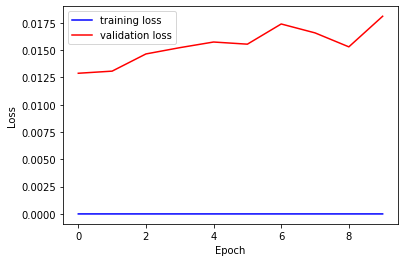

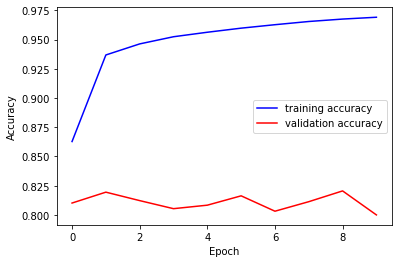

In [14]:
import matplotlib.pyplot as plt
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(range(0, len(trainloss)), trainloss, color = 'blue', label = 'training loss')
plt.plot(range(0, len(validloss)), validloss, color = 'red', label = 'validation loss')
plt.legend()
plt.show()

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(range(0, len(trainaccu)), trainaccu, color = 'blue', label = 'training accuracy')
plt.plot(range(0, len(validaccu)), validaccu, color = 'red', label = 'validation accuracy')
plt.legend()
plt.show()


In [15]:
import csv
with open('./model/output.csv','w',newline='') as f:
  w = csv.writer(f)
  w.writerow(trainloss)
  w.writerow(validloss)
  w.writerow(trainaccu)
  w.writerow(validaccu)

In [16]:
valid_result= []
for i in range(0, np.size(valid_output,0)):
  if valid_output[i][0] >= valid_output[i][1]:
    valid_result.append(0)
  else: 
    valid_result.append(1)


AUC=  0.8


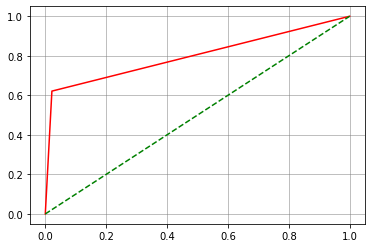

Accuracy=  0.8
Sensitivity=  0.721
Specificity=  0.966
Precision=  0.978
Negative Predictive Value=  0.621


In [17]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
##y_valid= np.array(y_valid, dtype= bool)
##valid_result= np.array(valid_result, dtype= bool)
print("AUC= ", round(roc_auc_score(y_valid, valid_result),3))
fpr, tpr, thresholds = roc_curve(y_valid, valid_result, pos_label= 1)
plt.plot(fpr, tpr, color= 'red', label= 'ROC curve (area = %0.2f)')
plt.grid(color= 'grey', linewidth= 0.5)
plt.plot([0,1], [0,1], color= 'green', linestyle= '--')
plt.show()

from sklearn.metrics import accuracy_score
print("Accuracy= ", round(accuracy_score(valid_result, y_valid), 3))

from sklearn.metrics import confusion_matrix
cnf = confusion_matrix(y_valid, valid_result)
tp = cnf[0][0]
fp = cnf[0][1]
tn = cnf[1][1]
fn = cnf[1][0]
print("Sensitivity= ", round(tp/(tp+fn), 3))
print("Specificity= ", round(tn/(tn+fp), 3))
print("Precision= ", round(tp/(tp+fp), 3))
print("Negative Predictive Value= ", round(tn/(tn+fn), 3))

In [18]:
!cp -r /content/model/checkpoint.ckpt /content/drive/MyDrive
!cp -r /content/model/output.csv /content/drive/MyDrive

In [ ]:
import torch
import torch.nn as nn

from functools import partial
from dataclasses import dataclass
from collections import OrderedDict

class Conv2dAuto(nn.Conv2d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.padding =  (self.kernel_size[0] // 2, self.kernel_size[1] // 2)
        
conv3x3 = partial(Conv2dAuto, kernel_size=3, bias=False)  

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.in_channels, self.out_channels =  in_channels, out_channels
        self.blocks = nn.Identity()
        self.shortcut = nn.Identity()   
    
    def forward(self, x):
        residual = x
        if self.should_apply_shortcut: residual = self.shortcut(x)
        x = self.blocks(x)
        x += residual
        return x
    
    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.out_channels

from collections import OrderedDict

class ResNetResidualBlock(ResidualBlock):
    def __init__(self, in_channels, out_channels, expansion=1, downsampling=1, conv=conv3x3, *args, **kwargs):
        super().__init__(in_channels, out_channels)
        self.expansion, self.downsampling, self.conv = expansion, downsampling, conv
        self.shortcut = nn.Sequential(OrderedDict(
        {
            'conv' : nn.Conv2d(self.in_channels, self.expanded_channels, kernel_size=1,
                      stride=self.downsampling, bias=False),
            'bn' : nn.BatchNorm2d(self.expanded_channels)
            
        })) if self.should_apply_shortcut else None
        
        
    @property
    def expanded_channels(self):
        return self.out_channels * self.expansion
    
    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.expanded_channels

from collections import OrderedDict
def conv_bn(in_channels, out_channels, conv, *args, **kwargs):
    return nn.Sequential(OrderedDict({'conv': conv(in_channels, out_channels, *args, **kwargs), 
                          'bn': nn.BatchNorm2d(out_channels) }))

class ResNetBasicBlock(ResNetResidualBlock):
    expansion = 1
    def __init__(self, in_channels, out_channels, activation=nn.ReLU, *args, **kwargs):
        super().__init__(in_channels, out_channels, *args, **kwargs)
        self.blocks = nn.Sequential(
            conv_bn(self.in_channels, self.out_channels, conv=self.conv, bias=False, stride=self.downsampling),
            activation(),
            conv_bn(self.out_channels, self.expanded_channels, conv=self.conv, bias=False),
        )

class ResNetBottleNeckBlock(ResNetResidualBlock):
    expansion = 4
    def __init__(self, in_channels, out_channels, activation=nn.ReLU, *args, **kwargs):
        super().__init__(in_channels, out_channels, expansion=4, *args, **kwargs)
        self.blocks = nn.Sequential(
           conv_bn(self.in_channels, self.out_channels, self.conv, kernel_size=1),
             activation(),
             conv_bn(self.out_channels, self.out_channels, self.conv, kernel_size=3, stride=self.downsampling),
             activation(),
             conv_bn(self.out_channels, self.expanded_channels, self.conv, kernel_size=1),
        )

class ResNetLayer(nn.Module):
    def __init__(self, in_channels, out_channels, block=ResNetBasicBlock, n=1, *args, **kwargs):
        super().__init__()
        # 'We perform downsampling directly by convolutional layers that have a stride of 2.'
        downsampling = 2 if in_channels != out_channels else 1
        
        self.blocks = nn.Sequential(
            block(in_channels , out_channels, *args, **kwargs, downsampling=downsampling),
            *[block(out_channels * block.expansion, 
                    out_channels, downsampling=1, *args, **kwargs) for _ in range(n - 1)]
        )

    def forward(self, x):
        x = self.blocks(x)
        return x

class ResNetEncoder(nn.Module):
    """
    ResNet encoder composed by increasing different layers with increasing features.
    """
    def __init__(self, in_channels=3, blocks_sizes=[64, 128, 256, 512], deepths=[2,2,2,2], 
                 activation=nn.ReLU, block=ResNetBasicBlock, *args,**kwargs):
        super().__init__()
        
        self.blocks_sizes = blocks_sizes
        
        self.gate = nn.Sequential(
            nn.Conv2d(in_channels, self.blocks_sizes[0], kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(self.blocks_sizes[0]),
            activation(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        self.in_out_block_sizes = list(zip(blocks_sizes, blocks_sizes[1:]))
        self.blocks = nn.ModuleList([ 
            ResNetLayer(blocks_sizes[0], blocks_sizes[0], n=deepths[0], activation=activation, 
                        block=block,  *args, **kwargs),
            *[ResNetLayer(in_channels * block.expansion, 
                          out_channels, n=n, activation=activation, 
                          block=block, *args, **kwargs) 
              for (in_channels, out_channels), n in zip(self.in_out_block_sizes, deepths[1:])]       
        ])
        
        
    def forward(self, x):
      x = self.gate(x)
      for block in self.blocks:
          x = block(x)
      return x

class ResnetDecoder(nn.Module):
    """
    This class represents the tail of ResNet. It performs a global pooling and maps the output to the
    correct class by using a fully connected layer.
    """
    def __init__(self, in_features, n_classes):
        super().__init__()
        self.avg = nn.AdaptiveAvgPool2d((1, 1))
        self.decoder = nn.Linear(in_features, n_classes)

    def forward(self, x):
        x = self.avg(x)
        x = x.view(x.size(0), -1)
        x = self.decoder(x)
        return x

class ResNet(nn.Module):
    
    def __init__(self, in_channels, n_classes, *args, **kwargs):
        super().__init__()
        self.encoder = ResNetEncoder(in_channels, *args, **kwargs)
        self.decoder = ResnetDecoder(self.encoder.blocks[-1].blocks[-1].expanded_channels, n_classes)
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

def resnet18(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBasicBlock, deepths=[2, 2, 2, 2])

def resnet34(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBasicBlock, deepths=[3, 4, 6, 3])

def resnet50(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBottleNeckBlock, deepths=[3, 4, 6, 3])

def resnet101(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBottleNeckBlock, deepths=[3, 4, 23, 3])

def resnet152(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBottleNeckBlock, deepths=[3, 8, 36, 3])